# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Importamos los datos

In [4]:
path = '../../../Base de datos/Trayectorias 200 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')
varftrain = np.transpose(varftrain, (0,3,1,2))

In [6]:
np.shape(varftrain)

(7000, 200, 10, 2)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')
varftest = np.transpose(varftest, (0,3,1,2))

In [10]:
np.shape(varftest)

(1000, 200, 10, 2)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(1000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')
varfval = np.transpose(varfval, (0,3,1,2))

In [14]:
np.shape(varfval)

(2000, 200, 10, 2)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(2000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(200, 10, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [27]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [28]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [29]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [30]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [32]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

def objective(trial):
    model = Sequential()
    n_conv_layers = trial.suggest_int("n_conv_layers", 1, 5)
    
    input_shape = (200, 10, 2)  # Tus dimensiones de entrada
    current_shape = input_shape
    
    for i in range(n_conv_layers):
        num_filters = trial.suggest_int(f"num_filters_{i+1}", 8, 64)
        filter_size1 = trial.suggest_int(f"filter_size1_{i+1}", 2, 5)
        filter_size2 = trial.suggest_int(f"filter_size2_{i+1}", 2, 5)
        activation = trial.suggest_categorical(f"activation_{i+1}", ['relu', 'tanh', 'sigmoid'])
        kernel_initializer = trial.suggest_categorical(f"kernel_initializer_{i+1}", ['HeNormal', 'glorot_uniform', 'random_normal'])
        kernel_regularizer = trial.suggest_categorical(f"kernel_regularizer_{i+1}", ['l1', 'l2'])
        
        regularizer = None
        if kernel_regularizer == 'l1':
            regularizer = l1(0.001)
        elif kernel_regularizer == 'l2':
            regularizer = l2(0.001)
            
            
        if (current_shape[0] - filter_size1 + 1 > 0) and (current_shape[1] - filter_size2 + 1 > 0):
            if i == 0:
                model.add(Conv2D(num_filters, (filter_size1, filter_size2), activation=activation, input_shape=input_shape, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
            else:
                model.add(Conv2D(num_filters, (filter_size1, filter_size2), activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
            
            current_shape = (current_shape[0] - filter_size1 + 1, current_shape[1] - filter_size2 + 1, num_filters)
            
        # Decide si agregar una capa de MaxPooling después de esta capa convolucional
        add_maxpooling = trial.suggest_categorical(f"add_maxpooling_after_conv_{i+1}", [True, False])
        if add_maxpooling:
            if current_shape[0] >= 2 and current_shape[1] >= 2:  # Asegurarse de que ambas dimensiones son suficientes para MaxPooling
                model.add(MaxPooling2D(pool_size=(2, 2)))
                current_shape = (current_shape[0] // 2, current_shape[1] // 2, current_shape[2])
        
    model.add(Flatten())
    n_dense_layers = trial.suggest_int("n_dense_layers", 1, 5)
    
    for i in range(n_dense_layers):
        num_units = trial.suggest_int(f"num_units_{i+1}", 16, 128)
        activation = trial.suggest_categorical(f"dense_activation_{i+1}", ['relu', 'tanh', 'sigmoid'])
        kernel_initializer = trial.suggest_categorical(f"dense_kernel_initializer_{i+1}", ['HeNormal', 'glorot_uniform', 'random_normal'])
        kernel_regularizer = trial.suggest_categorical(f"dense_kernel_regularizer_{i+1}", ['l1', 'l2'])

        regularizer = None
        if kernel_regularizer == 'l1':
            regularizer = l1(0.001)
        elif kernel_regularizer == 'l2':
            regularizer = l2(0.001)

        model.add(Dense(num_units, activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
    
        # Decide si agregar una capa de Dropout después de esta capa densa
        add_dropout = trial.suggest_categorical(f"add_dropout_after_dense_{i+1}", [True, False])
        if add_dropout:
            dropout_rate = trial.suggest_float(f"dropout_rate_after_dense_{i+1}", 0.1, 0.5)
            model.add(Dropout(dropout_rate))
            
    model.add(Dense(7, activation=custom_activation))
        
    optimizer = Adam(learning_rate=0.001, clipvalue=100.0)
        
    model.compile(optimizer=optimizer, loss= 'mean_squared_error', metrics=metrics)
    
    history = model.fit(
        train_dataset, 
        validation_data=val_dataset, 
        epochs=20,  
        callbacks=[reduce_lr, early_stop]
    )
    
    val_mean_metric = history.history['val_mean_metric'][-1]
    
    return val_mean_metric

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)

print(f'Número de trials finalizados: {len(study.trials)}')
print(f'Mejor trial:')
trial = study.best_trial

print(f'  Valor: {trial.value}')
print('  Parámetros: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-09-27 17:11:57,557] A new study created in memory with name: no-name-9939feb6-6031-474e-a56c-dc0f2cdec529


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 13.7931 - a_1: 2.8094 - a_2: 2.8056 - b_1: 2.8345 - b_2: 2.7693 - d_1: 2.7700 - d_2: 2.7258 - n: 1.7633 - mean_metric: 0.6108 - val_loss: 10.9376 - val_a_1: 2.7453 - val_a_2: 2.6503 - val_b_1: 2.7361 - val_b_2: 2.4230 - val_d_1: 2.6678 - val_d_2: 2.0864 - val_n: 1.5174 - val_mean_metric: 0.5529 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 10.2801 - a_1: 2.7695 - a_2: 2.7126 - b_1: 2.7631 - b_2: 2.4161 - d_1: 2.5127 - d_2: 1.8148 - n: 1.5593 - mean_metric: 0.5468 - val_loss: 8.7112 - val_a_1: 2.7223 - val_a_2: 2.6769 - val_b_1: 2.5992 - val_b_2: 2.3724 - val_d_1: 1.5855 - val_d_2: 1.6768 - val_n: 1.4725 - val_mean_metric: 0.4964 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 8.4154 - a_1: 2.7362 - a_2: 2.7086 - b_1: 2.4655 - b_2: 2.3264 - d_1: 1.6430 - d_2: 1.6123 - n: 1.5408 - mean_metric: 0.4969 - val_loss: 7.5044 - val_a_1: 2.6927 - 

[I 2023-09-27 17:12:13,678] Trial 0 finished with value: 0.394233763217926 and parameters: {'n_conv_layers': 3, 'num_filters_1': 16, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 17, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 11, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 2, 'num_units_1': 57, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.11548891118038629, 'num_units_2': 94, 'dense_activation_2': 'tanh', 'dense_ke

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 15.4687 - a_1: 2.7249 - a_2: 2.7548 - b_1: 2.6559 - b_2: 2.6156 - d_1: 2.1101 - d_2: 2.2775 - n: 1.5767 - mean_metric: 0.5525 - val_loss: 11.0276 - val_a_1: 2.6926 - val_a_2: 2.6713 - val_b_1: 2.4250 - val_b_2: 2.3986 - val_d_1: 1.6151 - val_d_2: 1.6387 - val_n: 1.4557 - val_mean_metric: 0.4896 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 9.2877 - a_1: 2.6970 - a_2: 2.6802 - b_1: 2.3327 - b_2: 2.2631 - d_1: 1.4662 - d_2: 1.4555 - n: 1.4764 - mean_metric: 0.4750 - val_loss: 7.7206 - val_a_1: 2.6766 - val_a_2: 2.6387 - val_b_1: 2.1529 - val_b_2: 2.1157 - val_d_1: 1.2801 - val_d_2: 1.2295 - val_n: 1.4517 - val_mean_metric: 0.4451 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.2432 - a_1: 2.6706 - a_2: 2.6561 - b_1: 2.1262 - b_2: 2.0508 - d_1: 1.1723 - d_2: 1.1682 - n: 1.4775 - mean_metric: 0.4403 - val_loss: 6.4484 - val_a_1: 2.6633 - va

[I 2023-09-27 17:12:27,847] Trial 1 finished with value: 0.32969239354133606 and parameters: {'n_conv_layers': 2, 'num_filters_1': 17, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 52, 'filter_size1_2': 2, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 99, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.2737480813385927, 'num_units_2': 42, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False, 'num_units_3': 69, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'He

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 9.3356 - a_1: 2.7709 - a_2: 2.7727 - b_1: 2.4700 - b_2: 2.3552 - d_1: 1.9354 - d_2: 1.9017 - n: 1.6473 - mean_metric: 0.5242 - val_loss: 7.6711 - val_a_1: 2.6902 - val_a_2: 2.6211 - val_b_1: 2.1156 - val_b_2: 2.1081 - val_d_1: 1.5024 - val_d_2: 1.5002 - val_n: 1.4550 - val_mean_metric: 0.4598 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 8.0002 - a_1: 2.7065 - a_2: 2.6969 - b_1: 2.1739 - b_2: 2.1327 - d_1: 1.5601 - d_2: 1.6060 - n: 1.5040 - mean_metric: 0.4753 - val_loss: 7.1034 - val_a_1: 2.6708 - val_a_2: 2.6365 - val_b_1: 1.9164 - val_b_2: 1.9801 - val_d_1: 1.3715 - val_d_2: 1.3282 - val_n: 1.4568 - val_mean_metric: 0.4391 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 7.3269 - a_1: 2.6747 - a_2: 2.6592 - b_1: 1.9674 - b_2: 1.9521 - d_1: 1.4018 - d_2: 1.3886 - n: 1.4868 - mean_metric: 0.4472 - val_loss: 6.5592 - val_a_1: 2.6650 - val

[I 2023-09-27 17:12:46,799] Trial 2 finished with value: 0.3454567790031433 and parameters: {'n_conv_layers': 4, 'num_filters_1': 54, 'filter_size1_1': 4, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 39, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 43, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 29, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 2, 'num_units_1': 105, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_unifo

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 11.2676 - a_1: 2.8718 - a_2: 2.8631 - b_1: 2.7998 - b_2: 2.8184 - d_1: 2.6718 - d_2: 2.6720 - n: 1.7409 - mean_metric: 0.6095 - val_loss: 9.0295 - val_a_1: 2.7447 - val_a_2: 2.7076 - val_b_1: 2.5257 - val_b_2: 2.6332 - val_d_1: 2.2190 - val_d_2: 2.2950 - val_n: 1.4647 - val_mean_metric: 0.5452 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 9.7751 - a_1: 2.8107 - a_2: 2.8026 - b_1: 2.6813 - b_2: 2.7370 - d_1: 2.2132 - d_2: 2.4033 - n: 1.5926 - mean_metric: 0.5699 - val_loss: 8.5059 - val_a_1: 2.7468 - val_a_2: 2.7077 - val_b_1: 2.5548 - val_b_2: 2.6299 - val_d_1: 1.9543 - val_d_2: 2.1210 - val_n: 1.4677 - val_mean_metric: 0.5318 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 8.8697 - a_1: 2.7864 - a_2: 2.7806 - b_1: 2.6616 - b_2: 2.6128 - d_1: 1.9056 - d_2: 2.1065 - n: 1.5794 - mean_metric: 0.5431 - val_loss: 7.6663 - val_a_1: 2.7314 - va

[I 2023-09-27 17:13:02,779] Trial 3 finished with value: 0.41112610697746277 and parameters: {'n_conv_layers': 3, 'num_filters_1': 17, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 60, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 53, 'filter_size1_3': 2, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 118, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.42667151971025596, 'num_units_2': 89, 'dense_activation_2': 'relu', 'dense_kernel_i

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 15.2569 - a_1: 2.7965 - a_2: 2.8111 - b_1: 2.7697 - b_2: 2.7267 - d_1: 2.5967 - d_2: 2.6283 - n: 1.5288 - mean_metric: 0.5902 - val_loss: 10.8439 - val_a_1: 2.7381 - val_a_2: 2.7024 - val_b_1: 2.6026 - val_b_2: 2.5760 - val_d_1: 2.1743 - val_d_2: 2.2876 - val_n: 1.4716 - val_mean_metric: 0.5440 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 10.1706 - a_1: 2.7676 - a_2: 2.7395 - b_1: 2.6253 - b_2: 2.6332 - d_1: 2.1939 - d_2: 2.2899 - n: 1.5207 - mean_metric: 0.5543 - val_loss: 9.1832 - val_a_1: 2.7440 - val_a_2: 2.6998 - val_b_1: 2.5630 - val_b_2: 2.6179 - val_d_1: 2.1206 - val_d_2: 2.1323 - val_n: 1.4709 - val_mean_metric: 0.5372 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 9.1259 - a_1: 2.7420 - a_2: 2.7333 - b_1: 2.6173 - b_2: 2.6295 - d_1: 2.0154 - d_2: 2.1203 - n: 1.5018 - mean_metric: 0.5407 - val_loss: 8.6884 - val_a_1: 2.7290 - 

[I 2023-09-27 17:13:20,465] Trial 4 finished with value: 0.36611831188201904 and parameters: {'n_conv_layers': 3, 'num_filters_1': 15, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 62, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 48, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 3, 'num_units_1': 99, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.243706209322898, 'num_units_2': 62, 'dense_activation_2': 'relu', 'dense_kernel_initia

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.4852 - a_1: 2.8374 - a_2: 2.7619 - b_1: 2.7073 - b_2: 2.7209 - d_1: 2.3797 - d_2: 2.4645 - n: 1.8157 - mean_metric: 0.5846 - val_loss: 8.0654 - val_a_1: 2.7598 - val_a_2: 2.6769 - val_b_1: 2.5626 - val_b_2: 2.6220 - val_d_1: 1.9064 - val_d_2: 2.1149 - val_n: 1.5376 - val_mean_metric: 0.5317 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.4534 - a_1: 2.7827 - a_2: 2.7242 - b_1: 2.6375 - b_2: 2.6025 - d_1: 1.9598 - d_2: 2.1837 - n: 1.6911 - mean_metric: 0.5481 - val_loss: 7.3664 - val_a_1: 2.7165 - val_a_2: 2.6599 - val_b_1: 2.4787 - val_b_2: 2.5200 - val_d_1: 1.6757 - val_d_2: 1.8513 - val_n: 1.4874 - val_mean_metric: 0.5057 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.9567 - a_1: 2.7531 - a_2: 2.7126 - b_1: 2.5394 - b_2: 2.4989 - d_1: 1.8714 - d_2: 1.9712 - n: 1.6474 - mean_metric: 0.5286 - val_loss: 6.9986 - val_a_1: 2.7021 - val

[I 2023-09-27 17:13:35,347] Trial 5 finished with value: 0.3903482258319855 and parameters: {'n_conv_layers': 2, 'num_filters_1': 19, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 26, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 50, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 31, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.4160656115385457, 'num_units_3': 17, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'HeNormal', 'den

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 10.2816 - a_1: 2.8386 - a_2: 2.7651 - b_1: 2.6824 - b_2: 2.6385 - d_1: 2.2831 - d_2: 2.3663 - n: 2.4531 - mean_metric: 0.5958 - val_loss: 9.0484 - val_a_1: 2.7597 - val_a_2: 2.6679 - val_b_1: 2.4865 - val_b_2: 2.3851 - val_d_1: 2.0557 - val_d_2: 2.2133 - val_n: 2.3949 - val_mean_metric: 0.5574 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 9.0069 - a_1: 2.8155 - a_2: 2.7502 - b_1: 2.5703 - b_2: 2.3573 - d_1: 1.9926 - d_2: 1.9989 - n: 2.1945 - mean_metric: 0.5513 - val_loss: 7.2760 - val_a_1: 2.6978 - val_a_2: 2.6524 - val_b_1: 2.2868 - val_b_2: 2.1337 - val_d_1: 1.7068 - val_d_2: 1.5948 - val_n: 1.6946 - val_mean_metric: 0.4853 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.7135 - a_1: 2.7841 - a_2: 2.7279 - b_1: 2.4201 - b_2: 2.1549 - d_1: 1.7814 - d_2: 1.6378 - n: 1.5812 - mean_metric: 0.4986 - val_loss: 6.7560 - val_a_1: 2.6718 - va

[I 2023-09-27 17:13:51,848] Trial 6 finished with value: 0.34644246101379395 and parameters: {'n_conv_layers': 4, 'num_filters_1': 24, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 20, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 48, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 56, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 1, 'num_units_1': 30, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 14.4445 - a_1: 2.7290 - a_2: 2.7650 - b_1: 2.4905 - b_2: 2.5757 - d_1: 1.6804 - d_2: 1.8345 - n: 2.4687 - mean_metric: 0.5470 - val_loss: 13.0577 - val_a_1: 2.6810 - val_a_2: 2.7128 - val_b_1: 2.2639 - val_b_2: 2.3405 - val_d_1: 1.4286 - val_d_2: 1.4804 - val_n: 2.3419 - val_mean_metric: 0.5011 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 11.9336 - a_1: 2.6785 - a_2: 2.6681 - b_1: 2.2214 - b_2: 2.1834 - d_1: 1.4055 - d_2: 1.4768 - n: 1.6307 - mean_metric: 0.4715 - val_loss: 11.1895 - val_a_1: 2.7071 - val_a_2: 2.6040 - val_b_1: 2.0897 - val_b_2: 2.1481 - val_d_1: 1.3322 - val_d_2: 1.4035 - val_n: 1.4639 - val_mean_metric: 0.4518 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 10.7244 - a_1: 2.6533 - a_2: 2.6376 - b_1: 2.0436 - b_2: 2.0467 - d_1: 1.2902 - d_2: 1.3364 - n: 1.4750 - mean_metric: 0.4456 - val_loss: 10.1464 - val_a_1: 2.6979

[I 2023-09-27 17:14:10,394] Trial 7 finished with value: 0.34241580963134766 and parameters: {'n_conv_layers': 5, 'num_filters_1': 48, 'filter_size1_1': 2, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 4, 'filter_size2_2': 2, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 62, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 57, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 56, 'filter_size1_5': 5, 'filter_size2_5': 4, 'activation_5': 'tanh', 'kernel_initialize

Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 8.8521 - a_1: 2.7490 - a_2: 2.7344 - b_1: 2.5957 - b_2: 2.6096 - d_1: 2.1061 - d_2: 2.2745 - n: 1.5009 - mean_metric: 0.5477 - val_loss: 8.2294 - val_a_1: 2.7132 - val_a_2: 2.6882 - val_b_1: 2.5103 - val_b_2: 2.5953 - val_d_1: 1.8887 - val_d_2: 2.0366 - val_n: 1.4893 - val_mean_metric: 0.5232 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 15ms/step - loss: 7.8518 - a_1: 2.7023 - a_2: 2.7036 - b_1: 2.4596 - b_2: 2.4591 - d_1: 1.7308 - d_2: 1.8481 - n: 1.4985 - mean_metric: 0.5091 - val_loss: 7.5359 - val_a_1: 2.7014 - val_a_2: 2.6828 - val_b_1: 2.3485 - val_b_2: 2.3639 - val_d_1: 1.7437 - val_d_2: 1.6409 - val_n: 1.4906 - val_mean_metric: 0.4919 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 16ms/step - loss: 7.2777 - a_1: 2.6838 - a_2: 2.6651 - b_1: 2.3413 - b_2: 2.2511 - d_1: 1.6182 - d_2: 1.6173 - n: 1.4906 - mean_metric: 0.4848 - val_loss: 6.8424 - val_a_1: 2.6843 - val

[I 2023-09-27 17:14:32,651] Trial 8 finished with value: 0.4163193702697754 and parameters: {'n_conv_layers': 1, 'num_filters_1': 63, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'n_dense_layers': 3, 'num_units_1': 52, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': False, 'num_units_2': 83, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False, 'num_units_3': 70, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': False}. Best is trial 1 with value: 0.32969239354133606.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 10.9745 - a_1: 2.7907 - a_2: 2.7456 - b_1: 2.8077 - b_2: 2.7390 - d_1: 2.5737 - d_2: 2.5812 - n: 1.5704 - mean_metric: 0.5886 - val_loss: 9.3043 - val_a_1: 2.7429 - val_a_2: 2.6998 - val_b_1: 2.7547 - val_b_2: 2.6561 - val_d_1: 2.3603 - val_d_2: 2.2638 - val_n: 1.4650 - val_mean_metric: 0.5567 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.9903 - a_1: 2.7646 - a_2: 2.7313 - b_1: 2.7211 - b_2: 2.6254 - d_1: 2.2749 - d_2: 2.2436 - n: 1.5198 - mean_metric: 0.5579 - val_loss: 8.4011 - val_a_1: 2.7436 - val_a_2: 2.7104 - val_b_1: 2.6187 - val_b_2: 2.5921 - val_d_1: 2.2089 - val_d_2: 2.1168 - val_n: 1.4722 - val_mean_metric: 0.5410 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 8.5242 - a_1: 2.7540 - a_2: 2.7273 - b_1: 2.6530 - b_2: 2.5719 - d_1: 2.2388 - d_2: 2.1521 - n: 1.5067 - mean_metric: 0.5487 - val_loss: 8.2310 - val_a_1: 2.7495 - va

[I 2023-09-27 17:14:48,673] Trial 9 finished with value: 0.37075844407081604 and parameters: {'n_conv_layers': 3, 'num_filters_1': 15, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 14, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 29, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 39, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.20097629364068792, 'num_units_2': 52, 'dense_activation_2': 'sigmoid', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 26.0756 - a_1: 2.9434 - a_2: 2.9491 - b_1: 2.9057 - b_2: 2.9074 - d_1: 2.8474 - d_2: 2.8138 - n: 1.7537 - mean_metric: 0.6318 - val_loss: 12.8171 - val_a_1: 2.7406 - val_a_2: 2.7801 - val_b_1: 2.7042 - val_b_2: 2.6823 - val_d_1: 2.4606 - val_d_2: 2.3361 - val_n: 1.4755 - val_mean_metric: 0.5645 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 11.2471 - a_1: 2.8479 - a_2: 2.8594 - b_1: 2.7741 - b_2: 2.7603 - d_1: 2.4603 - d_2: 2.3116 - n: 1.6213 - mean_metric: 0.5829 - val_loss: 8.8092 - val_a_1: 2.7258 - val_a_2: 2.7300 - val_b_1: 2.6483 - val_b_2: 2.6229 - val_d_1: 2.1764 - val_d_2: 1.9307 - val_n: 1.4763 - val_mean_metric: 0.5360 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 9.0589 - a_1: 2.7597 - a_2: 2.7876 - b_1: 2.6839 - b_2: 2.6806 - d_1: 2.0617 - d_2: 1.9131 - n: 1.5747 - mean_metric: 0.5442 - val_loss: 8.0379 - val_a_1: 2.7063 - 

[I 2023-09-27 17:15:03,666] Trial 10 finished with value: 0.4568948447704315 and parameters: {'n_conv_layers': 1, 'num_filters_1': 34, 'filter_size1_1': 3, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 5, 'num_units_1': 80, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 127, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False, 'num_units_3': 126, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': False, 'num_units_4': 20, 'dense_activation_4': 'relu', 'dense_kernel_initializer_4': 'random_normal', 'dense_kernel_regularizer_4': 'l2', 'add_dropout_after_dense_4': F

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 14.9307 - a_1: 2.7208 - a_2: 2.7170 - b_1: 2.5529 - b_2: 2.5474 - d_1: 1.7858 - d_2: 1.8339 - n: 1.7802 - mean_metric: 0.5269 - val_loss: 12.9689 - val_a_1: 2.6934 - val_a_2: 2.6601 - val_b_1: 2.2923 - val_b_2: 2.3678 - val_d_1: 1.4836 - val_d_2: 1.4658 - val_n: 1.4822 - val_mean_metric: 0.4747 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 12.0417 - a_1: 2.6922 - a_2: 2.6695 - b_1: 2.2511 - b_2: 2.2485 - d_1: 1.4417 - d_2: 1.4276 - n: 1.4933 - mean_metric: 0.4702 - val_loss: 10.9901 - val_a_1: 2.6945 - val_a_2: 2.6338 - val_b_1: 2.1265 - val_b_2: 2.2024 - val_d_1: 1.4134 - val_d_2: 1.3775 - val_n: 1.4697 - val_mean_metric: 0.4574 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 10.2878 - a_1: 2.6914 - a_2: 2.6538 - b_1: 2.1400 - b_2: 2.1074 - d_1: 1.3734 - d_2: 1.3387 - n: 1.4820 - mean_metric: 0.4557 - val_loss: 9.4290 - val_a_1: 2.6864 

[I 2023-09-27 17:15:20,865] Trial 11 finished with value: 0.36247533559799194 and parameters: {'n_conv_layers': 5, 'num_filters_1': 43, 'filter_size1_1': 2, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 44, 'filter_size1_2': 4, 'filter_size2_2': 2, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 61, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 62, 'filter_size1_4': 2, 'filter_size2_4': 2, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 59, 'filter_size1_5': 5, 'filter_size2_5': 4, 'activation_5': 'tanh', 'kernel_in

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 14.7783 - a_1: 2.7477 - a_2: 2.7262 - b_1: 2.6665 - b_2: 2.5592 - d_1: 2.2220 - d_2: 2.1037 - n: 1.5334 - mean_metric: 0.5472 - val_loss: 9.4795 - val_a_1: 2.7016 - val_a_2: 2.6701 - val_b_1: 2.3718 - val_b_2: 2.3530 - val_d_1: 1.5129 - val_d_2: 1.6125 - val_n: 1.4659 - val_mean_metric: 0.4827 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 8.4271 - a_1: 2.7010 - a_2: 2.6790 - b_1: 2.3589 - b_2: 2.2760 - d_1: 1.4967 - d_2: 1.5076 - n: 1.4870 - mean_metric: 0.4795 - val_loss: 7.7154 - val_a_1: 2.6972 - val_a_2: 2.6512 - val_b_1: 2.2754 - val_b_2: 2.2647 - val_d_1: 1.4550 - val_d_2: 1.4430 - val_n: 1.4644 - val_mean_metric: 0.4683 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 7.5340 - a_1: 2.6911 - a_2: 2.6698 - b_1: 2.2985 - b_2: 2.1849 - d_1: 1.4422 - d_2: 1.4598 - n: 1.4784 - mean_metric: 0.4702 - val_loss: 7.2641 - val_a_1: 2.6916 - va

[I 2023-09-27 17:15:38,309] Trial 12 finished with value: 0.4554772973060608 and parameters: {'n_conv_layers': 5, 'num_filters_1': 43, 'filter_size1_1': 2, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 50, 'filter_size1_2': 4, 'filter_size2_2': 2, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 29, 'filter_size1_3': 3, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 8, 'filter_size1_4': 5, 'filter_size2_4': 4, 'activation_4': 'relu', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 48, 'filter_size1_5': 4, 'filter_size2_5': 3, 'activation_5': 'sigmoid', 'kernel_in

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 12.8188 - a_1: 2.8121 - a_2: 2.8003 - b_1: 2.6891 - b_2: 2.6423 - d_1: 2.3859 - d_2: 2.4508 - n: 1.6337 - mean_metric: 0.5757 - val_loss: 9.4919 - val_a_1: 2.7203 - val_a_2: 2.6785 - val_b_1: 2.4413 - val_b_2: 2.5010 - val_d_1: 2.0849 - val_d_2: 1.9876 - val_n: 1.4965 - val_mean_metric: 0.5228 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.8587 - a_1: 2.7312 - a_2: 2.7280 - b_1: 2.4340 - b_2: 2.4525 - d_1: 1.9114 - d_2: 1.8824 - n: 1.5467 - mean_metric: 0.5184 - val_loss: 7.8079 - val_a_1: 2.6954 - val_a_2: 2.6702 - val_b_1: 2.2729 - val_b_2: 2.3670 - val_d_1: 1.7722 - val_d_2: 1.6899 - val_n: 1.4795 - val_mean_metric: 0.4912 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.8088 - a_1: 2.7215 - a_2: 2.7077 - b_1: 2.3374 - b_2: 2.3338 - d_1: 1.6731 - d_2: 1.6591 - n: 1.5243 - mean_metric: 0.4943 - val_loss: 7.0965 - val_a_1: 2.6898 - va

[I 2023-09-27 17:15:53,302] Trial 13 finished with value: 0.3374418318271637 and parameters: {'n_conv_layers': 2, 'num_filters_1': 32, 'filter_size1_1': 3, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 103, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 42, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24164484423927965}. Best is trial 1 with value: 0.32969239354133606.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 20.3941 - a_1: 2.8551 - a_2: 2.7983 - b_1: 2.6545 - b_2: 2.6016 - d_1: 2.3557 - d_2: 2.4608 - n: 1.6541 - mean_metric: 0.5745 - val_loss: 13.2772 - val_a_1: 2.7388 - val_a_2: 2.6763 - val_b_1: 2.3741 - val_b_2: 2.3415 - val_d_1: 1.9560 - val_d_2: 1.9536 - val_n: 1.4647 - val_mean_metric: 0.5095 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 11.5723 - a_1: 2.7949 - a_2: 2.7125 - b_1: 2.4313 - b_2: 2.3206 - d_1: 1.8832 - d_2: 1.8605 - n: 1.5460 - mean_metric: 0.5140 - val_loss: 9.2899 - val_a_1: 2.7120 - val_a_2: 2.6746 - val_b_1: 2.3258 - val_b_2: 2.1414 - val_d_1: 1.5551 - val_d_2: 1.4869 - val_n: 1.4513 - val_mean_metric: 0.4715 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 9.1419 - a_1: 2.7701 - a_2: 2.7109 - b_1: 2.3497 - b_2: 2.1910 - d_1: 1.5980 - d_2: 1.5178 - n: 1.5294 - mean_metric: 0.4847 - val_loss: 7.8237 - val_a_1: 2.7037 - 

[I 2023-09-27 17:16:09,119] Trial 14 finished with value: 0.3436991572380066 and parameters: {'n_conv_layers': 2, 'num_filters_1': 29, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 51, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 91, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.36023343341048497, 'num_units_2': 46, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.24904654904117318}. Best is trial 1 with value: 0.32969

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.8852 - a_1: 2.7731 - a_2: 2.7422 - b_1: 2.6638 - b_2: 2.6414 - d_1: 2.2435 - d_2: 2.2955 - n: 1.5617 - mean_metric: 0.5593 - val_loss: 8.8980 - val_a_1: 2.7053 - val_a_2: 2.6802 - val_b_1: 2.3873 - val_b_2: 2.4645 - val_d_1: 1.6097 - val_d_2: 1.6269 - val_n: 1.4705 - val_mean_metric: 0.4911 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.6500 - a_1: 2.7268 - a_2: 2.7134 - b_1: 2.4565 - b_2: 2.4380 - d_1: 1.6586 - d_2: 1.7181 - n: 1.5128 - mean_metric: 0.5031 - val_loss: 7.6489 - val_a_1: 2.7029 - val_a_2: 2.6635 - val_b_1: 2.2953 - val_b_2: 2.3492 - val_d_1: 1.4378 - val_d_2: 1.4454 - val_n: 1.4711 - val_mean_metric: 0.4721 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.7783 - a_1: 2.7057 - a_2: 2.6984 - b_1: 2.3889 - b_2: 2.3231 - d_1: 1.5414 - d_2: 1.5456 - n: 1.5035 - mean_metric: 0.4861 - val_loss: 7.1470 - val_a_1: 2.6922 - va

[I 2023-09-27 17:16:23,403] Trial 15 finished with value: 0.3477860987186432 and parameters: {'n_conv_layers': 2, 'num_filters_1': 10, 'filter_size1_1': 3, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 4, 'num_units_1': 75, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 37, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2867444845071526, 'num_units_3': 73, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.8761 - a_1: 2.7665 - a_2: 2.7609 - b_1: 2.6587 - b_2: 2.6886 - d_1: 2.1341 - d_2: 2.2281 - n: 1.5726 - mean_metric: 0.5556 - val_loss: 7.8865 - val_a_1: 2.7035 - val_a_2: 2.6730 - val_b_1: 2.4336 - val_b_2: 2.4680 - val_d_1: 1.5925 - val_d_2: 1.6948 - val_n: 1.4776 - val_mean_metric: 0.4943 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.1730 - a_1: 2.7498 - a_2: 2.7229 - b_1: 2.5118 - b_2: 2.4336 - d_1: 1.7107 - d_2: 1.7599 - n: 1.5449 - mean_metric: 0.5101 - val_loss: 7.1759 - val_a_1: 2.7183 - val_a_2: 2.6709 - val_b_1: 2.3824 - val_b_2: 2.2912 - val_d_1: 1.4031 - val_d_2: 1.4570 - val_n: 1.4740 - val_mean_metric: 0.4731 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.6198 - a_1: 2.7379 - a_2: 2.7176 - b_1: 2.4717 - b_2: 2.2758 - d_1: 1.6225 - d_2: 1.5585 - n: 1.5448 - mean_metric: 0.4934 - val_loss: 6.5315 - val_a_1: 2.7099 - val

[I 2023-09-27 17:16:38,287] Trial 16 finished with value: 0.342303067445755 and parameters: {'n_conv_layers': 2, 'num_filters_1': 29, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 8, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 4, 'num_units_1': 65, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.32165200445789904, 'num_units_2': 16, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.10067879016025352, 'num_units_3': 95, 'dense_activation_

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 41.8533 - a_1: 2.7256 - a_2: 2.6959 - b_1: 2.5344 - b_2: 2.4223 - d_1: 1.8819 - d_2: 1.8712 - n: 1.4973 - mean_metric: 0.5166 - val_loss: 19.5493 - val_a_1: 2.6900 - val_a_2: 2.6597 - val_b_1: 2.3111 - val_b_2: 2.2918 - val_d_1: 1.5674 - val_d_2: 1.5663 - val_n: 1.4563 - val_mean_metric: 0.4779 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 12.9970 - a_1: 2.6812 - a_2: 2.6552 - b_1: 2.3035 - b_2: 2.2042 - d_1: 1.4772 - d_2: 1.3897 - n: 1.4747 - mean_metric: 0.4689 - val_loss: 9.3103 - val_a_1: 2.6745 - val_a_2: 2.6419 - val_b_1: 2.1687 - val_b_2: 2.1396 - val_d_1: 1.3446 - val_d_2: 1.2714 - val_n: 1.4547 - val_mean_metric: 0.4501 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 8.2681 - a_1: 2.6460 - a_2: 2.6253 - b_1: 2.1240 - b_2: 2.0479 - d_1: 1.2860 - d_2: 1.1543 - n: 1.4759 - mean_metric: 0.4415 - val_loss: 7.4244 - val_a_1: 2.6581 - 

[I 2023-09-27 17:16:53,391] Trial 17 finished with value: 0.3356076776981354 and parameters: {'n_conv_layers': 1, 'num_filters_1': 36, 'filter_size1_1': 3, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 2, 'num_units_1': 116, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 62, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 1 with value: 0.32969239354133606.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 61.0772 - a_1: 2.7329 - a_2: 2.7307 - b_1: 2.5814 - b_2: 2.6524 - d_1: 2.1912 - d_2: 2.0991 - n: 1.6032 - mean_metric: 0.5485 - val_loss: 39.3246 - val_a_1: 2.7140 - val_a_2: 2.6936 - val_b_1: 2.3280 - val_b_2: 2.4685 - val_d_1: 1.5530 - val_d_2: 1.6660 - val_n: 1.4664 - val_mean_metric: 0.4893 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 27.6061 - a_1: 2.7070 - a_2: 2.6908 - b_1: 2.3122 - b_2: 2.3136 - d_1: 1.5470 - d_2: 1.5585 - n: 1.4865 - mean_metric: 0.4831 - val_loss: 18.8010 - val_a_1: 2.7127 - val_a_2: 2.6592 - val_b_1: 2.1833 - val_b_2: 2.2621 - val_d_1: 1.4577 - val_d_2: 1.4806 - val_n: 1.4656 - val_mean_metric: 0.4673 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 14.6760 - a_1: 2.7050 - a_2: 2.6835 - b_1: 2.2335 - b_2: 2.2185 - d_1: 1.4699 - d_2: 1.4638 - n: 1.4777 - mean_metric: 0.4710 - val_loss: 11.7677 - val_a_1: 2.7375

[I 2023-09-27 17:17:10,262] Trial 18 finished with value: 0.3646075129508972 and parameters: {'n_conv_layers': 1, 'num_filters_1': 40, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 2, 'num_units_1': 120, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 67, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 1 with value: 0.32969239354133606.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 12.5939 - a_1: 2.7631 - a_2: 2.7318 - b_1: 2.7441 - b_2: 2.6601 - d_1: 2.4457 - d_2: 2.3109 - n: 1.6866 - mean_metric: 0.5733 - val_loss: 8.7969 - val_a_1: 2.7157 - val_a_2: 2.6819 - val_b_1: 2.6188 - val_b_2: 2.5025 - val_d_1: 1.9264 - val_d_2: 1.6848 - val_n: 1.4722 - val_mean_metric: 0.5127 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.7796 - a_1: 2.7249 - a_2: 2.7107 - b_1: 2.5890 - b_2: 2.5213 - d_1: 1.7883 - d_2: 1.6685 - n: 1.5092 - mean_metric: 0.5126 - val_loss: 8.3318 - val_a_1: 2.7099 - val_a_2: 2.6854 - val_b_1: 2.4962 - val_b_2: 2.4636 - val_d_1: 1.5291 - val_d_2: 1.4423 - val_n: 1.4787 - val_mean_metric: 0.4865 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 8.4346 - a_1: 2.7193 - a_2: 2.7109 - b_1: 2.5295 - b_2: 2.4791 - d_1: 1.6110 - d_2: 1.5103 - n: 1.4975 - mean_metric: 0.4977 - val_loss: 7.9920 - val_a_1: 2.7154 - va

[I 2023-09-27 17:17:24,769] Trial 19 finished with value: 0.40629976987838745 and parameters: {'n_conv_layers': 1, 'num_filters_1': 24, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 4, 'num_units_1': 114, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.263173917299183, 'num_units_2': 54, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False, 'num_units_3': 50, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_dropout_after_dense_3': True, 'dropout_rate_after_dense_3': 0.48645882753375436, 'num_units_4': 81, 'dense_activation_4': 'sigmoid', 'dens

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 14.7422 - a_1: 2.7428 - a_2: 2.7296 - b_1: 2.8111 - b_2: 2.7104 - d_1: 2.5686 - d_2: 2.4931 - n: 1.8992 - mean_metric: 0.5935 - val_loss: 10.7504 - val_a_1: 2.7374 - val_a_2: 2.6831 - val_b_1: 2.6587 - val_b_2: 2.6402 - val_d_1: 2.4557 - val_d_2: 2.3034 - val_n: 1.4800 - val_mean_metric: 0.5573 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 9.4370 - a_1: 2.7271 - a_2: 2.6906 - b_1: 2.6482 - b_2: 2.5993 - d_1: 2.2816 - d_2: 2.1636 - n: 1.4918 - mean_metric: 0.5487 - val_loss: 8.4782 - val_a_1: 2.7248 - val_a_2: 2.6673 - val_b_1: 2.5521 - val_b_2: 2.5734 - val_d_1: 2.1444 - val_d_2: 2.0281 - val_n: 1.4678 - val_mean_metric: 0.5310 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.8922 - a_1: 2.7175 - a_2: 2.6706 - b_1: 2.5579 - b_2: 2.4702 - d_1: 1.9643 - d_2: 1.8149 - n: 1.4877 - mean_metric: 0.5183 - val_loss: 7.3784 - val_a_1: 2.7158 - v

[I 2023-09-27 17:17:39,052] Trial 20 finished with value: 0.34437766671180725 and parameters: {'n_conv_layers': 1, 'num_filters_1': 52, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 2, 'num_units_1': 16, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 73, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 1 with value: 0.32969239354133606.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 15.4843 - a_1: 2.7482 - a_2: 2.7556 - b_1: 2.6616 - b_2: 2.6054 - d_1: 2.2038 - d_2: 2.2763 - n: 1.7701 - mean_metric: 0.5627 - val_loss: 11.2058 - val_a_1: 2.6955 - val_a_2: 2.6846 - val_b_1: 2.4419 - val_b_2: 2.4309 - val_d_1: 1.8659 - val_d_2: 1.8558 - val_n: 1.4637 - val_mean_metric: 0.5073 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 10.0815 - a_1: 2.7184 - a_2: 2.7094 - b_1: 2.4594 - b_2: 2.4030 - d_1: 1.7190 - d_2: 1.7434 - n: 1.5593 - mean_metric: 0.5061 - val_loss: 8.5996 - val_a_1: 2.6960 - val_a_2: 2.6577 - val_b_1: 2.3159 - val_b_2: 2.3136 - val_d_1: 1.5746 - val_d_2: 1.5561 - val_n: 1.4621 - val_mean_metric: 0.4790 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 8.3682 - a_1: 2.7137 - a_2: 2.6855 - b_1: 2.3371 - b_2: 2.2938 - d_1: 1.5119 - d_2: 1.5006 - n: 1.5383 - mean_metric: 0.4818 - val_loss: 7.3840 - val_a_1: 2.6874 - 

[I 2023-09-27 17:17:55,388] Trial 21 finished with value: 0.33831459283828735 and parameters: {'n_conv_layers': 2, 'num_filters_1': 35, 'filter_size1_1': 3, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 51, 'filter_size1_2': 4, 'filter_size2_2': 2, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 99, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 38, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.2259896814080849}. Best is trial 1 with value: 0.32969239354133606.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 15.5638 - a_1: 2.8258 - a_2: 2.7423 - b_1: 2.7370 - b_2: 2.7453 - d_1: 2.6480 - d_2: 2.6888 - n: 1.5208 - mean_metric: 0.5920 - val_loss: 9.9800 - val_a_1: 2.7354 - val_a_2: 2.7147 - val_b_1: 2.6343 - val_b_2: 2.6358 - val_d_1: 2.3766 - val_d_2: 2.5437 - val_n: 1.4759 - val_mean_metric: 0.5625 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.7413 - a_1: 2.7419 - a_2: 2.7281 - b_1: 2.6169 - b_2: 2.6186 - d_1: 2.2126 - d_2: 2.4200 - n: 1.4961 - mean_metric: 0.5563 - val_loss: 8.1355 - val_a_1: 2.7429 - val_a_2: 2.7146 - val_b_1: 2.5610 - val_b_2: 2.6334 - val_d_1: 2.1123 - val_d_2: 2.3464 - val_n: 1.4754 - val_mean_metric: 0.5450 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 8.0911 - a_1: 2.7447 - a_2: 2.7291 - b_1: 2.6162 - b_2: 2.6237 - d_1: 2.0183 - d_2: 2.3006 - n: 1.4953 - mean_metric: 0.5462 - val_loss: 7.9808 - val_a_1: 2.7558 - va

[I 2023-09-27 17:18:09,925] Trial 22 finished with value: 0.41020146012306213 and parameters: {'n_conv_layers': 2, 'num_filters_1': 30, 'filter_size1_1': 3, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 28, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 127, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 30, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False, 'num_units_3': 58, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 31.0288 - a_1: 2.6950 - a_2: 2.6427 - b_1: 2.3609 - b_2: 2.2217 - d_1: 1.6002 - d_2: 1.5776 - n: 1.6064 - mean_metric: 0.4862 - val_loss: 22.0313 - val_a_1: 2.6599 - val_a_2: 2.5824 - val_b_1: 2.1058 - val_b_2: 1.9196 - val_d_1: 1.3350 - val_d_2: 1.3031 - val_n: 1.4844 - val_mean_metric: 0.4400 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 17.2862 - a_1: 2.6255 - a_2: 2.5693 - b_1: 2.0261 - b_2: 1.8232 - d_1: 1.2122 - d_2: 1.1317 - n: 1.5031 - mean_metric: 0.4261 - val_loss: 13.7001 - val_a_1: 2.6847 - val_a_2: 2.5517 - val_b_1: 1.8646 - val_b_2: 1.7706 - val_d_1: 1.1196 - val_d_2: 1.0476 - val_n: 1.4599 - val_mean_metric: 0.4107 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 11.6561 - a_1: 2.6130 - a_2: 2.5742 - b_1: 1.8574 - b_2: 1.7249 - d_1: 1.0271 - d_2: 0.9676 - n: 1.4877 - mean_metric: 0.4050 - val_loss: 9.9278 - val_a_1: 2.6480 - 

[I 2023-09-27 17:18:23,554] Trial 23 finished with value: 0.33793050050735474 and parameters: {'n_conv_layers': 1, 'num_filters_1': 23, 'filter_size1_1': 3, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 1, 'num_units_1': 92, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False}. Best is trial 1 with value: 0.32969239354133606.


Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 13.7689 - a_1: 2.7195 - a_2: 2.7245 - b_1: 2.5205 - b_2: 2.6290 - d_1: 1.9891 - d_2: 2.1146 - n: 1.5796 - mean_metric: 0.5381 - val_loss: 10.2769 - val_a_1: 2.6919 - val_a_2: 2.6631 - val_b_1: 2.3202 - val_b_2: 2.4451 - val_d_1: 1.6498 - val_d_2: 1.6759 - val_n: 1.4966 - val_mean_metric: 0.4910 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 8.9378 - a_1: 2.6829 - a_2: 2.6668 - b_1: 2.3089 - b_2: 2.2786 - d_1: 1.5024 - d_2: 1.4722 - n: 1.4983 - mean_metric: 0.4763 - val_loss: 7.8435 - val_a_1: 2.6666 - val_a_2: 2.6390 - val_b_1: 2.1730 - val_b_2: 2.1297 - val_d_1: 1.3817 - val_d_2: 1.3162 - val_n: 1.4757 - val_mean_metric: 0.4529 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 7.2782 - a_1: 2.6548 - a_2: 2.6295 - b_1: 2.1411 - b_2: 1.9871 - d_1: 1.2480 - d_2: 1.1465 - n: 1.4862 - mean_metric: 0.4393 - val_loss: 6.6770 - val_a_1: 2.6362 - val

[I 2023-09-27 17:18:36,808] Trial 24 finished with value: 0.32490524649620056 and parameters: {'n_conv_layers': 2, 'num_filters_1': 8, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 42, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 110, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 46, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 24 with value: 0.32490524649620056.


Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 17.7638 - a_1: 2.7231 - a_2: 2.6995 - b_1: 2.4482 - b_2: 2.4249 - d_1: 1.8112 - d_2: 1.7422 - n: 1.4936 - mean_metric: 0.5072 - val_loss: 13.9950 - val_a_1: 2.6934 - val_a_2: 2.6602 - val_b_1: 2.2652 - val_b_2: 2.1944 - val_d_1: 1.4770 - val_d_2: 1.4845 - val_n: 1.4657 - val_mean_metric: 0.4680 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 12.2587 - a_1: 2.6826 - a_2: 2.6569 - b_1: 2.1894 - b_2: 2.1140 - d_1: 1.4190 - d_2: 1.4631 - n: 1.4687 - mean_metric: 0.4625 - val_loss: 10.8532 - val_a_1: 2.6871 - val_a_2: 2.6235 - val_b_1: 2.0832 - val_b_2: 2.0976 - val_d_1: 1.4586 - val_d_2: 1.4046 - val_n: 1.4723 - val_mean_metric: 0.4544 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 9.8344 - a_1: 2.6597 - a_2: 2.6410 - b_1: 2.0537 - b_2: 2.0290 - d_1: 1.2454 - d_2: 1.3312 - n: 1.4683 - mean_metric: 0.4439 - val_loss: 8.9454 - val_a_1: 2.6559 - v

[I 2023-09-27 17:18:49,708] Trial 25 finished with value: 0.36052563786506653 and parameters: {'n_conv_layers': 1, 'num_filters_1': 8, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 3, 'num_units_1': 112, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 58, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False, 'num_units_3': 98, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropout_after_dense_3': False}. Best is trial 24 with value: 0.32490524649620056.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 9.2405 - a_1: 2.7122 - a_2: 2.7142 - b_1: 2.3763 - b_2: 2.4820 - d_1: 1.8539 - d_2: 1.8650 - n: 1.5383 - mean_metric: 0.5138 - val_loss: 7.3802 - val_a_1: 2.6666 - val_a_2: 2.6368 - val_b_1: 1.9935 - val_b_2: 2.2648 - val_d_1: 1.2524 - val_d_2: 1.4824 - val_n: 1.4508 - val_mean_metric: 0.4518 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.1056 - a_1: 2.6443 - a_2: 2.6444 - b_1: 1.9079 - b_2: 2.1193 - d_1: 1.1792 - d_2: 1.4436 - n: 1.4840 - mean_metric: 0.4437 - val_loss: 6.2440 - val_a_1: 2.6266 - val_a_2: 2.5768 - val_b_1: 1.6173 - val_b_2: 1.8783 - val_d_1: 0.8737 - val_d_2: 1.3175 - val_n: 1.4357 - val_mean_metric: 0.4051 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.2360 - a_1: 2.6144 - a_2: 2.6042 - b_1: 1.6991 - b_2: 1.8178 - d_1: 1.0091 - d_2: 1.2041 - n: 1.4560 - mean_metric: 0.4100 - val_loss: 5.7163 - val_a_1: 2.5933 - val_a

[I 2023-09-27 17:19:03,662] Trial 26 finished with value: 0.31730395555496216 and parameters: {'n_conv_layers': 2, 'num_filters_1': 11, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 41, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 120, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.3731856532910808, 'num_units_2': 109, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 26 with value: 0.31730395555496216.


Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.2797 - a_1: 2.7525 - a_2: 2.7517 - b_1: 2.4374 - b_2: 2.4125 - d_1: 1.8259 - d_2: 1.8770 - n: 1.6352 - mean_metric: 0.5188 - val_loss: 6.4016 - val_a_1: 2.6531 - val_a_2: 2.6320 - val_b_1: 1.9983 - val_b_2: 2.1038 - val_d_1: 1.3910 - val_d_2: 1.4213 - val_n: 1.4665 - val_mean_metric: 0.4491 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.5936 - a_1: 2.6655 - a_2: 2.6515 - b_1: 1.9735 - b_2: 2.0268 - d_1: 1.3844 - d_2: 1.4443 - n: 1.5424 - mean_metric: 0.4524 - val_loss: 5.7032 - val_a_1: 2.6372 - val_a_2: 2.5926 - val_b_1: 1.6991 - val_b_2: 1.8363 - val_d_1: 1.0564 - val_d_2: 1.2164 - val_n: 1.4495 - val_mean_metric: 0.4104 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.0529 - a_1: 2.6284 - a_2: 2.6238 - b_1: 1.8288 - b_2: 1.8634 - d_1: 1.2170 - d_2: 1.2582 - n: 1.5186 - mean_metric: 0.4277 - val_loss: 5.3152 - val_a_1: 2.6249 - val_a

[I 2023-09-27 17:19:17,022] Trial 27 finished with value: 0.3238164186477661 and parameters: {'n_conv_layers': 4, 'num_filters_1': 11, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 43, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 8, 'filter_size1_3': 2, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 34, 'filter_size1_4': 5, 'filter_size2_4': 2, 'activation_4': 'tanh', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 1, 'num_units_1': 83, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.4427 - a_1: 2.7974 - a_2: 2.7671 - b_1: 2.5393 - b_2: 2.5733 - d_1: 1.7931 - d_2: 1.8614 - n: 1.7569 - mean_metric: 0.5320 - val_loss: 6.5152 - val_a_1: 2.6851 - val_a_2: 2.6425 - val_b_1: 2.2051 - val_b_2: 2.1709 - val_d_1: 1.4950 - val_d_2: 1.4965 - val_n: 1.4533 - val_mean_metric: 0.4649 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.5914 - a_1: 2.7250 - a_2: 2.6578 - b_1: 2.0692 - b_2: 2.0709 - d_1: 1.4559 - d_2: 1.4960 - n: 1.5502 - mean_metric: 0.4635 - val_loss: 5.6069 - val_a_1: 2.6406 - val_a_2: 2.5781 - val_b_1: 1.8638 - val_b_2: 1.8078 - val_d_1: 1.2387 - val_d_2: 1.2190 - val_n: 1.4413 - val_mean_metric: 0.4203 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.0197 - a_1: 2.6676 - a_2: 2.6325 - b_1: 1.9046 - b_2: 1.8487 - d_1: 1.3234 - d_2: 1.2400 - n: 1.5445 - mean_metric: 0.4350 - val_loss: 5.2678 - val_a_1: 2.6230 - val_a

[I 2023-09-27 17:19:30,107] Trial 28 finished with value: 0.3285156786441803 and parameters: {'n_conv_layers': 4, 'num_filters_1': 11, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 42, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 10, 'filter_size1_3': 2, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 33, 'filter_size1_4': 5, 'filter_size2_4': 2, 'activation_4': 'tanh', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 1, 'num_units_1': 83, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 8.8869 - a_1: 2.7993 - a_2: 2.7683 - b_1: 2.6178 - b_2: 2.6375 - d_1: 1.9567 - d_2: 1.9896 - n: 1.6469 - mean_metric: 0.5427 - val_loss: 7.1715 - val_a_1: 2.7134 - val_a_2: 2.6475 - val_b_1: 2.2361 - val_b_2: 2.4241 - val_d_1: 1.5089 - val_d_2: 1.6439 - val_n: 1.4996 - val_mean_metric: 0.4822 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 7.5818 - a_1: 2.7458 - a_2: 2.6986 - b_1: 2.3951 - b_2: 2.3818 - d_1: 1.6578 - d_2: 1.6432 - n: 1.6004 - mean_metric: 0.4999 - val_loss: 6.6726 - val_a_1: 2.6942 - val_a_2: 2.6359 - val_b_1: 2.1548 - val_b_2: 2.3263 - val_d_1: 1.4856 - val_d_2: 1.4311 - val_n: 1.4667 - val_mean_metric: 0.4665 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 7.1484 - a_1: 2.7341 - a_2: 2.6900 - b_1: 2.2851 - b_2: 2.2602 - d_1: 1.5793 - d_2: 1.4937 - n: 1.5814 - mean_metric: 0.4834 - val_loss: 6.2615 - val_a_1: 2.6880 - val

[I 2023-09-27 17:19:49,223] Trial 29 finished with value: 0.3634980618953705 and parameters: {'n_conv_layers': 4, 'num_filters_1': 13, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 45, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 21, 'filter_size1_3': 3, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 19, 'filter_size1_4': 4, 'filter_size2_4': 3, 'activation_4': 'tanh', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 1, 'num_units_1': 66, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNor

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.1793 - a_1: 2.7902 - a_2: 2.7798 - b_1: 2.3751 - b_2: 2.4797 - d_1: 1.6860 - d_2: 1.7957 - n: 1.6899 - mean_metric: 0.5157 - val_loss: 6.2298 - val_a_1: 2.6653 - val_a_2: 2.6201 - val_b_1: 1.7559 - val_b_2: 2.2517 - val_d_1: 1.2537 - val_d_2: 1.4424 - val_n: 1.4640 - val_mean_metric: 0.4421 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.3926 - a_1: 2.6496 - a_2: 2.6625 - b_1: 1.7811 - b_2: 2.1612 - d_1: 1.2464 - d_2: 1.4840 - n: 1.5347 - mean_metric: 0.4469 - val_loss: 5.6665 - val_a_1: 2.6321 - val_a_2: 2.5777 - val_b_1: 1.5585 - val_b_2: 2.0901 - val_d_1: 1.0583 - val_d_2: 1.2233 - val_n: 1.4470 - val_mean_metric: 0.4137 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.9723 - a_1: 2.6458 - a_2: 2.6265 - b_1: 1.6711 - b_2: 2.0569 - d_1: 1.1370 - d_2: 1.2576 - n: 1.5176 - mean_metric: 0.4268 - val_loss: 5.3610 - val_a_1: 2.6370 - val_a

[I 2023-09-27 17:20:02,744] Trial 30 finished with value: 0.3230557441711426 and parameters: {'n_conv_layers': 3, 'num_filters_1': 8, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 18, 'filter_size1_3': 2, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 1, 'num_units_1': 122, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.36130900385232084}. Best is trial 26 with value: 0.31730395555496216.


Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 8.8448 - a_1: 2.7793 - a_2: 2.7844 - b_1: 2.5325 - b_2: 2.4147 - d_1: 2.1645 - d_2: 1.9863 - n: 1.7519 - mean_metric: 0.5428 - val_loss: 6.7032 - val_a_1: 2.6417 - val_a_2: 2.6115 - val_b_1: 2.1516 - val_b_2: 2.1517 - val_d_1: 1.7013 - val_d_2: 1.5579 - val_n: 1.4624 - val_mean_metric: 0.4693 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.0544 - a_1: 2.6535 - a_2: 2.6837 - b_1: 2.1839 - b_2: 2.1502 - d_1: 1.6287 - d_2: 1.5924 - n: 1.5471 - mean_metric: 0.4772 - val_loss: 6.0429 - val_a_1: 2.5963 - val_a_2: 2.5864 - val_b_1: 1.9262 - val_b_2: 2.0570 - val_d_1: 1.3870 - val_d_2: 1.3536 - val_n: 1.4364 - val_mean_metric: 0.4385 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 6.3699 - a_1: 2.6152 - a_2: 2.6267 - b_1: 1.9767 - b_2: 2.0594 - d_1: 1.3580 - d_2: 1.3563 - n: 1.5447 - mean_metric: 0.4474 - val_loss: 5.5419 - val_a_1: 2.6018 - val_a

[I 2023-09-27 17:20:16,115] Trial 31 finished with value: 0.3278529644012451 and parameters: {'n_conv_layers': 3, 'num_filters_1': 9, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 18, 'filter_size1_3': 2, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 1, 'num_units_1': 122, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.3616771475532901}. Best is trial 26 with value: 0.31730395555496216.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.4723 - a_1: 2.7969 - a_2: 2.7667 - b_1: 2.3730 - b_2: 2.3681 - d_1: 1.8419 - d_2: 1.8396 - n: 1.6374 - mean_metric: 0.5165 - val_loss: 6.4278 - val_a_1: 2.6442 - val_a_2: 2.6318 - val_b_1: 1.9411 - val_b_2: 1.9882 - val_d_1: 1.4746 - val_d_2: 1.3640 - val_n: 1.4421 - val_mean_metric: 0.4432 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.7059 - a_1: 2.6686 - a_2: 2.6801 - b_1: 1.9091 - b_2: 1.9896 - d_1: 1.3995 - d_2: 1.3498 - n: 1.5536 - mean_metric: 0.4479 - val_loss: 5.8630 - val_a_1: 2.6442 - val_a_2: 2.5829 - val_b_1: 1.7070 - val_b_2: 1.9244 - val_d_1: 1.0867 - val_d_2: 1.1495 - val_n: 1.4468 - val_mean_metric: 0.4121 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.1617 - a_1: 2.6421 - a_2: 2.6229 - b_1: 1.8196 - b_2: 1.8606 - d_1: 1.2084 - d_2: 1.1631 - n: 1.5183 - mean_metric: 0.4242 - val_loss: 5.3737 - val_a_1: 2.6316 - val

[I 2023-09-27 17:20:30,300] Trial 32 finished with value: 0.32140591740608215 and parameters: {'n_conv_layers': 4, 'num_filters_1': 20, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 41, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 18, 'filter_size1_3': 2, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 44, 'filter_size1_4': 5, 'filter_size2_4': 3, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 1, 'num_units_1': 108, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glo

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.4505 - a_1: 2.7824 - a_2: 2.7629 - b_1: 2.4152 - b_2: 2.4088 - d_1: 1.8261 - d_2: 1.9578 - n: 1.6914 - mean_metric: 0.5239 - val_loss: 6.4545 - val_a_1: 2.6521 - val_a_2: 2.6056 - val_b_1: 1.9349 - val_b_2: 2.0653 - val_d_1: 1.4625 - val_d_2: 1.5333 - val_n: 1.4715 - val_mean_metric: 0.4510 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.5343 - a_1: 2.6477 - a_2: 2.6472 - b_1: 1.9084 - b_2: 1.9539 - d_1: 1.3291 - d_2: 1.4921 - n: 1.5750 - mean_metric: 0.4479 - val_loss: 5.5636 - val_a_1: 2.6303 - val_a_2: 2.5761 - val_b_1: 1.6295 - val_b_2: 1.7120 - val_d_1: 1.0463 - val_d_2: 1.1980 - val_n: 1.4281 - val_mean_metric: 0.4016 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.9313 - a_1: 2.6319 - a_2: 2.6180 - b_1: 1.7441 - b_2: 1.7655 - d_1: 1.1042 - d_2: 1.2341 - n: 1.5399 - mean_metric: 0.4177 - val_loss: 5.2751 - val_a_1: 2.6071 - val_

[I 2023-09-27 17:20:44,490] Trial 33 finished with value: 0.32252565026283264 and parameters: {'n_conv_layers': 4, 'num_filters_1': 21, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 18, 'filter_size1_3': 2, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 43, 'filter_size1_4': 5, 'filter_size2_4': 3, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 1, 'num_units_1': 93, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glor

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 8.5448 - a_1: 2.7780 - a_2: 2.7809 - b_1: 2.5605 - b_2: 2.3974 - d_1: 1.9489 - d_2: 1.8669 - n: 1.6278 - mean_metric: 0.5276 - val_loss: 6.4739 - val_a_1: 2.6535 - val_a_2: 2.6148 - val_b_1: 2.1889 - val_b_2: 1.9367 - val_d_1: 1.4673 - val_d_2: 1.5231 - val_n: 1.4662 - val_mean_metric: 0.4552 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.4919 - a_1: 2.6783 - a_2: 2.6676 - b_1: 2.0722 - b_2: 1.8143 - d_1: 1.4558 - d_2: 1.2856 - n: 1.5609 - mean_metric: 0.4474 - val_loss: 5.6412 - val_a_1: 2.6640 - val_a_2: 2.5846 - val_b_1: 1.8349 - val_b_2: 1.6599 - val_d_1: 1.0995 - val_d_2: 1.1595 - val_n: 1.4288 - val_mean_metric: 0.4085 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.9325 - a_1: 2.6392 - a_2: 2.6166 - b_1: 1.8757 - b_2: 1.6873 - d_1: 1.2280 - d_2: 1.1788 - n: 1.5346 - mean_metric: 0.4218 - val_loss: 5.1889 - val_a_1: 2.6152 - val_

[I 2023-09-27 17:20:58,508] Trial 34 finished with value: 0.32447436451911926 and parameters: {'n_conv_layers': 4, 'num_filters_1': 21, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 20, 'filter_size1_3': 3, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 45, 'filter_size1_4': 5, 'filter_size2_4': 3, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 1, 'num_units_1': 105, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glo

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 9.8307 - a_1: 2.8791 - a_2: 2.7899 - b_1: 2.5654 - b_2: 2.6209 - d_1: 2.2629 - d_2: 2.2563 - n: 1.6853 - mean_metric: 0.5640 - val_loss: 6.9212 - val_a_1: 2.6637 - val_a_2: 2.6049 - val_b_1: 2.1128 - val_b_2: 2.1441 - val_d_1: 1.6650 - val_d_2: 1.6587 - val_n: 1.4540 - val_mean_metric: 0.4700 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.4048 - a_1: 2.7464 - a_2: 2.6835 - b_1: 2.1695 - b_2: 2.1516 - d_1: 1.6516 - d_2: 1.6263 - n: 1.5877 - mean_metric: 0.4831 - val_loss: 5.8811 - val_a_1: 2.6638 - val_a_2: 2.5756 - val_b_1: 1.8242 - val_b_2: 1.7581 - val_d_1: 1.2828 - val_d_2: 1.2544 - val_n: 1.4420 - val_mean_metric: 0.4207 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.4252 - a_1: 2.6661 - a_2: 2.6681 - b_1: 1.9142 - b_2: 1.8543 - d_1: 1.3630 - d_2: 1.3186 - n: 1.5348 - mean_metric: 0.4403 - val_loss: 5.4368 - val_a_1: 2.6272 - val

[I 2023-09-27 17:21:12,905] Trial 35 finished with value: 0.33177560567855835 and parameters: {'n_conv_layers': 3, 'num_filters_1': 18, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 39, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 30, 'filter_size1_3': 2, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 1, 'num_units_1': 96, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4189135141165866}. Best is trial 26 with value: 0.31730395555496216.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 7.5830 - a_1: 2.7315 - a_2: 2.7318 - b_1: 2.3734 - b_2: 2.4102 - d_1: 1.5865 - d_2: 1.6329 - n: 1.5789 - mean_metric: 0.4973 - val_loss: 6.4073 - val_a_1: 2.6732 - val_a_2: 2.5969 - val_b_1: 2.1981 - val_b_2: 2.1036 - val_d_1: 1.3869 - val_d_2: 1.3348 - val_n: 1.4516 - val_mean_metric: 0.4517 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.4803 - a_1: 2.6809 - a_2: 2.6591 - b_1: 2.1287 - b_2: 2.0355 - d_1: 1.3777 - d_2: 1.2760 - n: 1.5224 - mean_metric: 0.4522 - val_loss: 5.7332 - val_a_1: 2.6327 - val_a_2: 2.5656 - val_b_1: 1.9399 - val_b_2: 1.8898 - val_d_1: 1.1604 - val_d_2: 0.9761 - val_n: 1.4554 - val_mean_metric: 0.4147 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.0185 - a_1: 2.6566 - a_2: 2.6247 - b_1: 1.9958 - b_2: 1.9151 - d_1: 1.1635 - d_2: 1.1030 - n: 1.5164 - mean_metric: 0.4288 - val_loss: 5.4295 - val_a_1: 2.6194 - val

[I 2023-09-27 17:21:28,404] Trial 36 finished with value: 0.34383130073547363 and parameters: {'n_conv_layers': 4, 'num_filters_1': 15, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 25, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 17, 'filter_size1_3': 2, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 47, 'filter_size1_4': 4, 'filter_size2_4': 3, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 1, 'num_units_1': 123, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'gl

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 9.1734 - a_1: 2.7254 - a_2: 2.7383 - b_1: 2.4893 - b_2: 2.5110 - d_1: 2.1006 - d_2: 2.0704 - n: 1.5269 - mean_metric: 0.5342 - val_loss: 7.6459 - val_a_1: 2.6732 - val_a_2: 2.6640 - val_b_1: 2.1405 - val_b_2: 2.2598 - val_d_1: 1.7857 - val_d_2: 1.5018 - val_n: 1.4537 - val_mean_metric: 0.4758 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.3529 - a_1: 2.6755 - a_2: 2.6702 - b_1: 2.1975 - b_2: 2.1046 - d_1: 1.6076 - d_2: 1.3692 - n: 1.4862 - mean_metric: 0.4664 - val_loss: 6.4470 - val_a_1: 2.6439 - val_a_2: 2.5883 - val_b_1: 1.9984 - val_b_2: 1.7500 - val_d_1: 1.3919 - val_d_2: 1.0500 - val_n: 1.4364 - val_mean_metric: 0.4226 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.5705 - a_1: 2.6277 - a_2: 2.6348 - b_1: 1.9866 - b_2: 1.8206 - d_1: 1.3588 - d_2: 1.1231 - n: 1.4745 - mean_metric: 0.4306 - val_loss: 5.9745 - val_a_1: 2.6168 - val

[I 2023-09-27 17:21:43,045] Trial 37 finished with value: 0.3224242329597473 and parameters: {'n_conv_layers': 3, 'num_filters_1': 20, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 47, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 26, 'filter_size1_3': 3, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 116, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.40290224037057837, 'num_units_2': 112, 'dense_activation_2': 'relu', 'dense_kernel_in

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.3783 - a_1: 2.7607 - a_2: 2.7326 - b_1: 2.4278 - b_2: 2.4446 - d_1: 1.8120 - d_2: 1.9223 - n: 1.5310 - mean_metric: 0.5167 - val_loss: 7.7275 - val_a_1: 2.6803 - val_a_2: 2.5968 - val_b_1: 1.9487 - val_b_2: 2.1400 - val_d_1: 1.4876 - val_d_2: 1.4408 - val_n: 1.4742 - val_mean_metric: 0.4525 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.4215 - a_1: 2.6733 - a_2: 2.6507 - b_1: 1.7930 - b_2: 1.9238 - d_1: 1.2630 - d_2: 1.3283 - n: 1.4890 - mean_metric: 0.4337 - val_loss: 6.5250 - val_a_1: 2.6569 - val_a_2: 2.5689 - val_b_1: 1.5782 - val_b_2: 1.5829 - val_d_1: 1.0185 - val_d_2: 0.9777 - val_n: 1.4258 - val_mean_metric: 0.3881 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.7760 - a_1: 2.6380 - a_2: 2.6148 - b_1: 1.6748 - b_2: 1.6336 - d_1: 1.1153 - d_2: 1.1201 - n: 1.4664 - mean_metric: 0.4053 - val_loss: 6.2840 - val_a_1: 2.6349 - val

[I 2023-09-27 17:21:58,607] Trial 38 finished with value: 0.32293009757995605 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 56, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 36, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 101, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4588747425997988, 'num_units_2': 116, 'dense_activation_2': 'relu', 'dense_kernel_initi

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 8.7290 - a_1: 2.7363 - a_2: 2.6903 - b_1: 2.5744 - b_2: 2.4677 - d_1: 2.0572 - d_2: 2.1436 - n: 1.5467 - mean_metric: 0.5360 - val_loss: 7.4957 - val_a_1: 2.6880 - val_a_2: 2.6419 - val_b_1: 2.3264 - val_b_2: 2.2938 - val_d_1: 1.6338 - val_d_2: 1.7296 - val_n: 1.4708 - val_mean_metric: 0.4859 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.4431 - a_1: 2.6927 - a_2: 2.6636 - b_1: 2.3092 - b_2: 2.2714 - d_1: 1.6150 - d_2: 1.6643 - n: 1.4996 - mean_metric: 0.4864 - val_loss: 6.5160 - val_a_1: 2.6792 - val_a_2: 2.6164 - val_b_1: 2.0228 - val_b_2: 2.0815 - val_d_1: 1.3216 - val_d_2: 1.3484 - val_n: 1.4440 - val_mean_metric: 0.4441 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5338 - a_1: 2.6565 - a_2: 2.6220 - b_1: 2.0333 - b_2: 1.9894 - d_1: 1.3122 - d_2: 1.3148 - n: 1.4790 - mean_metric: 0.4431 - val_loss: 5.7492 - val_a_1: 2.6478 - val

[I 2023-09-27 17:22:14,400] Trial 39 finished with value: 0.32513993978500366 and parameters: {'n_conv_layers': 5, 'num_filters_1': 18, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 47, 'filter_size1_2': 3, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 25, 'filter_size1_3': 3, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 45, 'filter_size1_4': 5, 'filter_size2_4': 4, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 11, 'filter_size1_5': 2, 'filter_size2_5': 2, 'activation_5': 'relu', 'kernel_initializer

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.8155 - a_1: 2.7892 - a_2: 2.7488 - b_1: 2.5803 - b_2: 2.5824 - d_1: 2.0544 - d_2: 2.0234 - n: 1.5681 - mean_metric: 0.5404 - val_loss: 8.3664 - val_a_1: 2.6978 - val_a_2: 2.6989 - val_b_1: 2.2569 - val_b_2: 2.3655 - val_d_1: 1.6608 - val_d_2: 1.6506 - val_n: 1.4681 - val_mean_metric: 0.4863 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.1216 - a_1: 2.7241 - a_2: 2.6950 - b_1: 2.1755 - b_2: 2.1835 - d_1: 1.5747 - d_2: 1.5562 - n: 1.4911 - mean_metric: 0.4759 - val_loss: 6.9026 - val_a_1: 2.6699 - val_a_2: 2.6198 - val_b_1: 1.7885 - val_b_2: 1.7628 - val_d_1: 1.1950 - val_d_2: 1.2592 - val_n: 1.4749 - val_mean_metric: 0.4197 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.9591 - a_1: 2.6737 - a_2: 2.6578 - b_1: 1.7542 - b_2: 1.7203 - d_1: 1.2496 - d_2: 1.2741 - n: 1.4725 - mean_metric: 0.4231 - val_loss: 6.4087 - val_a_1: 2.6478 - val

[I 2023-09-27 17:22:29,475] Trial 40 finished with value: 0.32296988368034363 and parameters: {'n_conv_layers': 4, 'num_filters_1': 21, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 56, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 13, 'filter_size1_3': 3, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 41, 'filter_size1_4': 4, 'filter_size2_4': 3, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 2, 'num_units_1': 115, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_unif

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.3913 - a_1: 2.7673 - a_2: 2.7341 - b_1: 2.4381 - b_2: 2.4308 - d_1: 1.9113 - d_2: 1.8967 - n: 1.5590 - mean_metric: 0.5202 - val_loss: 7.7082 - val_a_1: 2.6765 - val_a_2: 2.6305 - val_b_1: 2.1528 - val_b_2: 2.1041 - val_d_1: 1.4543 - val_d_2: 1.3940 - val_n: 1.4664 - val_mean_metric: 0.4561 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.4520 - a_1: 2.6782 - a_2: 2.6526 - b_1: 1.9384 - b_2: 1.9174 - d_1: 1.3471 - d_2: 1.3343 - n: 1.5070 - mean_metric: 0.4420 - val_loss: 6.5596 - val_a_1: 2.6288 - val_a_2: 2.5669 - val_b_1: 1.6223 - val_b_2: 1.6722 - val_d_1: 1.1327 - val_d_2: 1.0699 - val_n: 1.4438 - val_mean_metric: 0.3989 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.7586 - a_1: 2.6332 - a_2: 2.6107 - b_1: 1.6984 - b_2: 1.6956 - d_1: 1.1460 - d_2: 1.1489 - n: 1.4793 - mean_metric: 0.4102 - val_loss: 6.2384 - val_a_1: 2.6237 - val

[I 2023-09-27 17:22:45,022] Trial 41 finished with value: 0.31878766417503357 and parameters: {'n_conv_layers': 3, 'num_filters_1': 25, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 56, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 37, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 100, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.45705231303053184, 'num_units_2': 128, 'dense_activation_2': 'relu', 'dense_kernel_init

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.1291 - a_1: 2.7467 - a_2: 2.7363 - b_1: 2.4184 - b_2: 2.3569 - d_1: 1.9012 - d_2: 1.8033 - n: 1.5418 - mean_metric: 0.5125 - val_loss: 7.6957 - val_a_1: 2.6849 - val_a_2: 2.6430 - val_b_1: 2.1344 - val_b_2: 2.1300 - val_d_1: 1.4699 - val_d_2: 1.3924 - val_n: 1.4666 - val_mean_metric: 0.4575 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.6738 - a_1: 2.6981 - a_2: 2.6639 - b_1: 2.1634 - b_2: 1.9401 - d_1: 1.4879 - d_2: 1.3689 - n: 1.4902 - mean_metric: 0.4565 - val_loss: 6.9457 - val_a_1: 2.6675 - val_a_2: 2.5852 - val_b_1: 1.9659 - val_b_2: 1.7362 - val_d_1: 1.3007 - val_d_2: 1.2939 - val_n: 1.4573 - val_mean_metric: 0.4275 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.9716 - a_1: 2.6629 - a_2: 2.6258 - b_1: 1.9180 - b_2: 1.7251 - d_1: 1.3396 - d_2: 1.1738 - n: 1.4798 - mean_metric: 0.4271 - val_loss: 6.3085 - val_a_1: 2.6485 - val

[I 2023-09-27 17:23:00,573] Trial 42 finished with value: 0.32855692505836487 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 48, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 35, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 94, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4407445289695613, 'num_units_2': 128, 'dense_activation_2': 'relu', 'dense_kernel_initia

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 10.9400 - a_1: 2.7700 - a_2: 2.7381 - b_1: 2.5730 - b_2: 2.6351 - d_1: 2.2557 - d_2: 2.3242 - n: 1.5353 - mean_metric: 0.5563 - val_loss: 10.1069 - val_a_1: 2.7542 - val_a_2: 2.7013 - val_b_1: 2.4350 - val_b_2: 2.6004 - val_d_1: 2.1087 - val_d_2: 2.1225 - val_n: 1.4920 - val_mean_metric: 0.5328 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 9.5363 - a_1: 2.7153 - a_2: 2.7172 - b_1: 2.3886 - b_2: 2.5026 - d_1: 1.8731 - d_2: 1.7562 - n: 1.5082 - mean_metric: 0.5109 - val_loss: 8.7054 - val_a_1: 2.6924 - val_a_2: 2.6739 - val_b_1: 2.1401 - val_b_2: 2.3431 - val_d_1: 1.7297 - val_d_2: 1.5888 - val_n: 1.4714 - val_mean_metric: 0.4811 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 8.6257 - a_1: 2.7126 - a_2: 2.6911 - b_1: 2.2614 - b_2: 2.2065 - d_1: 1.6264 - d_2: 1.5518 - n: 1.4862 - mean_metric: 0.4806 - val_loss: 7.7653 - val_a_1: 2.6856 - v

[I 2023-09-27 17:23:15,133] Trial 43 finished with value: 0.33522337675094604 and parameters: {'n_conv_layers': 3, 'num_filters_1': 14, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 54, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 24, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 3, 'num_units_1': 107, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4967604722022813, 'num_units_2': 117, 'dense_activation_2': 'relu', 'dense_kernel_initi

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.2812 - a_1: 2.7113 - a_2: 2.6922 - b_1: 2.1396 - b_2: 2.2228 - d_1: 1.5110 - d_2: 1.5729 - n: 1.5240 - mean_metric: 0.4752 - val_loss: 6.0746 - val_a_1: 2.6477 - val_a_2: 2.6049 - val_b_1: 1.7471 - val_b_2: 1.9077 - val_d_1: 1.1213 - val_d_2: 1.2513 - val_n: 1.4228 - val_mean_metric: 0.4175 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.0123 - a_1: 2.6348 - a_2: 2.6234 - b_1: 1.7533 - b_2: 1.7713 - d_1: 1.1457 - d_2: 1.1511 - n: 1.4639 - mean_metric: 0.4145 - val_loss: 5.5917 - val_a_1: 2.6240 - val_a_2: 2.5525 - val_b_1: 1.6103 - val_b_2: 1.6628 - val_d_1: 1.0041 - val_d_2: 1.1310 - val_n: 1.4097 - val_mean_metric: 0.3942 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.6602 - a_1: 2.6040 - a_2: 2.5967 - b_1: 1.6422 - b_2: 1.6612 - d_1: 1.0289 - d_2: 1.0347 - n: 1.4654 - mean_metric: 0.3977 - val_loss: 5.2810 - val_a_1: 2.6143 - val

[I 2023-09-27 17:23:29,782] Trial 44 finished with value: 0.3266916871070862 and parameters: {'n_conv_layers': 3, 'num_filters_1': 21, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 64, 'filter_size1_2': 4, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 39, 'filter_size1_3': 2, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 88, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.45269006137752416, 'num_units_2': 102, 'dense_activation_2': 'relu', 'dense_kernel_initia

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 9.8670 - a_1: 2.8611 - a_2: 2.8203 - b_1: 2.8370 - b_2: 2.6530 - d_1: 2.4217 - d_2: 2.5528 - n: 1.5283 - mean_metric: 0.5842 - val_loss: 8.7684 - val_a_1: 2.7255 - val_a_2: 2.7174 - val_b_1: 2.7024 - val_b_2: 2.5546 - val_d_1: 2.1884 - val_d_2: 2.3472 - val_n: 1.4788 - val_mean_metric: 0.5493 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 8.7176 - a_1: 2.7591 - a_2: 2.7462 - b_1: 2.7034 - b_2: 2.5794 - d_1: 2.1440 - d_2: 2.1839 - n: 1.5280 - mean_metric: 0.5501 - val_loss: 7.6695 - val_a_1: 2.6961 - val_a_2: 2.7109 - val_b_1: 2.5293 - val_b_2: 2.5187 - val_d_1: 1.7464 - val_d_2: 1.8371 - val_n: 1.4688 - val_mean_metric: 0.5097 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 7.6471 - a_1: 2.7352 - a_2: 2.7489 - b_1: 2.3600 - b_2: 2.4767 - d_1: 1.5583 - d_2: 1.8424 - n: 1.5266 - mean_metric: 0.5039 - val_loss: 6.6448 - val_a_1: 2.6948 - val

[I 2023-09-27 17:23:48,980] Trial 45 finished with value: 0.3551754951477051 and parameters: {'n_conv_layers': 4, 'num_filters_1': 19, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 40, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 25, 'filter_size1_3': 3, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 25, 'filter_size1_4': 2, 'filter_size2_4': 4, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 3, 'num_units_1': 101, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform',

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.5686 - a_1: 2.7520 - a_2: 2.7316 - b_1: 2.3629 - b_2: 2.3089 - d_1: 1.7890 - d_2: 1.7466 - n: 1.5683 - mean_metric: 0.5045 - val_loss: 5.9018 - val_a_1: 2.6625 - val_a_2: 2.6189 - val_b_1: 1.9256 - val_b_2: 1.8893 - val_d_1: 1.2697 - val_d_2: 1.3530 - val_n: 1.4358 - val_mean_metric: 0.4323 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.1504 - a_1: 2.6908 - a_2: 2.6717 - b_1: 1.9801 - b_2: 1.8641 - d_1: 1.2913 - d_2: 1.3074 - n: 1.5055 - mean_metric: 0.4399 - val_loss: 5.4053 - val_a_1: 2.6170 - val_a_2: 2.5830 - val_b_1: 1.8214 - val_b_2: 1.7013 - val_d_1: 1.1061 - val_d_2: 1.1591 - val_n: 1.4260 - val_mean_metric: 0.4080 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.7946 - a_1: 2.6423 - a_2: 2.6413 - b_1: 1.8565 - b_2: 1.7627 - d_1: 1.2093 - d_2: 1.1843 - n: 1.5086 - mean_metric: 0.4232 - val_loss: 5.1544 - val_a_1: 2.6120 - val

[I 2023-09-27 17:24:03,758] Trial 46 finished with value: 0.3360440731048584 and parameters: {'n_conv_layers': 5, 'num_filters_1': 27, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 60, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 14, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 51, 'filter_size1_4': 5, 'filter_size2_4': 3, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 23, 'filter_size1_5': 2, 'filter_size2_5': 5, 'activation_5': 'sigmoid', 'kernel_initializer_5

Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 10.8802 - a_1: 3.2030 - a_2: 3.1442 - b_1: 2.7103 - b_2: 2.7516 - d_1: 2.0855 - d_2: 2.0262 - n: 1.9668 - mean_metric: 0.5915 - val_loss: 6.1566 - val_a_1: 2.6869 - val_a_2: 2.5869 - val_b_1: 1.8939 - val_b_2: 1.9554 - val_d_1: 1.2764 - val_d_2: 1.2984 - val_n: 1.6987 - val_mean_metric: 0.4403 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 8.7445 - a_1: 3.0560 - a_2: 2.9628 - b_1: 2.3088 - b_2: 2.2936 - d_1: 1.7493 - d_2: 1.6484 - n: 1.8717 - mean_metric: 0.5252 - val_loss: 5.6204 - val_a_1: 2.6487 - val_a_2: 2.5623 - val_b_1: 1.6823 - val_b_2: 1.7269 - val_d_1: 1.2717 - val_d_2: 1.0685 - val_n: 1.6717 - val_mean_metric: 0.4151 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 7.6023 - a_1: 2.8786 - a_2: 2.8350 - b_1: 2.0961 - b_2: 2.1009 - d_1: 1.5733 - d_2: 1.4985 - n: 1.7550 - mean_metric: 0.4870 - val_loss: 5.0170 - val_a_1: 2.6095 - val_

[I 2023-09-27 17:24:17,331] Trial 47 finished with value: 0.3435806334018707 and parameters: {'n_conv_layers': 4, 'num_filters_1': 23, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 47, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 31, 'filter_size1_3': 3, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 39, 'filter_size1_4': 3, 'filter_size2_4': 4, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 1, 'num_units_1': 75, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uni

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 8.9356 - a_1: 2.7159 - a_2: 2.7240 - b_1: 2.3435 - b_2: 2.3652 - d_1: 1.8516 - d_2: 1.8537 - n: 1.5867 - mean_metric: 0.5105 - val_loss: 7.7205 - val_a_1: 2.6863 - val_a_2: 2.6262 - val_b_1: 2.0337 - val_b_2: 2.1293 - val_d_1: 1.5481 - val_d_2: 1.5076 - val_n: 1.4532 - val_mean_metric: 0.4596 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6624 - a_1: 2.6704 - a_2: 2.6586 - b_1: 2.0270 - b_2: 2.0508 - d_1: 1.4796 - d_2: 1.5254 - n: 1.4824 - mean_metric: 0.4593 - val_loss: 6.9120 - val_a_1: 2.6525 - val_a_2: 2.6088 - val_b_1: 1.7807 - val_b_2: 1.9405 - val_d_1: 1.2749 - val_d_2: 1.2591 - val_n: 1.4479 - val_mean_metric: 0.4260 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.9555 - a_1: 2.6503 - a_2: 2.6406 - b_1: 1.7869 - b_2: 1.8775 - d_1: 1.1927 - d_2: 1.2725 - n: 1.4754 - mean_metric: 0.4262 - val_loss: 6.3206 - val_a_1: 2.6444 - val

[I 2023-09-27 17:24:33,121] Trial 48 finished with value: 0.3319491744041443 and parameters: {'n_conv_layers': 3, 'num_filters_1': 16, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 57, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 23, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 106, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4466273213001383, 'num_units_2': 98, 'dense_activation_2': 'tanh', 'dense_kernel_ini

Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 7.8223 - a_1: 2.7140 - a_2: 2.7085 - b_1: 2.3803 - b_2: 2.4253 - d_1: 1.7661 - d_2: 1.7735 - n: 1.5201 - mean_metric: 0.5054 - val_loss: 6.3187 - val_a_1: 2.6753 - val_a_2: 2.6495 - val_b_1: 1.8810 - val_b_2: 2.1180 - val_d_1: 1.2019 - val_d_2: 1.3267 - val_n: 1.4497 - val_mean_metric: 0.4372 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 6.2506 - a_1: 2.6510 - a_2: 2.6087 - b_1: 1.8645 - b_2: 2.0011 - d_1: 1.2020 - d_2: 1.3169 - n: 1.4748 - mean_metric: 0.4336 - val_loss: 5.6273 - val_a_1: 2.6582 - val_a_2: 2.5685 - val_b_1: 1.6182 - val_b_2: 1.7689 - val_d_1: 1.0199 - val_d_2: 1.1151 - val_n: 1.4407 - val_mean_metric: 0.4006 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 5.7582 - a_1: 2.6206 - a_2: 2.5575 - b_1: 1.7047 - b_2: 1.8000 - d_1: 1.0719 - d_2: 1.1256 - n: 1.4658 - mean_metric: 0.4080 - val_loss: 5.2326 - val_a_1: 2.6360 - val_a

[I 2023-09-27 17:24:47,265] Trial 49 finished with value: 0.329362154006958 and parameters: {'n_conv_layers': 3, 'num_filters_1': 13, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 39, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 14, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 98, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.39688725325552676, 'num_units_2': 110, 'dense_activation_2': 'relu', 'dense_kernel_initi

Epoch 1/20
70/70 [==============================] - 2s 26ms/step - loss: 10.9497 - a_1: 2.8509 - a_2: 2.7980 - b_1: 2.8271 - b_2: 2.7954 - d_1: 2.7427 - d_2: 2.7371 - n: 1.5861 - mean_metric: 0.6060 - val_loss: 9.5086 - val_a_1: 2.7415 - val_a_2: 2.7034 - val_b_1: 2.6873 - val_b_2: 2.6551 - val_d_1: 2.5751 - val_d_2: 2.4065 - val_n: 1.4726 - val_mean_metric: 0.5666 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 2s 23ms/step - loss: 9.2665 - a_1: 2.7680 - a_2: 2.7348 - b_1: 2.6835 - b_2: 2.5678 - d_1: 2.4558 - d_2: 2.2060 - n: 1.5258 - mean_metric: 0.5599 - val_loss: 8.7187 - val_a_1: 2.7473 - val_a_2: 2.6917 - val_b_1: 2.6112 - val_b_2: 2.5216 - val_d_1: 2.3945 - val_d_2: 1.9932 - val_n: 1.4869 - val_mean_metric: 0.5405 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 2s 23ms/step - loss: 8.8222 - a_1: 2.7605 - a_2: 2.7244 - b_1: 2.6811 - b_2: 2.5025 - d_1: 2.4536 - d_2: 1.9673 - n: 1.5257 - mean_metric: 0.5491 - val_loss: 8.4803 - val_a_1: 2.7422 - va

[I 2023-09-27 17:25:20,431] Trial 50 finished with value: 0.33918413519859314 and parameters: {'n_conv_layers': 5, 'num_filters_1': 60, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 35, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 34, 'filter_size1_3': 2, 'filter_size2_3': 4, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 51, 'filter_size1_4': 4, 'filter_size2_4': 2, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 35, 'filter_size1_5': 3, 'filter_size2_5': 2, 'activation_5': 'relu', 'kernel_initi

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.6985 - a_1: 2.7670 - a_2: 2.7435 - b_1: 2.5293 - b_2: 2.4338 - d_1: 1.9629 - d_2: 2.0290 - n: 1.5547 - mean_metric: 0.5296 - val_loss: 8.0344 - val_a_1: 2.6870 - val_a_2: 2.6666 - val_b_1: 2.1889 - val_b_2: 2.1753 - val_d_1: 1.5135 - val_d_2: 1.5146 - val_n: 1.4574 - val_mean_metric: 0.4668 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.8723 - a_1: 2.7061 - a_2: 2.6756 - b_1: 2.1980 - b_2: 1.9095 - d_1: 1.5049 - d_2: 1.4507 - n: 1.5048 - mean_metric: 0.4609 - val_loss: 6.7577 - val_a_1: 2.6517 - val_a_2: 2.5881 - val_b_1: 1.9121 - val_b_2: 1.5864 - val_d_1: 1.1501 - val_d_2: 1.1196 - val_n: 1.4491 - val_mean_metric: 0.4094 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.9101 - a_1: 2.6437 - a_2: 2.6450 - b_1: 1.8174 - b_2: 1.6778 - d_1: 1.2025 - d_2: 1.1567 - n: 1.4858 - mean_metric: 0.4175 - val_loss: 6.3229 - val_a_1: 2.6365 - val

[I 2023-09-27 17:25:36,021] Trial 51 finished with value: 0.3197196125984192 and parameters: {'n_conv_layers': 3, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 58, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 41, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 102, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.45113757042354674, 'num_units_2': 118, 'dense_activation_2': 'relu', 'dense_kernel_initi

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 10.2797 - a_1: 2.7798 - a_2: 2.7667 - b_1: 2.5913 - b_2: 2.4676 - d_1: 2.0132 - d_2: 2.1505 - n: 1.5581 - mean_metric: 0.5397 - val_loss: 8.3905 - val_a_1: 2.7070 - val_a_2: 2.6242 - val_b_1: 2.3362 - val_b_2: 2.0819 - val_d_1: 1.4777 - val_d_2: 1.5744 - val_n: 1.4707 - val_mean_metric: 0.4690 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.1484 - a_1: 2.7021 - a_2: 2.6648 - b_1: 2.1120 - b_2: 1.9476 - d_1: 1.4462 - d_2: 1.4802 - n: 1.5076 - mean_metric: 0.4581 - val_loss: 6.9618 - val_a_1: 2.6639 - val_a_2: 2.5630 - val_b_1: 1.7249 - val_b_2: 1.6832 - val_d_1: 1.0936 - val_d_2: 1.1156 - val_n: 1.4409 - val_mean_metric: 0.4038 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.2007 - a_1: 2.6535 - a_2: 2.6458 - b_1: 1.7622 - b_2: 1.7234 - d_1: 1.1512 - d_2: 1.2127 - n: 1.4783 - mean_metric: 0.4173 - val_loss: 6.5277 - val_a_1: 2.6400 - va

[I 2023-09-27 17:25:52,646] Trial 52 finished with value: 0.3223634660243988 and parameters: {'n_conv_layers': 3, 'num_filters_1': 31, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 61, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 38, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 112, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4384475236242974, 'num_units_2': 122, 'dense_activation_2': 'relu', 'dense_kernel_initia

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.4050 - a_1: 2.7439 - a_2: 2.7454 - b_1: 2.3390 - b_2: 2.3513 - d_1: 1.7084 - d_2: 1.8020 - n: 1.5356 - mean_metric: 0.5033 - val_loss: 7.7717 - val_a_1: 2.6718 - val_a_2: 2.6007 - val_b_1: 1.9231 - val_b_2: 2.0673 - val_d_1: 1.2832 - val_d_2: 1.3819 - val_n: 1.4491 - val_mean_metric: 0.4396 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6916 - a_1: 2.6424 - a_2: 2.6587 - b_1: 1.8750 - b_2: 1.9315 - d_1: 1.2939 - d_2: 1.3399 - n: 1.4755 - mean_metric: 0.4368 - val_loss: 6.8566 - val_a_1: 2.6503 - val_a_2: 2.5433 - val_b_1: 1.6438 - val_b_2: 1.7136 - val_d_1: 1.0738 - val_d_2: 1.0610 - val_n: 1.4201 - val_mean_metric: 0.3978 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.0293 - a_1: 2.6369 - a_2: 2.6023 - b_1: 1.7114 - b_2: 1.7142 - d_1: 1.1385 - d_2: 1.1436 - n: 1.4626 - mean_metric: 0.4101 - val_loss: 6.4803 - val_a_1: 2.6201 - val

[I 2023-09-27 17:26:09,010] Trial 53 finished with value: 0.3239676356315613 and parameters: {'n_conv_layers': 3, 'num_filters_1': 31, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 60, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 40, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 112, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4482564637756084, 'num_units_2': 118, 'dense_activation_2': 'relu', 'dense_kernel_initia

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 10.1368 - a_1: 2.7609 - a_2: 2.7549 - b_1: 2.5087 - b_2: 2.4416 - d_1: 1.9671 - d_2: 1.9631 - n: 1.5797 - mean_metric: 0.5280 - val_loss: 8.0468 - val_a_1: 2.6784 - val_a_2: 2.6624 - val_b_1: 2.0189 - val_b_2: 1.9946 - val_d_1: 1.4060 - val_d_2: 1.4293 - val_n: 1.4538 - val_mean_metric: 0.4484 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.9658 - a_1: 2.6977 - a_2: 2.6674 - b_1: 1.9762 - b_2: 1.8655 - d_1: 1.3552 - d_2: 1.3454 - n: 1.5028 - mean_metric: 0.4432 - val_loss: 6.8584 - val_a_1: 2.6641 - val_a_2: 2.5835 - val_b_1: 1.5800 - val_b_2: 1.5879 - val_d_1: 1.0696 - val_d_2: 1.0918 - val_n: 1.4374 - val_mean_metric: 0.3949 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 7.1532 - a_1: 2.6617 - a_2: 2.6255 - b_1: 1.7371 - b_2: 1.6851 - d_1: 1.1798 - d_2: 1.1632 - n: 1.4697 - mean_metric: 0.4139 - val_loss: 6.4769 - val_a_1: 2.6598 - va

[I 2023-09-27 17:26:26,938] Trial 54 finished with value: 0.32426905632019043 and parameters: {'n_conv_layers': 2, 'num_filters_1': 38, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 63, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 104, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4991746613852892, 'num_units_2': 111, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 26 with value: 0.31730395555496216.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.4994 - a_1: 2.7231 - a_2: 2.7480 - b_1: 2.3835 - b_2: 2.3750 - d_1: 1.7539 - d_2: 1.8450 - n: 1.5765 - mean_metric: 0.5093 - val_loss: 7.8014 - val_a_1: 2.6584 - val_a_2: 2.6216 - val_b_1: 1.8705 - val_b_2: 1.9899 - val_d_1: 1.3251 - val_d_2: 1.3368 - val_n: 1.4586 - val_mean_metric: 0.4359 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.9101 - a_1: 2.6629 - a_2: 2.6603 - b_1: 1.8699 - b_2: 1.9021 - d_1: 1.3515 - d_2: 1.4050 - n: 1.4982 - mean_metric: 0.4412 - val_loss: 6.9642 - val_a_1: 2.6304 - val_a_2: 2.5833 - val_b_1: 1.6122 - val_b_2: 1.6384 - val_d_1: 1.0740 - val_d_2: 1.0921 - val_n: 1.4167 - val_mean_metric: 0.3959 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.2293 - a_1: 2.6140 - a_2: 2.6319 - b_1: 1.6907 - b_2: 1.6964 - d_1: 1.1669 - d_2: 1.1885 - n: 1.5049 - mean_metric: 0.4129 - val_loss: 6.5133 - val_a_1: 2.6075 - val

[I 2023-09-27 17:26:42,982] Trial 55 finished with value: 0.3188081979751587 and parameters: {'n_conv_layers': 3, 'num_filters_1': 28, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 54, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 44, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 3, 'num_units_1': 118, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4278612793705216, 'num_units_2': 123, 'dense_activation_2': 'relu', 'dense_kernel_i

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 11.1441 - a_1: 2.7773 - a_2: 2.7669 - b_1: 2.5556 - b_2: 2.5915 - d_1: 2.1195 - d_2: 2.1850 - n: 1.6279 - mean_metric: 0.5495 - val_loss: 9.3375 - val_a_1: 2.7021 - val_a_2: 2.6371 - val_b_1: 2.2045 - val_b_2: 2.2797 - val_d_1: 1.6204 - val_d_2: 1.6681 - val_n: 1.4599 - val_mean_metric: 0.4789 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 9.7861 - a_1: 2.7507 - a_2: 2.6978 - b_1: 2.3095 - b_2: 2.2682 - d_1: 1.7397 - d_2: 1.7530 - n: 1.5423 - mean_metric: 0.4978 - val_loss: 8.5863 - val_a_1: 2.6915 - val_a_2: 2.6175 - val_b_1: 2.0197 - val_b_2: 2.0420 - val_d_1: 1.4708 - val_d_2: 1.4132 - val_n: 1.4567 - val_mean_metric: 0.4506 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 9.0245 - a_1: 2.7100 - a_2: 2.6918 - b_1: 2.1036 - b_2: 2.0116 - d_1: 1.5929 - d_2: 1.5884 - n: 1.5387 - mean_metric: 0.4705 - val_loss: 8.1284 - val_a_1: 2.6654 - va

[I 2023-09-27 17:26:59,203] Trial 56 finished with value: 0.34928685426712036 and parameters: {'n_conv_layers': 3, 'num_filters_1': 33, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 54, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 46, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 120, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4366725061259981, 'num_units_2': 123, 'dense_activation_2': 'tanh', 'dense_kerne

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 12.0885 - a_1: 2.8698 - a_2: 2.8708 - b_1: 2.7025 - b_2: 2.7227 - d_1: 2.2790 - d_2: 2.3680 - n: 1.6384 - mean_metric: 0.5769 - val_loss: 10.5765 - val_a_1: 2.7308 - val_a_2: 2.6971 - val_b_1: 2.5952 - val_b_2: 2.6404 - val_d_1: 2.0346 - val_d_2: 2.0776 - val_n: 1.5594 - val_mean_metric: 0.5368 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 10.5004 - a_1: 2.7620 - a_2: 2.7699 - b_1: 2.6095 - b_2: 2.5432 - d_1: 1.8554 - d_2: 1.8835 - n: 1.5667 - mean_metric: 0.5284 - val_loss: 9.4142 - val_a_1: 2.6991 - val_a_2: 2.6943 - val_b_1: 2.3697 - val_b_2: 2.3331 - val_d_1: 1.5714 - val_d_2: 1.6718 - val_n: 1.4888 - val_mean_metric: 0.4873 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 9.7464 - a_1: 2.7201 - a_2: 2.7343 - b_1: 2.4119 - b_2: 2.3443 - d_1: 1.6803 - d_2: 1.6776 - n: 1.5526 - mean_metric: 0.4998 - val_loss: 8.8837 - val_a_1: 2.6874 - 

[I 2023-09-27 17:27:15,370] Trial 57 finished with value: 0.34285929799079895 and parameters: {'n_conv_layers': 2, 'num_filters_1': 28, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 61, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 3, 'num_units_1': 111, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.43208492067380616, 'num_units_2': 123, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False, 'num_units_3': 116, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_unifor

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 10.0380 - a_1: 2.7344 - a_2: 2.7292 - b_1: 2.3458 - b_2: 2.4370 - d_1: 1.8207 - d_2: 1.6787 - n: 1.5688 - mean_metric: 0.5063 - val_loss: 8.4825 - val_a_1: 2.6890 - val_a_2: 2.6243 - val_b_1: 1.9515 - val_b_2: 2.0711 - val_d_1: 1.4694 - val_d_2: 1.2644 - val_n: 1.4949 - val_mean_metric: 0.4458 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.3934 - a_1: 2.6628 - a_2: 2.6571 - b_1: 1.9407 - b_2: 1.9558 - d_1: 1.3757 - d_2: 1.2192 - n: 1.5280 - mean_metric: 0.4409 - val_loss: 7.3848 - val_a_1: 2.6479 - val_a_2: 2.5815 - val_b_1: 1.6762 - val_b_2: 1.6702 - val_d_1: 1.0600 - val_d_2: 1.0296 - val_n: 1.4372 - val_mean_metric: 0.3977 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6888 - a_1: 2.6401 - a_2: 2.6420 - b_1: 1.7855 - b_2: 1.7626 - d_1: 1.1255 - d_2: 1.1031 - n: 1.4987 - mean_metric: 0.4150 - val_loss: 6.9071 - val_a_1: 2.6378 - va

[I 2023-09-27 17:27:32,334] Trial 58 finished with value: 0.3173362612724304 and parameters: {'n_conv_layers': 3, 'num_filters_1': 25, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 58, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 43, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 3, 'num_units_1': 119, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.472187604303113, 'num_units_2': 128, 'dense_activation_2': 'relu', 'dense_kernel_initial

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.9999 - a_1: 2.7538 - a_2: 2.7515 - b_1: 2.5736 - b_2: 2.4714 - d_1: 2.0179 - d_2: 1.9790 - n: 1.5541 - mean_metric: 0.5322 - val_loss: 8.3602 - val_a_1: 2.6960 - val_a_2: 2.6540 - val_b_1: 2.1280 - val_b_2: 2.2118 - val_d_1: 1.4372 - val_d_2: 1.5365 - val_n: 1.4511 - val_mean_metric: 0.4639 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.6456 - a_1: 2.6984 - a_2: 2.6771 - b_1: 2.2541 - b_2: 2.2133 - d_1: 1.5692 - d_2: 1.5905 - n: 1.4995 - mean_metric: 0.4793 - val_loss: 8.0550 - val_a_1: 2.6906 - val_a_2: 2.6355 - val_b_1: 2.0710 - val_b_2: 2.1825 - val_d_1: 1.3843 - val_d_2: 1.4433 - val_n: 1.4549 - val_mean_metric: 0.4556 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 8.1407 - a_1: 2.6845 - a_2: 2.6737 - b_1: 2.1508 - b_2: 2.0933 - d_1: 1.4607 - d_2: 1.4353 - n: 1.4815 - mean_metric: 0.4621 - val_loss: 7.3418 - val_a_1: 2.6610 - val

[I 2023-09-27 17:27:48,580] Trial 59 finished with value: 0.31777244806289673 and parameters: {'n_conv_layers': 2, 'num_filters_1': 24, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 53, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 4, 'num_units_1': 126, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4728127687969825, 'num_units_2': 128, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False, 'num_units_3': 58, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uni

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 10.0489 - a_1: 2.7981 - a_2: 2.7535 - b_1: 2.5098 - b_2: 2.5454 - d_1: 1.9533 - d_2: 1.9597 - n: 1.5645 - mean_metric: 0.5318 - val_loss: 8.5910 - val_a_1: 2.6814 - val_a_2: 2.6272 - val_b_1: 2.2941 - val_b_2: 2.3274 - val_d_1: 1.5365 - val_d_2: 1.4549 - val_n: 1.4689 - val_mean_metric: 0.4730 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.7405 - a_1: 2.7040 - a_2: 2.6903 - b_1: 2.2997 - b_2: 2.2904 - d_1: 1.5248 - d_2: 1.5709 - n: 1.4875 - mean_metric: 0.4815 - val_loss: 8.0924 - val_a_1: 2.6874 - val_a_2: 2.6295 - val_b_1: 2.0890 - val_b_2: 2.2149 - val_d_1: 1.4107 - val_d_2: 1.3803 - val_n: 1.4590 - val_mean_metric: 0.4558 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 8.1568 - a_1: 2.6875 - a_2: 2.6579 - b_1: 2.1574 - b_2: 2.1094 - d_1: 1.4372 - d_2: 1.4340 - n: 1.4844 - mean_metric: 0.4617 - val_loss: 7.3935 - val_a_1: 2.6595 - va

[I 2023-09-27 17:28:04,987] Trial 60 finished with value: 0.3310692012310028 and parameters: {'n_conv_layers': 2, 'num_filters_1': 25, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 58, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 4, 'num_units_1': 123, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4743874572193557, 'num_units_2': 125, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False, 'num_units_3': 57, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_unif

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 9.3459 - a_1: 2.7322 - a_2: 2.7185 - b_1: 2.5126 - b_2: 2.4868 - d_1: 1.8050 - d_2: 1.8063 - n: 1.5077 - mean_metric: 0.5146 - val_loss: 8.2699 - val_a_1: 2.6988 - val_a_2: 2.6422 - val_b_1: 2.2214 - val_b_2: 2.2832 - val_d_1: 1.4295 - val_d_2: 1.5087 - val_n: 1.4602 - val_mean_metric: 0.4681 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.3158 - a_1: 2.7001 - a_2: 2.6649 - b_1: 2.2627 - b_2: 2.2065 - d_1: 1.4995 - d_2: 1.5412 - n: 1.4753 - mean_metric: 0.4743 - val_loss: 7.7271 - val_a_1: 2.6825 - val_a_2: 2.6191 - val_b_1: 2.0528 - val_b_2: 2.1621 - val_d_1: 1.3116 - val_d_2: 1.4203 - val_n: 1.4508 - val_mean_metric: 0.4502 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.7893 - a_1: 2.6692 - a_2: 2.6606 - b_1: 2.0533 - b_2: 2.1159 - d_1: 1.3791 - d_2: 1.4742 - n: 1.4718 - mean_metric: 0.4568 - val_loss: 7.0497 - val_a_1: 2.6778 - val

[I 2023-09-27 17:28:21,856] Trial 61 finished with value: 0.33683836460113525 and parameters: {'n_conv_layers': 2, 'num_filters_1': 23, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 53, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 5, 'num_units_1': 128, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4773573924948825, 'num_units_2': 116, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False, 'num_units_3': 43, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uni

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 10.1897 - a_1: 2.7849 - a_2: 2.7513 - b_1: 2.6246 - b_2: 2.6154 - d_1: 2.0850 - d_2: 1.9930 - n: 1.5846 - mean_metric: 0.5434 - val_loss: 8.9106 - val_a_1: 2.6951 - val_a_2: 2.6845 - val_b_1: 2.4364 - val_b_2: 2.4991 - val_d_1: 1.5832 - val_d_2: 1.6145 - val_n: 1.4712 - val_mean_metric: 0.4924 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.8266 - a_1: 2.7334 - a_2: 2.6960 - b_1: 2.3656 - b_2: 2.3572 - d_1: 1.6075 - d_2: 1.6135 - n: 1.5136 - mean_metric: 0.4921 - val_loss: 8.0352 - val_a_1: 2.6899 - val_a_2: 2.6219 - val_b_1: 2.1423 - val_b_2: 2.1710 - val_d_1: 1.4617 - val_d_2: 1.3921 - val_n: 1.4646 - val_mean_metric: 0.4583 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 8.3401 - a_1: 2.7072 - a_2: 2.6772 - b_1: 2.2798 - b_2: 2.1833 - d_1: 1.5481 - d_2: 1.5119 - n: 1.4908 - mean_metric: 0.4759 - val_loss: 7.7945 - val_a_1: 2.6895 - va

[I 2023-09-27 17:28:38,438] Trial 62 finished with value: 0.33467087149620056 and parameters: {'n_conv_layers': 2, 'num_filters_1': 28, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 50, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 4, 'num_units_1': 119, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4595672087257022, 'num_units_2': 128, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False, 'num_units_3': 61, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uni

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.1400 - a_1: 2.7708 - a_2: 2.7591 - b_1: 2.6284 - b_2: 2.7181 - d_1: 2.2307 - d_2: 2.6047 - n: 1.5557 - mean_metric: 0.5707 - val_loss: 9.6570 - val_a_1: 2.7298 - val_a_2: 2.7077 - val_b_1: 2.4772 - val_b_2: 2.6470 - val_d_1: 1.6249 - val_d_2: 2.3881 - val_n: 1.4708 - val_mean_metric: 0.5273 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 9.3807 - a_1: 2.7461 - a_2: 2.7344 - b_1: 2.5394 - b_2: 2.5686 - d_1: 1.7626 - d_2: 2.0182 - n: 1.5123 - mean_metric: 0.5249 - val_loss: 8.3535 - val_a_1: 2.7205 - val_a_2: 2.6664 - val_b_1: 2.3954 - val_b_2: 2.4188 - val_d_1: 1.6230 - val_d_2: 1.6077 - val_n: 1.4765 - val_mean_metric: 0.4899 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 8.5593 - a_1: 2.7426 - a_2: 2.7116 - b_1: 2.4517 - b_2: 2.4396 - d_1: 1.6993 - d_2: 1.7451 - n: 1.5118 - mean_metric: 0.5057 - val_loss: 7.8166 - val_a_1: 2.7136 - va

[I 2023-09-27 17:28:55,546] Trial 63 finished with value: 0.34829381108283997 and parameters: {'n_conv_layers': 3, 'num_filters_1': 24, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 58, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 44, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 125, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4605469264383278, 'num_units_2': 85, 'dense_activation_2': 'relu', 'dense_kernel_in

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 12.1339 - a_1: 2.8286 - a_2: 2.8477 - b_1: 2.7470 - b_2: 2.7258 - d_1: 2.5411 - d_2: 2.4885 - n: 1.8946 - mean_metric: 0.5975 - val_loss: 10.6679 - val_a_1: 2.7398 - val_a_2: 2.6962 - val_b_1: 2.4804 - val_b_2: 2.5875 - val_d_1: 2.3196 - val_d_2: 2.3320 - val_n: 1.8588 - val_mean_metric: 0.5591 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 11.1328 - a_1: 2.7600 - a_2: 2.7519 - b_1: 2.6321 - b_2: 2.6325 - d_1: 2.3980 - d_2: 2.4158 - n: 1.7968 - mean_metric: 0.5746 - val_loss: 10.4511 - val_a_1: 2.7387 - val_a_2: 2.7028 - val_b_1: 2.4541 - val_b_2: 2.6099 - val_d_1: 2.2822 - val_d_2: 2.3252 - val_n: 1.6880 - val_mean_metric: 0.5521 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 10.8195 - a_1: 2.7466 - a_2: 2.7452 - b_1: 2.5880 - b_2: 2.6267 - d_1: 2.3383 - d_2: 2.4084 - n: 1.7225 - mean_metric: 0.5676 - val_loss: 10.1992 - val_a_1: 2.7417

[I 2023-09-27 17:29:12,358] Trial 64 finished with value: 0.4197184145450592 and parameters: {'n_conv_layers': 2, 'num_filters_1': 29, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 52, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 3, 'num_units_1': 119, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.48673292151318853, 'num_units_2': 106, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3695804850375267, 'num_units_3': 30, 'dense_activation_3': 'relu

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 9.6240 - a_1: 2.8512 - a_2: 2.7319 - b_1: 2.6626 - b_2: 2.6142 - d_1: 2.3807 - d_2: 2.4380 - n: 1.5922 - mean_metric: 0.5709 - val_loss: 8.7164 - val_a_1: 2.7400 - val_a_2: 2.7047 - val_b_1: 2.5660 - val_b_2: 2.5432 - val_d_1: 2.2094 - val_d_2: 2.2204 - val_n: 1.4718 - val_mean_metric: 0.5408 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.6452 - a_1: 2.7397 - a_2: 2.7229 - b_1: 2.6265 - b_2: 2.5986 - d_1: 2.1296 - d_2: 2.1134 - n: 1.4894 - mean_metric: 0.5427 - val_loss: 8.1971 - val_a_1: 2.7359 - val_a_2: 2.7071 - val_b_1: 2.6051 - val_b_2: 2.6389 - val_d_1: 1.8987 - val_d_2: 1.8949 - val_n: 1.4684 - val_mean_metric: 0.5241 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6732 - a_1: 2.7228 - a_2: 2.7051 - b_1: 2.5269 - b_2: 2.5272 - d_1: 1.6706 - d_2: 1.6617 - n: 1.4964 - mean_metric: 0.5060 - val_loss: 6.9830 - val_a_1: 2.7089 - val

[I 2023-09-27 17:29:29,320] Trial 65 finished with value: 0.3723100423812866 and parameters: {'n_conv_layers': 3, 'num_filters_1': 25, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 49, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 53, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 37, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.42913338145345253, 'num_units_2': 119, 'dense_activation_2': 'relu', 'dense_kernel_initia

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.8958 - a_1: 2.7589 - a_2: 2.7023 - b_1: 2.4509 - b_2: 2.2221 - d_1: 1.8390 - d_2: 1.5991 - n: 1.5896 - mean_metric: 0.5013 - val_loss: 8.1274 - val_a_1: 2.6711 - val_a_2: 2.5823 - val_b_1: 2.0597 - val_b_2: 1.7484 - val_d_1: 1.4782 - val_d_2: 1.1612 - val_n: 1.4466 - val_mean_metric: 0.4321 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.3710 - a_1: 2.6912 - a_2: 2.6504 - b_1: 2.0968 - b_2: 1.8091 - d_1: 1.4332 - d_2: 1.2757 - n: 1.5338 - mean_metric: 0.4459 - val_loss: 7.4297 - val_a_1: 2.6639 - val_a_2: 2.6002 - val_b_1: 1.8052 - val_b_2: 1.6693 - val_d_1: 1.1274 - val_d_2: 1.0628 - val_n: 1.4180 - val_mean_metric: 0.4058 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 15ms/step - loss: 7.5925 - a_1: 2.6492 - a_2: 2.6323 - b_1: 1.8799 - b_2: 1.6986 - d_1: 1.1803 - d_2: 1.1063 - n: 1.5325 - mean_metric: 0.4191 - val_loss: 6.6142 - val_a_1: 2.6435 - val

[I 2023-09-27 17:29:45,353] Trial 66 finished with value: 0.32565227150917053 and parameters: {'n_conv_layers': 3, 'num_filters_1': 17, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 55, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 52, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 116, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.46671995185370774, 'num_units_2': 128, 'dense_activation_2': 'relu', 'dense_kernel_ini

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 10.0314 - a_1: 2.7771 - a_2: 2.7639 - b_1: 2.6733 - b_2: 2.6275 - d_1: 2.1241 - d_2: 2.1420 - n: 1.5524 - mean_metric: 0.5508 - val_loss: 9.0325 - val_a_1: 2.7309 - val_a_2: 2.6903 - val_b_1: 2.6238 - val_b_2: 2.5641 - val_d_1: 1.7840 - val_d_2: 1.8006 - val_n: 1.4643 - val_mean_metric: 0.5146 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.8045 - a_1: 2.7541 - a_2: 2.7018 - b_1: 2.5437 - b_2: 2.3585 - d_1: 1.6765 - d_2: 1.6989 - n: 1.5269 - mean_metric: 0.5044 - val_loss: 8.0056 - val_a_1: 2.6970 - val_a_2: 2.6462 - val_b_1: 2.3622 - val_b_2: 2.2027 - val_d_1: 1.5685 - val_d_2: 1.4541 - val_n: 1.4887 - val_mean_metric: 0.4739 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 8.2460 - a_1: 2.7203 - a_2: 2.6917 - b_1: 2.3678 - b_2: 2.2398 - d_1: 1.5758 - d_2: 1.5735 - n: 1.5071 - mean_metric: 0.4850 - val_loss: 7.9592 - val_a_1: 2.7046 - va

[I 2023-09-27 17:30:02,863] Trial 67 finished with value: 0.34733283519744873 and parameters: {'n_conv_layers': 2, 'num_filters_1': 32, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 52, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 3, 'num_units_1': 108, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4162317769837961, 'num_units_2': 116, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False, 'num_units_3': 81, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_uni

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 10.9396 - a_1: 2.7506 - a_2: 2.7300 - b_1: 2.6561 - b_2: 2.6260 - d_1: 2.1572 - d_2: 2.0512 - n: 1.6166 - mean_metric: 0.5484 - val_loss: 9.3721 - val_a_1: 2.7099 - val_a_2: 2.6740 - val_b_1: 2.5020 - val_b_2: 2.4949 - val_d_1: 1.4619 - val_d_2: 1.4347 - val_n: 1.5163 - val_mean_metric: 0.4862 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 9.3760 - a_1: 2.7238 - a_2: 2.7208 - b_1: 2.4856 - b_2: 2.4498 - d_1: 1.5377 - d_2: 1.5486 - n: 1.5406 - mean_metric: 0.4960 - val_loss: 8.4839 - val_a_1: 2.6911 - val_a_2: 2.6670 - val_b_1: 2.2148 - val_b_2: 2.3651 - val_d_1: 1.2969 - val_d_2: 1.2838 - val_n: 1.4831 - val_mean_metric: 0.4602 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 8.4873 - a_1: 2.6947 - a_2: 2.6822 - b_1: 2.2284 - b_2: 2.2630 - d_1: 1.3481 - d_2: 1.4422 - n: 1.5045 - mean_metric: 0.4681 - val_loss: 7.3032 - val_a_1: 2.6606 - va

[I 2023-09-27 17:30:21,482] Trial 68 finished with value: 0.33203834295272827 and parameters: {'n_conv_layers': 3, 'num_filters_1': 34, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 59, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 43, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 5, 'num_units_1': 56, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.38057337042658607, 'num_units_2': 112, 'dense_activation_2': 'relu', 'dense_kernel_initi

Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 12.2312 - a_1: 2.9259 - a_2: 2.8716 - b_1: 2.8223 - b_2: 2.7431 - d_1: 2.6218 - d_2: 2.5974 - n: 1.7948 - mean_metric: 0.6080 - val_loss: 9.4390 - val_a_1: 2.7130 - val_a_2: 2.6698 - val_b_1: 2.5034 - val_b_2: 2.4651 - val_d_1: 2.0992 - val_d_2: 2.0542 - val_n: 1.5959 - val_mean_metric: 0.5290 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 9.5694 - a_1: 2.7402 - a_2: 2.7253 - b_1: 2.5024 - b_2: 2.5109 - d_1: 1.9999 - d_2: 2.0840 - n: 1.6391 - mean_metric: 0.5354 - val_loss: 8.5924 - val_a_1: 2.7019 - val_a_2: 2.6715 - val_b_1: 2.3856 - val_b_2: 2.4330 - val_d_1: 1.7984 - val_d_2: 1.8462 - val_n: 1.5528 - val_mean_metric: 0.5057 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 8.9803 - a_1: 2.7324 - a_2: 2.7046 - b_1: 2.4264 - b_2: 2.4406 - d_1: 1.9113 - d_2: 1.9225 - n: 1.6013 - mean_metric: 0.5203 - val_loss: 8.1709 - val_a_1: 2.7052 - va

[I 2023-09-27 17:30:42,371] Trial 69 finished with value: 0.4565977454185486 and parameters: {'n_conv_layers': 2, 'num_filters_1': 22, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 44, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 124, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4509759718000735, 'num_units_2': 98, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False, 'num_units_3': 52, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'glorot_unifor

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.5783 - a_1: 2.7878 - a_2: 2.7531 - b_1: 2.5617 - b_2: 2.4577 - d_1: 1.8089 - d_2: 1.8749 - n: 1.6288 - mean_metric: 0.5246 - val_loss: 7.5950 - val_a_1: 2.6801 - val_a_2: 2.6100 - val_b_1: 2.1529 - val_b_2: 1.9860 - val_d_1: 1.3351 - val_d_2: 1.2429 - val_n: 1.4721 - val_mean_metric: 0.4430 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.9477 - a_1: 2.7314 - a_2: 2.6692 - b_1: 2.0978 - b_2: 2.0013 - d_1: 1.4074 - d_2: 1.3311 - n: 1.5509 - mean_metric: 0.4557 - val_loss: 7.0120 - val_a_1: 2.6686 - val_a_2: 2.5511 - val_b_1: 1.7423 - val_b_2: 1.8000 - val_d_1: 1.1128 - val_d_2: 1.2976 - val_n: 1.4464 - val_mean_metric: 0.4147 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.2098 - a_1: 2.6636 - a_2: 2.6345 - b_1: 1.8104 - b_2: 1.7650 - d_1: 1.2045 - d_2: 1.1547 - n: 1.5352 - mean_metric: 0.4220 - val_loss: 6.2894 - val_a_1: 2.6449 - val

[I 2023-09-27 17:30:58,522] Trial 70 finished with value: 0.32320353388786316 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 19, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 48, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 119, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.48317087859706054, 'num_units_2': 121, 'dense_activation_2': 'tanh', 'dense_k

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 9.5269 - a_1: 2.7668 - a_2: 2.7697 - b_1: 2.5051 - b_2: 2.4749 - d_1: 2.0097 - d_2: 1.9817 - n: 1.5481 - mean_metric: 0.5309 - val_loss: 8.0201 - val_a_1: 2.6844 - val_a_2: 2.6393 - val_b_1: 2.1080 - val_b_2: 2.2548 - val_d_1: 1.5531 - val_d_2: 1.4902 - val_n: 1.5146 - val_mean_metric: 0.4682 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.0884 - a_1: 2.7145 - a_2: 2.6853 - b_1: 2.0704 - b_2: 2.1841 - d_1: 1.5278 - d_2: 1.5679 - n: 1.5064 - mean_metric: 0.4712 - val_loss: 7.3354 - val_a_1: 2.6622 - val_a_2: 2.6445 - val_b_1: 1.8768 - val_b_2: 1.9787 - val_d_1: 1.3758 - val_d_2: 1.4172 - val_n: 1.4633 - val_mean_metric: 0.4410 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.5540 - a_1: 2.6828 - a_2: 2.6684 - b_1: 1.8792 - b_2: 2.0026 - d_1: 1.4270 - d_2: 1.4920 - n: 1.4953 - mean_metric: 0.4510 - val_loss: 6.8995 - val_a_1: 2.6535 - val

[I 2023-09-27 17:31:14,625] Trial 71 finished with value: 0.33849290013313293 and parameters: {'n_conv_layers': 3, 'num_filters_1': 30, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 62, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 40, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 112, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4372730780768727, 'num_units_2': 124, 'dense_activation_2': 'relu', 'dense_kernel_initi

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 9.1869 - a_1: 2.7400 - a_2: 2.7086 - b_1: 2.2899 - b_2: 2.3025 - d_1: 1.8183 - d_2: 1.7767 - n: 1.5117 - mean_metric: 0.5008 - val_loss: 7.3045 - val_a_1: 2.6497 - val_a_2: 2.6310 - val_b_1: 1.7919 - val_b_2: 1.7136 - val_d_1: 1.1456 - val_d_2: 1.1975 - val_n: 1.4555 - val_mean_metric: 0.4136 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.1299 - a_1: 2.6501 - a_2: 2.6375 - b_1: 1.6954 - b_2: 1.6396 - d_1: 1.1635 - d_2: 1.0992 - n: 1.4802 - mean_metric: 0.4087 - val_loss: 6.5113 - val_a_1: 2.6297 - val_a_2: 2.5789 - val_b_1: 1.5350 - val_b_2: 1.4446 - val_d_1: 0.9725 - val_d_2: 0.8916 - val_n: 1.4407 - val_mean_metric: 0.3777 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.6694 - a_1: 2.6115 - a_2: 2.6112 - b_1: 1.5771 - b_2: 1.5226 - d_1: 1.0257 - d_2: 1.0063 - n: 1.4623 - mean_metric: 0.3906 - val_loss: 6.2021 - val_a_1: 2.6302 - val

[I 2023-09-27 17:31:31,336] Trial 72 finished with value: 0.32123038172721863 and parameters: {'n_conv_layers': 3, 'num_filters_1': 36, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 57, 'filter_size1_2': 4, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 38, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 103, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.41874001546152, 'num_units_2': 120, 'dense_activation_2': 'relu', 'dense_kernel_initial

Epoch 1/20
70/70 [==============================] - 1s 15ms/step - loss: 9.2634 - a_1: 2.7330 - a_2: 2.7249 - b_1: 2.2633 - b_2: 2.3755 - d_1: 1.7210 - d_2: 1.7024 - n: 1.5246 - mean_metric: 0.4973 - val_loss: 7.4688 - val_a_1: 2.6679 - val_a_2: 2.6316 - val_b_1: 1.7448 - val_b_2: 1.9732 - val_d_1: 1.1965 - val_d_2: 1.2365 - val_n: 1.4358 - val_mean_metric: 0.4235 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.2979 - a_1: 2.6496 - a_2: 2.6419 - b_1: 1.6930 - b_2: 1.8145 - d_1: 1.1735 - d_2: 1.1560 - n: 1.4879 - mean_metric: 0.4170 - val_loss: 6.6758 - val_a_1: 2.6551 - val_a_2: 2.5772 - val_b_1: 1.5280 - val_b_2: 1.6083 - val_d_1: 0.9820 - val_d_2: 1.0520 - val_n: 1.4316 - val_mean_metric: 0.3890 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.6571 - a_1: 2.6233 - a_2: 2.6072 - b_1: 1.5785 - b_2: 1.5894 - d_1: 1.0467 - d_2: 1.0072 - n: 1.4712 - mean_metric: 0.3940 - val_loss: 6.2380 - val_a_1: 2.6204 - val

[I 2023-09-27 17:31:49,615] Trial 73 finished with value: 0.32157665491104126 and parameters: {'n_conv_layers': 3, 'num_filters_1': 45, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 54, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 46, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 103, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.41729257475576276, 'num_units_2': 113, 'dense_activation_2': 'relu', 'dense_kernel_init

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 10.1702 - a_1: 2.7894 - a_2: 2.7672 - b_1: 2.6297 - b_2: 2.5474 - d_1: 1.9650 - d_2: 2.0497 - n: 1.6546 - mean_metric: 0.5423 - val_loss: 8.1453 - val_a_1: 2.6932 - val_a_2: 2.6627 - val_b_1: 2.2658 - val_b_2: 2.2989 - val_d_1: 1.3839 - val_d_2: 1.5206 - val_n: 1.4737 - val_mean_metric: 0.4699 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.1859 - a_1: 2.6999 - a_2: 2.7110 - b_1: 2.2168 - b_2: 2.2796 - d_1: 1.3880 - d_2: 1.6152 - n: 1.5128 - mean_metric: 0.4768 - val_loss: 7.1561 - val_a_1: 2.6750 - val_a_2: 2.6406 - val_b_1: 1.8861 - val_b_2: 2.1583 - val_d_1: 0.9582 - val_d_2: 1.4400 - val_n: 1.4588 - val_mean_metric: 0.4344 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 7.2603 - a_1: 2.6605 - a_2: 2.7012 - b_1: 1.8745 - b_2: 2.1087 - d_1: 1.1412 - d_2: 1.3610 - n: 1.5087 - mean_metric: 0.4414 - val_loss: 6.1449 - val_a_1: 2.6388 - va

[I 2023-09-27 17:32:06,875] Trial 74 finished with value: 0.3283417522907257 and parameters: {'n_conv_layers': 3, 'num_filters_1': 37, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 57, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 50, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 3, 'num_units_1': 96, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.42099205976767645, 'num_units_2': 125, 'dense_activation_2': 'relu', 'dense_kernel_

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.3516 - a_1: 2.7461 - a_2: 2.7252 - b_1: 2.6128 - b_2: 2.5868 - d_1: 2.0401 - d_2: 1.9329 - n: 1.5500 - mean_metric: 0.5353 - val_loss: 7.9046 - val_a_1: 2.7005 - val_a_2: 2.6666 - val_b_1: 2.2887 - val_b_2: 2.3591 - val_d_1: 1.4919 - val_d_2: 1.5461 - val_n: 1.4709 - val_mean_metric: 0.4773 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.7035 - a_1: 2.6994 - a_2: 2.6688 - b_1: 2.2200 - b_2: 2.1855 - d_1: 1.4817 - d_2: 1.4832 - n: 1.4935 - mean_metric: 0.4705 - val_loss: 7.4373 - val_a_1: 2.6963 - val_a_2: 2.6383 - val_b_1: 2.1960 - val_b_2: 2.1257 - val_d_1: 1.5945 - val_d_2: 1.3754 - val_n: 1.4538 - val_mean_metric: 0.4627 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.1955 - a_1: 2.6713 - a_2: 2.6529 - b_1: 2.1135 - b_2: 2.0768 - d_1: 1.3635 - d_2: 1.3130 - n: 1.4878 - mean_metric: 0.4521 - val_loss: 6.6027 - val_a_1: 2.6714 - val

[I 2023-09-27 17:32:23,329] Trial 75 finished with value: 0.34401935338974 and parameters: {'n_conv_layers': 4, 'num_filters_1': 26, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 56, 'filter_size1_2': 4, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 42, 'filter_size1_3': 3, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 19, 'filter_size1_4': 3, 'filter_size2_4': 4, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 2, 'num_units_1': 101, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'gl

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.5278 - a_1: 2.7808 - a_2: 2.7955 - b_1: 2.6430 - b_2: 2.6375 - d_1: 2.2496 - d_2: 2.3755 - n: 1.6134 - mean_metric: 0.5651 - val_loss: 10.4149 - val_a_1: 2.7240 - val_a_2: 2.7011 - val_b_1: 2.5415 - val_b_2: 2.5592 - val_d_1: 2.1053 - val_d_2: 2.1767 - val_n: 1.5951 - val_mean_metric: 0.5390 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 15ms/step - loss: 9.9720 - a_1: 2.7396 - a_2: 2.7369 - b_1: 2.5216 - b_2: 2.4682 - d_1: 1.8400 - d_2: 1.9088 - n: 1.5443 - mean_metric: 0.5209 - val_loss: 8.8619 - val_a_1: 2.6954 - val_a_2: 2.6992 - val_b_1: 2.3306 - val_b_2: 2.2861 - val_d_1: 1.6502 - val_d_2: 1.5451 - val_n: 1.4629 - val_mean_metric: 0.4821 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 8.8076 - a_1: 2.7112 - a_2: 2.7151 - b_1: 2.2545 - b_2: 2.1803 - d_1: 1.5884 - d_2: 1.5622 - n: 1.5335 - mean_metric: 0.4808 - val_loss: 7.5428 - val_a_1: 2.6669 - v

[I 2023-09-27 17:32:40,570] Trial 76 finished with value: 0.3417825400829315 and parameters: {'n_conv_layers': 2, 'num_filters_1': 42, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 51, 'filter_size1_2': 4, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 3, 'num_units_1': 107, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4538828445108828, 'num_units_2': 75, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.35120680661413495, 'num_units_3': 65, 'dense_activation_3': '

Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 9.6001 - a_1: 2.7453 - a_2: 2.7357 - b_1: 2.6225 - b_2: 2.7021 - d_1: 2.2366 - d_2: 2.4883 - n: 1.4992 - mean_metric: 0.5629 - val_loss: 8.1204 - val_a_1: 2.7375 - val_a_2: 2.7079 - val_b_1: 2.5079 - val_b_2: 2.6730 - val_d_1: 1.6757 - val_d_2: 1.9266 - val_n: 1.4697 - val_mean_metric: 0.5159 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.4244 - a_1: 2.7213 - a_2: 2.6849 - b_1: 2.4569 - b_2: 2.3467 - d_1: 1.5332 - d_2: 1.4928 - n: 1.4950 - mean_metric: 0.4869 - val_loss: 6.6233 - val_a_1: 2.7058 - val_a_2: 2.6186 - val_b_1: 2.3268 - val_b_2: 2.0120 - val_d_1: 1.4524 - val_d_2: 1.0549 - val_n: 1.4794 - val_mean_metric: 0.4486 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.4828 - a_1: 2.7131 - a_2: 2.6270 - b_1: 2.2614 - b_2: 1.8558 - d_1: 1.4122 - d_2: 1.0639 - n: 1.4880 - mean_metric: 0.4435 - val_loss: 5.9617 - val_a_1: 2.7010 - val

[I 2023-09-27 17:32:58,348] Trial 77 finished with value: 0.32982397079467773 and parameters: {'n_conv_layers': 3, 'num_filters_1': 40, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 45, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 57, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 89, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.40599914543799887, 'num_units_2': 119, 'dense_activation_2': 'relu', 'dense_kern

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 10.0053 - a_1: 2.7323 - a_2: 2.7378 - b_1: 2.6010 - b_2: 2.6438 - d_1: 2.2058 - d_2: 2.2859 - n: 1.6681 - mean_metric: 0.5578 - val_loss: 8.3568 - val_a_1: 2.7178 - val_a_2: 2.6855 - val_b_1: 2.3308 - val_b_2: 2.4166 - val_d_1: 1.7623 - val_d_2: 1.7365 - val_n: 1.5383 - val_mean_metric: 0.4991 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.8305 - a_1: 2.7233 - a_2: 2.7010 - b_1: 2.4705 - b_2: 2.4534 - d_1: 1.9672 - d_2: 1.9152 - n: 1.5637 - mean_metric: 0.5221 - val_loss: 7.8737 - val_a_1: 2.7241 - val_a_2: 2.6842 - val_b_1: 2.3004 - val_b_2: 2.3921 - val_d_1: 1.5903 - val_d_2: 1.6550 - val_n: 1.5059 - val_mean_metric: 0.4880 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 8.4769 - a_1: 2.7158 - a_2: 2.7041 - b_1: 2.4068 - b_2: 2.4186 - d_1: 1.8855 - d_2: 1.9071 - n: 1.4986 - mean_metric: 0.5136 - val_loss: 7.4933 - val_a_1: 2.7234 - va

[I 2023-09-27 17:33:14,067] Trial 78 finished with value: 0.4712139070034027 and parameters: {'n_conv_layers': 3, 'num_filters_1': 19, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 59, 'filter_size1_2': 4, 'filter_size2_2': 2, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 38, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 17, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4903774554231363, 'num_units_2': 115, 'dense_activation_2': 'relu', 'dense_kernel_initializer_

Epoch 1/20
70/70 [==============================] - 2s 19ms/step - loss: 10.0240 - a_1: 2.7275 - a_2: 2.7185 - b_1: 2.4890 - b_2: 2.3440 - d_1: 1.8866 - d_2: 1.8424 - n: 1.5426 - mean_metric: 0.5141 - val_loss: 8.1291 - val_a_1: 2.6479 - val_a_2: 2.6046 - val_b_1: 2.1637 - val_b_2: 2.0365 - val_d_1: 1.3981 - val_d_2: 1.3451 - val_n: 1.4630 - val_mean_metric: 0.4489 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.7796 - a_1: 2.6294 - a_2: 2.6218 - b_1: 2.0023 - b_2: 1.9378 - d_1: 1.2938 - d_2: 1.2036 - n: 1.5224 - mean_metric: 0.4367 - val_loss: 6.9438 - val_a_1: 2.6228 - val_a_2: 2.5505 - val_b_1: 1.7393 - val_b_2: 1.8185 - val_d_1: 1.0720 - val_d_2: 1.0325 - val_n: 1.4454 - val_mean_metric: 0.4037 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.9191 - a_1: 2.5896 - a_2: 2.6042 - b_1: 1.7335 - b_2: 1.7313 - d_1: 1.0433 - d_2: 1.0293 - n: 1.4990 - mean_metric: 0.4042 - val_loss: 6.2915 - val_a_1: 2.6178 - va

[I 2023-09-27 17:33:31,124] Trial 79 finished with value: 0.32374951243400574 and parameters: {'n_conv_layers': 4, 'num_filters_1': 24, 'filter_size1_1': 2, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 64, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 33, 'filter_size1_3': 3, 'filter_size2_3': 2, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 9, 'filter_size1_4': 2, 'filter_size2_4': 2, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 3, 'num_units_1': 115, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'rand

Epoch 1/20
70/70 [==============================] - 2s 19ms/step - loss: 9.5340 - a_1: 2.7790 - a_2: 2.7792 - b_1: 2.6794 - b_2: 2.6835 - d_1: 2.1530 - d_2: 2.2888 - n: 1.5765 - mean_metric: 0.5598 - val_loss: 7.7144 - val_a_1: 2.7085 - val_a_2: 2.6648 - val_b_1: 2.4099 - val_b_2: 2.4617 - val_d_1: 1.6623 - val_d_2: 1.6400 - val_n: 1.4869 - val_mean_metric: 0.4941 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 17ms/step - loss: 8.0245 - a_1: 2.7287 - a_2: 2.7118 - b_1: 2.4564 - b_2: 2.4338 - d_1: 1.7184 - d_2: 1.7115 - n: 1.5077 - mean_metric: 0.5047 - val_loss: 7.3022 - val_a_1: 2.6961 - val_a_2: 2.6448 - val_b_1: 2.3741 - val_b_2: 2.2820 - val_d_1: 1.5060 - val_d_2: 1.5235 - val_n: 1.4591 - val_mean_metric: 0.4761 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 16ms/step - loss: 7.7417 - a_1: 2.7244 - a_2: 2.6879 - b_1: 2.4044 - b_2: 2.2812 - d_1: 1.6784 - d_2: 1.7199 - n: 1.4954 - mean_metric: 0.4955 - val_loss: 7.1847 - val_a_1: 2.7073 - val

[I 2023-09-27 17:33:55,777] Trial 80 finished with value: 0.4138562083244324 and parameters: {'n_conv_layers': 2, 'num_filters_1': 22, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 41, 'filter_size1_2': 4, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 125, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4670575718181984, 'num_units_2': 108, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 26 with value: 0.31730395555496216.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 9.5895 - a_1: 2.7593 - a_2: 2.7214 - b_1: 2.4342 - b_2: 2.3442 - d_1: 1.7903 - d_2: 1.8637 - n: 1.5313 - mean_metric: 0.5106 - val_loss: 7.7919 - val_a_1: 2.6787 - val_a_2: 2.6451 - val_b_1: 2.0348 - val_b_2: 1.9159 - val_d_1: 1.2554 - val_d_2: 1.3573 - val_n: 1.4499 - val_mean_metric: 0.4383 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.6042 - a_1: 2.6752 - a_2: 2.6776 - b_1: 1.8724 - b_2: 1.7863 - d_1: 1.2355 - d_2: 1.3046 - n: 1.4890 - mean_metric: 0.4310 - val_loss: 6.8292 - val_a_1: 2.6258 - val_a_2: 2.5872 - val_b_1: 1.6974 - val_b_2: 1.6730 - val_d_1: 1.0808 - val_d_2: 0.9728 - val_n: 1.4385 - val_mean_metric: 0.3969 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.9534 - a_1: 2.6270 - a_2: 2.6188 - b_1: 1.7304 - b_2: 1.6450 - d_1: 1.1330 - d_2: 1.0870 - n: 1.4683 - mean_metric: 0.4068 - val_loss: 6.3636 - val_a_1: 2.6367 - val

[I 2023-09-27 17:34:13,818] Trial 81 finished with value: 0.3182293772697449 and parameters: {'n_conv_layers': 3, 'num_filters_1': 45, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 54, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 44, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 103, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4169778423596267, 'num_units_2': 113, 'dense_activation_2': 'relu', 'dense_kernel_initia

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 8.8437 - a_1: 2.7123 - a_2: 2.7014 - b_1: 2.2604 - b_2: 2.1082 - d_1: 1.6942 - d_2: 1.7206 - n: 1.5441 - mean_metric: 0.4874 - val_loss: 6.9509 - val_a_1: 2.6740 - val_a_2: 2.5449 - val_b_1: 1.7063 - val_b_2: 1.6869 - val_d_1: 1.1225 - val_d_2: 1.1226 - val_n: 1.4464 - val_mean_metric: 0.4043 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 6.9898 - a_1: 2.6415 - a_2: 2.6154 - b_1: 1.6858 - b_2: 1.6551 - d_1: 1.1166 - d_2: 1.1020 - n: 1.4857 - mean_metric: 0.4067 - val_loss: 6.3615 - val_a_1: 2.6332 - val_a_2: 2.5410 - val_b_1: 1.4917 - val_b_2: 1.4820 - val_d_1: 0.9546 - val_d_2: 0.9116 - val_n: 1.4253 - val_mean_metric: 0.3760 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5734 - a_1: 2.6275 - a_2: 2.5912 - b_1: 1.5851 - b_2: 1.5516 - d_1: 1.0092 - d_2: 0.9989 - n: 1.4667 - mean_metric: 0.3910 - val_loss: 6.0758 - val_a_1: 2.6253 - val

[I 2023-09-27 17:34:30,722] Trial 82 finished with value: 0.31551286578178406 and parameters: {'n_conv_layers': 3, 'num_filters_1': 34, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 55, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 42, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 97, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.44480806995473654, 'num_units_2': 120, 'dense_activation_2': 'relu', 'dense_kernel_initi

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 9.1941 - a_1: 2.7417 - a_2: 2.7115 - b_1: 2.3313 - b_2: 2.4325 - d_1: 1.8023 - d_2: 1.8338 - n: 1.5234 - mean_metric: 0.5083 - val_loss: 7.5772 - val_a_1: 2.6890 - val_a_2: 2.6447 - val_b_1: 1.9695 - val_b_2: 2.0434 - val_d_1: 1.3954 - val_d_2: 1.2750 - val_n: 1.4615 - val_mean_metric: 0.4430 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.4379 - a_1: 2.6761 - a_2: 2.6437 - b_1: 1.9336 - b_2: 1.8697 - d_1: 1.3904 - d_2: 1.2653 - n: 1.4863 - mean_metric: 0.4385 - val_loss: 6.6237 - val_a_1: 2.6614 - val_a_2: 2.5654 - val_b_1: 1.7113 - val_b_2: 1.6364 - val_d_1: 1.1813 - val_d_2: 1.0036 - val_n: 1.4208 - val_mean_metric: 0.4003 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.7864 - a_1: 2.6411 - a_2: 2.6081 - b_1: 1.7522 - b_2: 1.6569 - d_1: 1.2433 - d_2: 1.0776 - n: 1.4676 - mean_metric: 0.4114 - val_loss: 6.2277 - val_a_1: 2.6649 - val

[I 2023-09-27 17:34:47,519] Trial 83 finished with value: 0.32281455397605896 and parameters: {'n_conv_layers': 3, 'num_filters_1': 35, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 54, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 42, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 82, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.44746991603033964, 'num_units_2': 121, 'dense_activation_2': 'relu', 'dense_kernel_initi

Epoch 1/20
70/70 [==============================] - 1s 15ms/step - loss: 9.2039 - a_1: 2.7122 - a_2: 2.7135 - b_1: 2.2234 - b_2: 2.2799 - d_1: 1.6430 - d_2: 1.7577 - n: 1.5232 - mean_metric: 0.4910 - val_loss: 7.4493 - val_a_1: 2.6636 - val_a_2: 2.6022 - val_b_1: 1.7528 - val_b_2: 1.8843 - val_d_1: 1.1154 - val_d_2: 1.2619 - val_n: 1.4243 - val_mean_metric: 0.4175 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.2648 - a_1: 2.6399 - a_2: 2.6415 - b_1: 1.7061 - b_2: 1.7119 - d_1: 1.1112 - d_2: 1.1985 - n: 1.4657 - mean_metric: 0.4124 - val_loss: 6.5746 - val_a_1: 2.6363 - val_a_2: 2.5573 - val_b_1: 1.5602 - val_b_2: 1.5034 - val_d_1: 0.9201 - val_d_2: 0.9637 - val_n: 1.4460 - val_mean_metric: 0.3808 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.6886 - a_1: 2.6217 - a_2: 2.6153 - b_1: 1.6016 - b_2: 1.5690 - d_1: 0.9863 - d_2: 1.0425 - n: 1.4580 - mean_metric: 0.3931 - val_loss: 6.1718 - val_a_1: 2.6206 - val

[I 2023-09-27 17:35:05,649] Trial 84 finished with value: 0.315059632062912 and parameters: {'n_conv_layers': 3, 'num_filters_1': 47, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 56, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 45, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 95, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.42981560099206967, 'num_units_2': 119, 'dense_activation_2': 'relu', 'dense_kernel_initial

Epoch 1/20
70/70 [==============================] - 2s 21ms/step - loss: 9.0916 - a_1: 2.7240 - a_2: 2.7106 - b_1: 2.1275 - b_2: 2.2585 - d_1: 1.6116 - d_2: 1.5755 - n: 1.5284 - mean_metric: 0.4806 - val_loss: 7.4611 - val_a_1: 2.6493 - val_a_2: 2.5956 - val_b_1: 1.6933 - val_b_2: 1.8694 - val_d_1: 1.0553 - val_d_2: 1.2186 - val_n: 1.4476 - val_mean_metric: 0.4118 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 7.3735 - a_1: 2.6394 - a_2: 2.6416 - b_1: 1.6478 - b_2: 1.7426 - d_1: 1.1080 - d_2: 1.1593 - n: 1.4902 - mean_metric: 0.4108 - val_loss: 6.7140 - val_a_1: 2.6480 - val_a_2: 2.5863 - val_b_1: 1.4375 - val_b_2: 1.5965 - val_d_1: 0.9254 - val_d_2: 0.9682 - val_n: 1.4154 - val_mean_metric: 0.3805 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 6.8129 - a_1: 2.6140 - a_2: 2.6126 - b_1: 1.5231 - b_2: 1.5949 - d_1: 1.0097 - d_2: 1.0505 - n: 1.4761 - mean_metric: 0.3927 - val_loss: 6.2820 - val_a_1: 2.6196 - val

[I 2023-09-27 17:35:24,799] Trial 85 finished with value: 0.31143438816070557 and parameters: {'n_conv_layers': 3, 'num_filters_1': 50, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 55, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 45, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 97, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4788415072825358, 'num_units_2': 127, 'dense_activation_2': 'relu', 'dense_kernel_initia

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 9.6846 - a_1: 2.7582 - a_2: 2.7292 - b_1: 2.4112 - b_2: 2.4119 - d_1: 1.9160 - d_2: 1.9068 - n: 1.5450 - mean_metric: 0.5183 - val_loss: 7.8992 - val_a_1: 2.6982 - val_a_2: 2.6496 - val_b_1: 1.9890 - val_b_2: 2.0343 - val_d_1: 1.3588 - val_d_2: 1.5962 - val_n: 1.4617 - val_mean_metric: 0.4531 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.7404 - a_1: 2.6685 - a_2: 2.6516 - b_1: 1.9647 - b_2: 1.9401 - d_1: 1.3226 - d_2: 1.3933 - n: 1.5006 - mean_metric: 0.4442 - val_loss: 6.8622 - val_a_1: 2.6346 - val_a_2: 2.5736 - val_b_1: 1.6856 - val_b_2: 1.7239 - val_d_1: 1.0174 - val_d_2: 1.2238 - val_n: 1.4520 - val_mean_metric: 0.4046 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.9973 - a_1: 2.6315 - a_2: 2.6257 - b_1: 1.7642 - b_2: 1.7105 - d_1: 1.1391 - d_2: 1.1853 - n: 1.4782 - mean_metric: 0.4144 - val_loss: 6.3750 - val_a_1: 2.6151 - val

[I 2023-09-27 17:35:42,226] Trial 86 finished with value: 0.33325108885765076 and parameters: {'n_conv_layers': 3, 'num_filters_1': 50, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 50, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 47, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 90, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4803348224608564, 'num_units_2': 127, 'dense_activation_2': 'relu', 'dense_kernel_initia

Epoch 1/20
70/70 [==============================] - 2s 20ms/step - loss: 9.6931 - a_1: 2.7497 - a_2: 2.7111 - b_1: 2.3678 - b_2: 2.2088 - d_1: 1.7252 - d_2: 1.7753 - n: 1.5408 - mean_metric: 0.4985 - val_loss: 8.2561 - val_a_1: 2.6723 - val_a_2: 2.6105 - val_b_1: 2.1745 - val_b_2: 1.8209 - val_d_1: 1.4029 - val_d_2: 1.2708 - val_n: 1.4364 - val_mean_metric: 0.4400 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 16ms/step - loss: 8.0827 - a_1: 2.6755 - a_2: 2.6527 - b_1: 1.9581 - b_2: 1.7682 - d_1: 1.3006 - d_2: 1.3098 - n: 1.4866 - mean_metric: 0.4347 - val_loss: 7.1216 - val_a_1: 2.6614 - val_a_2: 2.5508 - val_b_1: 1.6150 - val_b_2: 1.5821 - val_d_1: 1.0338 - val_d_2: 1.0416 - val_n: 1.4234 - val_mean_metric: 0.3914 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 7.4739 - a_1: 2.6620 - a_2: 2.6330 - b_1: 1.7110 - b_2: 1.6636 - d_1: 1.1692 - d_2: 1.1736 - n: 1.4827 - mean_metric: 0.4130 - val_loss: 6.7659 - val_a_1: 2.6488 - val

[I 2023-09-27 17:36:02,687] Trial 87 finished with value: 0.34199783205986023 and parameters: {'n_conv_layers': 3, 'num_filters_1': 56, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 55, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 45, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 97, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4660669683332322, 'num_units_2': 114, 'dense_activation_2': 'relu', 'dense_kernel_initia

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 9.1796 - a_1: 2.7284 - a_2: 2.7169 - b_1: 2.2090 - b_2: 2.3174 - d_1: 1.6475 - d_2: 1.7401 - n: 1.5174 - mean_metric: 0.4918 - val_loss: 7.6687 - val_a_1: 2.6732 - val_a_2: 2.6080 - val_b_1: 1.6799 - val_b_2: 1.9598 - val_d_1: 1.2160 - val_d_2: 1.6022 - val_n: 1.4456 - val_mean_metric: 0.4333 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 7.3455 - a_1: 2.6732 - a_2: 2.6287 - b_1: 1.6858 - b_2: 1.8300 - d_1: 1.1612 - d_2: 1.2808 - n: 1.4740 - mean_metric: 0.4208 - val_loss: 6.5867 - val_a_1: 2.6507 - val_a_2: 2.5592 - val_b_1: 1.4997 - val_b_2: 1.6104 - val_d_1: 1.0662 - val_d_2: 0.9998 - val_n: 1.4241 - val_mean_metric: 0.3882 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 6.6614 - a_1: 2.6366 - a_2: 2.6125 - b_1: 1.5593 - b_2: 1.6260 - d_1: 1.0116 - d_2: 1.0693 - n: 1.4562 - mean_metric: 0.3956 - val_loss: 6.1542 - val_a_1: 2.6303 - val

[I 2023-09-27 17:36:22,645] Trial 88 finished with value: 0.32289743423461914 and parameters: {'n_conv_layers': 3, 'num_filters_1': 56, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 49, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 51, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 86, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.43556047557278504, 'num_units_2': 128, 'dense_activation_2': 'relu', 'dense_kernel_initia

Epoch 1/20
70/70 [==============================] - 1s 15ms/step - loss: 8.2302 - a_1: 2.7500 - a_2: 2.7123 - b_1: 2.4232 - b_2: 2.4480 - d_1: 1.8163 - d_2: 1.8820 - n: 1.5419 - mean_metric: 0.5146 - val_loss: 6.5093 - val_a_1: 2.6832 - val_a_2: 2.6283 - val_b_1: 1.9887 - val_b_2: 2.0329 - val_d_1: 1.2722 - val_d_2: 1.3641 - val_n: 1.4417 - val_mean_metric: 0.4408 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 6.4895 - a_1: 2.6717 - a_2: 2.6574 - b_1: 1.8907 - b_2: 1.9081 - d_1: 1.3334 - d_2: 1.3052 - n: 1.4912 - mean_metric: 0.4381 - val_loss: 5.7108 - val_a_1: 2.6537 - val_a_2: 2.5910 - val_b_1: 1.6121 - val_b_2: 1.6495 - val_d_1: 1.0794 - val_d_2: 1.1219 - val_n: 1.4756 - val_mean_metric: 0.4004 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 5.9271 - a_1: 2.6455 - a_2: 2.6301 - b_1: 1.7169 - b_2: 1.6895 - d_1: 1.1655 - d_2: 1.1378 - n: 1.4641 - mean_metric: 0.4115 - val_loss: 5.3260 - val_a_1: 2.6400 - val

[I 2023-09-27 17:36:41,223] Trial 89 finished with value: 0.3213497996330261 and parameters: {'n_conv_layers': 3, 'num_filters_1': 50, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 53, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 55, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 2, 'num_units_1': 77, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.498836194694138, 'num_units_2': 123, 'dense_activation_2': 'relu', 'dense_kernel_initiali

Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 12.2879 - a_1: 2.7190 - a_2: 2.6896 - b_1: 2.4631 - b_2: 2.2997 - d_1: 1.7670 - d_2: 1.7057 - n: 1.4910 - mean_metric: 0.5003 - val_loss: 9.0980 - val_a_1: 2.6870 - val_a_2: 2.6352 - val_b_1: 2.1863 - val_b_2: 2.0906 - val_d_1: 1.4648 - val_d_2: 1.4129 - val_n: 1.4581 - val_mean_metric: 0.4580 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.9846 - a_1: 2.6676 - a_2: 2.6383 - b_1: 2.0246 - b_2: 1.8362 - d_1: 1.3185 - d_2: 1.1517 - n: 1.4666 - mean_metric: 0.4331 - val_loss: 6.9834 - val_a_1: 2.6622 - val_a_2: 2.5563 - val_b_1: 1.7243 - val_b_2: 1.6399 - val_d_1: 1.1695 - val_d_2: 0.9495 - val_n: 1.4605 - val_mean_metric: 0.3997 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.5701 - a_1: 2.6279 - a_2: 2.6046 - b_1: 1.6885 - b_2: 1.5816 - d_1: 1.0069 - d_2: 0.8704 - n: 1.4492 - mean_metric: 0.3909 - val_loss: 6.2231 - val_a_1: 2.6603 - va

[I 2023-09-27 17:37:00,210] Trial 90 finished with value: 0.30907270312309265 and parameters: {'n_conv_layers': 2, 'num_filters_1': 46, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 52, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 67, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 125, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 12.2916 - a_1: 2.7246 - a_2: 2.6965 - b_1: 2.4075 - b_2: 2.4509 - d_1: 1.8579 - d_2: 1.8819 - n: 1.4989 - mean_metric: 0.5130 - val_loss: 9.1224 - val_a_1: 2.7009 - val_a_2: 2.6394 - val_b_1: 2.1922 - val_b_2: 2.1695 - val_d_1: 1.5125 - val_d_2: 1.4383 - val_n: 1.4798 - val_mean_metric: 0.4645 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.7726 - a_1: 2.6552 - a_2: 2.6470 - b_1: 1.9101 - b_2: 1.8565 - d_1: 1.1940 - d_2: 1.1316 - n: 1.4638 - mean_metric: 0.4251 - val_loss: 6.8121 - val_a_1: 2.6533 - val_a_2: 2.5986 - val_b_1: 1.6739 - val_b_2: 1.6381 - val_d_1: 1.0883 - val_d_2: 0.9019 - val_n: 1.4310 - val_mean_metric: 0.3939 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.3335 - a_1: 2.6195 - a_2: 2.5919 - b_1: 1.5589 - b_2: 1.5301 - d_1: 0.8802 - d_2: 0.8268 - n: 1.4530 - mean_metric: 0.3788 - val_loss: 5.8943 - val_a_1: 2.6262 - va

[I 2023-09-27 17:37:18,619] Trial 91 finished with value: 0.31655532121658325 and parameters: {'n_conv_layers': 2, 'num_filters_1': 46, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 52, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 63, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 125, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 11.5616 - a_1: 2.7329 - a_2: 2.7255 - b_1: 2.5876 - b_2: 2.6261 - d_1: 2.1366 - d_2: 2.0917 - n: 1.5016 - mean_metric: 0.5422 - val_loss: 9.1084 - val_a_1: 2.6872 - val_a_2: 2.7032 - val_b_1: 2.3771 - val_b_2: 2.6223 - val_d_1: 1.8231 - val_d_2: 1.6181 - val_n: 1.4760 - val_mean_metric: 0.5031 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.9688 - a_1: 2.6945 - a_2: 2.6681 - b_1: 2.2377 - b_2: 2.1867 - d_1: 1.5516 - d_2: 1.2814 - n: 1.4829 - mean_metric: 0.4662 - val_loss: 6.8732 - val_a_1: 2.6926 - val_a_2: 2.5922 - val_b_1: 2.0287 - val_b_2: 1.6628 - val_d_1: 1.3649 - val_d_2: 1.0226 - val_n: 1.4472 - val_mean_metric: 0.4210 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.5262 - a_1: 2.6459 - a_2: 2.6257 - b_1: 1.9439 - b_2: 1.6441 - d_1: 1.1458 - d_2: 0.9985 - n: 1.4612 - mean_metric: 0.4120 - val_loss: 5.9786 - val_a_1: 2.6568 - va

[I 2023-09-27 17:37:37,394] Trial 92 finished with value: 0.31954190135002136 and parameters: {'n_conv_layers': 2, 'num_filters_1': 47, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 52, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 46, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 126, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 13.1335 - a_1: 2.7357 - a_2: 2.7148 - b_1: 2.5608 - b_2: 2.5647 - d_1: 2.0866 - d_2: 2.1576 - n: 1.5010 - mean_metric: 0.5394 - val_loss: 9.8826 - val_a_1: 2.7132 - val_a_2: 2.6823 - val_b_1: 2.3949 - val_b_2: 2.4662 - val_d_1: 1.7286 - val_d_2: 1.7914 - val_n: 1.4491 - val_mean_metric: 0.5004 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 8.0734 - a_1: 2.6834 - a_2: 2.6598 - b_1: 1.9751 - b_2: 1.9809 - d_1: 1.2403 - d_2: 1.2692 - n: 1.4646 - mean_metric: 0.4387 - val_loss: 7.0197 - val_a_1: 2.6626 - val_a_2: 2.5762 - val_b_1: 1.6852 - val_b_2: 1.7242 - val_d_1: 1.1784 - val_d_2: 0.9897 - val_n: 1.4329 - val_mean_metric: 0.4026 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.5788 - a_1: 2.6353 - a_2: 2.6140 - b_1: 1.6593 - b_2: 1.6130 - d_1: 0.9564 - d_2: 0.9088 - n: 1.4518 - mean_metric: 0.3912 - val_loss: 6.3359 - val_a_1: 2.6579 - va

[I 2023-09-27 17:37:56,016] Trial 93 finished with value: 0.32051941752433777 and parameters: {'n_conv_layers': 2, 'num_filters_1': 45, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 56, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 65, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 119, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 15.4847 - a_1: 2.7332 - a_2: 2.7023 - b_1: 2.4607 - b_2: 2.4779 - d_1: 2.0614 - d_2: 2.0754 - n: 1.5034 - mean_metric: 0.5294 - val_loss: 10.6325 - val_a_1: 2.7070 - val_a_2: 2.6656 - val_b_1: 2.2691 - val_b_2: 2.2812 - val_d_1: 1.7597 - val_d_2: 1.5960 - val_n: 1.4541 - val_mean_metric: 0.4841 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 9.4340 - a_1: 2.7069 - a_2: 2.6810 - b_1: 2.1988 - b_2: 2.2581 - d_1: 1.6379 - d_2: 1.6676 - n: 1.4781 - mean_metric: 0.4835 - val_loss: 8.5470 - val_a_1: 2.6981 - val_a_2: 2.6607 - val_b_1: 2.0281 - val_b_2: 2.1973 - val_d_1: 1.5354 - val_d_2: 1.4971 - val_n: 1.4603 - val_mean_metric: 0.4626 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 8.5346 - a_1: 2.6908 - a_2: 2.6850 - b_1: 2.0377 - b_2: 2.1838 - d_1: 1.4096 - d_2: 1.5124 - n: 1.4781 - mean_metric: 0.4626 - val_loss: 8.0257 - val_a_1: 2.6775 - v

[I 2023-09-27 17:38:14,427] Trial 94 finished with value: 0.3660263121128082 and parameters: {'n_conv_layers': 1, 'num_filters_1': 48, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 2, 'num_units_1': 70, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 128, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 11.6290 - a_1: 2.7336 - a_2: 2.6840 - b_1: 2.3559 - b_2: 2.3008 - d_1: 1.8580 - d_2: 1.6389 - n: 1.4931 - mean_metric: 0.4980 - val_loss: 8.4036 - val_a_1: 2.6784 - val_a_2: 2.6441 - val_b_1: 2.0188 - val_b_2: 1.9858 - val_d_1: 1.3405 - val_d_2: 1.1583 - val_n: 1.4314 - val_mean_metric: 0.4357 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 7.3251 - a_1: 2.6399 - a_2: 2.6352 - b_1: 1.8027 - b_2: 1.7271 - d_1: 1.1198 - d_2: 1.0712 - n: 1.4575 - mean_metric: 0.4117 - val_loss: 6.6090 - val_a_1: 2.6453 - val_a_2: 2.5853 - val_b_1: 1.7007 - val_b_2: 1.5953 - val_d_1: 0.9732 - val_d_2: 0.9276 - val_n: 1.4229 - val_mean_metric: 0.3895 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 6.2067 - a_1: 2.6278 - a_2: 2.6089 - b_1: 1.5677 - b_2: 1.5911 - d_1: 0.8872 - d_2: 0.8830 - n: 1.4459 - mean_metric: 0.3838 - val_loss: 5.8393 - val_a_1: 2.6499 - va

[I 2023-09-27 17:38:34,330] Trial 95 finished with value: 0.3201490640640259 and parameters: {'n_conv_layers': 2, 'num_filters_1': 52, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 51, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 62, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 124, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 11.8524 - a_1: 2.7295 - a_2: 2.7150 - b_1: 2.3577 - b_2: 2.3890 - d_1: 1.7454 - d_2: 1.8733 - n: 1.4911 - mean_metric: 0.5058 - val_loss: 8.7411 - val_a_1: 2.6723 - val_a_2: 2.6345 - val_b_1: 1.9247 - val_b_2: 2.0900 - val_d_1: 1.2862 - val_d_2: 1.3384 - val_n: 1.4559 - val_mean_metric: 0.4404 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.5617 - a_1: 2.6298 - a_2: 2.6313 - b_1: 1.7906 - b_2: 1.7761 - d_1: 1.0516 - d_2: 1.1073 - n: 1.4685 - mean_metric: 0.4116 - val_loss: 6.7998 - val_a_1: 2.6396 - val_a_2: 2.5980 - val_b_1: 1.5812 - val_b_2: 1.6269 - val_d_1: 1.2129 - val_d_2: 0.9759 - val_n: 1.4334 - val_mean_metric: 0.3967 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 17ms/step - loss: 6.3967 - a_1: 2.6121 - a_2: 2.6156 - b_1: 1.5806 - b_2: 1.5667 - d_1: 0.8708 - d_2: 0.8897 - n: 1.4544 - mean_metric: 0.3831 - val_loss: 6.0068 - val_a_1: 2.6403 - va

[I 2023-09-27 17:38:53,278] Trial 96 finished with value: 0.31650856137275696 and parameters: {'n_conv_layers': 2, 'num_filters_1': 45, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 46, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 60, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 114, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 12.6064 - a_1: 2.7465 - a_2: 2.7248 - b_1: 2.5911 - b_2: 2.5403 - d_1: 2.2519 - d_2: 2.1940 - n: 1.4934 - mean_metric: 0.5468 - val_loss: 10.3914 - val_a_1: 2.7260 - val_a_2: 2.7063 - val_b_1: 2.5184 - val_b_2: 2.4627 - val_d_1: 2.1704 - val_d_2: 1.9886 - val_n: 1.4627 - val_mean_metric: 0.5269 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 9.1231 - a_1: 2.7113 - a_2: 2.6962 - b_1: 2.3410 - b_2: 2.2586 - d_1: 1.8171 - d_2: 1.7484 - n: 1.4718 - mean_metric: 0.4973 - val_loss: 7.9079 - val_a_1: 2.6892 - val_a_2: 2.6248 - val_b_1: 2.0636 - val_b_2: 2.0416 - val_d_1: 1.4482 - val_d_2: 1.3317 - val_n: 1.4442 - val_mean_metric: 0.4484 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 7.2296 - a_1: 2.6756 - a_2: 2.6401 - b_1: 1.8203 - b_2: 1.7963 - d_1: 1.2632 - d_2: 1.1165 - n: 1.4623 - mean_metric: 0.4223 - val_loss: 6.3997 - val_a_1: 2.6724 - v

[I 2023-09-27 17:39:11,891] Trial 97 finished with value: 0.3288014233112335 and parameters: {'n_conv_layers': 2, 'num_filters_1': 45, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 47, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 57, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 114, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 10.2896 - a_1: 2.6981 - a_2: 2.7042 - b_1: 2.2728 - b_2: 2.2440 - d_1: 1.5833 - d_2: 1.5042 - n: 1.5603 - mean_metric: 0.4815 - val_loss: 8.2508 - val_a_1: 2.6371 - val_a_2: 2.6243 - val_b_1: 1.6768 - val_b_2: 1.9529 - val_d_1: 1.0985 - val_d_2: 1.1608 - val_n: 1.4438 - val_mean_metric: 0.4139 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.7976 - a_1: 2.6432 - a_2: 2.6308 - b_1: 1.6840 - b_2: 1.8166 - d_1: 1.0580 - d_2: 1.0201 - n: 1.4780 - mean_metric: 0.4075 - val_loss: 7.2219 - val_a_1: 2.6338 - val_a_2: 2.5587 - val_b_1: 1.5904 - val_b_2: 1.8243 - val_d_1: 0.9199 - val_d_2: 0.8965 - val_n: 1.4165 - val_mean_metric: 0.3891 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 17ms/step - loss: 6.9650 - a_1: 2.6249 - a_2: 2.5999 - b_1: 1.5972 - b_2: 1.6613 - d_1: 0.9233 - d_2: 0.9388 - n: 1.4552 - mean_metric: 0.3900 - val_loss: 6.4442 - val_a_1: 2.6346 - va

[I 2023-09-27 17:39:29,725] Trial 98 finished with value: 0.31740522384643555 and parameters: {'n_conv_layers': 2, 'num_filters_1': 43, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 12, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 71, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 109, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.18573601219757108}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 19ms/step - loss: 12.1004 - a_1: 2.7466 - a_2: 2.7282 - b_1: 2.3919 - b_2: 2.2819 - d_1: 1.6886 - d_2: 1.8666 - n: 1.6422 - mean_metric: 0.5073 - val_loss: 8.7397 - val_a_1: 2.6764 - val_a_2: 2.6512 - val_b_1: 1.9250 - val_b_2: 1.9201 - val_d_1: 1.1441 - val_d_2: 1.2637 - val_n: 1.4481 - val_mean_metric: 0.4282 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 15ms/step - loss: 7.8770 - a_1: 2.6467 - a_2: 2.6549 - b_1: 1.9113 - b_2: 1.7295 - d_1: 1.0437 - d_2: 1.1329 - n: 1.4906 - mean_metric: 0.4168 - val_loss: 6.8578 - val_a_1: 2.6272 - val_a_2: 2.6202 - val_b_1: 1.6857 - val_b_2: 1.5138 - val_d_1: 0.8847 - val_d_2: 0.9732 - val_n: 1.4429 - val_mean_metric: 0.3861 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 15ms/step - loss: 6.6848 - a_1: 2.6136 - a_2: 2.6241 - b_1: 1.7351 - b_2: 1.5835 - d_1: 0.9294 - d_2: 0.9785 - n: 1.4983 - mean_metric: 0.3954 - val_loss: 6.1745 - val_a_1: 2.6180 - va

[I 2023-09-27 17:39:52,392] Trial 99 finished with value: 0.33079591393470764 and parameters: {'n_conv_layers': 2, 'num_filters_1': 42, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 8, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 70, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1831204396570328}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 9.9324 - a_1: 2.7428 - a_2: 2.6932 - b_1: 2.3535 - b_2: 2.3428 - d_1: 1.6795 - d_2: 1.5993 - n: 1.5360 - mean_metric: 0.4942 - val_loss: 7.5351 - val_a_1: 2.6933 - val_a_2: 2.6065 - val_b_1: 2.0372 - val_b_2: 2.0756 - val_d_1: 1.4207 - val_d_2: 1.2565 - val_n: 1.4551 - val_mean_metric: 0.4452 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 7.0696 - a_1: 2.6986 - a_2: 2.6397 - b_1: 1.9784 - b_2: 1.9198 - d_1: 1.2780 - d_2: 1.0455 - n: 1.4917 - mean_metric: 0.4314 - val_loss: 6.3398 - val_a_1: 2.6829 - val_a_2: 2.5839 - val_b_1: 1.7341 - val_b_2: 1.7911 - val_d_1: 0.9955 - val_d_2: 0.9670 - val_n: 1.4422 - val_mean_metric: 0.4009 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 6.2496 - a_1: 2.6577 - a_2: 2.6096 - b_1: 1.7705 - b_2: 1.7595 - d_1: 0.9874 - d_2: 0.9457 - n: 1.4806 - mean_metric: 0.4035 - val_loss: 5.8529 - val_a_1: 2.6791 - val

[I 2023-09-27 17:40:11,642] Trial 100 finished with value: 0.33484888076782227 and parameters: {'n_conv_layers': 2, 'num_filters_1': 47, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 25, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 61, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 118, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.18267036696831035}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 10.6626 - a_1: 2.7228 - a_2: 2.7376 - b_1: 2.3798 - b_2: 2.3844 - d_1: 1.8682 - d_2: 1.7895 - n: 1.5569 - mean_metric: 0.5105 - val_loss: 8.5827 - val_a_1: 2.6700 - val_a_2: 2.6620 - val_b_1: 2.1132 - val_b_2: 2.1079 - val_d_1: 1.4289 - val_d_2: 1.3418 - val_n: 1.4870 - val_mean_metric: 0.4538 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 8.0056 - a_1: 2.6570 - a_2: 2.6550 - b_1: 1.9410 - b_2: 1.9442 - d_1: 1.2214 - d_2: 1.2869 - n: 1.4918 - mean_metric: 0.4363 - val_loss: 6.9849 - val_a_1: 2.6260 - val_a_2: 2.5535 - val_b_1: 1.7303 - val_b_2: 1.7316 - val_d_1: 1.0139 - val_d_2: 1.0936 - val_n: 1.4210 - val_mean_metric: 0.3999 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.9554 - a_1: 2.6336 - a_2: 2.6139 - b_1: 1.7150 - b_2: 1.7685 - d_1: 1.0052 - d_2: 1.0632 - n: 1.4789 - mean_metric: 0.4058 - val_loss: 6.3510 - val_a_1: 2.6159 - va

[I 2023-09-27 17:40:29,673] Trial 101 finished with value: 0.3252810537815094 and parameters: {'n_conv_layers': 2, 'num_filters_1': 44, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 12, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 68, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 107, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.30957279939476745}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 13.2364 - a_1: 2.7176 - a_2: 2.7391 - b_1: 2.2175 - b_2: 2.2687 - d_1: 1.6598 - d_2: 1.6786 - n: 1.5642 - mean_metric: 0.4908 - val_loss: 9.5910 - val_a_1: 2.6486 - val_a_2: 2.6056 - val_b_1: 1.7857 - val_b_2: 1.7355 - val_d_1: 1.1939 - val_d_2: 1.1766 - val_n: 1.4415 - val_mean_metric: 0.4137 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 8.5771 - a_1: 2.6347 - a_2: 2.6355 - b_1: 1.7854 - b_2: 1.6491 - d_1: 1.0665 - d_2: 1.0583 - n: 1.4660 - mean_metric: 0.4063 - val_loss: 7.3239 - val_a_1: 2.6389 - val_a_2: 2.5455 - val_b_1: 1.5894 - val_b_2: 1.4605 - val_d_1: 0.9487 - val_d_2: 0.9445 - val_n: 1.4274 - val_mean_metric: 0.3798 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 7.0685 - a_1: 2.6340 - a_2: 2.6007 - b_1: 1.6985 - b_2: 1.4767 - d_1: 0.9485 - d_2: 0.8948 - n: 1.4539 - mean_metric: 0.3869 - val_loss: 6.4245 - val_a_1: 2.6396 - va

[I 2023-09-27 17:40:49,261] Trial 102 finished with value: 0.33375033736228943 and parameters: {'n_conv_layers': 2, 'num_filters_1': 49, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 45, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 74, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 110, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.1110908171755709}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 11.5326 - a_1: 2.6670 - a_2: 2.6777 - b_1: 2.1288 - b_2: 2.1639 - d_1: 1.4844 - d_2: 1.5654 - n: 1.5349 - mean_metric: 0.4703 - val_loss: 8.7458 - val_a_1: 2.6847 - val_a_2: 2.5801 - val_b_1: 1.7001 - val_b_2: 1.8276 - val_d_1: 1.1393 - val_d_2: 1.2002 - val_n: 1.4328 - val_mean_metric: 0.4130 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 7.8698 - a_1: 2.5915 - a_2: 2.6157 - b_1: 1.6669 - b_2: 1.7063 - d_1: 0.9625 - d_2: 1.0668 - n: 1.4559 - mean_metric: 0.3988 - val_loss: 7.1426 - val_a_1: 2.6463 - val_a_2: 2.5503 - val_b_1: 1.5497 - val_b_2: 1.5408 - val_d_1: 1.0200 - val_d_2: 0.9533 - val_n: 1.4386 - val_mean_metric: 0.3845 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 6.7500 - a_1: 2.5841 - a_2: 2.5955 - b_1: 1.5354 - b_2: 1.5554 - d_1: 0.8305 - d_2: 0.9095 - n: 1.4449 - mean_metric: 0.3785 - val_loss: 6.4399 - val_a_1: 2.6076 - va

[I 2023-09-27 17:41:09,452] Trial 103 finished with value: 0.31605908274650574 and parameters: {'n_conv_layers': 2, 'num_filters_1': 52, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 49, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 61, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 10.0229 - a_1: 2.6996 - a_2: 2.6964 - b_1: 2.2900 - b_2: 2.2540 - d_1: 1.6273 - d_2: 1.5172 - n: 1.5189 - mean_metric: 0.4828 - val_loss: 7.7111 - val_a_1: 2.6412 - val_a_2: 2.5985 - val_b_1: 1.8607 - val_b_2: 1.8670 - val_d_1: 1.1453 - val_d_2: 1.1195 - val_n: 1.4619 - val_mean_metric: 0.4172 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 6.9685 - a_1: 2.6293 - a_2: 2.6204 - b_1: 1.6644 - b_2: 1.6674 - d_1: 1.0377 - d_2: 0.9703 - n: 1.4497 - mean_metric: 0.3979 - val_loss: 6.3812 - val_a_1: 2.6413 - val_a_2: 2.5758 - val_b_1: 1.5402 - val_b_2: 1.5638 - val_d_1: 0.9236 - val_d_2: 0.8682 - val_n: 1.4019 - val_mean_metric: 0.3785 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 6.1383 - a_1: 2.6032 - a_2: 2.5885 - b_1: 1.5289 - b_2: 1.5023 - d_1: 0.9011 - d_2: 0.8598 - n: 1.4360 - mean_metric: 0.3774 - val_loss: 5.8866 - val_a_1: 2.6448 - va

[I 2023-09-27 17:41:29,112] Trial 104 finished with value: 0.32502874732017517 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 28, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 50, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 121, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 11.4469 - a_1: 2.7427 - a_2: 2.7448 - b_1: 2.3006 - b_2: 2.4371 - d_1: 1.8200 - d_2: 1.7978 - n: 1.5958 - mean_metric: 0.5104 - val_loss: 8.3410 - val_a_1: 2.6695 - val_a_2: 2.6479 - val_b_1: 1.9306 - val_b_2: 2.2079 - val_d_1: 1.2381 - val_d_2: 1.2706 - val_n: 1.4430 - val_mean_metric: 0.4406 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 17ms/step - loss: 7.5561 - a_1: 2.6765 - a_2: 2.6614 - b_1: 1.8105 - b_2: 1.7649 - d_1: 1.1079 - d_2: 1.0939 - n: 1.4872 - mean_metric: 0.4165 - val_loss: 6.7398 - val_a_1: 2.6478 - val_a_2: 2.6038 - val_b_1: 1.6905 - val_b_2: 1.5657 - val_d_1: 0.9298 - val_d_2: 0.9252 - val_n: 1.4159 - val_mean_metric: 0.3871 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.5374 - a_1: 2.6443 - a_2: 2.6382 - b_1: 1.6400 - b_2: 1.5192 - d_1: 0.9592 - d_2: 0.9483 - n: 1.4740 - mean_metric: 0.3908 - val_loss: 5.9933 - val_a_1: 2.6331 - va

[I 2023-09-27 17:41:47,729] Trial 105 finished with value: 0.32989996671676636 and parameters: {'n_conv_layers': 2, 'num_filters_1': 40, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 48, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 65, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 104, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.17753559466370689}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 11.8901 - a_1: 2.7330 - a_2: 2.7315 - b_1: 2.2534 - b_2: 2.3127 - d_1: 1.6944 - d_2: 1.5590 - n: 1.5646 - mean_metric: 0.4909 - val_loss: 9.0726 - val_a_1: 2.6622 - val_a_2: 2.7238 - val_b_1: 1.7279 - val_b_2: 1.9038 - val_d_1: 1.2714 - val_d_2: 1.1626 - val_n: 1.4554 - val_mean_metric: 0.4242 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.9908 - a_1: 2.6465 - a_2: 2.6401 - b_1: 1.6949 - b_2: 1.7877 - d_1: 1.0340 - d_2: 1.0262 - n: 1.4666 - mean_metric: 0.4065 - val_loss: 7.0190 - val_a_1: 2.6442 - val_a_2: 2.5464 - val_b_1: 1.5181 - val_b_2: 1.7218 - val_d_1: 0.8738 - val_d_2: 0.8766 - val_n: 1.4680 - val_mean_metric: 0.3829 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.6631 - a_1: 2.6054 - a_2: 2.5826 - b_1: 1.5812 - b_2: 1.5721 - d_1: 0.8557 - d_2: 0.8500 - n: 1.4561 - mean_metric: 0.3802 - val_loss: 6.1282 - val_a_1: 2.6289 - va

[I 2023-09-27 17:42:06,397] Trial 106 finished with value: 0.321024626493454 and parameters: {'n_conv_layers': 2, 'num_filters_1': 47, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 46, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 57, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 117, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 19ms/step - loss: 12.8875 - a_1: 2.7295 - a_2: 2.7053 - b_1: 2.3717 - b_2: 2.3227 - d_1: 1.8219 - d_2: 1.9544 - n: 1.5024 - mean_metric: 0.5094 - val_loss: 8.4523 - val_a_1: 2.6925 - val_a_2: 2.6876 - val_b_1: 2.0752 - val_b_2: 2.0970 - val_d_1: 1.3712 - val_d_2: 1.5160 - val_n: 1.4465 - val_mean_metric: 0.4563 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 7.3148 - a_1: 2.6581 - a_2: 2.6478 - b_1: 1.9430 - b_2: 1.9020 - d_1: 1.1725 - d_2: 1.2773 - n: 1.4698 - mean_metric: 0.4320 - val_loss: 6.3987 - val_a_1: 2.6580 - val_a_2: 2.5834 - val_b_1: 1.6964 - val_b_2: 1.7306 - val_d_1: 0.9920 - val_d_2: 1.0124 - val_n: 1.4347 - val_mean_metric: 0.3979 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 6.2585 - a_1: 2.6386 - a_2: 2.6259 - b_1: 1.7223 - b_2: 1.6503 - d_1: 0.9392 - d_2: 0.9553 - n: 1.4613 - mean_metric: 0.3963 - val_loss: 6.1412 - val_a_1: 2.6723 - va

[I 2023-09-27 17:42:25,735] Trial 107 finished with value: 0.3391691744327545 and parameters: {'n_conv_layers': 1, 'num_filters_1': 53, 'filter_size1_1': 3, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 2, 'num_units_1': 62, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 97, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 13.2353 - a_1: 2.7369 - a_2: 2.7146 - b_1: 2.2686 - b_2: 2.3533 - d_1: 1.9761 - d_2: 1.9649 - n: 1.5378 - mean_metric: 0.5142 - val_loss: 10.3395 - val_a_1: 2.6732 - val_a_2: 2.6413 - val_b_1: 2.0727 - val_b_2: 2.1638 - val_d_1: 1.5722 - val_d_2: 1.5265 - val_n: 1.4451 - val_mean_metric: 0.4632 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 9.0730 - a_1: 2.6594 - a_2: 2.6724 - b_1: 1.9235 - b_2: 2.0287 - d_1: 1.3694 - d_2: 1.3530 - n: 1.4645 - mean_metric: 0.4453 - val_loss: 7.7503 - val_a_1: 2.6488 - val_a_2: 2.6279 - val_b_1: 1.6590 - val_b_2: 1.9086 - val_d_1: 1.1464 - val_d_2: 1.1940 - val_n: 1.4226 - val_mean_metric: 0.4144 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 7.0906 - a_1: 2.6214 - a_2: 2.6275 - b_1: 1.6261 - b_2: 1.6791 - d_1: 1.0695 - d_2: 0.9966 - n: 1.4531 - mean_metric: 0.3990 - val_loss: 6.5756 - val_a_1: 2.6445 - v

[I 2023-09-27 17:42:45,989] Trial 108 finished with value: 0.3300682008266449 and parameters: {'n_conv_layers': 2, 'num_filters_1': 51, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 49, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 60, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 109, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 13.0666 - a_1: 2.7664 - a_2: 2.7791 - b_1: 2.9835 - b_2: 2.6904 - d_1: 2.6652 - d_2: 2.8717 - n: 1.7619 - mean_metric: 0.6121 - val_loss: 10.1974 - val_a_1: 2.7253 - val_a_2: 2.7326 - val_b_1: 2.7107 - val_b_2: 2.6037 - val_d_1: 2.5385 - val_d_2: 2.4994 - val_n: 1.4743 - val_mean_metric: 0.5680 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 9.2558 - a_1: 2.6946 - a_2: 2.7592 - b_1: 2.5406 - b_2: 2.5098 - d_1: 2.4673 - d_2: 2.3104 - n: 1.5007 - mean_metric: 0.5546 - val_loss: 8.5982 - val_a_1: 2.6774 - val_a_2: 2.7644 - val_b_1: 2.3796 - val_b_2: 2.4826 - val_d_1: 2.3359 - val_d_2: 2.2073 - val_n: 1.4764 - val_mean_metric: 0.5365 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 8.1388 - a_1: 2.6631 - a_2: 2.7630 - b_1: 2.4127 - b_2: 2.4095 - d_1: 2.1410 - d_2: 2.0251 - n: 1.4933 - mean_metric: 0.5257 - val_loss: 7.6919 - val_a_1: 2.6589 - v

[I 2023-09-27 17:43:04,995] Trial 109 finished with value: 0.3453829288482666 and parameters: {'n_conv_layers': 2, 'num_filters_1': 43, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 43, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 5, 'num_units_1': 55, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 90, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False, 'num_units_3': 16, 'dense_activation_3': 'sigmoid', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l2', 'add_dropou

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 13.6228 - a_1: 2.7509 - a_2: 2.7337 - b_1: 2.5466 - b_2: 2.5424 - d_1: 2.1497 - d_2: 2.1479 - n: 1.5040 - mean_metric: 0.5412 - val_loss: 10.2484 - val_a_1: 2.7184 - val_a_2: 2.6920 - val_b_1: 2.5324 - val_b_2: 2.4800 - val_d_1: 1.9825 - val_d_2: 1.7578 - val_n: 1.4661 - val_mean_metric: 0.5136 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 8.3480 - a_1: 2.6970 - a_2: 2.6620 - b_1: 2.1604 - b_2: 2.0597 - d_1: 1.5128 - d_2: 1.2865 - n: 1.4700 - mean_metric: 0.4577 - val_loss: 7.0075 - val_a_1: 2.6730 - val_a_2: 2.6202 - val_b_1: 1.8249 - val_b_2: 1.7472 - val_d_1: 1.1671 - val_d_2: 1.0143 - val_n: 1.4391 - val_mean_metric: 0.4103 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.5021 - a_1: 2.6394 - a_2: 2.6068 - b_1: 1.7240 - b_2: 1.6758 - d_1: 1.0398 - d_2: 0.9489 - n: 1.4591 - mean_metric: 0.3997 - val_loss: 6.0146 - val_a_1: 2.6503 - v

[I 2023-09-27 17:43:23,666] Trial 110 finished with value: 0.31588733196258545 and parameters: {'n_conv_layers': 2, 'num_filters_1': 41, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 52, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 79, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 101, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 12.3654 - a_1: 2.7348 - a_2: 2.7067 - b_1: 2.4581 - b_2: 2.4765 - d_1: 1.8673 - d_2: 2.0467 - n: 1.5313 - mean_metric: 0.5231 - val_loss: 9.0528 - val_a_1: 2.6904 - val_a_2: 2.6798 - val_b_1: 2.1064 - val_b_2: 2.2653 - val_d_1: 1.4877 - val_d_2: 1.5217 - val_n: 1.4722 - val_mean_metric: 0.4674 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.7821 - a_1: 2.6695 - a_2: 2.6574 - b_1: 1.8563 - b_2: 1.9807 - d_1: 1.2547 - d_2: 1.2693 - n: 1.4694 - mean_metric: 0.4348 - val_loss: 6.7270 - val_a_1: 2.6560 - val_a_2: 2.6044 - val_b_1: 1.6293 - val_b_2: 1.7298 - val_d_1: 1.0543 - val_d_2: 0.9661 - val_n: 1.4507 - val_mean_metric: 0.3973 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.2630 - a_1: 2.6187 - a_2: 2.5960 - b_1: 1.5915 - b_2: 1.6441 - d_1: 0.9311 - d_2: 0.9142 - n: 1.4510 - mean_metric: 0.3882 - val_loss: 5.9078 - val_a_1: 2.6569 - va

[I 2023-09-27 17:43:41,671] Trial 111 finished with value: 0.3210228979587555 and parameters: {'n_conv_layers': 2, 'num_filters_1': 39, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 52, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 72, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 102, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 12.8459 - a_1: 2.7391 - a_2: 2.7072 - b_1: 2.4485 - b_2: 2.4670 - d_1: 1.7187 - d_2: 1.8553 - n: 1.5089 - mean_metric: 0.5105 - val_loss: 9.0920 - val_a_1: 2.7039 - val_a_2: 2.6482 - val_b_1: 2.0432 - val_b_2: 2.2795 - val_d_1: 1.1852 - val_d_2: 1.4957 - val_n: 1.4573 - val_mean_metric: 0.4540 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.8904 - a_1: 2.6658 - a_2: 2.6590 - b_1: 1.8137 - b_2: 2.0458 - d_1: 1.0394 - d_2: 1.2429 - n: 1.4680 - mean_metric: 0.4275 - val_loss: 6.8882 - val_a_1: 2.6546 - val_a_2: 2.5953 - val_b_1: 1.6215 - val_b_2: 1.8541 - val_d_1: 0.8970 - val_d_2: 1.0352 - val_n: 1.4395 - val_mean_metric: 0.3976 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.5788 - a_1: 2.6425 - a_2: 2.6188 - b_1: 1.6320 - b_2: 1.7379 - d_1: 0.9216 - d_2: 0.9910 - n: 1.4677 - mean_metric: 0.3970 - val_loss: 6.2348 - val_a_1: 2.6632 - va

[I 2023-09-27 17:43:59,565] Trial 112 finished with value: 0.3176634907722473 and parameters: {'n_conv_layers': 2, 'num_filters_1': 41, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 53, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 78, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 95, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 12.2931 - a_1: 2.7082 - a_2: 2.7134 - b_1: 2.4067 - b_2: 2.4041 - d_1: 1.8272 - d_2: 1.6880 - n: 1.4971 - mean_metric: 0.5039 - val_loss: 8.5698 - val_a_1: 2.6941 - val_a_2: 2.6481 - val_b_1: 2.0542 - val_b_2: 2.0882 - val_d_1: 1.3847 - val_d_2: 1.1573 - val_n: 1.4496 - val_mean_metric: 0.4429 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.5156 - a_1: 2.6562 - a_2: 2.6265 - b_1: 1.8313 - b_2: 1.8143 - d_1: 1.1720 - d_2: 1.0396 - n: 1.4563 - mean_metric: 0.4163 - val_loss: 6.7445 - val_a_1: 2.6621 - val_a_2: 2.5708 - val_b_1: 1.7045 - val_b_2: 1.6563 - val_d_1: 0.9706 - val_d_2: 0.9266 - val_n: 1.4456 - val_mean_metric: 0.3923 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.4548 - a_1: 2.6295 - a_2: 2.5948 - b_1: 1.5915 - b_2: 1.6498 - d_1: 0.9651 - d_2: 0.8818 - n: 1.4533 - mean_metric: 0.3889 - val_loss: 6.2000 - val_a_1: 2.6467 - va

[I 2023-09-27 17:44:18,145] Trial 113 finished with value: 0.31796711683273315 and parameters: {'n_conv_layers': 2, 'num_filters_1': 42, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 55, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 78, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 95, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.6231 - a_1: 2.7033 - a_2: 2.6816 - b_1: 2.2612 - b_2: 2.2608 - d_1: 1.6582 - d_2: 1.6398 - n: 1.4846 - mean_metric: 0.4856 - val_loss: 8.4334 - val_a_1: 2.6802 - val_a_2: 2.6282 - val_b_1: 1.9969 - val_b_2: 1.8841 - val_d_1: 1.4380 - val_d_2: 1.3019 - val_n: 1.4483 - val_mean_metric: 0.4396 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.3533 - a_1: 2.6655 - a_2: 2.6380 - b_1: 1.7398 - b_2: 1.7136 - d_1: 1.1581 - d_2: 1.1065 - n: 1.4532 - mean_metric: 0.4123 - val_loss: 6.5134 - val_a_1: 2.6514 - val_a_2: 2.6065 - val_b_1: 1.5259 - val_b_2: 1.5482 - val_d_1: 0.9879 - val_d_2: 1.0168 - val_n: 1.4248 - val_mean_metric: 0.3866 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.1794 - a_1: 2.6246 - a_2: 2.6205 - b_1: 1.5163 - b_2: 1.5372 - d_1: 0.8919 - d_2: 0.9322 - n: 1.4464 - mean_metric: 0.3824 - val_loss: 5.8768 - val_a_1: 2.6478 - va

[I 2023-09-27 17:44:35,960] Trial 114 finished with value: 0.3232598900794983 and parameters: {'n_conv_layers': 2, 'num_filters_1': 41, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 51, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 72, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 20ms/step - loss: 12.9844 - a_1: 2.7304 - a_2: 2.7078 - b_1: 2.4294 - b_2: 2.4736 - d_1: 1.8617 - d_2: 1.7648 - n: 1.5260 - mean_metric: 0.5122 - val_loss: 9.4777 - val_a_1: 2.6955 - val_a_2: 2.6574 - val_b_1: 2.1304 - val_b_2: 2.2576 - val_d_1: 1.4980 - val_d_2: 1.3996 - val_n: 1.4642 - val_mean_metric: 0.4635 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 8.1753 - a_1: 2.6760 - a_2: 2.6719 - b_1: 2.0007 - b_2: 2.0520 - d_1: 1.2836 - d_2: 1.2328 - n: 1.4760 - mean_metric: 0.4426 - val_loss: 7.0062 - val_a_1: 2.6503 - val_a_2: 2.6113 - val_b_1: 1.6499 - val_b_2: 1.8730 - val_d_1: 1.1572 - val_d_2: 1.0263 - val_n: 1.4428 - val_mean_metric: 0.4079 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.5044 - a_1: 2.6394 - a_2: 2.6392 - b_1: 1.6512 - b_2: 1.6448 - d_1: 0.9593 - d_2: 0.9460 - n: 1.4526 - mean_metric: 0.3944 - val_loss: 6.0784 - val_a_1: 2.6517 - va

[I 2023-09-27 17:44:54,963] Trial 115 finished with value: 0.3162776827812195 and parameters: {'n_conv_layers': 2, 'num_filters_1': 46, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 49, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 84, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 91, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 11.4334 - a_1: 2.7181 - a_2: 2.6941 - b_1: 2.3406 - b_2: 2.4125 - d_1: 1.7327 - d_2: 1.8729 - n: 1.4907 - mean_metric: 0.5045 - val_loss: 7.6573 - val_a_1: 2.6917 - val_a_2: 2.6433 - val_b_1: 1.9563 - val_b_2: 2.1477 - val_d_1: 1.3387 - val_d_2: 1.3965 - val_n: 1.4374 - val_mean_metric: 0.4473 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 6.6786 - a_1: 2.6656 - a_2: 2.6373 - b_1: 1.7981 - b_2: 1.8802 - d_1: 1.0910 - d_2: 1.1268 - n: 1.4550 - mean_metric: 0.4183 - val_loss: 6.0552 - val_a_1: 2.6674 - val_a_2: 2.5708 - val_b_1: 1.5243 - val_b_2: 1.8022 - val_d_1: 0.9489 - val_d_2: 1.0426 - val_n: 1.4328 - val_mean_metric: 0.3941 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 5.8383 - a_1: 2.6429 - a_2: 2.6160 - b_1: 1.5457 - b_2: 1.6477 - d_1: 0.9306 - d_2: 0.9080 - n: 1.4555 - mean_metric: 0.3883 - val_loss: 5.4886 - val_a_1: 2.6531 - va

[I 2023-09-27 17:45:13,646] Trial 116 finished with value: 0.32653796672821045 and parameters: {'n_conv_layers': 2, 'num_filters_1': 46, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 48, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 81, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 105, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 62.3076 - a_1: 2.7621 - a_2: 2.7523 - b_1: 2.5946 - b_2: 2.5950 - d_1: 2.1339 - d_2: 2.1735 - n: 1.5473 - mean_metric: 0.5473 - val_loss: 42.5034 - val_a_1: 2.7333 - val_a_2: 2.7042 - val_b_1: 2.4271 - val_b_2: 2.5338 - val_d_1: 1.8830 - val_d_2: 1.9411 - val_n: 1.4623 - val_mean_metric: 0.5155 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 30.2949 - a_1: 2.7398 - a_2: 2.7070 - b_1: 2.4067 - b_2: 2.4209 - d_1: 1.7083 - d_2: 1.8121 - n: 1.5044 - mean_metric: 0.5057 - val_loss: 20.7298 - val_a_1: 2.7062 - val_a_2: 2.6522 - val_b_1: 2.2477 - val_b_2: 2.3513 - val_d_1: 1.6226 - val_d_2: 1.5659 - val_n: 1.4486 - val_mean_metric: 0.4796 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 16.7051 - a_1: 2.7225 - a_2: 2.6819 - b_1: 2.2320 - b_2: 2.3287 - d_1: 1.5301 - d_2: 1.6634 - n: 1.5074 - mean_metric: 0.4846 - val_loss: 12.9384 - val_a_1: 2.6819

[I 2023-09-27 17:45:32,675] Trial 117 finished with value: 0.3942651152610779 and parameters: {'n_conv_layers': 1, 'num_filters_1': 49, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 2, 'num_units_1': 94, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 79, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.28814840736668756}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 14.1175 - a_1: 2.7703 - a_2: 2.7329 - b_1: 2.6991 - b_2: 2.6505 - d_1: 2.5586 - d_2: 2.6062 - n: 1.6120 - mean_metric: 0.5827 - val_loss: 11.2506 - val_a_1: 2.7328 - val_a_2: 2.7342 - val_b_1: 2.5929 - val_b_2: 2.4393 - val_d_1: 2.3387 - val_d_2: 2.3908 - val_n: 1.4776 - val_mean_metric: 0.5490 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 10.4759 - a_1: 2.7397 - a_2: 2.6932 - b_1: 2.6083 - b_2: 2.4735 - d_1: 2.2590 - d_2: 2.3246 - n: 1.4972 - mean_metric: 0.5485 - val_loss: 9.7557 - val_a_1: 2.7110 - val_a_2: 2.6450 - val_b_1: 2.5523 - val_b_2: 2.3848 - val_d_1: 2.2099 - val_d_2: 2.2599 - val_n: 1.4746 - val_mean_metric: 0.5336 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 9.5294 - a_1: 2.7213 - a_2: 2.6838 - b_1: 2.5630 - b_2: 2.4443 - d_1: 2.0360 - d_2: 2.1404 - n: 1.4946 - mean_metric: 0.5315 - val_loss: 8.9486 - val_a_1: 2.6962 - 

[I 2023-09-27 17:45:49,669] Trial 118 finished with value: 0.33556076884269714 and parameters: {'n_conv_layers': 2, 'num_filters_1': 44, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 50, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 84, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 88, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 3s 33ms/step - loss: 31.5946 - a_1: 2.7861 - a_2: 2.7533 - b_1: 3.4183 - b_2: 2.7198 - d_1: 3.5926 - d_2: 2.6463 - n: 2.5476 - mean_metric: 0.6762 - val_loss: 21.8165 - val_a_1: 2.7517 - val_a_2: 2.7135 - val_b_1: 2.7088 - val_b_2: 2.7069 - val_d_1: 2.5581 - val_d_2: 2.2776 - val_n: 2.4884 - val_mean_metric: 0.5983 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 2s 23ms/step - loss: 18.7132 - a_1: 2.7979 - a_2: 2.7875 - b_1: 2.6376 - b_2: 2.6497 - d_1: 2.3842 - d_2: 2.3210 - n: 2.5010 - mean_metric: 0.5975 - val_loss: 17.0489 - val_a_1: 2.8148 - val_a_2: 2.7390 - val_b_1: 2.6675 - val_b_2: 2.7037 - val_d_1: 2.7224 - val_d_2: 2.3919 - val_n: 2.4886 - val_mean_metric: 0.6089 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 2s 22ms/step - loss: 15.8426 - a_1: 2.7656 - a_2: 2.7689 - b_1: 2.6173 - b_2: 2.6563 - d_1: 2.4984 - d_2: 2.3855 - n: 2.4970 - mean_metric: 0.6010 - val_loss: 15.4335 - val_a_1: 2.7745

[I 2023-09-27 17:46:23,161] Trial 119 finished with value: 0.4470145106315613 and parameters: {'n_conv_layers': 2, 'num_filters_1': 48, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 46, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 1, 'num_units_1': 85, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 11.8258 - a_1: 2.7313 - a_2: 2.6979 - b_1: 2.5472 - b_2: 2.4408 - d_1: 1.9305 - d_2: 1.8182 - n: 1.5063 - mean_metric: 0.5180 - val_loss: 8.6199 - val_a_1: 2.7073 - val_a_2: 2.6638 - val_b_1: 2.1906 - val_b_2: 2.2315 - val_d_1: 1.3554 - val_d_2: 1.4415 - val_n: 1.4632 - val_mean_metric: 0.4619 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.3795 - a_1: 2.6592 - a_2: 2.6392 - b_1: 1.9263 - b_2: 1.8543 - d_1: 1.1152 - d_2: 1.1760 - n: 1.4674 - mean_metric: 0.4243 - val_loss: 6.4789 - val_a_1: 2.6743 - val_a_2: 2.5602 - val_b_1: 1.6255 - val_b_2: 1.6664 - val_d_1: 0.9640 - val_d_2: 1.0589 - val_n: 1.4332 - val_mean_metric: 0.3939 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.0407 - a_1: 2.6326 - a_2: 2.5997 - b_1: 1.6153 - b_2: 1.5712 - d_1: 0.8269 - d_2: 0.8998 - n: 1.4512 - mean_metric: 0.3833 - val_loss: 5.7298 - val_a_1: 2.6383 - va

[I 2023-09-27 17:46:42,234] Trial 120 finished with value: 0.31339243054389954 and parameters: {'n_conv_layers': 2, 'num_filters_1': 46, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 43, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 68, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 111, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 12.2014 - a_1: 2.7304 - a_2: 2.7071 - b_1: 2.4860 - b_2: 2.4768 - d_1: 2.0040 - d_2: 1.8936 - n: 1.4845 - mean_metric: 0.5217 - val_loss: 8.7036 - val_a_1: 2.6991 - val_a_2: 2.6303 - val_b_1: 2.1493 - val_b_2: 2.0771 - val_d_1: 1.5208 - val_d_2: 1.3782 - val_n: 1.4492 - val_mean_metric: 0.4569 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 7.3887 - a_1: 2.6764 - a_2: 2.6275 - b_1: 1.9282 - b_2: 1.7436 - d_1: 1.2428 - d_2: 1.0717 - n: 1.4599 - mean_metric: 0.4215 - val_loss: 6.5362 - val_a_1: 2.6661 - val_a_2: 2.6385 - val_b_1: 1.6276 - val_b_2: 1.6148 - val_d_1: 1.0315 - val_d_2: 0.8954 - val_n: 1.4575 - val_mean_metric: 0.3921 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 6.1271 - a_1: 2.6470 - a_2: 2.6104 - b_1: 1.6212 - b_2: 1.5461 - d_1: 0.9727 - d_2: 0.8205 - n: 1.4472 - mean_metric: 0.3856 - val_loss: 5.8284 - val_a_1: 2.6577 - va

[I 2023-09-27 17:47:01,274] Trial 121 finished with value: 0.3299117088317871 and parameters: {'n_conv_layers': 2, 'num_filters_1': 46, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 39, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 68, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 108, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 1s 15ms/step - loss: 11.6706 - a_1: 2.7269 - a_2: 2.7084 - b_1: 2.4893 - b_2: 2.4161 - d_1: 1.8524 - d_2: 1.8190 - n: 1.4941 - mean_metric: 0.5125 - val_loss: 8.5688 - val_a_1: 2.6887 - val_a_2: 2.6466 - val_b_1: 2.1364 - val_b_2: 2.0048 - val_d_1: 1.5204 - val_d_2: 1.3574 - val_n: 1.4481 - val_mean_metric: 0.4536 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.2867 - a_1: 2.6407 - a_2: 2.6308 - b_1: 1.9362 - b_2: 1.7293 - d_1: 1.1649 - d_2: 1.0983 - n: 1.4608 - mean_metric: 0.4185 - val_loss: 6.3706 - val_a_1: 2.6331 - val_a_2: 2.6127 - val_b_1: 1.6109 - val_b_2: 1.6091 - val_d_1: 0.9326 - val_d_2: 1.0093 - val_n: 1.4360 - val_mean_metric: 0.3893 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 5.9799 - a_1: 2.6005 - a_2: 2.6033 - b_1: 1.6109 - b_2: 1.5264 - d_1: 0.8648 - d_2: 0.9135 - n: 1.4580 - mean_metric: 0.3826 - val_loss: 5.7786 - val_a_1: 2.6308 - va

[I 2023-09-27 17:47:20,131] Trial 122 finished with value: 0.3197961449623108 and parameters: {'n_conv_layers': 2, 'num_filters_1': 44, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 42, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 63, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 112, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 9.7506 - a_1: 2.6890 - a_2: 2.6599 - b_1: 2.0914 - b_2: 2.1197 - d_1: 1.3986 - d_2: 1.6111 - n: 1.4914 - mean_metric: 0.4649 - val_loss: 7.5415 - val_a_1: 2.6600 - val_a_2: 2.6057 - val_b_1: 1.6911 - val_b_2: 1.8223 - val_d_1: 1.0762 - val_d_2: 1.1272 - val_n: 1.4309 - val_mean_metric: 0.4080 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 6.7965 - a_1: 2.6035 - a_2: 2.5896 - b_1: 1.6226 - b_2: 1.6693 - d_1: 0.9805 - d_2: 1.0154 - n: 1.4445 - mean_metric: 0.3941 - val_loss: 6.2680 - val_a_1: 2.6258 - val_a_2: 2.5385 - val_b_1: 1.5048 - val_b_2: 1.6513 - val_d_1: 0.9664 - val_d_2: 0.9387 - val_n: 1.4193 - val_mean_metric: 0.3827 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 5.9906 - a_1: 2.5971 - a_2: 2.5753 - b_1: 1.5302 - b_2: 1.5526 - d_1: 0.8694 - d_2: 0.8534 - n: 1.4389 - mean_metric: 0.3774 - val_loss: 5.7487 - val_a_1: 2.6203 - val

[I 2023-09-27 17:47:38,935] Trial 123 finished with value: 0.3266068696975708 and parameters: {'n_conv_layers': 2, 'num_filters_1': 50, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 22, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 59, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 103, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 12.3682 - a_1: 2.7325 - a_2: 2.7226 - b_1: 2.5921 - b_2: 2.4911 - d_1: 2.1168 - d_2: 1.9961 - n: 1.5055 - mean_metric: 0.5340 - val_loss: 9.2595 - val_a_1: 2.6832 - val_a_2: 2.6531 - val_b_1: 2.4614 - val_b_2: 2.3108 - val_d_1: 1.7915 - val_d_2: 1.5012 - val_n: 1.4642 - val_mean_metric: 0.4885 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 7.8598 - a_1: 2.6605 - a_2: 2.6625 - b_1: 2.0814 - b_2: 2.0917 - d_1: 1.3599 - d_2: 1.2899 - n: 1.4747 - mean_metric: 0.4502 - val_loss: 6.8714 - val_a_1: 2.6465 - val_a_2: 2.6220 - val_b_1: 1.7127 - val_b_2: 1.8356 - val_d_1: 1.2277 - val_d_2: 1.0947 - val_n: 1.4456 - val_mean_metric: 0.4136 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.3447 - a_1: 2.6239 - a_2: 2.6272 - b_1: 1.6158 - b_2: 1.7198 - d_1: 1.0278 - d_2: 0.9637 - n: 1.4621 - mean_metric: 0.3979 - val_loss: 6.0241 - val_a_1: 2.6581 - va

[I 2023-09-27 17:47:58,081] Trial 124 finished with value: 0.32118239998817444 and parameters: {'n_conv_layers': 2, 'num_filters_1': 46, 'filter_size1_1': 3, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 43, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 67, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 116, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 1s 15ms/step - loss: 10.0727 - a_1: 2.6798 - a_2: 2.6618 - b_1: 2.0909 - b_2: 2.1243 - d_1: 1.6117 - d_2: 1.4812 - n: 1.4827 - mean_metric: 0.4675 - val_loss: 8.3734 - val_a_1: 2.6820 - val_a_2: 2.6108 - val_b_1: 1.7976 - val_b_2: 1.8231 - val_d_1: 1.3467 - val_d_2: 1.1553 - val_n: 1.4449 - val_mean_metric: 0.4226 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.6789 - a_1: 2.6348 - a_2: 2.5881 - b_1: 1.7181 - b_2: 1.6893 - d_1: 1.2137 - d_2: 1.0411 - n: 1.4501 - mean_metric: 0.4077 - val_loss: 6.8710 - val_a_1: 2.6344 - val_a_2: 2.5115 - val_b_1: 1.5569 - val_b_2: 1.5673 - val_d_1: 1.0242 - val_d_2: 0.9334 - val_n: 1.4481 - val_mean_metric: 0.3837 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 6.6015 - a_1: 2.6089 - a_2: 2.5722 - b_1: 1.5266 - b_2: 1.5272 - d_1: 0.9723 - d_2: 0.8814 - n: 1.4380 - mean_metric: 0.3810 - val_loss: 6.2570 - val_a_1: 2.6224 - va

[I 2023-09-27 17:48:16,355] Trial 125 finished with value: 0.3314659595489502 and parameters: {'n_conv_layers': 2, 'num_filters_1': 48, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 13, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 75, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 110, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 1s 15ms/step - loss: 10.0301 - a_1: 2.7285 - a_2: 2.6997 - b_1: 2.4578 - b_2: 2.3254 - d_1: 1.8284 - d_2: 1.9041 - n: 1.4930 - mean_metric: 0.5103 - val_loss: 7.4043 - val_a_1: 2.6935 - val_a_2: 2.6362 - val_b_1: 2.1809 - val_b_2: 2.0632 - val_d_1: 1.3872 - val_d_2: 1.4545 - val_n: 1.4580 - val_mean_metric: 0.4560 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 6.7584 - a_1: 2.6824 - a_2: 2.6469 - b_1: 2.0818 - b_2: 1.8247 - d_1: 1.1768 - d_2: 1.2091 - n: 1.4691 - mean_metric: 0.4327 - val_loss: 6.1345 - val_a_1: 2.6719 - val_a_2: 2.6194 - val_b_1: 1.8062 - val_b_2: 1.6452 - val_d_1: 1.0872 - val_d_2: 1.0765 - val_n: 1.4346 - val_mean_metric: 0.4056 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 5.9877 - a_1: 2.6390 - a_2: 2.6228 - b_1: 1.8020 - b_2: 1.6336 - d_1: 0.9111 - d_2: 1.0273 - n: 1.4568 - mean_metric: 0.3996 - val_loss: 5.6017 - val_a_1: 2.6476 - va

[I 2023-09-27 17:48:34,838] Trial 126 finished with value: 0.3282487690448761 and parameters: {'n_conv_layers': 2, 'num_filters_1': 43, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 54, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 122, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 19ms/step - loss: 11.8505 - a_1: 2.7404 - a_2: 2.7231 - b_1: 2.6376 - b_2: 2.6131 - d_1: 2.2953 - d_2: 2.1340 - n: 1.5095 - mean_metric: 0.5505 - val_loss: 9.0789 - val_a_1: 2.7187 - val_a_2: 2.6951 - val_b_1: 2.6148 - val_b_2: 2.5554 - val_d_1: 2.0923 - val_d_2: 1.8015 - val_n: 1.4649 - val_mean_metric: 0.5239 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 7.3621 - a_1: 2.6807 - a_2: 2.6772 - b_1: 2.2069 - b_2: 2.0631 - d_1: 1.4106 - d_2: 1.3494 - n: 1.4697 - mean_metric: 0.4580 - val_loss: 6.2047 - val_a_1: 2.6723 - val_a_2: 2.6104 - val_b_1: 1.7952 - val_b_2: 1.6708 - val_d_1: 1.1117 - val_d_2: 1.0393 - val_n: 1.4418 - val_mean_metric: 0.4056 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 5.8743 - a_1: 2.6369 - a_2: 2.6422 - b_1: 1.6781 - b_2: 1.5992 - d_1: 0.9536 - d_2: 0.9330 - n: 1.4531 - mean_metric: 0.3932 - val_loss: 5.5763 - val_a_1: 2.6699 - va

[I 2023-09-27 17:48:55,445] Trial 127 finished with value: 0.32726770639419556 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 46, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 64, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 125, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 21ms/step - loss: 22.3132 - a_1: 2.7252 - a_2: 2.6857 - b_1: 2.3598 - b_2: 2.3416 - d_1: 1.7493 - d_2: 1.8032 - n: 1.4928 - mean_metric: 0.5011 - val_loss: 15.1249 - val_a_1: 2.7004 - val_a_2: 2.6519 - val_b_1: 2.1329 - val_b_2: 2.1947 - val_d_1: 1.5159 - val_d_2: 1.4382 - val_n: 1.4629 - val_mean_metric: 0.4633 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 15ms/step - loss: 12.2535 - a_1: 2.6829 - a_2: 2.6354 - b_1: 2.0967 - b_2: 1.9121 - d_1: 1.3280 - d_2: 1.1408 - n: 1.4757 - mean_metric: 0.4388 - val_loss: 10.0148 - val_a_1: 2.6705 - val_a_2: 2.5842 - val_b_1: 1.9214 - val_b_2: 1.6147 - val_d_1: 1.0958 - val_d_2: 0.9120 - val_n: 1.4593 - val_mean_metric: 0.4029 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 9.0999 - a_1: 2.6431 - a_2: 2.6037 - b_1: 1.8037 - b_2: 1.5960 - d_1: 0.9868 - d_2: 0.9438 - n: 1.4644 - mean_metric: 0.3980 - val_loss: 8.2308 - val_a_1: 2.6670 -

[I 2023-09-27 17:49:16,539] Trial 128 finished with value: 0.3225626051425934 and parameters: {'n_conv_layers': 2, 'num_filters_1': 52, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 44, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 69, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 12.7747 - a_1: 2.8069 - a_2: 2.8103 - b_1: 2.5767 - b_2: 2.5906 - d_1: 1.8597 - d_2: 1.8978 - n: 1.7185 - mean_metric: 0.5377 - val_loss: 9.3065 - val_a_1: 2.7287 - val_a_2: 2.6752 - val_b_1: 2.0812 - val_b_2: 2.1937 - val_d_1: 1.3246 - val_d_2: 1.2800 - val_n: 1.5227 - val_mean_metric: 0.4537 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.1994 - a_1: 2.6552 - a_2: 2.6569 - b_1: 1.8111 - b_2: 1.9031 - d_1: 0.9447 - d_2: 1.0211 - n: 1.4976 - mean_metric: 0.4128 - val_loss: 7.4339 - val_a_1: 2.6489 - val_a_2: 2.5793 - val_b_1: 1.6638 - val_b_2: 1.7163 - val_d_1: 0.8586 - val_d_2: 0.9043 - val_n: 1.4741 - val_mean_metric: 0.3893 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.0853 - a_1: 2.6036 - a_2: 2.5968 - b_1: 1.6187 - b_2: 1.6569 - d_1: 0.8206 - d_2: 0.8055 - n: 1.4795 - mean_metric: 0.3828 - val_loss: 6.8270 - val_a_1: 2.6188 - va

[I 2023-09-27 17:49:33,394] Trial 129 finished with value: 0.31679558753967285 and parameters: {'n_conv_layers': 2, 'num_filters_1': 51, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 79, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 65, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 19ms/step - loss: 16.6490 - a_1: 2.7344 - a_2: 2.9861 - b_1: 2.6690 - b_2: 2.7195 - d_1: 2.2045 - d_2: 2.5691 - n: 1.5043 - mean_metric: 0.5747 - val_loss: 13.4839 - val_a_1: 2.6952 - val_a_2: 2.7342 - val_b_1: 2.5276 - val_b_2: 2.5784 - val_d_1: 1.7228 - val_d_2: 2.1521 - val_n: 1.4849 - val_mean_metric: 0.5223 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 11.7817 - a_1: 2.7182 - a_2: 2.7148 - b_1: 2.4494 - b_2: 2.4997 - d_1: 1.6496 - d_2: 1.7463 - n: 1.4961 - mean_metric: 0.5048 - val_loss: 10.3299 - val_a_1: 2.7066 - val_a_2: 2.6806 - val_b_1: 2.3170 - val_b_2: 2.4100 - val_d_1: 1.5970 - val_d_2: 1.5675 - val_n: 1.4706 - val_mean_metric: 0.4847 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 9.6485 - a_1: 2.7158 - a_2: 2.7135 - b_1: 2.3211 - b_2: 2.3290 - d_1: 1.5294 - d_2: 1.4392 - n: 1.4906 - mean_metric: 0.4805 - val_loss: 8.8830 - val_a_1: 2.7124 -

[I 2023-09-27 17:49:51,307] Trial 130 finished with value: 0.3404853641986847 and parameters: {'n_conv_layers': 2, 'num_filters_1': 49, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 87, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 65, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 13.7714 - a_1: 2.8604 - a_2: 2.8140 - b_1: 2.6564 - b_2: 2.6000 - d_1: 2.0372 - d_2: 1.9609 - n: 1.6930 - mean_metric: 0.5497 - val_loss: 10.3360 - val_a_1: 2.7906 - val_a_2: 2.6691 - val_b_1: 2.3509 - val_b_2: 2.1963 - val_d_1: 1.4495 - val_d_2: 1.4291 - val_n: 1.4819 - val_mean_metric: 0.4722 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 9.1409 - a_1: 2.7031 - a_2: 2.6155 - b_1: 2.1820 - b_2: 1.9329 - d_1: 1.3512 - d_2: 1.1841 - n: 1.5081 - mean_metric: 0.4455 - val_loss: 8.0548 - val_a_1: 2.6587 - val_a_2: 2.5751 - val_b_1: 1.9435 - val_b_2: 1.6948 - val_d_1: 1.2124 - val_d_2: 1.0030 - val_n: 1.4537 - val_mean_metric: 0.4122 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.4173 - a_1: 2.6105 - a_2: 2.5699 - b_1: 1.7613 - b_2: 1.6604 - d_1: 1.0261 - d_2: 0.9341 - n: 1.4686 - mean_metric: 0.3977 - val_loss: 6.7975 - val_a_1: 2.6075 - v

[I 2023-09-27 17:50:08,683] Trial 131 finished with value: 0.3240928053855896 and parameters: {'n_conv_layers': 2, 'num_filters_1': 51, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 73, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 67, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 16.4054 - a_1: 2.9477 - a_2: 2.8368 - b_1: 2.6465 - b_2: 2.5245 - d_1: 1.8682 - d_2: 1.9000 - n: 1.7660 - mean_metric: 0.5456 - val_loss: 11.5897 - val_a_1: 2.6923 - val_a_2: 2.6729 - val_b_1: 2.2045 - val_b_2: 1.8570 - val_d_1: 1.2305 - val_d_2: 1.0654 - val_n: 1.5195 - val_mean_metric: 0.4352 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 10.3068 - a_1: 2.6586 - a_2: 2.6182 - b_1: 1.9908 - b_2: 1.7228 - d_1: 1.0538 - d_2: 0.8935 - n: 1.5002 - mean_metric: 0.4111 - val_loss: 9.2352 - val_a_1: 2.6548 - val_a_2: 2.5793 - val_b_1: 1.7136 - val_b_2: 1.6467 - val_d_1: 0.9810 - val_d_2: 0.7499 - val_n: 1.4363 - val_mean_metric: 0.3866 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 17ms/step - loss: 8.4166 - a_1: 2.6022 - a_2: 2.5646 - b_1: 1.7309 - b_2: 1.5579 - d_1: 0.8343 - d_2: 0.7606 - n: 1.4719 - mean_metric: 0.3807 - val_loss: 7.7602 - val_a_1: 2.6091 - 

[I 2023-09-27 17:50:26,484] Trial 132 finished with value: 0.31910640001296997 and parameters: {'n_conv_layers': 2, 'num_filters_1': 47, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 48, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 92, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 63, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 15.4266 - a_1: 2.8503 - a_2: 2.8782 - b_1: 2.6485 - b_2: 2.6988 - d_1: 1.6873 - d_2: 1.8392 - n: 1.7513 - mean_metric: 0.5408 - val_loss: 11.2930 - val_a_1: 2.7279 - val_a_2: 2.7285 - val_b_1: 2.0881 - val_b_2: 2.3317 - val_d_1: 1.1750 - val_d_2: 1.2599 - val_n: 1.5015 - val_mean_metric: 0.4539 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 9.8014 - a_1: 2.6686 - a_2: 2.6691 - b_1: 1.8405 - b_2: 1.9915 - d_1: 0.9869 - d_2: 0.9767 - n: 1.5096 - mean_metric: 0.4179 - val_loss: 8.6219 - val_a_1: 2.6645 - val_a_2: 2.6512 - val_b_1: 1.5916 - val_b_2: 1.6317 - val_d_1: 0.8738 - val_d_2: 0.7988 - val_n: 1.5120 - val_mean_metric: 0.3853 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.9374 - a_1: 2.6091 - a_2: 2.5847 - b_1: 1.6205 - b_2: 1.6377 - d_1: 0.7903 - d_2: 0.7459 - n: 1.4923 - mean_metric: 0.3794 - val_loss: 7.2389 - val_a_1: 2.6548 - v

[I 2023-09-27 17:50:43,467] Trial 133 finished with value: 0.32434847950935364 and parameters: {'n_conv_layers': 2, 'num_filters_1': 38, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 59, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 80, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 115, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 90 with value: 0.30907270312309265.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 13.2042 - a_1: 2.7876 - a_2: 2.7939 - b_1: 2.5935 - b_2: 2.6548 - d_1: 1.8138 - d_2: 1.9767 - n: 1.7717 - mean_metric: 0.5420 - val_loss: 9.8655 - val_a_1: 2.7160 - val_a_2: 2.6787 - val_b_1: 2.0490 - val_b_2: 2.3815 - val_d_1: 1.3966 - val_d_2: 1.4846 - val_n: 1.4810 - val_mean_metric: 0.4662 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.7351 - a_1: 2.6729 - a_2: 2.6294 - b_1: 1.7544 - b_2: 2.1284 - d_1: 1.0862 - d_2: 1.2710 - n: 1.4972 - mean_metric: 0.4309 - val_loss: 7.6568 - val_a_1: 2.6438 - val_a_2: 2.5460 - val_b_1: 1.5025 - val_b_2: 1.8565 - val_d_1: 0.8937 - val_d_2: 0.9374 - val_n: 1.4902 - val_mean_metric: 0.3901 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.1521 - a_1: 2.6223 - a_2: 2.5442 - b_1: 1.5207 - b_2: 1.6916 - d_1: 0.8197 - d_2: 0.8561 - n: 1.4848 - mean_metric: 0.3813 - val_loss: 6.6384 - val_a_1: 2.6389 - va

[I 2023-09-27 17:50:59,176] Trial 134 finished with value: 0.30701038241386414 and parameters: {'n_conv_layers': 2, 'num_filters_1': 46, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 55, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 78, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 70, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 10.8734 - a_1: 2.8161 - a_2: 2.7588 - b_1: 2.4837 - b_2: 2.6001 - d_1: 1.7058 - d_2: 1.7257 - n: 1.6146 - mean_metric: 0.5192 - val_loss: 8.5497 - val_a_1: 2.7029 - val_a_2: 2.6809 - val_b_1: 2.1047 - val_b_2: 2.3120 - val_d_1: 1.4056 - val_d_2: 1.2819 - val_n: 1.4978 - val_mean_metric: 0.4596 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.7812 - a_1: 2.6495 - a_2: 2.6321 - b_1: 1.9415 - b_2: 2.0489 - d_1: 1.2037 - d_2: 1.1270 - n: 1.5002 - mean_metric: 0.4331 - val_loss: 7.0587 - val_a_1: 2.6637 - val_a_2: 2.5683 - val_b_1: 1.7187 - val_b_2: 1.8340 - val_d_1: 1.0592 - val_d_2: 0.9666 - val_n: 1.4624 - val_mean_metric: 0.4033 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.7082 - a_1: 2.6118 - a_2: 2.5619 - b_1: 1.6874 - b_2: 1.7674 - d_1: 0.9199 - d_2: 0.8956 - n: 1.4809 - mean_metric: 0.3940 - val_loss: 6.3122 - val_a_1: 2.6336 - va

[I 2023-09-27 17:51:15,539] Trial 135 finished with value: 0.31504207849502563 and parameters: {'n_conv_layers': 2, 'num_filters_1': 46, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 59, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 71, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.6628 - a_1: 2.7846 - a_2: 2.7581 - b_1: 2.5010 - b_2: 2.5670 - d_1: 1.6111 - d_2: 1.7377 - n: 1.6500 - mean_metric: 0.5161 - val_loss: 9.1199 - val_a_1: 2.7194 - val_a_2: 2.6756 - val_b_1: 2.1971 - val_b_2: 2.1703 - val_d_1: 1.2946 - val_d_2: 1.2698 - val_n: 1.5149 - val_mean_metric: 0.4548 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.2526 - a_1: 2.6812 - a_2: 2.6432 - b_1: 2.0177 - b_2: 1.9064 - d_1: 1.1000 - d_2: 1.0438 - n: 1.4979 - mean_metric: 0.4261 - val_loss: 7.7260 - val_a_1: 2.6738 - val_a_2: 2.5904 - val_b_1: 1.8866 - val_b_2: 1.7942 - val_d_1: 0.9750 - val_d_2: 1.0177 - val_n: 1.4721 - val_mean_metric: 0.4079 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.2465 - a_1: 2.6176 - a_2: 2.5827 - b_1: 1.7320 - b_2: 1.6551 - d_1: 0.8979 - d_2: 0.8900 - n: 1.4865 - mean_metric: 0.3920 - val_loss: 7.0513 - val_a_1: 2.6686 - va

[I 2023-09-27 17:51:31,044] Trial 136 finished with value: 0.31824254989624023 and parameters: {'n_conv_layers': 2, 'num_filters_1': 56, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 77, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.7205 - a_1: 2.8037 - a_2: 2.7751 - b_1: 2.6041 - b_2: 2.6034 - d_1: 1.8072 - d_2: 1.7839 - n: 1.7809 - mean_metric: 0.5341 - val_loss: 9.3839 - val_a_1: 2.6918 - val_a_2: 2.7377 - val_b_1: 2.2640 - val_b_2: 2.2257 - val_d_1: 1.4135 - val_d_2: 1.4089 - val_n: 1.4859 - val_mean_metric: 0.4675 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.3794 - a_1: 2.6693 - a_2: 2.6693 - b_1: 2.0130 - b_2: 1.8992 - d_1: 1.1584 - d_2: 1.1013 - n: 1.5106 - mean_metric: 0.4303 - val_loss: 7.5746 - val_a_1: 2.6422 - val_a_2: 2.6537 - val_b_1: 1.7435 - val_b_2: 1.6465 - val_d_1: 1.0620 - val_d_2: 0.9842 - val_n: 1.4587 - val_mean_metric: 0.4006 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.2111 - a_1: 2.6137 - a_2: 2.6231 - b_1: 1.6727 - b_2: 1.6485 - d_1: 0.9412 - d_2: 0.9071 - n: 1.4875 - mean_metric: 0.3931 - val_loss: 6.8829 - val_a_1: 2.6324 - va

[I 2023-09-27 17:51:46,559] Trial 137 finished with value: 0.31694939732551575 and parameters: {'n_conv_layers': 2, 'num_filters_1': 46, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 53, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 50, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 11.2587 - a_1: 2.7867 - a_2: 2.7374 - b_1: 2.5314 - b_2: 2.5666 - d_1: 1.8459 - d_2: 1.9089 - n: 1.6559 - mean_metric: 0.5300 - val_loss: 8.8804 - val_a_1: 2.7081 - val_a_2: 2.7042 - val_b_1: 1.9946 - val_b_2: 2.2153 - val_d_1: 1.3633 - val_d_2: 1.5117 - val_n: 1.4975 - val_mean_metric: 0.4599 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.0327 - a_1: 2.6510 - a_2: 2.6512 - b_1: 1.8129 - b_2: 1.9962 - d_1: 1.0857 - d_2: 1.3134 - n: 1.4977 - mean_metric: 0.4299 - val_loss: 7.1964 - val_a_1: 2.6409 - val_a_2: 2.5782 - val_b_1: 1.6780 - val_b_2: 1.7538 - val_d_1: 0.9189 - val_d_2: 0.9778 - val_n: 1.4681 - val_mean_metric: 0.3950 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.8083 - a_1: 2.6024 - a_2: 2.5894 - b_1: 1.5998 - b_2: 1.6062 - d_1: 0.8562 - d_2: 0.8945 - n: 1.4592 - mean_metric: 0.3836 - val_loss: 6.4079 - val_a_1: 2.6109 - va

[I 2023-09-27 17:52:01,635] Trial 138 finished with value: 0.3126245439052582 and parameters: {'n_conv_layers': 2, 'num_filters_1': 46, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 53, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 71, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 10.9474 - a_1: 2.8363 - a_2: 2.7963 - b_1: 2.5837 - b_2: 2.5544 - d_1: 1.8533 - d_2: 1.8270 - n: 1.6267 - mean_metric: 0.5316 - val_loss: 8.3203 - val_a_1: 2.7126 - val_a_2: 2.6768 - val_b_1: 2.1549 - val_b_2: 2.1778 - val_d_1: 1.2190 - val_d_2: 1.3282 - val_n: 1.5050 - val_mean_metric: 0.4526 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.6003 - a_1: 2.6448 - a_2: 2.6575 - b_1: 1.8325 - b_2: 2.0300 - d_1: 0.9180 - d_2: 1.1572 - n: 1.5075 - mean_metric: 0.4214 - val_loss: 7.0067 - val_a_1: 2.6223 - val_a_2: 2.6392 - val_b_1: 1.6689 - val_b_2: 1.7826 - val_d_1: 0.8197 - val_d_2: 1.0665 - val_n: 1.4886 - val_mean_metric: 0.3973 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.7232 - a_1: 2.5955 - a_2: 2.5785 - b_1: 1.6061 - b_2: 1.7145 - d_1: 0.8012 - d_2: 0.8906 - n: 1.4835 - mean_metric: 0.3856 - val_loss: 6.6388 - val_a_1: 2.6224 - va

[I 2023-09-27 17:52:17,462] Trial 139 finished with value: 0.31681883335113525 and parameters: {'n_conv_layers': 2, 'num_filters_1': 51, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 28, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 45, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 72, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 37.9336 - a_1: 4.9510 - a_2: 4.9666 - b_1: 4.1405 - b_2: 4.9695 - d_1: 3.1107 - d_2: 3.6048 - n: 3.6487 - mean_metric: 0.9716 - val_loss: 30.4255 - val_a_1: 4.9823 - val_a_2: 5.0485 - val_b_1: 3.0948 - val_b_2: 5.0095 - val_d_1: 2.0967 - val_d_2: 3.2525 - val_n: 2.4899 - val_mean_metric: 0.8540 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 23.8814 - a_1: 4.2610 - a_2: 4.3221 - b_1: 2.8194 - b_2: 4.2518 - d_1: 1.8671 - d_2: 2.3993 - n: 2.3341 - mean_metric: 0.7354 - val_loss: 13.3923 - val_a_1: 2.9278 - val_a_2: 2.8416 - val_b_1: 2.4850 - val_b_2: 2.4450 - val_d_1: 1.7295 - val_d_2: 1.4359 - val_n: 1.8257 - val_mean_metric: 0.5155 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 10.9799 - a_1: 2.7633 - a_2: 2.6936 - b_1: 2.3108 - b_2: 2.1226 - d_1: 1.1952 - d_2: 1.2391 - n: 1.6898 - mean_metric: 0.4632 - val_loss: 9.3392 - val_a_1: 2.7013 

[I 2023-09-27 17:52:33,760] Trial 140 finished with value: 0.3479788899421692 and parameters: {'n_conv_layers': 1, 'num_filters_1': 48, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'n_dense_layers': 2, 'num_units_1': 59, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 69, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 10.7567 - a_1: 2.8116 - a_2: 2.7685 - b_1: 2.5588 - b_2: 2.5538 - d_1: 1.7744 - d_2: 1.8532 - n: 1.7802 - mean_metric: 0.5323 - val_loss: 8.1832 - val_a_1: 2.7210 - val_a_2: 2.6626 - val_b_1: 2.1251 - val_b_2: 2.1733 - val_d_1: 1.1910 - val_d_2: 1.3652 - val_n: 1.5190 - val_mean_metric: 0.4521 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.5376 - a_1: 2.6707 - a_2: 2.6286 - b_1: 1.9160 - b_2: 1.9473 - d_1: 1.0199 - d_2: 1.1619 - n: 1.4932 - mean_metric: 0.4242 - val_loss: 6.7988 - val_a_1: 2.6292 - val_a_2: 2.5567 - val_b_1: 1.7548 - val_b_2: 1.7199 - val_d_1: 0.9286 - val_d_2: 0.9771 - val_n: 1.4546 - val_mean_metric: 0.3951 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.6184 - a_1: 2.6000 - a_2: 2.5592 - b_1: 1.7055 - b_2: 1.6568 - d_1: 0.8944 - d_2: 0.9024 - n: 1.4731 - mean_metric: 0.3898 - val_loss: 6.3814 - val_a_1: 2.6155 - va

[I 2023-09-27 17:52:49,231] Trial 141 finished with value: 0.31805115938186646 and parameters: {'n_conv_layers': 2, 'num_filters_1': 51, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 30, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 71, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 10.7146 - a_1: 2.8254 - a_2: 2.7412 - b_1: 2.5859 - b_2: 2.4999 - d_1: 1.8678 - d_2: 1.8540 - n: 1.7502 - mean_metric: 0.5331 - val_loss: 8.4431 - val_a_1: 2.7120 - val_a_2: 2.6707 - val_b_1: 2.2554 - val_b_2: 2.1150 - val_d_1: 1.5256 - val_d_2: 1.4570 - val_n: 1.5814 - val_mean_metric: 0.4705 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.5696 - a_1: 2.6667 - a_2: 2.6288 - b_1: 2.0753 - b_2: 1.8398 - d_1: 1.3432 - d_2: 1.1208 - n: 1.5334 - mean_metric: 0.4365 - val_loss: 7.0268 - val_a_1: 2.6478 - val_a_2: 2.5858 - val_b_1: 1.8260 - val_b_2: 1.8300 - val_d_1: 1.2360 - val_d_2: 0.9810 - val_n: 1.4833 - val_mean_metric: 0.4137 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.5686 - a_1: 2.6167 - a_2: 2.5842 - b_1: 1.7568 - b_2: 1.6814 - d_1: 1.0147 - d_2: 0.8963 - n: 1.5003 - mean_metric: 0.3982 - val_loss: 6.2357 - val_a_1: 2.6137 - va

[I 2023-09-27 17:53:04,450] Trial 142 finished with value: 0.3133539855480194 and parameters: {'n_conv_layers': 2, 'num_filters_1': 49, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 47, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 11.1041 - a_1: 2.8078 - a_2: 2.7698 - b_1: 2.6179 - b_2: 2.5610 - d_1: 1.7821 - d_2: 1.9213 - n: 1.6634 - mean_metric: 0.5330 - val_loss: 9.0322 - val_a_1: 2.7493 - val_a_2: 2.7021 - val_b_1: 2.2771 - val_b_2: 2.2882 - val_d_1: 1.4301 - val_d_2: 1.5152 - val_n: 1.5266 - val_mean_metric: 0.4761 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.1747 - a_1: 2.7013 - a_2: 2.6514 - b_1: 2.0919 - b_2: 2.1294 - d_1: 1.2019 - d_2: 1.3240 - n: 1.5233 - mean_metric: 0.4503 - val_loss: 7.6714 - val_a_1: 2.6776 - val_a_2: 2.6261 - val_b_1: 2.0087 - val_b_2: 2.0559 - val_d_1: 1.0658 - val_d_2: 1.2445 - val_n: 1.5014 - val_mean_metric: 0.4331 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.9918 - a_1: 2.6138 - a_2: 2.6089 - b_1: 1.7803 - b_2: 1.9255 - d_1: 0.9023 - d_2: 0.9702 - n: 1.5082 - mean_metric: 0.4068 - val_loss: 6.6027 - val_a_1: 2.6174 - va

[I 2023-09-27 17:53:20,712] Trial 143 finished with value: 0.32493606209754944 and parameters: {'n_conv_layers': 2, 'num_filters_1': 49, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 51, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 79, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 10.7738 - a_1: 2.7586 - a_2: 2.7547 - b_1: 2.5600 - b_2: 2.5494 - d_1: 1.8509 - d_2: 1.8138 - n: 1.6993 - mean_metric: 0.5284 - val_loss: 8.4223 - val_a_1: 2.7072 - val_a_2: 2.6570 - val_b_1: 2.1105 - val_b_2: 2.1182 - val_d_1: 1.4004 - val_d_2: 1.3338 - val_n: 1.5165 - val_mean_metric: 0.4549 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.5673 - a_1: 2.6451 - a_2: 2.6374 - b_1: 1.8976 - b_2: 1.9115 - d_1: 1.1375 - d_2: 1.1469 - n: 1.4933 - mean_metric: 0.4254 - val_loss: 6.8565 - val_a_1: 2.6464 - val_a_2: 2.5883 - val_b_1: 1.6716 - val_b_2: 1.6421 - val_d_1: 1.0376 - val_d_2: 0.9589 - val_n: 1.4324 - val_mean_metric: 0.3936 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.5465 - a_1: 2.6162 - a_2: 2.5764 - b_1: 1.6630 - b_2: 1.6047 - d_1: 0.9150 - d_2: 0.8962 - n: 1.4560 - mean_metric: 0.3875 - val_loss: 6.2050 - val_a_1: 2.6242 - va

[I 2023-09-27 17:53:35,804] Trial 144 finished with value: 0.31287917494773865 and parameters: {'n_conv_layers': 2, 'num_filters_1': 45, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 48, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 76, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 10.9912 - a_1: 2.7876 - a_2: 2.7660 - b_1: 2.6119 - b_2: 2.5578 - d_1: 1.9328 - d_2: 1.9048 - n: 1.6440 - mean_metric: 0.5357 - val_loss: 8.9484 - val_a_1: 2.7316 - val_a_2: 2.7103 - val_b_1: 2.3141 - val_b_2: 2.2891 - val_d_1: 1.4865 - val_d_2: 1.5330 - val_n: 1.4785 - val_mean_metric: 0.4779 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.3376 - a_1: 2.7125 - a_2: 2.6742 - b_1: 2.1391 - b_2: 2.1641 - d_1: 1.2806 - d_2: 1.3848 - n: 1.4891 - mean_metric: 0.4575 - val_loss: 7.5393 - val_a_1: 2.7030 - val_a_2: 2.6145 - val_b_1: 1.8204 - val_b_2: 1.9614 - val_d_1: 1.0117 - val_d_2: 1.3334 - val_n: 1.4781 - val_mean_metric: 0.4246 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.0446 - a_1: 2.6590 - a_2: 2.5740 - b_1: 1.6964 - b_2: 1.8074 - d_1: 0.8816 - d_2: 1.1475 - n: 1.4717 - mean_metric: 0.4044 - val_loss: 6.6875 - val_a_1: 2.6582 - va

[I 2023-09-27 17:53:50,862] Trial 145 finished with value: 0.31448185443878174 and parameters: {'n_conv_layers': 2, 'num_filters_1': 45, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 30, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 46, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 10.6527 - a_1: 2.7957 - a_2: 2.7808 - b_1: 2.5588 - b_2: 2.5450 - d_1: 1.8385 - d_2: 1.7351 - n: 1.7550 - mean_metric: 0.5294 - val_loss: 8.0067 - val_a_1: 2.6948 - val_a_2: 2.6313 - val_b_1: 2.0543 - val_b_2: 2.0497 - val_d_1: 1.2973 - val_d_2: 1.2364 - val_n: 1.4649 - val_mean_metric: 0.4413 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.3341 - a_1: 2.6525 - a_2: 2.5978 - b_1: 1.8125 - b_2: 1.8637 - d_1: 1.0952 - d_2: 1.0329 - n: 1.4990 - mean_metric: 0.4149 - val_loss: 6.5935 - val_a_1: 2.6248 - val_a_2: 2.5081 - val_b_1: 1.6017 - val_b_2: 1.6517 - val_d_1: 0.9355 - val_d_2: 0.8723 - val_n: 1.4559 - val_mean_metric: 0.3829 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.5546 - a_1: 2.5853 - a_2: 2.5555 - b_1: 1.6553 - b_2: 1.6472 - d_1: 0.8722 - d_2: 0.8747 - n: 1.4993 - mean_metric: 0.3863 - val_loss: 6.1571 - val_a_1: 2.6096 - va

[I 2023-09-27 17:54:05,765] Trial 146 finished with value: 0.32902097702026367 and parameters: {'n_conv_layers': 2, 'num_filters_1': 44, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 26, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 46, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 11.5517 - a_1: 2.8124 - a_2: 2.7641 - b_1: 2.6758 - b_2: 2.6371 - d_1: 1.9005 - d_2: 1.9006 - n: 1.7267 - mean_metric: 0.5427 - val_loss: 9.3785 - val_a_1: 2.7169 - val_a_2: 2.7009 - val_b_1: 2.3304 - val_b_2: 2.3484 - val_d_1: 1.5745 - val_d_2: 1.5122 - val_n: 1.5312 - val_mean_metric: 0.4835 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.4135 - a_1: 2.6690 - a_2: 2.6897 - b_1: 2.0622 - b_2: 2.1203 - d_1: 1.2923 - d_2: 1.3039 - n: 1.5136 - mean_metric: 0.4512 - val_loss: 7.6242 - val_a_1: 2.6314 - val_a_2: 2.6176 - val_b_1: 1.8642 - val_b_2: 1.9502 - val_d_1: 1.0991 - val_d_2: 1.2268 - val_n: 1.4845 - val_mean_metric: 0.4231 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.2610 - a_1: 2.6157 - a_2: 2.6185 - b_1: 1.7789 - b_2: 1.8546 - d_1: 0.9968 - d_2: 1.0946 - n: 1.4886 - mean_metric: 0.4114 - val_loss: 6.7432 - val_a_1: 2.5835 - va

[I 2023-09-27 17:54:21,548] Trial 147 finished with value: 0.3230048418045044 and parameters: {'n_conv_layers': 2, 'num_filters_1': 45, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 49, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 82, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 12.5437 - a_1: 2.9179 - a_2: 2.8982 - b_1: 2.8167 - b_2: 2.7472 - d_1: 2.2419 - d_2: 2.0189 - n: 1.8333 - mean_metric: 0.5778 - val_loss: 10.3033 - val_a_1: 2.7914 - val_a_2: 2.7608 - val_b_1: 2.6504 - val_b_2: 2.6027 - val_d_1: 1.7328 - val_d_2: 1.5616 - val_n: 1.6144 - val_mean_metric: 0.5164 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.6358 - a_1: 2.7194 - a_2: 2.6723 - b_1: 2.2579 - b_2: 2.1405 - d_1: 1.3622 - d_2: 1.1169 - n: 1.5380 - mean_metric: 0.4564 - val_loss: 7.7774 - val_a_1: 2.6994 - val_a_2: 2.6181 - val_b_1: 2.0358 - val_b_2: 1.8583 - val_d_1: 1.2340 - val_d_2: 0.8782 - val_n: 1.4718 - val_mean_metric: 0.4205 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.4085 - a_1: 2.6759 - a_2: 2.6215 - b_1: 1.8849 - b_2: 1.7582 - d_1: 1.0924 - d_2: 0.8502 - n: 1.4881 - mean_metric: 0.4089 - val_loss: 7.0074 - val_a_1: 2.6670 - v

[I 2023-09-27 17:54:37,016] Trial 148 finished with value: 0.3273361623287201 and parameters: {'n_conv_layers': 2, 'num_filters_1': 46, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 43, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 57, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 10.9235 - a_1: 2.8032 - a_2: 2.7556 - b_1: 2.6330 - b_2: 2.6347 - d_1: 1.9771 - d_2: 1.7831 - n: 1.6976 - mean_metric: 0.5384 - val_loss: 8.7652 - val_a_1: 2.7599 - val_a_2: 2.7084 - val_b_1: 2.4309 - val_b_2: 2.2534 - val_d_1: 1.4162 - val_d_2: 1.2546 - val_n: 1.5047 - val_mean_metric: 0.4708 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 7.8546 - a_1: 2.7109 - a_2: 2.6663 - b_1: 2.1663 - b_2: 1.9488 - d_1: 1.1787 - d_2: 1.0716 - n: 1.4865 - mean_metric: 0.4372 - val_loss: 7.0827 - val_a_1: 2.6550 - val_a_2: 2.6405 - val_b_1: 1.8029 - val_b_2: 1.6920 - val_d_1: 1.0110 - val_d_2: 0.9302 - val_n: 1.4742 - val_mean_metric: 0.4011 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.6496 - a_1: 2.6206 - a_2: 2.5764 - b_1: 1.7108 - b_2: 1.6510 - d_1: 0.9190 - d_2: 0.8437 - n: 1.4694 - mean_metric: 0.3898 - val_loss: 6.3738 - val_a_1: 2.6301 - val

[I 2023-09-27 17:54:51,750] Trial 149 finished with value: 0.317756712436676 and parameters: {'n_conv_layers': 2, 'num_filters_1': 44, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 26, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 48, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 76, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.0542 - a_1: 2.8062 - a_2: 2.7792 - b_1: 2.5531 - b_2: 2.5202 - d_1: 1.6280 - d_2: 1.7983 - n: 1.6316 - mean_metric: 0.5196 - val_loss: 8.7202 - val_a_1: 2.7157 - val_a_2: 2.6466 - val_b_1: 2.2173 - val_b_2: 2.0267 - val_d_1: 1.2611 - val_d_2: 1.3400 - val_n: 1.4888 - val_mean_metric: 0.4500 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.8858 - a_1: 2.6316 - a_2: 2.6144 - b_1: 1.9854 - b_2: 1.8176 - d_1: 1.0199 - d_2: 1.0627 - n: 1.5039 - mean_metric: 0.4176 - val_loss: 7.2859 - val_a_1: 2.6518 - val_a_2: 2.5673 - val_b_1: 1.8857 - val_b_2: 1.5757 - val_d_1: 0.9300 - val_d_2: 0.8764 - val_n: 1.4822 - val_mean_metric: 0.3934 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.8902 - a_1: 2.5869 - a_2: 2.5603 - b_1: 1.6922 - b_2: 1.5781 - d_1: 0.8698 - d_2: 0.8046 - n: 1.4881 - mean_metric: 0.3827 - val_loss: 6.6176 - val_a_1: 2.6086 - va

[I 2023-09-27 17:55:07,620] Trial 150 finished with value: 0.3171637952327728 and parameters: {'n_conv_layers': 2, 'num_filters_1': 47, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 52, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 83, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 11.3236 - a_1: 2.8144 - a_2: 2.7939 - b_1: 2.6548 - b_2: 2.6895 - d_1: 1.9474 - d_2: 1.9472 - n: 1.7038 - mean_metric: 0.5471 - val_loss: 9.2893 - val_a_1: 2.7419 - val_a_2: 2.7203 - val_b_1: 2.3241 - val_b_2: 2.3452 - val_d_1: 1.6167 - val_d_2: 1.6049 - val_n: 1.4744 - val_mean_metric: 0.4872 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.4632 - a_1: 2.7101 - a_2: 2.6971 - b_1: 2.0720 - b_2: 2.1666 - d_1: 1.2823 - d_2: 1.3189 - n: 1.5169 - mean_metric: 0.4549 - val_loss: 7.6213 - val_a_1: 2.6807 - val_a_2: 2.6424 - val_b_1: 1.8658 - val_b_2: 1.9144 - val_d_1: 1.0796 - val_d_2: 1.0851 - val_n: 1.4627 - val_mean_metric: 0.4184 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.0830 - a_1: 2.6192 - a_2: 2.5985 - b_1: 1.6963 - b_2: 1.6863 - d_1: 0.9617 - d_2: 0.9660 - n: 1.4747 - mean_metric: 0.3967 - val_loss: 6.8494 - val_a_1: 2.5986 - va

[I 2023-09-27 17:55:23,604] Trial 151 finished with value: 0.3168801963329315 and parameters: {'n_conv_layers': 2, 'num_filters_1': 47, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 42, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 72, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 12.3584 - a_1: 2.8401 - a_2: 2.8054 - b_1: 2.6803 - b_2: 2.6357 - d_1: 1.9530 - d_2: 1.9045 - n: 1.7735 - mean_metric: 0.5487 - val_loss: 9.9129 - val_a_1: 2.7332 - val_a_2: 2.6669 - val_b_1: 2.3876 - val_b_2: 2.3076 - val_d_1: 1.6341 - val_d_2: 1.4051 - val_n: 1.4999 - val_mean_metric: 0.4809 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.8067 - a_1: 2.6617 - a_2: 2.6397 - b_1: 2.0983 - b_2: 1.9555 - d_1: 1.3906 - d_2: 1.1589 - n: 1.5163 - mean_metric: 0.4436 - val_loss: 8.2037 - val_a_1: 2.6587 - val_a_2: 2.6137 - val_b_1: 1.9424 - val_b_2: 1.7814 - val_d_1: 1.2437 - val_d_2: 1.0507 - val_n: 1.4759 - val_mean_metric: 0.4195 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.5250 - a_1: 2.6235 - a_2: 2.5733 - b_1: 1.7167 - b_2: 1.7186 - d_1: 1.1014 - d_2: 0.8275 - n: 1.4775 - mean_metric: 0.3979 - val_loss: 7.1914 - val_a_1: 2.6526 - va

[I 2023-09-27 17:55:38,746] Trial 152 finished with value: 0.31926995515823364 and parameters: {'n_conv_layers': 2, 'num_filters_1': 48, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 30, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 60, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 76, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 12.5162 - a_1: 2.7699 - a_2: 2.7515 - b_1: 2.6278 - b_2: 2.6498 - d_1: 1.8507 - d_2: 1.9560 - n: 2.0627 - mean_metric: 0.5512 - val_loss: 9.4356 - val_a_1: 2.6871 - val_a_2: 2.6780 - val_b_1: 2.2283 - val_b_2: 2.3711 - val_d_1: 1.4495 - val_d_2: 1.3861 - val_n: 1.4936 - val_mean_metric: 0.4697 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.3952 - a_1: 2.6703 - a_2: 2.6112 - b_1: 2.1101 - b_2: 2.0815 - d_1: 1.2373 - d_2: 1.1513 - n: 1.5041 - mean_metric: 0.4417 - val_loss: 7.6695 - val_a_1: 2.6356 - val_a_2: 2.5931 - val_b_1: 1.9455 - val_b_2: 2.0237 - val_d_1: 1.1228 - val_d_2: 0.9872 - val_n: 1.4530 - val_mean_metric: 0.4194 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.1394 - a_1: 2.6054 - a_2: 2.5607 - b_1: 1.8635 - b_2: 1.8599 - d_1: 1.0510 - d_2: 0.8897 - n: 1.4766 - mean_metric: 0.4066 - val_loss: 6.8061 - val_a_1: 2.6470 - va

[I 2023-09-27 17:55:54,195] Trial 153 finished with value: 0.3348116874694824 and parameters: {'n_conv_layers': 2, 'num_filters_1': 45, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 55, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 55, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.1670 - a_1: 2.8053 - a_2: 2.7726 - b_1: 2.5345 - b_2: 2.6263 - d_1: 1.7303 - d_2: 1.8434 - n: 1.6903 - mean_metric: 0.5290 - val_loss: 8.7815 - val_a_1: 2.7280 - val_a_2: 2.7462 - val_b_1: 1.9062 - val_b_2: 2.2672 - val_d_1: 1.2439 - val_d_2: 1.4311 - val_n: 1.4895 - val_mean_metric: 0.4539 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.0316 - a_1: 2.6604 - a_2: 2.6690 - b_1: 1.8668 - b_2: 2.0551 - d_1: 1.1068 - d_2: 1.2650 - n: 1.4866 - mean_metric: 0.4333 - val_loss: 7.3382 - val_a_1: 2.6320 - val_a_2: 2.6451 - val_b_1: 1.7228 - val_b_2: 1.8473 - val_d_1: 0.9733 - val_d_2: 1.0849 - val_n: 1.4500 - val_mean_metric: 0.4061 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.8660 - a_1: 2.6092 - a_2: 2.6173 - b_1: 1.6568 - b_2: 1.6604 - d_1: 0.9359 - d_2: 0.9290 - n: 1.4633 - mean_metric: 0.3924 - val_loss: 6.5329 - val_a_1: 2.6103 - va

[I 2023-09-27 17:56:09,649] Trial 154 finished with value: 0.316195011138916 and parameters: {'n_conv_layers': 2, 'num_filters_1': 49, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 51, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 35, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 69, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 10.3227 - a_1: 2.8098 - a_2: 2.7466 - b_1: 2.5735 - b_2: 2.5432 - d_1: 1.7339 - d_2: 1.7815 - n: 1.7610 - mean_metric: 0.5272 - val_loss: 8.4853 - val_a_1: 2.7451 - val_a_2: 2.6757 - val_b_1: 2.3048 - val_b_2: 2.2553 - val_d_1: 1.3372 - val_d_2: 1.4135 - val_n: 1.5362 - val_mean_metric: 0.4689 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.6336 - a_1: 2.6892 - a_2: 2.6608 - b_1: 2.0680 - b_2: 2.0030 - d_1: 1.0790 - d_2: 1.2331 - n: 1.5104 - mean_metric: 0.4378 - val_loss: 6.9825 - val_a_1: 2.6595 - val_a_2: 2.6221 - val_b_1: 1.8045 - val_b_2: 1.8270 - val_d_1: 0.9751 - val_d_2: 1.0059 - val_n: 1.5196 - val_mean_metric: 0.4080 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.5656 - a_1: 2.6191 - a_2: 2.5895 - b_1: 1.7112 - b_2: 1.6358 - d_1: 0.9133 - d_2: 0.9093 - n: 1.4866 - mean_metric: 0.3922 - val_loss: 6.2926 - val_a_1: 2.6048 - va

[I 2023-09-27 17:56:25,085] Trial 155 finished with value: 0.31564635038375854 and parameters: {'n_conv_layers': 2, 'num_filters_1': 49, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 27, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 36, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 69, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 10.3763 - a_1: 2.7785 - a_2: 2.7697 - b_1: 2.7607 - b_2: 2.6157 - d_1: 1.9124 - d_2: 2.1184 - n: 1.7337 - mean_metric: 0.5517 - val_loss: 8.6240 - val_a_1: 2.7690 - val_a_2: 2.7325 - val_b_1: 2.4284 - val_b_2: 2.4517 - val_d_1: 1.6456 - val_d_2: 1.6772 - val_n: 1.4741 - val_mean_metric: 0.4988 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.6221 - a_1: 2.7177 - a_2: 2.6773 - b_1: 2.2608 - b_2: 2.1209 - d_1: 1.3155 - d_2: 1.4316 - n: 1.4878 - mean_metric: 0.4631 - val_loss: 6.5739 - val_a_1: 2.6882 - val_a_2: 2.6075 - val_b_1: 1.9569 - val_b_2: 1.7178 - val_d_1: 1.0407 - val_d_2: 1.1851 - val_n: 1.4512 - val_mean_metric: 0.4156 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.3083 - a_1: 2.6547 - a_2: 2.6014 - b_1: 1.8572 - b_2: 1.6910 - d_1: 0.9282 - d_2: 1.0611 - n: 1.4727 - mean_metric: 0.4054 - val_loss: 5.9835 - val_a_1: 2.6339 - va

[I 2023-09-27 17:56:40,162] Trial 156 finished with value: 0.33021625876426697 and parameters: {'n_conv_layers': 2, 'num_filters_1': 49, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 27, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 34, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 68, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 10.0982 - a_1: 2.7988 - a_2: 2.7240 - b_1: 2.5483 - b_2: 2.3540 - d_1: 1.7700 - d_2: 1.7440 - n: 1.6790 - mean_metric: 0.5162 - val_loss: 8.1086 - val_a_1: 2.6734 - val_a_2: 2.6747 - val_b_1: 2.1725 - val_b_2: 1.9569 - val_d_1: 1.4072 - val_d_2: 1.2770 - val_n: 1.4962 - val_mean_metric: 0.4488 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.3389 - a_1: 2.6621 - a_2: 2.6170 - b_1: 1.9850 - b_2: 1.6917 - d_1: 1.1399 - d_2: 1.0430 - n: 1.4837 - mean_metric: 0.4171 - val_loss: 6.9964 - val_a_1: 2.6350 - val_a_2: 2.5789 - val_b_1: 1.8686 - val_b_2: 1.7184 - val_d_1: 0.9745 - val_d_2: 1.0521 - val_n: 1.4811 - val_mean_metric: 0.4045 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.4942 - a_1: 2.6265 - a_2: 2.5559 - b_1: 1.7055 - b_2: 1.5457 - d_1: 0.9078 - d_2: 0.8525 - n: 1.4756 - mean_metric: 0.3857 - val_loss: 6.2728 - val_a_1: 2.6259 - va

[I 2023-09-27 17:56:55,469] Trial 157 finished with value: 0.3165316581726074 and parameters: {'n_conv_layers': 2, 'num_filters_1': 50, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 30, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 31, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 8.8050 - a_1: 2.7322 - a_2: 2.6956 - b_1: 2.4321 - b_2: 2.4195 - d_1: 1.8643 - d_2: 1.8893 - n: 1.4821 - mean_metric: 0.5130 - val_loss: 7.2953 - val_a_1: 2.7068 - val_a_2: 2.6120 - val_b_1: 2.1050 - val_b_2: 2.1038 - val_d_1: 1.5534 - val_d_2: 1.5151 - val_n: 1.4527 - val_mean_metric: 0.4616 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 6.6061 - a_1: 2.6386 - a_2: 2.5936 - b_1: 1.9009 - b_2: 1.9189 - d_1: 1.2973 - d_2: 1.2496 - n: 1.4835 - mean_metric: 0.4324 - val_loss: 6.1662 - val_a_1: 2.6214 - val_a_2: 2.5903 - val_b_1: 1.7092 - val_b_2: 1.8587 - val_d_1: 1.1349 - val_d_2: 1.1363 - val_n: 1.4674 - val_mean_metric: 0.4114 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.9158 - a_1: 2.5989 - a_2: 2.5641 - b_1: 1.6875 - b_2: 1.7211 - d_1: 1.0399 - d_2: 1.0276 - n: 1.4698 - mean_metric: 0.4002 - val_loss: 5.6086 - val_a_1: 2.6088 - val

[I 2023-09-27 17:57:10,852] Trial 158 finished with value: 0.3235430419445038 and parameters: {'n_conv_layers': 2, 'num_filters_1': 48, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 24, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 35, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 70, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 12.6133 - a_1: 2.9177 - a_2: 3.0129 - b_1: 2.6908 - b_2: 2.7427 - d_1: 2.1054 - d_2: 2.0326 - n: 2.0050 - mean_metric: 0.5789 - val_loss: 9.3244 - val_a_1: 2.7845 - val_a_2: 2.6731 - val_b_1: 2.3131 - val_b_2: 2.3639 - val_d_1: 1.6489 - val_d_2: 1.5064 - val_n: 1.5518 - val_mean_metric: 0.4877 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 8.4590 - a_1: 2.7119 - a_2: 2.6602 - b_1: 2.1657 - b_2: 1.9970 - d_1: 1.4460 - d_2: 1.2537 - n: 1.5047 - mean_metric: 0.4541 - val_loss: 7.8209 - val_a_1: 2.6882 - val_a_2: 2.6231 - val_b_1: 2.0202 - val_b_2: 1.7510 - val_d_1: 1.3142 - val_d_2: 1.0513 - val_n: 1.4785 - val_mean_metric: 0.4248 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6106 - a_1: 2.6686 - a_2: 2.5954 - b_1: 2.0600 - b_2: 1.7303 - d_1: 1.2498 - d_2: 1.0307 - n: 1.4952 - mean_metric: 0.4240 - val_loss: 7.3952 - val_a_1: 2.6435 - va

[I 2023-09-27 17:57:27,246] Trial 159 finished with value: 0.3234978914260864 and parameters: {'n_conv_layers': 2, 'num_filters_1': 53, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 65, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 10.1491 - a_1: 2.7949 - a_2: 2.7450 - b_1: 2.6161 - b_2: 2.6019 - d_1: 1.7784 - d_2: 1.8029 - n: 1.6605 - mean_metric: 0.5290 - val_loss: 8.1962 - val_a_1: 2.7089 - val_a_2: 2.6355 - val_b_1: 2.2793 - val_b_2: 2.2176 - val_d_1: 1.3824 - val_d_2: 1.4619 - val_n: 1.5025 - val_mean_metric: 0.4663 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.3238 - a_1: 2.6686 - a_2: 2.6118 - b_1: 1.9670 - b_2: 1.9492 - d_1: 1.1184 - d_2: 1.1473 - n: 1.5053 - mean_metric: 0.4286 - val_loss: 6.6251 - val_a_1: 2.6537 - val_a_2: 2.5663 - val_b_1: 1.7318 - val_b_2: 1.7467 - val_d_1: 0.9725 - val_d_2: 0.9274 - val_n: 1.4586 - val_mean_metric: 0.3963 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.3696 - a_1: 2.5963 - a_2: 2.5782 - b_1: 1.6674 - b_2: 1.6489 - d_1: 0.8844 - d_2: 0.8488 - n: 1.4646 - mean_metric: 0.3863 - val_loss: 6.0926 - val_a_1: 2.6241 - va

[I 2023-09-27 17:57:42,552] Trial 160 finished with value: 0.3196951150894165 and parameters: {'n_conv_layers': 2, 'num_filters_1': 43, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 30, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 61, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.2658 - a_1: 2.7769 - a_2: 2.8041 - b_1: 2.6302 - b_2: 2.6722 - d_1: 1.8205 - d_2: 1.8353 - n: 1.6751 - mean_metric: 0.5360 - val_loss: 9.3321 - val_a_1: 2.7540 - val_a_2: 2.7337 - val_b_1: 2.4437 - val_b_2: 2.5603 - val_d_1: 1.4639 - val_d_2: 1.3912 - val_n: 1.4745 - val_mean_metric: 0.4871 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.4556 - a_1: 2.7158 - a_2: 2.7073 - b_1: 2.2290 - b_2: 2.3900 - d_1: 1.2078 - d_2: 1.2074 - n: 1.5047 - mean_metric: 0.4614 - val_loss: 7.4329 - val_a_1: 2.6859 - val_a_2: 2.6493 - val_b_1: 1.8945 - val_b_2: 2.0609 - val_d_1: 1.1393 - val_d_2: 1.0044 - val_n: 1.4623 - val_mean_metric: 0.4239 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.9062 - a_1: 2.6456 - a_2: 2.6222 - b_1: 1.7807 - b_2: 1.8374 - d_1: 0.9619 - d_2: 0.9226 - n: 1.4901 - mean_metric: 0.4053 - val_loss: 6.5667 - val_a_1: 2.6246 - va

[I 2023-09-27 17:57:59,080] Trial 161 finished with value: 0.3192286789417267 and parameters: {'n_conv_layers': 2, 'num_filters_1': 47, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 50, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 37, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 9.9129 - a_1: 2.7607 - a_2: 2.7816 - b_1: 2.6174 - b_2: 2.5380 - d_1: 1.8540 - d_2: 1.7459 - n: 1.6093 - mean_metric: 0.5259 - val_loss: 8.3175 - val_a_1: 2.7017 - val_a_2: 2.7068 - val_b_1: 2.3925 - val_b_2: 2.3676 - val_d_1: 1.5341 - val_d_2: 1.4380 - val_n: 1.4761 - val_mean_metric: 0.4803 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.9623 - a_1: 2.7111 - a_2: 2.7212 - b_1: 2.3221 - b_2: 2.2999 - d_1: 1.4194 - d_2: 1.3622 - n: 1.4872 - mean_metric: 0.4734 - val_loss: 7.4498 - val_a_1: 2.6915 - val_a_2: 2.6582 - val_b_1: 2.1594 - val_b_2: 2.1718 - val_d_1: 1.4257 - val_d_2: 1.2559 - val_n: 1.4631 - val_mean_metric: 0.4544 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 7.2126 - a_1: 2.6813 - a_2: 2.6920 - b_1: 2.0429 - b_2: 2.0870 - d_1: 1.3017 - d_2: 1.2057 - n: 1.4688 - mean_metric: 0.4455 - val_loss: 6.9131 - val_a_1: 2.6644 - val

[I 2023-09-27 17:58:15,866] Trial 162 finished with value: 0.3365432024002075 and parameters: {'n_conv_layers': 2, 'num_filters_1': 45, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 53, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 22, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 80, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 13.0925 - a_1: 2.8350 - a_2: 2.7680 - b_1: 2.5793 - b_2: 2.4732 - d_1: 1.7084 - d_2: 1.8116 - n: 1.7720 - mean_metric: 0.5273 - val_loss: 10.1010 - val_a_1: 2.7523 - val_a_2: 2.6091 - val_b_1: 2.2635 - val_b_2: 1.9326 - val_d_1: 1.2748 - val_d_2: 1.2934 - val_n: 1.5403 - val_mean_metric: 0.4490 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 9.1366 - a_1: 2.6735 - a_2: 2.6032 - b_1: 1.9835 - b_2: 1.8251 - d_1: 0.9878 - d_2: 1.0186 - n: 1.5202 - mean_metric: 0.4168 - val_loss: 8.4472 - val_a_1: 2.6183 - val_a_2: 2.5576 - val_b_1: 1.7741 - val_b_2: 1.6813 - val_d_1: 0.8297 - val_d_2: 0.9313 - val_n: 1.4721 - val_mean_metric: 0.3900 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.9237 - a_1: 2.5963 - a_2: 2.5708 - b_1: 1.6724 - b_2: 1.6140 - d_1: 0.7949 - d_2: 0.8311 - n: 1.4745 - mean_metric: 0.3818 - val_loss: 7.4723 - val_a_1: 2.6185 - v

[I 2023-09-27 17:58:31,517] Trial 163 finished with value: 0.31068456172943115 and parameters: {'n_conv_layers': 2, 'num_filters_1': 49, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 27, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 98, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 70, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 13.0993 - a_1: 2.7782 - a_2: 2.7947 - b_1: 2.5634 - b_2: 2.5777 - d_1: 1.7356 - d_2: 1.6977 - n: 1.7741 - mean_metric: 0.5266 - val_loss: 10.0642 - val_a_1: 2.6887 - val_a_2: 2.6804 - val_b_1: 2.1120 - val_b_2: 2.2356 - val_d_1: 1.2817 - val_d_2: 1.2821 - val_n: 1.4824 - val_mean_metric: 0.4523 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.9898 - a_1: 2.6445 - a_2: 2.6476 - b_1: 1.9091 - b_2: 1.9747 - d_1: 1.0157 - d_2: 1.0690 - n: 1.4896 - mean_metric: 0.4214 - val_loss: 8.1195 - val_a_1: 2.6533 - val_a_2: 2.6221 - val_b_1: 1.6741 - val_b_2: 1.6352 - val_d_1: 0.9610 - val_d_2: 0.9042 - val_n: 1.4557 - val_mean_metric: 0.3912 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.6492 - a_1: 2.6225 - a_2: 2.5833 - b_1: 1.6560 - b_2: 1.6087 - d_1: 0.8528 - d_2: 0.8515 - n: 1.4784 - mean_metric: 0.3852 - val_loss: 7.3039 - val_a_1: 2.6145 - v

[I 2023-09-27 17:58:46,906] Trial 164 finished with value: 0.3153206706047058 and parameters: {'n_conv_layers': 2, 'num_filters_1': 53, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 27, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 98, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 70, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 11.8731 - a_1: 2.7867 - a_2: 2.7808 - b_1: 2.3946 - b_2: 2.4313 - d_1: 1.6710 - d_2: 1.7338 - n: 1.6518 - mean_metric: 0.5109 - val_loss: 9.1820 - val_a_1: 2.7182 - val_a_2: 2.6418 - val_b_1: 1.9966 - val_b_2: 2.0023 - val_d_1: 1.2619 - val_d_2: 1.3084 - val_n: 1.4958 - val_mean_metric: 0.4412 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.2452 - a_1: 2.6544 - a_2: 2.6171 - b_1: 1.7535 - b_2: 1.8687 - d_1: 1.0060 - d_2: 1.0761 - n: 1.4956 - mean_metric: 0.4122 - val_loss: 7.6238 - val_a_1: 2.6764 - val_a_2: 2.5899 - val_b_1: 1.5913 - val_b_2: 1.6933 - val_d_1: 0.9178 - val_d_2: 0.9449 - val_n: 1.4751 - val_mean_metric: 0.3907 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.1620 - a_1: 2.6102 - a_2: 2.5641 - b_1: 1.5616 - b_2: 1.6215 - d_1: 0.8169 - d_2: 0.8415 - n: 1.4811 - mean_metric: 0.3800 - val_loss: 6.9112 - val_a_1: 2.6094 - va

[I 2023-09-27 17:59:02,232] Trial 165 finished with value: 0.31453660130500793 and parameters: {'n_conv_layers': 2, 'num_filters_1': 50, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 24, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 96, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 67, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.4003 - a_1: 2.6951 - a_2: 2.6745 - b_1: 2.3222 - b_2: 2.2455 - d_1: 1.5856 - d_2: 1.6554 - n: 1.5016 - mean_metric: 0.4853 - val_loss: 9.4335 - val_a_1: 2.6974 - val_a_2: 2.6262 - val_b_1: 2.1412 - val_b_2: 2.0891 - val_d_1: 1.2722 - val_d_2: 1.4403 - val_n: 1.4484 - val_mean_metric: 0.4507 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 15ms/step - loss: 8.3855 - a_1: 2.6562 - a_2: 2.6170 - b_1: 1.8747 - b_2: 1.8943 - d_1: 1.1334 - d_2: 1.2837 - n: 1.4656 - mean_metric: 0.4272 - val_loss: 7.4659 - val_a_1: 2.6359 - val_a_2: 2.5807 - val_b_1: 1.6254 - val_b_2: 1.7193 - val_d_1: 0.9062 - val_d_2: 1.2751 - val_n: 1.4417 - val_mean_metric: 0.4004 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 7.0774 - a_1: 2.6028 - a_2: 2.5867 - b_1: 1.6407 - b_2: 1.6547 - d_1: 0.9487 - d_2: 0.9834 - n: 1.4471 - mean_metric: 0.3921 - val_loss: 6.7069 - val_a_1: 2.6093 - va

[I 2023-09-27 17:59:18,370] Trial 166 finished with value: 0.3314799964427948 and parameters: {'n_conv_layers': 2, 'num_filters_1': 53, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 23, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 98, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 67, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 12.7441 - a_1: 2.8296 - a_2: 2.8345 - b_1: 2.6163 - b_2: 2.5925 - d_1: 1.7240 - d_2: 1.9008 - n: 1.7469 - mean_metric: 0.5371 - val_loss: 9.7785 - val_a_1: 2.7338 - val_a_2: 2.6938 - val_b_1: 2.2022 - val_b_2: 2.2953 - val_d_1: 1.2275 - val_d_2: 1.5336 - val_n: 1.5505 - val_mean_metric: 0.4678 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.7398 - a_1: 2.6781 - a_2: 2.6235 - b_1: 1.9953 - b_2: 2.0168 - d_1: 0.9918 - d_2: 1.3201 - n: 1.5046 - mean_metric: 0.4339 - val_loss: 8.3013 - val_a_1: 2.6629 - val_a_2: 2.6565 - val_b_1: 1.9742 - val_b_2: 1.8267 - val_d_1: 1.0001 - val_d_2: 1.1261 - val_n: 1.4826 - val_mean_metric: 0.4183 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.6307 - a_1: 2.6234 - a_2: 2.5812 - b_1: 1.7710 - b_2: 1.7589 - d_1: 0.8341 - d_2: 1.0142 - n: 1.4881 - mean_metric: 0.3989 - val_loss: 7.3489 - val_a_1: 2.6127 - va

[I 2023-09-27 17:59:34,122] Trial 167 finished with value: 0.3272772431373596 and parameters: {'n_conv_layers': 2, 'num_filters_1': 57, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 27, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 97, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 72, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 12.2470 - a_1: 2.8176 - a_2: 2.7913 - b_1: 2.6246 - b_2: 2.5967 - d_1: 1.6940 - d_2: 1.6931 - n: 1.6985 - mean_metric: 0.5262 - val_loss: 9.5544 - val_a_1: 2.6983 - val_a_2: 2.7034 - val_b_1: 2.3244 - val_b_2: 2.2734 - val_d_1: 1.3806 - val_d_2: 1.1273 - val_n: 1.5599 - val_mean_metric: 0.4623 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.6641 - a_1: 2.7035 - a_2: 2.6340 - b_1: 2.1823 - b_2: 1.9544 - d_1: 1.1893 - d_2: 0.9593 - n: 1.5216 - mean_metric: 0.4344 - val_loss: 7.9809 - val_a_1: 2.6953 - val_a_2: 2.6320 - val_b_1: 1.9380 - val_b_2: 1.6860 - val_d_1: 1.0317 - val_d_2: 0.7945 - val_n: 1.4863 - val_mean_metric: 0.4030 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.5022 - a_1: 2.6373 - a_2: 2.5952 - b_1: 1.8155 - b_2: 1.6295 - d_1: 0.9276 - d_2: 0.7667 - n: 1.5053 - mean_metric: 0.3926 - val_loss: 7.1277 - val_a_1: 2.6418 - va

[I 2023-09-27 17:59:49,362] Trial 168 finished with value: 0.31691688299179077 and parameters: {'n_conv_layers': 2, 'num_filters_1': 50, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 23, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 99, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 62, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 13.1118 - a_1: 2.8439 - a_2: 2.8603 - b_1: 2.6164 - b_2: 2.6538 - d_1: 1.7701 - d_2: 1.7859 - n: 1.6811 - mean_metric: 0.5361 - val_loss: 9.9082 - val_a_1: 2.7520 - val_a_2: 2.6461 - val_b_1: 2.1130 - val_b_2: 2.2479 - val_d_1: 1.2982 - val_d_2: 1.2926 - val_n: 1.4908 - val_mean_metric: 0.4548 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.8918 - a_1: 2.6976 - a_2: 2.6230 - b_1: 1.8965 - b_2: 1.9750 - d_1: 1.0257 - d_2: 1.1273 - n: 1.4957 - mean_metric: 0.4244 - val_loss: 8.1952 - val_a_1: 2.6711 - val_a_2: 2.6161 - val_b_1: 1.7657 - val_b_2: 1.6820 - val_d_1: 0.9163 - val_d_2: 0.9509 - val_n: 1.4595 - val_mean_metric: 0.3964 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.6759 - a_1: 2.6366 - a_2: 2.5725 - b_1: 1.6483 - b_2: 1.6887 - d_1: 0.8002 - d_2: 0.8914 - n: 1.4670 - mean_metric: 0.3868 - val_loss: 7.3858 - val_a_1: 2.6583 - va

[I 2023-09-27 18:00:04,543] Trial 169 finished with value: 0.3094726502895355 and parameters: {'n_conv_layers': 2, 'num_filters_1': 50, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 27, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 96, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 20.7531 - a_1: 2.9242 - a_2: 3.1187 - b_1: 2.9284 - b_2: 2.7218 - d_1: 1.9336 - d_2: 2.0440 - n: 1.7878 - mean_metric: 0.5773 - val_loss: 13.9725 - val_a_1: 2.7528 - val_a_2: 2.7705 - val_b_1: 2.0388 - val_b_2: 2.2914 - val_d_1: 1.2091 - val_d_2: 1.1883 - val_n: 1.4975 - val_mean_metric: 0.4518 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 14ms/step - loss: 11.5808 - a_1: 2.6988 - a_2: 2.7182 - b_1: 1.8765 - b_2: 1.9976 - d_1: 0.9785 - d_2: 1.0224 - n: 1.5045 - mean_metric: 0.4230 - val_loss: 9.7244 - val_a_1: 2.6836 - val_a_2: 2.6688 - val_b_1: 1.7600 - val_b_2: 1.8114 - val_d_1: 0.8442 - val_d_2: 0.9059 - val_n: 1.4544 - val_mean_metric: 0.3986 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 8.7786 - a_1: 2.6435 - a_2: 2.6571 - b_1: 1.6836 - b_2: 1.6812 - d_1: 0.8692 - d_2: 0.8404 - n: 1.4709 - mean_metric: 0.3915 - val_loss: 7.9015 - val_a_1: 2.6793 - 

[I 2023-09-27 18:00:22,010] Trial 170 finished with value: 0.335119366645813 and parameters: {'n_conv_layers': 2, 'num_filters_1': 34, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 27, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 94, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 13.2739 - a_1: 2.8599 - a_2: 2.7890 - b_1: 2.7150 - b_2: 2.6640 - d_1: 1.8133 - d_2: 1.8247 - n: 1.6801 - mean_metric: 0.5406 - val_loss: 10.3142 - val_a_1: 2.7594 - val_a_2: 2.7310 - val_b_1: 2.3487 - val_b_2: 2.2832 - val_d_1: 1.3650 - val_d_2: 1.3336 - val_n: 1.4871 - val_mean_metric: 0.4702 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 9.2927 - a_1: 2.6903 - a_2: 2.6343 - b_1: 2.1175 - b_2: 2.0789 - d_1: 1.1931 - d_2: 1.0722 - n: 1.5035 - mean_metric: 0.4393 - val_loss: 8.6052 - val_a_1: 2.6937 - val_a_2: 2.5936 - val_b_1: 1.8168 - val_b_2: 2.0617 - val_d_1: 1.0955 - val_d_2: 0.8660 - val_n: 1.5081 - val_mean_metric: 0.4152 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 8.0453 - a_1: 2.6224 - a_2: 2.5911 - b_1: 1.7489 - b_2: 1.9022 - d_1: 0.9828 - d_2: 0.8279 - n: 1.4999 - mean_metric: 0.4025 - val_loss: 7.8911 - val_a_1: 2.6436 - v

[I 2023-09-27 18:00:37,297] Trial 171 finished with value: 0.3194645345211029 and parameters: {'n_conv_layers': 2, 'num_filters_1': 52, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 26, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 95, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 70, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 13.0167 - a_1: 2.8010 - a_2: 2.7887 - b_1: 2.6383 - b_2: 2.4921 - d_1: 2.1621 - d_2: 1.7810 - n: 1.7213 - mean_metric: 0.5417 - val_loss: 10.4291 - val_a_1: 2.7500 - val_a_2: 2.6785 - val_b_1: 2.4251 - val_b_2: 2.1884 - val_d_1: 1.9121 - val_d_2: 1.4909 - val_n: 1.5650 - val_mean_metric: 0.4933 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 9.4955 - a_1: 2.7142 - a_2: 2.6955 - b_1: 2.2344 - b_2: 2.0130 - d_1: 1.5485 - d_2: 1.3109 - n: 1.5420 - mean_metric: 0.4645 - val_loss: 8.4152 - val_a_1: 2.7140 - val_a_2: 2.6219 - val_b_1: 1.9362 - val_b_2: 1.7744 - val_d_1: 1.2129 - val_d_2: 1.1054 - val_n: 1.5301 - val_mean_metric: 0.4238 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.8459 - a_1: 2.6544 - a_2: 2.6449 - b_1: 1.7697 - b_2: 1.7359 - d_1: 1.0397 - d_2: 0.9618 - n: 1.5225 - mean_metric: 0.4075 - val_loss: 7.1917 - val_a_1: 2.6565 - v

[I 2023-09-27 18:00:52,427] Trial 172 finished with value: 0.32055389881134033 and parameters: {'n_conv_layers': 2, 'num_filters_1': 50, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 28, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 101, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 24, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 12.8229 - a_1: 2.8439 - a_2: 2.8298 - b_1: 2.7030 - b_2: 2.6414 - d_1: 1.7080 - d_2: 1.9447 - n: 1.7069 - mean_metric: 0.5416 - val_loss: 9.8155 - val_a_1: 2.7403 - val_a_2: 2.6737 - val_b_1: 2.3835 - val_b_2: 2.2696 - val_d_1: 1.1485 - val_d_2: 1.3881 - val_n: 1.5216 - val_mean_metric: 0.4641 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.8985 - a_1: 2.6784 - a_2: 2.6405 - b_1: 2.0372 - b_2: 2.0191 - d_1: 1.0282 - d_2: 1.2130 - n: 1.5100 - mean_metric: 0.4338 - val_loss: 8.0812 - val_a_1: 2.6449 - val_a_2: 2.5421 - val_b_1: 1.7576 - val_b_2: 1.8108 - val_d_1: 0.8828 - val_d_2: 1.0035 - val_n: 1.4865 - val_mean_metric: 0.3985 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6361 - a_1: 2.6250 - a_2: 2.5629 - b_1: 1.6620 - b_2: 1.7123 - d_1: 0.7988 - d_2: 0.9243 - n: 1.4809 - mean_metric: 0.3889 - val_loss: 7.3579 - val_a_1: 2.6152 - va

[I 2023-09-27 18:01:08,877] Trial 173 finished with value: 0.3229253888130188 and parameters: {'n_conv_layers': 2, 'num_filters_1': 53, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 24, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 91, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 65, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 13.1069 - a_1: 2.8473 - a_2: 2.7645 - b_1: 2.7045 - b_2: 2.4009 - d_1: 1.7607 - d_2: 1.6492 - n: 1.6754 - mean_metric: 0.5226 - val_loss: 9.9310 - val_a_1: 2.7502 - val_a_2: 2.5921 - val_b_1: 2.3550 - val_b_2: 1.8365 - val_d_1: 1.3405 - val_d_2: 1.0048 - val_n: 1.5195 - val_mean_metric: 0.4402 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 9.0654 - a_1: 2.6771 - a_2: 2.5923 - b_1: 2.2206 - b_2: 1.6804 - d_1: 1.2068 - d_2: 0.8932 - n: 1.5053 - mean_metric: 0.4223 - val_loss: 8.3685 - val_a_1: 2.6591 - val_a_2: 2.5507 - val_b_1: 1.9924 - val_b_2: 1.5768 - val_d_1: 1.0714 - val_d_2: 0.8528 - val_n: 1.4807 - val_mean_metric: 0.4004 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.8971 - a_1: 2.6250 - a_2: 2.5708 - b_1: 1.8818 - b_2: 1.6078 - d_1: 0.9409 - d_2: 0.7970 - n: 1.4952 - mean_metric: 0.3939 - val_loss: 7.3505 - val_a_1: 2.6473 - va

[I 2023-09-27 18:01:24,625] Trial 174 finished with value: 0.31552937626838684 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 28, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 97, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 72, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 12.4257 - a_1: 2.8152 - a_2: 2.7771 - b_1: 2.5343 - b_2: 2.5682 - d_1: 1.7602 - d_2: 1.7345 - n: 1.6745 - mean_metric: 0.5245 - val_loss: 9.7292 - val_a_1: 2.7003 - val_a_2: 2.6849 - val_b_1: 2.1563 - val_b_2: 2.1746 - val_d_1: 1.2878 - val_d_2: 1.2765 - val_n: 1.5127 - val_mean_metric: 0.4533 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.9186 - a_1: 2.6453 - a_2: 2.6147 - b_1: 2.0154 - b_2: 2.0372 - d_1: 1.0954 - d_2: 1.0680 - n: 1.5041 - mean_metric: 0.4291 - val_loss: 8.1497 - val_a_1: 2.6425 - val_a_2: 2.6266 - val_b_1: 1.7852 - val_b_2: 1.7565 - val_d_1: 0.9773 - val_d_2: 0.8567 - val_n: 1.4684 - val_mean_metric: 0.3981 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.6213 - a_1: 2.5821 - a_2: 2.5628 - b_1: 1.7209 - b_2: 1.7122 - d_1: 0.8585 - d_2: 0.8134 - n: 1.4810 - mean_metric: 0.3877 - val_loss: 7.3295 - val_a_1: 2.6055 - va

[I 2023-09-27 18:01:39,449] Trial 175 finished with value: 0.31696954369544983 and parameters: {'n_conv_layers': 2, 'num_filters_1': 49, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 20, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 99, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 73, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 12.4321 - a_1: 2.7764 - a_2: 2.8081 - b_1: 2.5014 - b_2: 2.5512 - d_1: 1.6671 - d_2: 1.7140 - n: 1.6606 - mean_metric: 0.5185 - val_loss: 9.1281 - val_a_1: 2.6554 - val_a_2: 2.6757 - val_b_1: 1.9430 - val_b_2: 2.1454 - val_d_1: 1.1728 - val_d_2: 1.2155 - val_n: 1.4951 - val_mean_metric: 0.4372 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.3640 - a_1: 2.6414 - a_2: 2.6379 - b_1: 1.7772 - b_2: 1.8927 - d_1: 0.9403 - d_2: 1.0282 - n: 1.5083 - mean_metric: 0.4107 - val_loss: 7.6009 - val_a_1: 2.6236 - val_a_2: 2.5744 - val_b_1: 1.6476 - val_b_2: 1.6263 - val_d_1: 0.8390 - val_d_2: 1.0659 - val_n: 1.4936 - val_mean_metric: 0.3901 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.2871 - a_1: 2.6053 - a_2: 2.5741 - b_1: 1.6622 - b_2: 1.6118 - d_1: 0.8328 - d_2: 0.8323 - n: 1.4881 - mean_metric: 0.3836 - val_loss: 6.8003 - val_a_1: 2.6072 - va

[I 2023-09-27 18:01:54,924] Trial 176 finished with value: 0.3145827353000641 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 30, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 97, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 70, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 12.6454 - a_1: 2.8437 - a_2: 2.7810 - b_1: 2.5266 - b_2: 2.4395 - d_1: 1.6806 - d_2: 1.7198 - n: 1.6102 - mean_metric: 0.5157 - val_loss: 9.5050 - val_a_1: 2.7474 - val_a_2: 2.6595 - val_b_1: 2.2265 - val_b_2: 1.9709 - val_d_1: 1.2864 - val_d_2: 1.2166 - val_n: 1.4984 - val_mean_metric: 0.4471 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.5882 - a_1: 2.6615 - a_2: 2.6299 - b_1: 2.0184 - b_2: 1.7559 - d_1: 1.0897 - d_2: 0.9769 - n: 1.5283 - mean_metric: 0.4184 - val_loss: 7.6649 - val_a_1: 2.6248 - val_a_2: 2.5960 - val_b_1: 1.7053 - val_b_2: 1.5573 - val_d_1: 0.9067 - val_d_2: 0.8175 - val_n: 1.5022 - val_mean_metric: 0.3848 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 7.2616 - a_1: 2.5906 - a_2: 2.5736 - b_1: 1.6509 - b_2: 1.6000 - d_1: 0.8516 - d_2: 0.7874 - n: 1.5026 - mean_metric: 0.3819 - val_loss: 6.8791 - val_a_1: 2.6045 - va

[I 2023-09-27 18:02:10,948] Trial 177 finished with value: 0.31933268904685974 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 105, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 70, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 13.7051 - a_1: 2.8414 - a_2: 2.8740 - b_1: 2.7193 - b_2: 2.6685 - d_1: 2.0794 - d_2: 1.8869 - n: 1.7382 - mean_metric: 0.5559 - val_loss: 10.1633 - val_a_1: 2.7240 - val_a_2: 2.6809 - val_b_1: 2.4100 - val_b_2: 2.3362 - val_d_1: 1.3720 - val_d_2: 1.2813 - val_n: 1.5106 - val_mean_metric: 0.4704 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 9.0476 - a_1: 2.6733 - a_2: 2.6259 - b_1: 2.0489 - b_2: 1.9610 - d_1: 1.1367 - d_2: 1.0411 - n: 1.5193 - mean_metric: 0.4299 - val_loss: 8.2073 - val_a_1: 2.6395 - val_a_2: 2.5929 - val_b_1: 1.7693 - val_b_2: 1.7323 - val_d_1: 0.9607 - val_d_2: 0.8689 - val_n: 1.4734 - val_mean_metric: 0.3955 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.7610 - a_1: 2.6030 - a_2: 2.5549 - b_1: 1.6484 - b_2: 1.6467 - d_1: 0.8350 - d_2: 0.8283 - n: 1.4811 - mean_metric: 0.3833 - val_loss: 7.3700 - val_a_1: 2.5971 - v

[I 2023-09-27 18:02:26,609] Trial 178 finished with value: 0.3166623115539551 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 28, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 95, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 68, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 13.3986 - a_1: 2.8365 - a_2: 2.8613 - b_1: 2.5800 - b_2: 2.6727 - d_1: 1.8186 - d_2: 1.9944 - n: 1.8119 - mean_metric: 0.5482 - val_loss: 10.3986 - val_a_1: 2.7026 - val_a_2: 2.7261 - val_b_1: 2.2356 - val_b_2: 2.3381 - val_d_1: 1.4335 - val_d_2: 1.4037 - val_n: 1.5360 - val_mean_metric: 0.4724 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 9.6437 - a_1: 2.7244 - a_2: 2.6671 - b_1: 2.1522 - b_2: 2.0768 - d_1: 1.3784 - d_2: 1.1587 - n: 1.5244 - mean_metric: 0.4522 - val_loss: 9.0086 - val_a_1: 2.7193 - val_a_2: 2.6493 - val_b_1: 2.0345 - val_b_2: 1.8418 - val_d_1: 1.2844 - val_d_2: 1.0637 - val_n: 1.4991 - val_mean_metric: 0.4303 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 8.6073 - a_1: 2.6921 - a_2: 2.5950 - b_1: 2.0266 - b_2: 1.7746 - d_1: 1.3181 - d_2: 1.0188 - n: 1.4958 - mean_metric: 0.4271 - val_loss: 8.3752 - val_a_1: 2.6705 - v

[I 2023-09-27 18:02:42,179] Trial 179 finished with value: 0.33503881096839905 and parameters: {'n_conv_layers': 2, 'num_filters_1': 51, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 25, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 92, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 59, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 12.6100 - a_1: 2.7859 - a_2: 2.7627 - b_1: 2.5849 - b_2: 2.5180 - d_1: 1.7612 - d_2: 1.8420 - n: 1.7105 - mean_metric: 0.5278 - val_loss: 9.7475 - val_a_1: 2.6856 - val_a_2: 2.6818 - val_b_1: 2.1666 - val_b_2: 2.2087 - val_d_1: 1.3575 - val_d_2: 1.4723 - val_n: 1.5547 - val_mean_metric: 0.4642 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.9032 - a_1: 2.6535 - a_2: 2.6253 - b_1: 2.0604 - b_2: 2.0870 - d_1: 1.1683 - d_2: 1.2706 - n: 1.5168 - mean_metric: 0.4423 - val_loss: 8.3124 - val_a_1: 2.6491 - val_a_2: 2.5977 - val_b_1: 1.9053 - val_b_2: 1.9563 - val_d_1: 1.1430 - val_d_2: 1.1719 - val_n: 1.4748 - val_mean_metric: 0.4239 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.7267 - a_1: 2.6137 - a_2: 2.5702 - b_1: 1.9002 - b_2: 1.8653 - d_1: 0.9454 - d_2: 0.9123 - n: 1.4989 - mean_metric: 0.4066 - val_loss: 7.2061 - val_a_1: 2.5912 - va

[I 2023-09-27 18:02:57,905] Trial 180 finished with value: 0.34504905343055725 and parameters: {'n_conv_layers': 2, 'num_filters_1': 57, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 30, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 97, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 76, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 12.3474 - a_1: 2.7836 - a_2: 2.7808 - b_1: 2.5639 - b_2: 2.6232 - d_1: 1.7889 - d_2: 1.8241 - n: 1.7290 - mean_metric: 0.5321 - val_loss: 9.7096 - val_a_1: 2.6881 - val_a_2: 2.7500 - val_b_1: 2.1738 - val_b_2: 2.3430 - val_d_1: 1.3798 - val_d_2: 1.3745 - val_n: 1.4968 - val_mean_metric: 0.4669 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 15ms/step - loss: 8.5760 - a_1: 2.6286 - a_2: 2.6669 - b_1: 1.8601 - b_2: 2.0314 - d_1: 1.1467 - d_2: 1.1795 - n: 1.5092 - mean_metric: 0.4304 - val_loss: 7.6885 - val_a_1: 2.6603 - val_a_2: 2.6196 - val_b_1: 1.6247 - val_b_2: 1.7278 - val_d_1: 0.9703 - val_d_2: 0.9549 - val_n: 1.4563 - val_mean_metric: 0.3948 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.2588 - a_1: 2.5977 - a_2: 2.6147 - b_1: 1.6125 - b_2: 1.6419 - d_1: 0.8621 - d_2: 0.8775 - n: 1.4898 - mean_metric: 0.3866 - val_loss: 6.7806 - val_a_1: 2.6075 - va

[I 2023-09-27 18:03:13,439] Trial 181 finished with value: 0.3241129517555237 and parameters: {'n_conv_layers': 2, 'num_filters_1': 48, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 27, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 89, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 72, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 14.4419 - a_1: 2.8513 - a_2: 2.8605 - b_1: 2.5375 - b_2: 2.5579 - d_1: 1.7942 - d_2: 1.8855 - n: 1.7124 - mean_metric: 0.5358 - val_loss: 11.4550 - val_a_1: 2.7307 - val_a_2: 2.6618 - val_b_1: 2.1394 - val_b_2: 2.2156 - val_d_1: 1.5098 - val_d_2: 1.4441 - val_n: 1.5365 - val_mean_metric: 0.4678 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 10.3070 - a_1: 2.6638 - a_2: 2.6109 - b_1: 1.9622 - b_2: 1.9660 - d_1: 1.2730 - d_2: 1.1884 - n: 1.5122 - mean_metric: 0.4355 - val_loss: 9.5307 - val_a_1: 2.6802 - val_a_2: 2.6400 - val_b_1: 1.8257 - val_b_2: 1.7789 - val_d_1: 1.0855 - val_d_2: 1.1990 - val_n: 1.4489 - val_mean_metric: 0.4159 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 8.8646 - a_1: 2.6289 - a_2: 2.5621 - b_1: 1.7381 - b_2: 1.7248 - d_1: 0.9529 - d_2: 0.9325 - n: 1.4765 - mean_metric: 0.3971 - val_loss: 8.3562 - val_a_1: 2.6663 - 

[I 2023-09-27 18:03:29,166] Trial 182 finished with value: 0.3123951852321625 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 99, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 13.0124 - a_1: 2.8135 - a_2: 2.7911 - b_1: 2.5587 - b_2: 2.4172 - d_1: 1.6137 - d_2: 1.6747 - n: 1.6562 - mean_metric: 0.5135 - val_loss: 9.5041 - val_a_1: 2.6861 - val_a_2: 2.6130 - val_b_1: 1.9923 - val_b_2: 1.7739 - val_d_1: 1.1755 - val_d_2: 1.0871 - val_n: 1.4863 - val_mean_metric: 0.4211 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.7213 - a_1: 2.6377 - a_2: 2.5917 - b_1: 1.8116 - b_2: 1.6949 - d_1: 0.9827 - d_2: 0.9262 - n: 1.4889 - mean_metric: 0.4010 - val_loss: 8.0261 - val_a_1: 2.6259 - val_a_2: 2.5707 - val_b_1: 1.7003 - val_b_2: 1.6001 - val_d_1: 0.8866 - val_d_2: 0.7746 - val_n: 1.4621 - val_mean_metric: 0.3820 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.6348 - a_1: 2.5822 - a_2: 2.5600 - b_1: 1.6052 - b_2: 1.5631 - d_1: 0.8263 - d_2: 0.7660 - n: 1.4663 - mean_metric: 0.3757 - val_loss: 7.3076 - val_a_1: 2.5936 - va

[I 2023-09-27 18:03:44,739] Trial 183 finished with value: 0.30976518988609314 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 100, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 67, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 12ms/step - loss: 13.9328 - a_1: 2.8398 - a_2: 2.7904 - b_1: 2.5833 - b_2: 2.5775 - d_1: 1.7524 - d_2: 1.8335 - n: 1.6830 - mean_metric: 0.5312 - val_loss: 11.0293 - val_a_1: 2.7331 - val_a_2: 2.7093 - val_b_1: 2.1579 - val_b_2: 2.3343 - val_d_1: 1.4051 - val_d_2: 1.3775 - val_n: 1.4883 - val_mean_metric: 0.4668 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 9.9404 - a_1: 2.6914 - a_2: 2.6573 - b_1: 2.0221 - b_2: 2.1348 - d_1: 1.1610 - d_2: 1.1124 - n: 1.5068 - mean_metric: 0.4391 - val_loss: 9.2311 - val_a_1: 2.6682 - val_a_2: 2.7193 - val_b_1: 1.8485 - val_b_2: 2.0788 - val_d_1: 1.1346 - val_d_2: 0.9893 - val_n: 1.4702 - val_mean_metric: 0.4242 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 8.4463 - a_1: 2.6320 - a_2: 2.5930 - b_1: 1.7289 - b_2: 1.8513 - d_1: 0.9423 - d_2: 0.8532 - n: 1.5014 - mean_metric: 0.4000 - val_loss: 7.8811 - val_a_1: 2.6211 - v

[I 2023-09-27 18:04:00,096] Trial 184 finished with value: 0.3250640332698822 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 100, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 66, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 17ms/step - loss: 13.7767 - a_1: 2.8371 - a_2: 2.7805 - b_1: 2.6247 - b_2: 2.5948 - d_1: 1.8343 - d_2: 1.8804 - n: 1.8145 - mean_metric: 0.5411 - val_loss: 10.4930 - val_a_1: 2.6966 - val_a_2: 2.6685 - val_b_1: 2.1739 - val_b_2: 2.1831 - val_d_1: 1.3218 - val_d_2: 1.5981 - val_n: 1.5673 - val_mean_metric: 0.4669 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 9.3346 - a_1: 2.6381 - a_2: 2.6258 - b_1: 1.9232 - b_2: 1.9664 - d_1: 1.0665 - d_2: 1.2286 - n: 1.5291 - mean_metric: 0.4289 - val_loss: 8.6005 - val_a_1: 2.7061 - val_a_2: 2.5787 - val_b_1: 1.7436 - val_b_2: 1.8613 - val_d_1: 0.9444 - val_d_2: 1.0557 - val_n: 1.4885 - val_mean_metric: 0.4068 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.8791 - a_1: 2.5873 - a_2: 2.5642 - b_1: 1.6969 - b_2: 1.6661 - d_1: 0.8382 - d_2: 0.8659 - n: 1.4846 - mean_metric: 0.3868 - val_loss: 7.4355 - val_a_1: 2.6203 - v

[I 2023-09-27 18:04:16,425] Trial 185 finished with value: 0.3153954744338989 and parameters: {'n_conv_layers': 2, 'num_filters_1': 58, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 102, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 75, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 13.8606 - a_1: 2.8440 - a_2: 2.7795 - b_1: 2.6946 - b_2: 2.5516 - d_1: 1.8794 - d_2: 1.9468 - n: 1.7606 - mean_metric: 0.5442 - val_loss: 10.6730 - val_a_1: 2.7217 - val_a_2: 2.7033 - val_b_1: 2.3634 - val_b_2: 2.2100 - val_d_1: 1.4525 - val_d_2: 1.4845 - val_n: 1.5084 - val_mean_metric: 0.4746 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 9.6427 - a_1: 2.7034 - a_2: 2.6769 - b_1: 2.0399 - b_2: 2.0123 - d_1: 1.2683 - d_2: 1.3152 - n: 1.4824 - mean_metric: 0.4462 - val_loss: 8.8360 - val_a_1: 2.6624 - val_a_2: 2.6270 - val_b_1: 1.8698 - val_b_2: 1.8992 - val_d_1: 1.1986 - val_d_2: 1.2079 - val_n: 1.4578 - val_mean_metric: 0.4247 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 8.3727 - a_1: 2.6477 - a_2: 2.6250 - b_1: 1.8342 - b_2: 1.7944 - d_1: 1.0816 - d_2: 1.1478 - n: 1.4681 - mean_metric: 0.4164 - val_loss: 7.8849 - val_a_1: 2.6458 - v

[I 2023-09-27 18:04:32,580] Trial 186 finished with value: 0.33252325654029846 and parameters: {'n_conv_layers': 2, 'num_filters_1': 59, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 103, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.7244 - a_1: 2.6890 - a_2: 2.6588 - b_1: 2.3698 - b_2: 2.2998 - d_1: 1.8636 - d_2: 1.8440 - n: 1.5359 - mean_metric: 0.5046 - val_loss: 9.3356 - val_a_1: 2.6706 - val_a_2: 2.5775 - val_b_1: 2.0600 - val_b_2: 2.0414 - val_d_1: 1.4792 - val_d_2: 1.4775 - val_n: 1.4779 - val_mean_metric: 0.4530 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.4339 - a_1: 2.6477 - a_2: 2.5840 - b_1: 1.9490 - b_2: 1.8969 - d_1: 1.3035 - d_2: 1.2840 - n: 1.4955 - mean_metric: 0.4349 - val_loss: 7.5166 - val_a_1: 2.6013 - val_a_2: 2.5339 - val_b_1: 1.7744 - val_b_2: 1.8103 - val_d_1: 1.0981 - val_d_2: 1.1999 - val_n: 1.4624 - val_mean_metric: 0.4102 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.0029 - a_1: 2.5907 - a_2: 2.5417 - b_1: 1.6971 - b_2: 1.7176 - d_1: 1.0255 - d_2: 1.0070 - n: 1.4798 - mean_metric: 0.3986 - val_loss: 6.4702 - val_a_1: 2.5988 - va

[I 2023-09-27 18:04:48,368] Trial 187 finished with value: 0.3114367723464966 and parameters: {'n_conv_layers': 2, 'num_filters_1': 58, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 101, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.6032 - a_1: 2.6973 - a_2: 2.6480 - b_1: 2.3050 - b_2: 2.2588 - d_1: 1.7170 - d_2: 1.8203 - n: 1.4986 - mean_metric: 0.4939 - val_loss: 9.1509 - val_a_1: 2.6298 - val_a_2: 2.6095 - val_b_1: 2.0433 - val_b_2: 2.0134 - val_d_1: 1.3913 - val_d_2: 1.3965 - val_n: 1.4659 - val_mean_metric: 0.4453 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 8.1556 - a_1: 2.6245 - a_2: 2.5834 - b_1: 1.8791 - b_2: 1.8568 - d_1: 1.1552 - d_2: 1.1571 - n: 1.4814 - mean_metric: 0.4210 - val_loss: 7.2047 - val_a_1: 2.5986 - val_a_2: 2.5487 - val_b_1: 1.7133 - val_b_2: 1.6692 - val_d_1: 0.9924 - val_d_2: 1.0288 - val_n: 1.4525 - val_mean_metric: 0.3945 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 14ms/step - loss: 6.9037 - a_1: 2.5905 - a_2: 2.5617 - b_1: 1.6922 - b_2: 1.6631 - d_1: 0.9481 - d_2: 0.9471 - n: 1.4695 - mean_metric: 0.3924 - val_loss: 6.5757 - val_a_1: 2.5992 - va

[I 2023-09-27 18:05:04,608] Trial 188 finished with value: 0.3147027790546417 and parameters: {'n_conv_layers': 2, 'num_filters_1': 60, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 102, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 81, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.8427 - a_1: 2.6927 - a_2: 2.6537 - b_1: 2.4001 - b_2: 2.3701 - d_1: 1.9046 - d_2: 1.8912 - n: 1.5204 - mean_metric: 0.5102 - val_loss: 9.1924 - val_a_1: 2.6711 - val_a_2: 2.5774 - val_b_1: 2.0463 - val_b_2: 1.9854 - val_d_1: 1.4776 - val_d_2: 1.4893 - val_n: 1.4702 - val_mean_metric: 0.4508 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.1527 - a_1: 2.6110 - a_2: 2.5831 - b_1: 1.8701 - b_2: 1.8489 - d_1: 1.2287 - d_2: 1.2459 - n: 1.4753 - mean_metric: 0.4251 - val_loss: 7.2524 - val_a_1: 2.6107 - val_a_2: 2.5068 - val_b_1: 1.6545 - val_b_2: 1.7074 - val_d_1: 1.2437 - val_d_2: 1.0290 - val_n: 1.4514 - val_mean_metric: 0.4011 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.8636 - a_1: 2.5768 - a_2: 2.5705 - b_1: 1.6487 - b_2: 1.6953 - d_1: 1.0126 - d_2: 0.9794 - n: 1.4642 - mean_metric: 0.3949 - val_loss: 6.3757 - val_a_1: 2.6085 - va

[I 2023-09-27 18:05:20,921] Trial 189 finished with value: 0.32908356189727783 and parameters: {'n_conv_layers': 2, 'num_filters_1': 63, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 105, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 79, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 12.1822 - a_1: 2.6870 - a_2: 2.6991 - b_1: 2.3523 - b_2: 2.3859 - d_1: 1.8392 - d_2: 1.7047 - n: 1.5213 - mean_metric: 0.5021 - val_loss: 10.0246 - val_a_1: 2.6427 - val_a_2: 2.6009 - val_b_1: 2.1051 - val_b_2: 2.1605 - val_d_1: 1.5209 - val_d_2: 1.3853 - val_n: 1.4862 - val_mean_metric: 0.4569 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 9.0511 - a_1: 2.6461 - a_2: 2.5978 - b_1: 1.9189 - b_2: 1.9819 - d_1: 1.3189 - d_2: 1.1690 - n: 1.4910 - mean_metric: 0.4338 - val_loss: 8.2657 - val_a_1: 2.6438 - val_a_2: 2.5212 - val_b_1: 1.8426 - val_b_2: 1.8949 - val_d_1: 1.1177 - val_d_2: 1.0803 - val_n: 1.4881 - val_mean_metric: 0.4138 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 7.7061 - a_1: 2.6033 - a_2: 2.5561 - b_1: 1.7336 - b_2: 1.7606 - d_1: 1.0273 - d_2: 0.9663 - n: 1.4726 - mean_metric: 0.4006 - val_loss: 7.1754 - val_a_1: 2.6213 - v

[I 2023-09-27 18:05:36,854] Trial 190 finished with value: 0.3156326413154602 and parameters: {'n_conv_layers': 2, 'num_filters_1': 58, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 30, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 100, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 10.8404 - a_1: 2.6925 - a_2: 2.6604 - b_1: 2.2947 - b_2: 2.2562 - d_1: 1.5804 - d_2: 1.6399 - n: 1.5022 - mean_metric: 0.4833 - val_loss: 8.1939 - val_a_1: 2.6388 - val_a_2: 2.5921 - val_b_1: 1.9524 - val_b_2: 1.8985 - val_d_1: 1.2390 - val_d_2: 1.3270 - val_n: 1.4328 - val_mean_metric: 0.4298 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.2437 - a_1: 2.6125 - a_2: 2.5898 - b_1: 1.7825 - b_2: 1.7301 - d_1: 1.0647 - d_2: 1.0892 - n: 1.4870 - mean_metric: 0.4084 - val_loss: 6.4798 - val_a_1: 2.5989 - val_a_2: 2.5779 - val_b_1: 1.6254 - val_b_2: 1.6105 - val_d_1: 0.9133 - val_d_2: 0.9424 - val_n: 1.4437 - val_mean_metric: 0.3849 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.1674 - a_1: 2.5765 - a_2: 2.5593 - b_1: 1.5821 - b_2: 1.5727 - d_1: 0.8938 - d_2: 0.8883 - n: 1.4650 - mean_metric: 0.3813 - val_loss: 5.7844 - val_a_1: 2.5742 - va

[I 2023-09-27 18:05:53,437] Trial 191 finished with value: 0.31461480259895325 and parameters: {'n_conv_layers': 2, 'num_filters_1': 61, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 103, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 81, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.0374 - a_1: 2.6979 - a_2: 2.7112 - b_1: 2.3283 - b_2: 2.4037 - d_1: 1.6890 - d_2: 1.7209 - n: 1.5104 - mean_metric: 0.4980 - val_loss: 7.1011 - val_a_1: 2.6841 - val_a_2: 2.6071 - val_b_1: 1.9824 - val_b_2: 1.8907 - val_d_1: 1.3848 - val_d_2: 1.2848 - val_n: 1.4471 - val_mean_metric: 0.4364 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5175 - a_1: 2.6010 - a_2: 2.5830 - b_1: 1.8373 - b_2: 1.7869 - d_1: 1.0838 - d_2: 1.1096 - n: 1.4669 - mean_metric: 0.4121 - val_loss: 5.9368 - val_a_1: 2.5964 - val_a_2: 2.5239 - val_b_1: 1.6429 - val_b_2: 1.6454 - val_d_1: 0.9494 - val_d_2: 0.9646 - val_n: 1.4304 - val_mean_metric: 0.3863 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.8531 - a_1: 2.5754 - a_2: 2.5593 - b_1: 1.6634 - b_2: 1.6124 - d_1: 0.9275 - d_2: 0.9231 - n: 1.4564 - mean_metric: 0.3873 - val_loss: 5.8203 - val_a_1: 2.5883 - val

[I 2023-09-27 18:06:09,762] Trial 192 finished with value: 0.3144788146018982 and parameters: {'n_conv_layers': 2, 'num_filters_1': 61, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 47, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 84, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.3403 - a_1: 2.6962 - a_2: 2.6803 - b_1: 2.4327 - b_2: 2.3993 - d_1: 1.6922 - d_2: 1.8224 - n: 1.5034 - mean_metric: 0.5034 - val_loss: 7.7521 - val_a_1: 2.6636 - val_a_2: 2.5995 - val_b_1: 2.0832 - val_b_2: 2.2730 - val_d_1: 1.3581 - val_d_2: 1.4589 - val_n: 1.4763 - val_mean_metric: 0.4572 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 6.9681 - a_1: 2.6313 - a_2: 2.5933 - b_1: 1.9343 - b_2: 2.0241 - d_1: 1.0919 - d_2: 1.2595 - n: 1.4891 - mean_metric: 0.4306 - val_loss: 6.3611 - val_a_1: 2.6394 - val_a_2: 2.5545 - val_b_1: 1.7954 - val_b_2: 1.8455 - val_d_1: 1.0488 - val_d_2: 1.1013 - val_n: 1.4531 - val_mean_metric: 0.4088 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.0467 - a_1: 2.6083 - a_2: 2.5621 - b_1: 1.7165 - b_2: 1.7057 - d_1: 0.9613 - d_2: 0.9754 - n: 1.4677 - mean_metric: 0.3966 - val_loss: 5.7104 - val_a_1: 2.6086 - val

[I 2023-09-27 18:06:26,064] Trial 193 finished with value: 0.32246407866477966 and parameters: {'n_conv_layers': 2, 'num_filters_1': 60, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 46, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 81, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.1620 - a_1: 2.7016 - a_2: 2.6845 - b_1: 2.3984 - b_2: 2.3142 - d_1: 1.8742 - d_2: 1.7901 - n: 1.5526 - mean_metric: 0.5064 - val_loss: 7.2529 - val_a_1: 2.6856 - val_a_2: 2.5602 - val_b_1: 2.0632 - val_b_2: 1.9097 - val_d_1: 1.6076 - val_d_2: 1.4675 - val_n: 1.4654 - val_mean_metric: 0.4522 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5233 - a_1: 2.6249 - a_2: 2.5655 - b_1: 1.8033 - b_2: 1.7470 - d_1: 1.2978 - d_2: 1.1596 - n: 1.4791 - mean_metric: 0.4191 - val_loss: 6.1105 - val_a_1: 2.5924 - val_a_2: 2.5464 - val_b_1: 1.7609 - val_b_2: 1.6705 - val_d_1: 1.1012 - val_d_2: 0.9963 - val_n: 1.4374 - val_mean_metric: 0.3978 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.8842 - a_1: 2.5975 - a_2: 2.5496 - b_1: 1.6293 - b_2: 1.6411 - d_1: 1.0201 - d_2: 0.9358 - n: 1.4619 - mean_metric: 0.3912 - val_loss: 5.8045 - val_a_1: 2.5932 - val

[I 2023-09-27 18:06:42,761] Trial 194 finished with value: 0.3200400769710541 and parameters: {'n_conv_layers': 2, 'num_filters_1': 63, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 49, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.4372 - a_1: 2.6997 - a_2: 2.6795 - b_1: 2.3505 - b_2: 2.3346 - d_1: 1.8071 - d_2: 1.8701 - n: 1.4948 - mean_metric: 0.5038 - val_loss: 7.7327 - val_a_1: 2.6642 - val_a_2: 2.6070 - val_b_1: 2.0485 - val_b_2: 2.0395 - val_d_1: 1.4692 - val_d_2: 1.5208 - val_n: 1.4552 - val_mean_metric: 0.4537 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.0511 - a_1: 2.6410 - a_2: 2.5760 - b_1: 1.8761 - b_2: 1.9176 - d_1: 1.2332 - d_2: 1.2927 - n: 1.4821 - mean_metric: 0.4303 - val_loss: 6.4433 - val_a_1: 2.6402 - val_a_2: 2.5148 - val_b_1: 1.6955 - val_b_2: 1.7305 - val_d_1: 1.1896 - val_d_2: 1.2618 - val_n: 1.4429 - val_mean_metric: 0.4100 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.1288 - a_1: 2.5924 - a_2: 2.5332 - b_1: 1.6654 - b_2: 1.7287 - d_1: 0.9614 - d_2: 1.0246 - n: 1.4677 - mean_metric: 0.3958 - val_loss: 5.8556 - val_a_1: 2.6079 - val

[I 2023-09-27 18:06:58,889] Trial 195 finished with value: 0.31686604022979736 and parameters: {'n_conv_layers': 2, 'num_filters_1': 61, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 47, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 83, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.5735 - a_1: 2.7340 - a_2: 2.6658 - b_1: 2.5043 - b_2: 2.3842 - d_1: 1.8540 - d_2: 1.8331 - n: 1.5781 - mean_metric: 0.5141 - val_loss: 7.7655 - val_a_1: 2.6915 - val_a_2: 2.6288 - val_b_1: 2.2116 - val_b_2: 2.0183 - val_d_1: 1.5787 - val_d_2: 1.4135 - val_n: 1.4502 - val_mean_metric: 0.4598 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.0032 - a_1: 2.6680 - a_2: 2.5874 - b_1: 2.0454 - b_2: 1.8328 - d_1: 1.3017 - d_2: 1.1308 - n: 1.4776 - mean_metric: 0.4312 - val_loss: 6.5148 - val_a_1: 2.6487 - val_a_2: 2.5605 - val_b_1: 1.7682 - val_b_2: 1.6671 - val_d_1: 1.1877 - val_d_2: 1.3043 - val_n: 1.4576 - val_mean_metric: 0.4139 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.0400 - a_1: 2.5943 - a_2: 2.5460 - b_1: 1.7150 - b_2: 1.6193 - d_1: 1.0181 - d_2: 0.9004 - n: 1.4694 - mean_metric: 0.3922 - val_loss: 5.7235 - val_a_1: 2.5990 - val

[I 2023-09-27 18:07:16,266] Trial 196 finished with value: 0.32562604546546936 and parameters: {'n_conv_layers': 2, 'num_filters_1': 62, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 51, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 87, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.2042 - a_1: 2.6927 - a_2: 2.6576 - b_1: 2.2663 - b_2: 2.2275 - d_1: 1.8323 - d_2: 1.8314 - n: 1.4885 - mean_metric: 0.4957 - val_loss: 8.4674 - val_a_1: 2.6595 - val_a_2: 2.5661 - val_b_1: 2.0051 - val_b_2: 1.9012 - val_d_1: 1.5326 - val_d_2: 1.4039 - val_n: 1.4651 - val_mean_metric: 0.4448 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.5631 - a_1: 2.5967 - a_2: 2.5825 - b_1: 1.8814 - b_2: 1.7900 - d_1: 1.2304 - d_2: 1.1588 - n: 1.4691 - mean_metric: 0.4201 - val_loss: 6.7135 - val_a_1: 2.5991 - val_a_2: 2.5139 - val_b_1: 1.7469 - val_b_2: 1.6265 - val_d_1: 1.0738 - val_d_2: 1.0101 - val_n: 1.4362 - val_mean_metric: 0.3946 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.3945 - a_1: 2.5771 - a_2: 2.5616 - b_1: 1.6714 - b_2: 1.6231 - d_1: 0.9853 - d_2: 0.9690 - n: 1.4531 - mean_metric: 0.3913 - val_loss: 6.0027 - val_a_1: 2.5985 - va

[I 2023-09-27 18:07:32,809] Trial 197 finished with value: 0.3079758882522583 and parameters: {'n_conv_layers': 2, 'num_filters_1': 60, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 109, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 11.1748 - a_1: 2.7275 - a_2: 2.6920 - b_1: 2.4629 - b_2: 2.3823 - d_1: 1.7116 - d_2: 1.6778 - n: 1.4859 - mean_metric: 0.5005 - val_loss: 8.2351 - val_a_1: 2.6906 - val_a_2: 2.6571 - val_b_1: 2.1928 - val_b_2: 2.2413 - val_d_1: 1.3739 - val_d_2: 1.4147 - val_n: 1.4599 - val_mean_metric: 0.4611 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.1127 - a_1: 2.6730 - a_2: 2.6405 - b_1: 1.9849 - b_2: 1.8968 - d_1: 1.1941 - d_2: 1.1684 - n: 1.4724 - mean_metric: 0.4306 - val_loss: 6.0988 - val_a_1: 2.6536 - val_a_2: 2.5874 - val_b_1: 1.7037 - val_b_2: 1.5717 - val_d_1: 0.9825 - val_d_2: 0.9278 - val_n: 1.4514 - val_mean_metric: 0.3904 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.8544 - a_1: 2.6452 - a_2: 2.6103 - b_1: 1.6143 - b_2: 1.5605 - d_1: 0.9254 - d_2: 0.9149 - n: 1.4606 - mean_metric: 0.3878 - val_loss: 5.4880 - val_a_1: 2.6498 - va

[I 2023-09-27 18:07:49,802] Trial 198 finished with value: 0.3306761682033539 and parameters: {'n_conv_layers': 2, 'num_filters_1': 58, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 108, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 81, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 8.9123 - a_1: 2.7186 - a_2: 2.7074 - b_1: 2.4135 - b_2: 2.3567 - d_1: 1.7993 - d_2: 1.8108 - n: 1.4944 - mean_metric: 0.5058 - val_loss: 7.2830 - val_a_1: 2.6772 - val_a_2: 2.6389 - val_b_1: 2.1626 - val_b_2: 2.0715 - val_d_1: 1.5884 - val_d_2: 1.3920 - val_n: 1.4486 - val_mean_metric: 0.4594 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 6.7994 - a_1: 2.6610 - a_2: 2.6268 - b_1: 2.0251 - b_2: 1.9522 - d_1: 1.4197 - d_2: 1.2214 - n: 1.4690 - mean_metric: 0.4421 - val_loss: 6.2321 - val_a_1: 2.6482 - val_a_2: 2.5580 - val_b_1: 1.8916 - val_b_2: 1.7981 - val_d_1: 1.2705 - val_d_2: 1.0941 - val_n: 1.4445 - val_mean_metric: 0.4175 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.9171 - a_1: 2.6229 - a_2: 2.5633 - b_1: 1.7722 - b_2: 1.7476 - d_1: 1.1517 - d_2: 0.9633 - n: 1.4669 - mean_metric: 0.4061 - val_loss: 5.5065 - val_a_1: 2.6488 - val

[I 2023-09-27 18:08:06,643] Trial 199 finished with value: 0.319301962852478 and parameters: {'n_conv_layers': 2, 'num_filters_1': 62, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 42, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 10.7021 - a_1: 2.7337 - a_2: 2.6933 - b_1: 2.2996 - b_2: 2.2584 - d_1: 1.6870 - d_2: 1.6448 - n: 1.4957 - mean_metric: 0.4897 - val_loss: 7.9167 - val_a_1: 2.6846 - val_a_2: 2.6090 - val_b_1: 1.8825 - val_b_2: 1.8707 - val_d_1: 1.2566 - val_d_2: 1.2226 - val_n: 1.4615 - val_mean_metric: 0.4268 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.2378 - a_1: 2.6226 - a_2: 2.5750 - b_1: 1.7490 - b_2: 1.7792 - d_1: 1.1264 - d_2: 1.0683 - n: 1.4745 - mean_metric: 0.4097 - val_loss: 6.6583 - val_a_1: 2.6246 - val_a_2: 2.5250 - val_b_1: 1.6502 - val_b_2: 1.6614 - val_d_1: 1.0653 - val_d_2: 0.9895 - val_n: 1.4741 - val_mean_metric: 0.3941 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 6.3485 - a_1: 2.5938 - a_2: 2.5494 - b_1: 1.5984 - b_2: 1.6423 - d_1: 0.9649 - d_2: 0.9202 - n: 1.4689 - mean_metric: 0.3880 - val_loss: 5.8985 - val_a_1: 2.6127 - va

[I 2023-09-27 18:08:24,270] Trial 200 finished with value: 0.315007746219635 and parameters: {'n_conv_layers': 2, 'num_filters_1': 61, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 110, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 10.9143 - a_1: 2.6933 - a_2: 2.6835 - b_1: 2.2587 - b_2: 2.2391 - d_1: 1.5769 - d_2: 1.5681 - n: 1.4763 - mean_metric: 0.4793 - val_loss: 8.2426 - val_a_1: 2.6347 - val_a_2: 2.6433 - val_b_1: 1.9067 - val_b_2: 1.8723 - val_d_1: 1.2228 - val_d_2: 1.2803 - val_n: 1.4264 - val_mean_metric: 0.4268 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.3008 - a_1: 2.5953 - a_2: 2.5856 - b_1: 1.8310 - b_2: 1.7377 - d_1: 1.0345 - d_2: 1.0465 - n: 1.4649 - mean_metric: 0.4064 - val_loss: 6.6298 - val_a_1: 2.6162 - val_a_2: 2.5677 - val_b_1: 1.6992 - val_b_2: 1.6646 - val_d_1: 0.9020 - val_d_2: 0.9546 - val_n: 1.4365 - val_mean_metric: 0.3891 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.1729 - a_1: 2.5744 - a_2: 2.5608 - b_1: 1.6230 - b_2: 1.5673 - d_1: 0.8852 - d_2: 0.8817 - n: 1.4511 - mean_metric: 0.3815 - val_loss: 5.8461 - val_a_1: 2.5694 - va

[I 2023-09-27 18:08:41,377] Trial 201 finished with value: 0.3124397099018097 and parameters: {'n_conv_layers': 2, 'num_filters_1': 60, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 106, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 11.1696 - a_1: 2.7028 - a_2: 2.6510 - b_1: 2.2632 - b_2: 2.2029 - d_1: 1.6888 - d_2: 1.6696 - n: 1.4844 - mean_metric: 0.4848 - val_loss: 8.5451 - val_a_1: 2.6460 - val_a_2: 2.6035 - val_b_1: 1.9642 - val_b_2: 1.8447 - val_d_1: 1.3986 - val_d_2: 1.2968 - val_n: 1.4425 - val_mean_metric: 0.4337 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.6016 - a_1: 2.6095 - a_2: 2.5627 - b_1: 1.8628 - b_2: 1.7799 - d_1: 1.1778 - d_2: 1.0657 - n: 1.4665 - mean_metric: 0.4139 - val_loss: 6.7744 - val_a_1: 2.6086 - val_a_2: 2.5415 - val_b_1: 1.6911 - val_b_2: 1.6999 - val_d_1: 1.0010 - val_d_2: 0.8967 - val_n: 1.4280 - val_mean_metric: 0.3900 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.4292 - a_1: 2.5955 - a_2: 2.5312 - b_1: 1.6523 - b_2: 1.6366 - d_1: 0.9899 - d_2: 0.8852 - n: 1.4539 - mean_metric: 0.3881 - val_loss: 6.0155 - val_a_1: 2.5973 - va

[I 2023-09-27 18:08:58,555] Trial 202 finished with value: 0.3082769215106964 and parameters: {'n_conv_layers': 2, 'num_filters_1': 60, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 106, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 80, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 10.9668 - a_1: 2.6797 - a_2: 2.6701 - b_1: 2.2483 - b_2: 2.2236 - d_1: 1.5886 - d_2: 1.6192 - n: 1.5028 - mean_metric: 0.4804 - val_loss: 8.2049 - val_a_1: 2.6542 - val_a_2: 2.6035 - val_b_1: 1.8455 - val_b_2: 1.9411 - val_d_1: 1.2186 - val_d_2: 1.1514 - val_n: 1.4682 - val_mean_metric: 0.4233 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.3062 - a_1: 2.5963 - a_2: 2.5686 - b_1: 1.7301 - b_2: 1.7792 - d_1: 1.0555 - d_2: 0.9990 - n: 1.4673 - mean_metric: 0.4031 - val_loss: 6.6281 - val_a_1: 2.6045 - val_a_2: 2.5563 - val_b_1: 1.6260 - val_b_2: 1.6755 - val_d_1: 0.9550 - val_d_2: 0.8991 - val_n: 1.4389 - val_mean_metric: 0.3864 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.3505 - a_1: 2.5841 - a_2: 2.5621 - b_1: 1.6325 - b_2: 1.6309 - d_1: 0.9421 - d_2: 0.8827 - n: 1.4574 - mean_metric: 0.3864 - val_loss: 5.9664 - val_a_1: 2.5985 - va

[I 2023-09-27 18:09:16,108] Trial 203 finished with value: 0.3175099194049835 and parameters: {'n_conv_layers': 2, 'num_filters_1': 60, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 106, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 81, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 11.9036 - a_1: 2.7017 - a_2: 2.6357 - b_1: 2.3952 - b_2: 2.1666 - d_1: 1.7672 - d_2: 1.7527 - n: 1.4973 - mean_metric: 0.4931 - val_loss: 9.3294 - val_a_1: 2.7005 - val_a_2: 2.6036 - val_b_1: 2.1235 - val_b_2: 1.8720 - val_d_1: 1.5252 - val_d_2: 1.1932 - val_n: 1.4533 - val_mean_metric: 0.4427 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 8.0764 - a_1: 2.6217 - a_2: 2.5617 - b_1: 1.9158 - b_2: 1.7701 - d_1: 1.2924 - d_2: 1.0464 - n: 1.4714 - mean_metric: 0.4191 - val_loss: 7.2937 - val_a_1: 2.6461 - val_a_2: 2.5977 - val_b_1: 1.6725 - val_b_2: 1.7800 - val_d_1: 1.1125 - val_d_2: 1.1711 - val_n: 1.4405 - val_mean_metric: 0.4082 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.6407 - a_1: 2.6011 - a_2: 2.5333 - b_1: 1.6751 - b_2: 1.6507 - d_1: 0.9984 - d_2: 0.9376 - n: 1.4634 - mean_metric: 0.3919 - val_loss: 6.1601 - val_a_1: 2.6276 - va

[I 2023-09-27 18:09:34,702] Trial 204 finished with value: 0.31775346398353577 and parameters: {'n_conv_layers': 2, 'num_filters_1': 64, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 104, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 76, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 11.2958 - a_1: 2.6744 - a_2: 2.6998 - b_1: 2.2517 - b_2: 2.2796 - d_1: 1.7510 - d_2: 1.7149 - n: 1.4939 - mean_metric: 0.4915 - val_loss: 8.4293 - val_a_1: 2.6545 - val_a_2: 2.6033 - val_b_1: 1.8866 - val_b_2: 1.8828 - val_d_1: 1.3130 - val_d_2: 1.2688 - val_n: 1.4419 - val_mean_metric: 0.4289 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.6545 - a_1: 2.6009 - a_2: 2.5853 - b_1: 1.8194 - b_2: 1.7993 - d_1: 1.1644 - d_2: 1.1575 - n: 1.4700 - mean_metric: 0.4163 - val_loss: 6.9279 - val_a_1: 2.5757 - val_a_2: 2.5622 - val_b_1: 1.7128 - val_b_2: 1.6646 - val_d_1: 0.9993 - val_d_2: 1.0929 - val_n: 1.4509 - val_mean_metric: 0.3963 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5594 - a_1: 2.5751 - a_2: 2.5602 - b_1: 1.6543 - b_2: 1.7003 - d_1: 0.9479 - d_2: 0.9808 - n: 1.4610 - mean_metric: 0.3926 - val_loss: 6.1210 - val_a_1: 2.5928 - va

[I 2023-09-27 18:09:51,785] Trial 205 finished with value: 0.31010347604751587 and parameters: {'n_conv_layers': 2, 'num_filters_1': 60, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 108, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 83, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 19.2916 - a_1: 2.7591 - a_2: 2.7408 - b_1: 2.6793 - b_2: 2.6079 - d_1: 2.3099 - d_2: 2.4208 - n: 1.5174 - mean_metric: 0.5631 - val_loss: 13.3450 - val_a_1: 2.7204 - val_a_2: 2.6898 - val_b_1: 2.5939 - val_b_2: 2.5345 - val_d_1: 2.2022 - val_d_2: 2.2984 - val_n: 1.4585 - val_mean_metric: 0.5422 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 15ms/step - loss: 11.3410 - a_1: 2.7041 - a_2: 2.7047 - b_1: 2.5443 - b_2: 2.4803 - d_1: 2.0021 - d_2: 2.1325 - n: 1.4821 - mean_metric: 0.5305 - val_loss: 9.5974 - val_a_1: 2.7029 - val_a_2: 2.6527 - val_b_1: 2.2941 - val_b_2: 2.4482 - val_d_1: 1.7627 - val_d_2: 1.7262 - val_n: 1.4508 - val_mean_metric: 0.4942 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 16ms/step - loss: 8.5473 - a_1: 2.6936 - a_2: 2.6310 - b_1: 2.2190 - b_2: 2.2675 - d_1: 1.5613 - d_2: 1.5092 - n: 1.4771 - mean_metric: 0.4746 - val_loss: 7.2874 - val_a_1: 2.6730 - 

[I 2023-09-27 18:10:14,840] Trial 206 finished with value: 0.3229338228702545 and parameters: {'n_conv_layers': 2, 'num_filters_1': 59, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 113, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 83, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 10.7162 - a_1: 2.7364 - a_2: 2.6930 - b_1: 2.3892 - b_2: 2.4040 - d_1: 1.8395 - d_2: 1.9106 - n: 1.5062 - mean_metric: 0.5117 - val_loss: 8.0633 - val_a_1: 2.6928 - val_a_2: 2.6647 - val_b_1: 2.1680 - val_b_2: 2.2494 - val_d_1: 1.5214 - val_d_2: 1.5814 - val_n: 1.4556 - val_mean_metric: 0.4711 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 7.4056 - a_1: 2.6755 - a_2: 2.6658 - b_1: 2.1095 - b_2: 2.0942 - d_1: 1.4145 - d_2: 1.4386 - n: 1.4619 - mean_metric: 0.4582 - val_loss: 6.6751 - val_a_1: 2.6626 - val_a_2: 2.6285 - val_b_1: 2.0288 - val_b_2: 2.0426 - val_d_1: 1.2359 - val_d_2: 1.1753 - val_n: 1.4403 - val_mean_metric: 0.4343 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.4284 - a_1: 2.6463 - a_2: 2.6292 - b_1: 2.0055 - b_2: 1.9117 - d_1: 1.1688 - d_2: 1.1463 - n: 1.4611 - mean_metric: 0.4286 - val_loss: 5.9764 - val_a_1: 2.6312 - va

[I 2023-09-27 18:10:33,323] Trial 207 finished with value: 0.3366682529449463 and parameters: {'n_conv_layers': 2, 'num_filters_1': 59, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 106, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 86, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.0558 - a_1: 2.6847 - a_2: 2.6680 - b_1: 2.2953 - b_2: 2.3796 - d_1: 1.7125 - d_2: 1.6569 - n: 1.4866 - mean_metric: 0.4920 - val_loss: 8.3152 - val_a_1: 2.6744 - val_a_2: 2.5572 - val_b_1: 2.0112 - val_b_2: 2.0504 - val_d_1: 1.3220 - val_d_2: 1.3615 - val_n: 1.4483 - val_mean_metric: 0.4413 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.2386 - a_1: 2.6178 - a_2: 2.5565 - b_1: 1.8271 - b_2: 1.8125 - d_1: 1.1086 - d_2: 1.1245 - n: 1.4591 - mean_metric: 0.4134 - val_loss: 6.4508 - val_a_1: 2.6156 - val_a_2: 2.5272 - val_b_1: 1.6593 - val_b_2: 1.6582 - val_d_1: 0.9102 - val_d_2: 0.9846 - val_n: 1.4183 - val_mean_metric: 0.3870 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.1456 - a_1: 2.5821 - a_2: 2.5485 - b_1: 1.6525 - b_2: 1.6372 - d_1: 0.9079 - d_2: 0.8927 - n: 1.4517 - mean_metric: 0.3858 - val_loss: 5.8428 - val_a_1: 2.6015 - va

[I 2023-09-27 18:10:50,274] Trial 208 finished with value: 0.31540340185165405 and parameters: {'n_conv_layers': 2, 'num_filters_1': 61, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 109, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 75, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.5495 - a_1: 2.7014 - a_2: 2.6591 - b_1: 2.4804 - b_2: 2.3449 - d_1: 1.7784 - d_2: 1.9578 - n: 1.5040 - mean_metric: 0.5099 - val_loss: 8.8398 - val_a_1: 2.6440 - val_a_2: 2.5961 - val_b_1: 2.2176 - val_b_2: 2.0714 - val_d_1: 1.4755 - val_d_2: 1.5923 - val_n: 1.4565 - val_mean_metric: 0.4618 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.8219 - a_1: 2.6164 - a_2: 2.5830 - b_1: 1.9851 - b_2: 1.9224 - d_1: 1.2541 - d_2: 1.2978 - n: 1.4696 - mean_metric: 0.4339 - val_loss: 6.9623 - val_a_1: 2.6231 - val_a_2: 2.5351 - val_b_1: 1.8072 - val_b_2: 1.7161 - val_d_1: 1.0856 - val_d_2: 1.0816 - val_n: 1.4534 - val_mean_metric: 0.4043 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5985 - a_1: 2.5871 - a_2: 2.5745 - b_1: 1.7233 - b_2: 1.7297 - d_1: 0.9839 - d_2: 0.9912 - n: 1.4700 - mean_metric: 0.3986 - val_loss: 6.1540 - val_a_1: 2.5997 - va

[I 2023-09-27 18:11:06,960] Trial 209 finished with value: 0.32854974269866943 and parameters: {'n_conv_layers': 2, 'num_filters_1': 62, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 107, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 79, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.7114 - a_1: 2.7596 - a_2: 2.6499 - b_1: 2.4229 - b_2: 2.2355 - d_1: 2.0079 - d_2: 2.0075 - n: 1.5303 - mean_metric: 0.5162 - val_loss: 8.9371 - val_a_1: 2.6703 - val_a_2: 2.5971 - val_b_1: 2.1647 - val_b_2: 1.9695 - val_d_1: 1.6182 - val_d_2: 1.5053 - val_n: 1.4632 - val_mean_metric: 0.4597 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.9545 - a_1: 2.6234 - a_2: 2.5895 - b_1: 2.0069 - b_2: 1.8501 - d_1: 1.3234 - d_2: 1.2850 - n: 1.4713 - mean_metric: 0.4345 - val_loss: 7.1500 - val_a_1: 2.6313 - val_a_2: 2.5487 - val_b_1: 1.8011 - val_b_2: 1.7063 - val_d_1: 1.2502 - val_d_2: 1.1215 - val_n: 1.4507 - val_mean_metric: 0.4112 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.6204 - a_1: 2.5833 - a_2: 2.5548 - b_1: 1.7137 - b_2: 1.6311 - d_1: 1.0592 - d_2: 0.9668 - n: 1.4656 - mean_metric: 0.3958 - val_loss: 6.2088 - val_a_1: 2.6045 - va

[I 2023-09-27 18:11:23,376] Trial 210 finished with value: 0.3123488128185272 and parameters: {'n_conv_layers': 2, 'num_filters_1': 57, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 110, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 12.4841 - a_1: 2.7017 - a_2: 2.6752 - b_1: 2.3197 - b_2: 2.3608 - d_1: 2.0083 - d_2: 1.9718 - n: 1.5822 - mean_metric: 0.5165 - val_loss: 9.9060 - val_a_1: 2.6328 - val_a_2: 2.6499 - val_b_1: 2.0596 - val_b_2: 2.1883 - val_d_1: 1.6770 - val_d_2: 1.6258 - val_n: 1.4705 - val_mean_metric: 0.4701 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.8210 - a_1: 2.6282 - a_2: 2.6126 - b_1: 2.0206 - b_2: 2.0603 - d_1: 1.3922 - d_2: 1.4063 - n: 1.4795 - mean_metric: 0.4496 - val_loss: 7.8114 - val_a_1: 2.6237 - val_a_2: 2.5623 - val_b_1: 1.8469 - val_b_2: 1.9197 - val_d_1: 1.2104 - val_d_2: 1.2292 - val_n: 1.4491 - val_mean_metric: 0.4220 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.1186 - a_1: 2.6083 - a_2: 2.5647 - b_1: 1.7369 - b_2: 1.7696 - d_1: 1.0629 - d_2: 1.0637 - n: 1.4658 - mean_metric: 0.4056 - val_loss: 6.5705 - val_a_1: 2.6031 - va

[I 2023-09-27 18:11:39,706] Trial 211 finished with value: 0.3167797923088074 and parameters: {'n_conv_layers': 2, 'num_filters_1': 59, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 110, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 8.7030 - a_1: 2.6949 - a_2: 2.6902 - b_1: 2.3666 - b_2: 2.3381 - d_1: 1.7621 - d_2: 1.8330 - n: 1.5017 - mean_metric: 0.5020 - val_loss: 7.1129 - val_a_1: 2.6735 - val_a_2: 2.6122 - val_b_1: 2.1100 - val_b_2: 2.0143 - val_d_1: 1.4879 - val_d_2: 1.4106 - val_n: 1.4599 - val_mean_metric: 0.4524 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5144 - a_1: 2.6271 - a_2: 2.5927 - b_1: 2.0240 - b_2: 1.8529 - d_1: 1.3167 - d_2: 1.2067 - n: 1.4733 - mean_metric: 0.4328 - val_loss: 6.0527 - val_a_1: 2.6679 - val_a_2: 2.5297 - val_b_1: 1.8777 - val_b_2: 1.7184 - val_d_1: 1.2151 - val_d_2: 1.1577 - val_n: 1.4576 - val_mean_metric: 0.4148 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.6256 - a_1: 2.5805 - a_2: 2.5575 - b_1: 1.7375 - b_2: 1.6531 - d_1: 1.0682 - d_2: 0.9700 - n: 1.4708 - mean_metric: 0.3978 - val_loss: 5.3219 - val_a_1: 2.5988 - val

[I 2023-09-27 18:11:55,610] Trial 212 finished with value: 0.3234002888202667 and parameters: {'n_conv_layers': 2, 'num_filters_1': 58, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 44, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 10.8196 - a_1: 2.6944 - a_2: 2.6829 - b_1: 2.2055 - b_2: 2.2199 - d_1: 1.7319 - d_2: 1.7902 - n: 1.4949 - mean_metric: 0.4899 - val_loss: 8.3261 - val_a_1: 2.6563 - val_a_2: 2.6109 - val_b_1: 1.9260 - val_b_2: 1.9913 - val_d_1: 1.3545 - val_d_2: 1.3981 - val_n: 1.4762 - val_mean_metric: 0.4408 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 7.4515 - a_1: 2.6029 - a_2: 2.6001 - b_1: 1.7759 - b_2: 1.8402 - d_1: 1.1658 - d_2: 1.2218 - n: 1.4768 - mean_metric: 0.4192 - val_loss: 6.8611 - val_a_1: 2.6018 - val_a_2: 2.5665 - val_b_1: 1.8735 - val_b_2: 1.6537 - val_d_1: 1.0906 - val_d_2: 1.0727 - val_n: 1.4363 - val_mean_metric: 0.4041 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.3399 - a_1: 2.6013 - a_2: 2.5547 - b_1: 1.6170 - b_2: 1.6490 - d_1: 0.9680 - d_2: 0.9344 - n: 1.4592 - mean_metric: 0.3894 - val_loss: 5.9290 - val_a_1: 2.6047 - va

[I 2023-09-27 18:12:12,022] Trial 213 finished with value: 0.312220960855484 and parameters: {'n_conv_layers': 2, 'num_filters_1': 57, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 104, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 80, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.7046 - a_1: 2.6850 - a_2: 2.6705 - b_1: 2.3648 - b_2: 2.3259 - d_1: 1.8560 - d_2: 1.7938 - n: 1.5138 - mean_metric: 0.5028 - val_loss: 8.9906 - val_a_1: 2.6415 - val_a_2: 2.5829 - val_b_1: 2.0501 - val_b_2: 1.9486 - val_d_1: 1.4408 - val_d_2: 1.4205 - val_n: 1.4728 - val_mean_metric: 0.4455 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.9838 - a_1: 2.6286 - a_2: 2.5747 - b_1: 1.8700 - b_2: 1.8386 - d_1: 1.1692 - d_2: 1.1415 - n: 1.4897 - mean_metric: 0.4201 - val_loss: 7.0357 - val_a_1: 2.6179 - val_a_2: 2.5171 - val_b_1: 1.6326 - val_b_2: 1.6939 - val_d_1: 1.0772 - val_d_2: 0.9572 - val_n: 1.4644 - val_mean_metric: 0.3931 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.6994 - a_1: 2.5975 - a_2: 2.5548 - b_1: 1.6265 - b_2: 1.6459 - d_1: 0.9459 - d_2: 0.9770 - n: 1.4755 - mean_metric: 0.3907 - val_loss: 6.2431 - val_a_1: 2.6008 - va

[I 2023-09-27 18:12:28,081] Trial 214 finished with value: 0.3158930242061615 and parameters: {'n_conv_layers': 2, 'num_filters_1': 57, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 30, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 108, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.1745 - a_1: 2.6937 - a_2: 2.6707 - b_1: 2.3245 - b_2: 2.2360 - d_1: 1.7437 - d_2: 1.8303 - n: 1.4993 - mean_metric: 0.4957 - val_loss: 8.8363 - val_a_1: 2.6497 - val_a_2: 2.6071 - val_b_1: 2.0505 - val_b_2: 1.9886 - val_d_1: 1.4217 - val_d_2: 1.2778 - val_n: 1.4808 - val_mean_metric: 0.4428 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.9759 - a_1: 2.6188 - a_2: 2.5960 - b_1: 1.8635 - b_2: 1.9061 - d_1: 1.1033 - d_2: 1.1613 - n: 1.4945 - mean_metric: 0.4212 - val_loss: 7.1362 - val_a_1: 2.5861 - val_a_2: 2.5688 - val_b_1: 1.7816 - val_b_2: 1.7325 - val_d_1: 0.9549 - val_d_2: 0.9373 - val_n: 1.4427 - val_mean_metric: 0.3945 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.7572 - a_1: 2.5876 - a_2: 2.5594 - b_1: 1.6615 - b_2: 1.6938 - d_1: 0.9340 - d_2: 0.9196 - n: 1.4635 - mean_metric: 0.3906 - val_loss: 6.2695 - val_a_1: 2.5974 - va

[I 2023-09-27 18:12:44,026] Trial 215 finished with value: 0.32222992181777954 and parameters: {'n_conv_layers': 2, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 100, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 73, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.2386 - a_1: 2.6935 - a_2: 2.6744 - b_1: 2.3097 - b_2: 2.2985 - d_1: 1.7141 - d_2: 1.8184 - n: 1.5105 - mean_metric: 0.4965 - val_loss: 8.7273 - val_a_1: 2.6542 - val_a_2: 2.6317 - val_b_1: 2.0443 - val_b_2: 1.9971 - val_d_1: 1.3779 - val_d_2: 1.5285 - val_n: 1.4578 - val_mean_metric: 0.4500 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6689 - a_1: 2.6121 - a_2: 2.5995 - b_1: 1.8944 - b_2: 1.8301 - d_1: 1.1623 - d_2: 1.1876 - n: 1.4922 - mean_metric: 0.4224 - val_loss: 6.7137 - val_a_1: 2.6039 - val_a_2: 2.5561 - val_b_1: 1.6822 - val_b_2: 1.6075 - val_d_1: 1.1107 - val_d_2: 0.9872 - val_n: 1.4387 - val_mean_metric: 0.3940 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.3648 - a_1: 2.5898 - a_2: 2.5765 - b_1: 1.6496 - b_2: 1.6277 - d_1: 0.9187 - d_2: 0.9389 - n: 1.4667 - mean_metric: 0.3889 - val_loss: 5.9571 - val_a_1: 2.6191 - va

[I 2023-09-27 18:13:00,186] Trial 216 finished with value: 0.3131057322025299 and parameters: {'n_conv_layers': 2, 'num_filters_1': 60, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 111, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.4130 - a_1: 2.7138 - a_2: 2.6694 - b_1: 2.2702 - b_2: 2.2782 - d_1: 1.8159 - d_2: 1.7636 - n: 1.5114 - mean_metric: 0.4967 - val_loss: 8.6912 - val_a_1: 2.6461 - val_a_2: 2.6187 - val_b_1: 1.9779 - val_b_2: 1.9878 - val_d_1: 1.4942 - val_d_2: 1.3074 - val_n: 1.4744 - val_mean_metric: 0.4439 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.7767 - a_1: 2.6548 - a_2: 2.5769 - b_1: 1.8652 - b_2: 1.7914 - d_1: 1.1902 - d_2: 1.1497 - n: 1.4865 - mean_metric: 0.4202 - val_loss: 7.0123 - val_a_1: 2.6336 - val_a_2: 2.5519 - val_b_1: 1.6859 - val_b_2: 1.6415 - val_d_1: 1.1083 - val_d_2: 1.0056 - val_n: 1.4835 - val_mean_metric: 0.3980 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.6475 - a_1: 2.5873 - a_2: 2.5552 - b_1: 1.6954 - b_2: 1.6085 - d_1: 0.9734 - d_2: 0.9364 - n: 1.4724 - mean_metric: 0.3909 - val_loss: 6.3182 - val_a_1: 2.6077 - va

[I 2023-09-27 18:13:16,210] Trial 217 finished with value: 0.31561198830604553 and parameters: {'n_conv_layers': 2, 'num_filters_1': 57, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 114, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 76, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.5557 - a_1: 2.6799 - a_2: 2.6736 - b_1: 2.3507 - b_2: 2.2225 - d_1: 1.7476 - d_2: 1.8160 - n: 1.4961 - mean_metric: 0.4953 - val_loss: 9.0123 - val_a_1: 2.7092 - val_a_2: 2.6262 - val_b_1: 1.9712 - val_b_2: 1.9183 - val_d_1: 1.3777 - val_d_2: 1.5146 - val_n: 1.4533 - val_mean_metric: 0.4459 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.7988 - a_1: 2.6094 - a_2: 2.5853 - b_1: 1.8392 - b_2: 1.7491 - d_1: 1.1401 - d_2: 1.1572 - n: 1.4763 - mean_metric: 0.4150 - val_loss: 6.9118 - val_a_1: 2.6200 - val_a_2: 2.5580 - val_b_1: 1.6369 - val_b_2: 1.6018 - val_d_1: 1.0603 - val_d_2: 0.9211 - val_n: 1.4542 - val_mean_metric: 0.3896 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.4680 - a_1: 2.5949 - a_2: 2.5579 - b_1: 1.6142 - b_2: 1.5656 - d_1: 0.9205 - d_2: 0.8646 - n: 1.4643 - mean_metric: 0.3828 - val_loss: 6.0257 - val_a_1: 2.6012 - va

[I 2023-09-27 18:13:32,484] Trial 218 finished with value: 0.3181418180465698 and parameters: {'n_conv_layers': 2, 'num_filters_1': 59, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 110, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 84, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.0403 - a_1: 2.6844 - a_2: 2.6584 - b_1: 2.4195 - b_2: 2.2915 - d_1: 1.7727 - d_2: 1.6831 - n: 1.5116 - mean_metric: 0.4967 - val_loss: 8.4914 - val_a_1: 2.6942 - val_a_2: 2.6461 - val_b_1: 2.1055 - val_b_2: 2.0315 - val_d_1: 1.4429 - val_d_2: 1.3217 - val_n: 1.4512 - val_mean_metric: 0.4500 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.4249 - a_1: 2.5992 - a_2: 2.5857 - b_1: 1.8878 - b_2: 1.8219 - d_1: 1.1251 - d_2: 1.0695 - n: 1.4759 - mean_metric: 0.4154 - val_loss: 6.8484 - val_a_1: 2.5878 - val_a_2: 2.5351 - val_b_1: 1.6641 - val_b_2: 1.8200 - val_d_1: 1.1179 - val_d_2: 0.9077 - val_n: 1.4360 - val_mean_metric: 0.3967 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.4078 - a_1: 2.5711 - a_2: 2.5552 - b_1: 1.6195 - b_2: 1.6522 - d_1: 0.9213 - d_2: 0.8866 - n: 1.4629 - mean_metric: 0.3857 - val_loss: 5.9947 - val_a_1: 2.5821 - va

[I 2023-09-27 18:13:48,513] Trial 219 finished with value: 0.32410869002342224 and parameters: {'n_conv_layers': 2, 'num_filters_1': 60, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 112, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 79, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 10.9146 - a_1: 2.7384 - a_2: 2.6627 - b_1: 2.3672 - b_2: 2.1800 - d_1: 1.7628 - d_2: 1.8098 - n: 1.5054 - mean_metric: 0.4966 - val_loss: 8.0883 - val_a_1: 2.6732 - val_a_2: 2.5722 - val_b_1: 2.0053 - val_b_2: 1.8227 - val_d_1: 1.4042 - val_d_2: 1.3903 - val_n: 1.4685 - val_mean_metric: 0.4383 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.2130 - a_1: 2.6118 - a_2: 2.5694 - b_1: 1.8218 - b_2: 1.7278 - d_1: 1.1822 - d_2: 1.1629 - n: 1.4819 - mean_metric: 0.4150 - val_loss: 6.5508 - val_a_1: 2.6289 - val_a_2: 2.5233 - val_b_1: 1.6894 - val_b_2: 1.6188 - val_d_1: 1.0888 - val_d_2: 1.0426 - val_n: 1.4501 - val_mean_metric: 0.3957 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.2812 - a_1: 2.6057 - a_2: 2.5670 - b_1: 1.6502 - b_2: 1.6129 - d_1: 1.0214 - d_2: 0.9909 - n: 1.4771 - mean_metric: 0.3941 - val_loss: 5.8940 - val_a_1: 2.6173 - va

[I 2023-09-27 18:14:04,836] Trial 220 finished with value: 0.3284182548522949 and parameters: {'n_conv_layers': 2, 'num_filters_1': 58, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 105, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 75, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.5997 - a_1: 2.7039 - a_2: 2.6650 - b_1: 2.4749 - b_2: 2.3955 - d_1: 2.0312 - d_2: 1.9132 - n: 1.5339 - mean_metric: 0.5195 - val_loss: 9.0757 - val_a_1: 2.6732 - val_a_2: 2.5826 - val_b_1: 2.2246 - val_b_2: 2.1868 - val_d_1: 1.7511 - val_d_2: 1.5062 - val_n: 1.4528 - val_mean_metric: 0.4725 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.1330 - a_1: 2.6444 - a_2: 2.5746 - b_1: 2.0787 - b_2: 2.0082 - d_1: 1.4727 - d_2: 1.2357 - n: 1.4946 - mean_metric: 0.4464 - val_loss: 7.1747 - val_a_1: 2.6517 - val_a_2: 2.5204 - val_b_1: 1.8194 - val_b_2: 1.7785 - val_d_1: 1.2997 - val_d_2: 1.0058 - val_n: 1.4788 - val_mean_metric: 0.4125 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.7440 - a_1: 2.5917 - a_2: 2.5637 - b_1: 1.7238 - b_2: 1.7413 - d_1: 1.0721 - d_2: 0.9907 - n: 1.4791 - mean_metric: 0.4020 - val_loss: 6.3541 - val_a_1: 2.6342 - va

[I 2023-09-27 18:14:20,731] Trial 221 finished with value: 0.3224901258945465 and parameters: {'n_conv_layers': 2, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 30, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 108, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 72, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 10.5930 - a_1: 2.6682 - a_2: 2.6498 - b_1: 2.2756 - b_2: 2.3395 - d_1: 1.7448 - d_2: 1.8008 - n: 1.5229 - mean_metric: 0.4959 - val_loss: 8.3316 - val_a_1: 2.6624 - val_a_2: 2.5536 - val_b_1: 2.0118 - val_b_2: 2.1076 - val_d_1: 1.3130 - val_d_2: 1.4208 - val_n: 1.4671 - val_mean_metric: 0.4448 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.5713 - a_1: 2.5868 - a_2: 2.5703 - b_1: 1.9291 - b_2: 1.9670 - d_1: 1.1647 - d_2: 1.2555 - n: 1.4814 - mean_metric: 0.4282 - val_loss: 6.9118 - val_a_1: 2.6086 - val_a_2: 2.5532 - val_b_1: 1.7650 - val_b_2: 1.8095 - val_d_1: 1.1568 - val_d_2: 1.0563 - val_n: 1.4715 - val_mean_metric: 0.4082 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.4697 - a_1: 2.5797 - a_2: 2.5424 - b_1: 1.7024 - b_2: 1.7330 - d_1: 0.9865 - d_2: 0.9630 - n: 1.4745 - mean_metric: 0.3960 - val_loss: 6.0248 - val_a_1: 2.5864 - va

[I 2023-09-27 18:14:36,694] Trial 222 finished with value: 0.3221741020679474 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 101, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 80, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 10.7733 - a_1: 2.7081 - a_2: 2.6556 - b_1: 2.3411 - b_2: 2.3044 - d_1: 1.7080 - d_2: 1.8209 - n: 1.4884 - mean_metric: 0.4967 - val_loss: 8.3753 - val_a_1: 2.6661 - val_a_2: 2.5580 - val_b_1: 2.0898 - val_b_2: 2.0184 - val_d_1: 1.3162 - val_d_2: 1.4125 - val_n: 1.4622 - val_mean_metric: 0.4444 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.5346 - a_1: 2.6270 - a_2: 2.5804 - b_1: 1.9297 - b_2: 1.8447 - d_1: 1.1725 - d_2: 1.1343 - n: 1.4757 - mean_metric: 0.4218 - val_loss: 6.6490 - val_a_1: 2.6162 - val_a_2: 2.5608 - val_b_1: 1.7123 - val_b_2: 1.6627 - val_d_1: 1.0523 - val_d_2: 0.9226 - val_n: 1.4292 - val_mean_metric: 0.3930 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.3988 - a_1: 2.6002 - a_2: 2.5566 - b_1: 1.7382 - b_2: 1.6634 - d_1: 0.9964 - d_2: 0.9270 - n: 1.4693 - mean_metric: 0.3950 - val_loss: 5.9660 - val_a_1: 2.6009 - va

[I 2023-09-27 18:14:52,828] Trial 223 finished with value: 0.31236374378204346 and parameters: {'n_conv_layers': 2, 'num_filters_1': 61, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 94, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.5026 - a_1: 2.7137 - a_2: 2.6862 - b_1: 2.4558 - b_2: 2.2359 - d_1: 1.9039 - d_2: 1.9865 - n: 1.5464 - mean_metric: 0.5134 - val_loss: 9.0351 - val_a_1: 2.6750 - val_a_2: 2.6235 - val_b_1: 2.1240 - val_b_2: 1.9226 - val_d_1: 1.5533 - val_d_2: 1.4309 - val_n: 1.4751 - val_mean_metric: 0.4536 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.1465 - a_1: 2.6382 - a_2: 2.6047 - b_1: 2.0378 - b_2: 1.8056 - d_1: 1.3296 - d_2: 1.2368 - n: 1.4973 - mean_metric: 0.4346 - val_loss: 7.2827 - val_a_1: 2.6637 - val_a_2: 2.5737 - val_b_1: 1.8352 - val_b_2: 1.6796 - val_d_1: 1.1660 - val_d_2: 0.9463 - val_n: 1.4793 - val_mean_metric: 0.4057 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.7745 - a_1: 2.6209 - a_2: 2.5651 - b_1: 1.7281 - b_2: 1.6249 - d_1: 1.0669 - d_2: 0.9228 - n: 1.4855 - mean_metric: 0.3971 - val_loss: 6.2976 - val_a_1: 2.6268 - va

[I 2023-09-27 18:15:08,926] Trial 224 finished with value: 0.31674155592918396 and parameters: {'n_conv_layers': 2, 'num_filters_1': 61, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 94, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 8.7306 - a_1: 2.7164 - a_2: 2.6787 - b_1: 2.2734 - b_2: 2.3378 - d_1: 1.7201 - d_2: 1.7010 - n: 1.4998 - mean_metric: 0.4935 - val_loss: 6.8985 - val_a_1: 2.6387 - val_a_2: 2.5792 - val_b_1: 1.8928 - val_b_2: 2.0046 - val_d_1: 1.3690 - val_d_2: 1.2851 - val_n: 1.4642 - val_mean_metric: 0.4350 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 6.4336 - a_1: 2.6081 - a_2: 2.5910 - b_1: 1.8301 - b_2: 1.8070 - d_1: 1.1837 - d_2: 1.1389 - n: 1.4762 - mean_metric: 0.4176 - val_loss: 5.9435 - val_a_1: 2.6019 - val_a_2: 2.5441 - val_b_1: 1.6641 - val_b_2: 1.6908 - val_d_1: 1.0890 - val_d_2: 1.0229 - val_n: 1.4322 - val_mean_metric: 0.3959 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.7710 - a_1: 2.5954 - a_2: 2.5693 - b_1: 1.6446 - b_2: 1.6436 - d_1: 0.9874 - d_2: 0.9605 - n: 1.4700 - mean_metric: 0.3923 - val_loss: 5.4368 - val_a_1: 2.5990 - val

[I 2023-09-27 18:15:25,030] Trial 225 finished with value: 0.31657838821411133 and parameters: {'n_conv_layers': 2, 'num_filters_1': 60, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 48, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 83, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.5114 - a_1: 2.7046 - a_2: 2.6536 - b_1: 2.3486 - b_2: 2.3434 - d_1: 1.6918 - d_2: 1.6920 - n: 1.5016 - mean_metric: 0.4937 - val_loss: 8.8907 - val_a_1: 2.6924 - val_a_2: 2.5723 - val_b_1: 1.9844 - val_b_2: 1.9959 - val_d_1: 1.4176 - val_d_2: 1.1907 - val_n: 1.4947 - val_mean_metric: 0.4386 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.8555 - a_1: 2.6181 - a_2: 2.5582 - b_1: 1.8537 - b_2: 1.8567 - d_1: 1.1483 - d_2: 1.0668 - n: 1.4771 - mean_metric: 0.4157 - val_loss: 7.0507 - val_a_1: 2.6267 - val_a_2: 2.5063 - val_b_1: 1.6635 - val_b_2: 1.7283 - val_d_1: 0.9919 - val_d_2: 1.0066 - val_n: 1.4463 - val_mean_metric: 0.3934 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.6880 - a_1: 2.5970 - a_2: 2.5427 - b_1: 1.6419 - b_2: 1.6861 - d_1: 0.9556 - d_2: 0.9254 - n: 1.4630 - mean_metric: 0.3904 - val_loss: 6.1197 - val_a_1: 2.5968 - va

[I 2023-09-27 18:15:41,633] Trial 226 finished with value: 0.3184748888015747 and parameters: {'n_conv_layers': 2, 'num_filters_1': 62, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 104, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 79, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 12.2293 - a_1: 2.7073 - a_2: 2.6810 - b_1: 2.3747 - b_2: 2.3615 - d_1: 1.8517 - d_2: 1.8385 - n: 1.5552 - mean_metric: 0.5081 - val_loss: 9.6199 - val_a_1: 2.6793 - val_a_2: 2.5899 - val_b_1: 1.9745 - val_b_2: 2.0735 - val_d_1: 1.5368 - val_d_2: 1.6537 - val_n: 1.4699 - val_mean_metric: 0.4594 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.5131 - a_1: 2.6205 - a_2: 2.5896 - b_1: 1.8824 - b_2: 1.9403 - d_1: 1.2351 - d_2: 1.2077 - n: 1.4773 - mean_metric: 0.4281 - val_loss: 7.5148 - val_a_1: 2.6095 - val_a_2: 2.5380 - val_b_1: 1.7298 - val_b_2: 1.7711 - val_d_1: 1.0983 - val_d_2: 0.9875 - val_n: 1.4427 - val_mean_metric: 0.4002 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.1266 - a_1: 2.5886 - a_2: 2.5613 - b_1: 1.6815 - b_2: 1.7486 - d_1: 1.0253 - d_2: 0.9828 - n: 1.4658 - mean_metric: 0.3984 - val_loss: 6.6729 - val_a_1: 2.6181 - va

[I 2023-09-27 18:15:58,089] Trial 227 finished with value: 0.31269586086273193 and parameters: {'n_conv_layers': 2, 'num_filters_1': 59, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 111, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 12.5361 - a_1: 2.7947 - a_2: 2.8060 - b_1: 2.4591 - b_2: 2.5432 - d_1: 2.0432 - d_2: 2.0516 - n: 1.6464 - mean_metric: 0.5403 - val_loss: 9.1389 - val_a_1: 2.6827 - val_a_2: 2.6161 - val_b_1: 1.9825 - val_b_2: 2.1461 - val_d_1: 1.8081 - val_d_2: 1.7527 - val_n: 1.4874 - val_mean_metric: 0.4757 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.6994 - a_1: 2.6971 - a_2: 2.6751 - b_1: 2.0336 - b_2: 2.1185 - d_1: 1.5224 - d_2: 1.4790 - n: 1.5872 - mean_metric: 0.4663 - val_loss: 7.1572 - val_a_1: 2.6561 - val_a_2: 2.5741 - val_b_1: 1.7077 - val_b_2: 1.8706 - val_d_1: 1.2409 - val_d_2: 1.0866 - val_n: 1.4575 - val_mean_metric: 0.4139 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.3596 - a_1: 2.6673 - a_2: 2.6386 - b_1: 1.8734 - b_2: 1.8952 - d_1: 1.2364 - d_2: 1.2424 - n: 1.5567 - mean_metric: 0.4332 - val_loss: 6.3722 - val_a_1: 2.6406 - va

[I 2023-09-27 18:16:14,758] Trial 228 finished with value: 0.3214215040206909 and parameters: {'n_conv_layers': 2, 'num_filters_1': 58, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 112, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.4041021894401122}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 12.4072 - a_1: 2.6882 - a_2: 2.6726 - b_1: 2.4671 - b_2: 2.2425 - d_1: 1.8223 - d_2: 1.8786 - n: 1.5593 - mean_metric: 0.5068 - val_loss: 10.0785 - val_a_1: 2.6877 - val_a_2: 2.6117 - val_b_1: 2.3020 - val_b_2: 1.9869 - val_d_1: 1.5247 - val_d_2: 1.5432 - val_n: 1.5328 - val_mean_metric: 0.4663 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 9.1290 - a_1: 2.6798 - a_2: 2.6010 - b_1: 2.1802 - b_2: 1.8958 - d_1: 1.4070 - d_2: 1.3574 - n: 1.5180 - mean_metric: 0.4509 - val_loss: 8.1514 - val_a_1: 2.6412 - val_a_2: 2.5573 - val_b_1: 2.0121 - val_b_2: 1.8136 - val_d_1: 1.2513 - val_d_2: 1.1756 - val_n: 1.4677 - val_mean_metric: 0.4246 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.5749 - a_1: 2.6131 - a_2: 2.5495 - b_1: 1.9138 - b_2: 1.7055 - d_1: 1.1059 - d_2: 1.0715 - n: 1.4844 - mean_metric: 0.4113 - val_loss: 7.0958 - val_a_1: 2.6215 - v

[I 2023-09-27 18:16:31,057] Trial 229 finished with value: 0.3258986473083496 and parameters: {'n_conv_layers': 5, 'num_filters_1': 59, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 64, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 16, 'filter_size1_4': 2, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 9, 'filter_size1_5': 3, 'filter_size2_5': 5, 'activation_5': 'tanh', 'kernel_initialize

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.4775 - a_1: 2.7082 - a_2: 2.6906 - b_1: 2.4029 - b_2: 2.3337 - d_1: 1.6075 - d_2: 1.6479 - n: 1.4913 - mean_metric: 0.4920 - val_loss: 8.3463 - val_a_1: 2.6861 - val_a_2: 2.6638 - val_b_1: 2.1358 - val_b_2: 2.2145 - val_d_1: 1.3406 - val_d_2: 1.3749 - val_n: 1.4571 - val_mean_metric: 0.4559 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.1670 - a_1: 2.6546 - a_2: 2.6627 - b_1: 1.8939 - b_2: 1.9543 - d_1: 1.2039 - d_2: 1.1870 - n: 1.4661 - mean_metric: 0.4304 - val_loss: 6.1295 - val_a_1: 2.6479 - val_a_2: 2.6057 - val_b_1: 1.6996 - val_b_2: 1.6724 - val_d_1: 1.0001 - val_d_2: 0.9324 - val_n: 1.4521 - val_mean_metric: 0.3947 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 5.8215 - a_1: 2.6334 - a_2: 2.6172 - b_1: 1.5895 - b_2: 1.5747 - d_1: 0.9509 - d_2: 0.9024 - n: 1.4627 - mean_metric: 0.3877 - val_loss: 5.4275 - val_a_1: 2.6464 - va

[I 2023-09-27 18:16:48,013] Trial 230 finished with value: 0.33394569158554077 and parameters: {'n_conv_layers': 2, 'num_filters_1': 61, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 116, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 75, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.5937 - a_1: 2.6827 - a_2: 2.6641 - b_1: 2.2577 - b_2: 2.3536 - d_1: 1.9801 - d_2: 1.8776 - n: 1.5005 - mean_metric: 0.5064 - val_loss: 9.1028 - val_a_1: 2.6886 - val_a_2: 2.5834 - val_b_1: 2.0155 - val_b_2: 2.0562 - val_d_1: 1.6397 - val_d_2: 1.4966 - val_n: 1.4711 - val_mean_metric: 0.4584 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.2833 - a_1: 2.6639 - a_2: 2.5822 - b_1: 2.0087 - b_2: 1.9160 - d_1: 1.4618 - d_2: 1.2301 - n: 1.4747 - mean_metric: 0.4408 - val_loss: 7.5367 - val_a_1: 2.6564 - val_a_2: 2.5630 - val_b_1: 1.8975 - val_b_2: 1.7960 - val_d_1: 1.3686 - val_d_2: 1.0982 - val_n: 1.4364 - val_mean_metric: 0.4211 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.9941 - a_1: 2.6074 - a_2: 2.5623 - b_1: 1.7601 - b_2: 1.7771 - d_1: 1.1427 - d_2: 1.0192 - n: 1.4581 - mean_metric: 0.4074 - val_loss: 6.6818 - val_a_1: 2.6233 - va

[I 2023-09-27 18:17:04,159] Trial 231 finished with value: 0.3147120475769043 and parameters: {'n_conv_layers': 2, 'num_filters_1': 60, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 110, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 67, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 10.8904 - a_1: 2.6934 - a_2: 2.6701 - b_1: 2.3414 - b_2: 2.3077 - d_1: 1.7744 - d_2: 1.6769 - n: 1.5205 - mean_metric: 0.4954 - val_loss: 8.4981 - val_a_1: 2.6345 - val_a_2: 2.6008 - val_b_1: 2.0332 - val_b_2: 2.0414 - val_d_1: 1.4526 - val_d_2: 1.3239 - val_n: 1.4756 - val_mean_metric: 0.4457 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6868 - a_1: 2.6250 - a_2: 2.5861 - b_1: 1.9216 - b_2: 1.8827 - d_1: 1.2145 - d_2: 1.1452 - n: 1.4776 - mean_metric: 0.4249 - val_loss: 6.9082 - val_a_1: 2.6180 - val_a_2: 2.5568 - val_b_1: 1.7525 - val_b_2: 1.7384 - val_d_1: 1.0620 - val_d_2: 0.9727 - val_n: 1.4460 - val_mean_metric: 0.3992 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5947 - a_1: 2.5987 - a_2: 2.5696 - b_1: 1.6796 - b_2: 1.6970 - d_1: 1.0109 - d_2: 0.9414 - n: 1.4695 - mean_metric: 0.3955 - val_loss: 6.0911 - val_a_1: 2.6032 - va

[I 2023-09-27 18:17:20,160] Trial 232 finished with value: 0.3142177164554596 and parameters: {'n_conv_layers': 2, 'num_filters_1': 57, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 101, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 72, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.0228 - a_1: 2.7209 - a_2: 2.7006 - b_1: 2.3808 - b_2: 2.3014 - d_1: 1.7779 - d_2: 1.8452 - n: 1.5022 - mean_metric: 0.5035 - val_loss: 8.6371 - val_a_1: 2.6739 - val_a_2: 2.6290 - val_b_1: 2.1570 - val_b_2: 2.0334 - val_d_1: 1.5516 - val_d_2: 1.4643 - val_n: 1.4421 - val_mean_metric: 0.4585 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6849 - a_1: 2.6290 - a_2: 2.6082 - b_1: 2.0219 - b_2: 1.8800 - d_1: 1.3473 - d_2: 1.1723 - n: 1.4796 - mean_metric: 0.4342 - val_loss: 6.9510 - val_a_1: 2.6178 - val_a_2: 2.5761 - val_b_1: 1.8909 - val_b_2: 1.7997 - val_d_1: 1.1794 - val_d_2: 0.9665 - val_n: 1.4493 - val_mean_metric: 0.4101 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.4750 - a_1: 2.5856 - a_2: 2.5603 - b_1: 1.7368 - b_2: 1.7480 - d_1: 1.0623 - d_2: 0.9203 - n: 1.4617 - mean_metric: 0.3991 - val_loss: 6.0396 - val_a_1: 2.5947 - va

[I 2023-09-27 18:17:36,093] Trial 233 finished with value: 0.3130967617034912 and parameters: {'n_conv_layers': 2, 'num_filters_1': 57, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 103, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 73, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 10.9748 - a_1: 2.7182 - a_2: 2.6674 - b_1: 2.3957 - b_2: 2.2159 - d_1: 1.8623 - d_2: 1.7780 - n: 1.4992 - mean_metric: 0.5004 - val_loss: 8.5553 - val_a_1: 2.7148 - val_a_2: 2.5984 - val_b_1: 2.1132 - val_b_2: 2.0072 - val_d_1: 1.5714 - val_d_2: 1.2341 - val_n: 1.4607 - val_mean_metric: 0.4502 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6740 - a_1: 2.6574 - a_2: 2.6005 - b_1: 2.0172 - b_2: 1.7893 - d_1: 1.3767 - d_2: 1.1123 - n: 1.4708 - mean_metric: 0.4305 - val_loss: 6.9050 - val_a_1: 2.6447 - val_a_2: 2.5358 - val_b_1: 1.8037 - val_b_2: 1.7086 - val_d_1: 1.2827 - val_d_2: 1.0012 - val_n: 1.4356 - val_mean_metric: 0.4080 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.4696 - a_1: 2.6086 - a_2: 2.5681 - b_1: 1.7255 - b_2: 1.6416 - d_1: 1.0876 - d_2: 0.9701 - n: 1.4527 - mean_metric: 0.3983 - val_loss: 6.0393 - val_a_1: 2.5997 - va

[I 2023-09-27 18:17:52,009] Trial 234 finished with value: 0.3155103921890259 and parameters: {'n_conv_layers': 2, 'num_filters_1': 57, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 102, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 73, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 10.9564 - a_1: 2.6971 - a_2: 2.6588 - b_1: 2.3819 - b_2: 2.1727 - d_1: 1.6461 - d_2: 1.7682 - n: 1.4893 - mean_metric: 0.4897 - val_loss: 8.2925 - val_a_1: 2.6881 - val_a_2: 2.5644 - val_b_1: 2.0476 - val_b_2: 1.9320 - val_d_1: 1.3265 - val_d_2: 1.2279 - val_n: 1.4578 - val_mean_metric: 0.4352 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.3303 - a_1: 2.6093 - a_2: 2.5757 - b_1: 1.8793 - b_2: 1.7535 - d_1: 1.1080 - d_2: 1.0269 - n: 1.4879 - mean_metric: 0.4112 - val_loss: 6.5668 - val_a_1: 2.6078 - val_a_2: 2.5299 - val_b_1: 1.6534 - val_b_2: 1.6641 - val_d_1: 0.9903 - val_d_2: 0.9018 - val_n: 1.4540 - val_mean_metric: 0.3879 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.2833 - a_1: 2.5878 - a_2: 2.5523 - b_1: 1.6700 - b_2: 1.6038 - d_1: 0.9395 - d_2: 0.8819 - n: 1.4694 - mean_metric: 0.3868 - val_loss: 5.8672 - val_a_1: 2.5966 - va

[I 2023-09-27 18:18:08,037] Trial 235 finished with value: 0.3172394037246704 and parameters: {'n_conv_layers': 2, 'num_filters_1': 57, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 106, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 71, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.0086 - a_1: 2.6798 - a_2: 2.7093 - b_1: 2.2730 - b_2: 2.4393 - d_1: 1.8537 - d_2: 1.8224 - n: 1.5228 - mean_metric: 0.5059 - val_loss: 8.5647 - val_a_1: 2.6595 - val_a_2: 2.6281 - val_b_1: 1.9065 - val_b_2: 2.2224 - val_d_1: 1.4898 - val_d_2: 1.4607 - val_n: 1.4548 - val_mean_metric: 0.4543 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.7059 - a_1: 2.6088 - a_2: 2.6207 - b_1: 1.8538 - b_2: 1.9659 - d_1: 1.1775 - d_2: 1.2990 - n: 1.4803 - mean_metric: 0.4299 - val_loss: 6.9750 - val_a_1: 2.6300 - val_a_2: 2.5640 - val_b_1: 1.7037 - val_b_2: 1.7932 - val_d_1: 1.0165 - val_d_2: 1.1103 - val_n: 1.4782 - val_mean_metric: 0.4041 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5289 - a_1: 2.5878 - a_2: 2.5548 - b_1: 1.6878 - b_2: 1.6351 - d_1: 0.9569 - d_2: 1.0676 - n: 1.4716 - mean_metric: 0.3953 - val_loss: 6.2341 - val_a_1: 2.6083 - va

[I 2023-09-27 18:18:24,171] Trial 236 finished with value: 0.31757616996765137 and parameters: {'n_conv_layers': 2, 'num_filters_1': 59, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 28, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 104, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 73, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 15ms/step - loss: 10.7869 - a_1: 2.7334 - a_2: 2.6954 - b_1: 2.4151 - b_2: 2.3484 - d_1: 1.7787 - d_2: 1.7869 - n: 1.5393 - mean_metric: 0.5058 - val_loss: 8.2683 - val_a_1: 2.6918 - val_a_2: 2.6609 - val_b_1: 2.1531 - val_b_2: 2.1008 - val_d_1: 1.5788 - val_d_2: 1.4836 - val_n: 1.4462 - val_mean_metric: 0.4639 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.4551 - a_1: 2.6831 - a_2: 2.6438 - b_1: 2.1344 - b_2: 1.9507 - d_1: 1.4265 - d_2: 1.2111 - n: 1.4671 - mean_metric: 0.4468 - val_loss: 6.6917 - val_a_1: 2.6764 - val_a_2: 2.5836 - val_b_1: 2.0150 - val_b_2: 1.8773 - val_d_1: 1.2715 - val_d_2: 1.0222 - val_n: 1.4447 - val_mean_metric: 0.4236 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.4254 - a_1: 2.6554 - a_2: 2.6077 - b_1: 2.0067 - b_2: 1.8013 - d_1: 1.2350 - d_2: 0.9631 - n: 1.4620 - mean_metric: 0.4208 - val_loss: 5.9265 - val_a_1: 2.6532 - va

[I 2023-09-27 18:18:42,286] Trial 237 finished with value: 0.3294319808483124 and parameters: {'n_conv_layers': 2, 'num_filters_1': 64, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 101, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 81, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 11.1850 - a_1: 2.7155 - a_2: 2.6597 - b_1: 2.4025 - b_2: 2.2330 - d_1: 1.7984 - d_2: 1.8017 - n: 1.5393 - mean_metric: 0.5008 - val_loss: 8.6154 - val_a_1: 2.6794 - val_a_2: 2.5681 - val_b_1: 1.9961 - val_b_2: 1.8649 - val_d_1: 1.4403 - val_d_2: 1.5070 - val_n: 1.4620 - val_mean_metric: 0.4442 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.8295 - a_1: 2.6222 - a_2: 2.5671 - b_1: 1.8855 - b_2: 1.8285 - d_1: 1.2574 - d_2: 1.2342 - n: 1.4750 - mean_metric: 0.4253 - val_loss: 7.0875 - val_a_1: 2.6354 - val_a_2: 2.5251 - val_b_1: 1.6695 - val_b_2: 1.7618 - val_d_1: 1.0938 - val_d_2: 1.1465 - val_n: 1.4562 - val_mean_metric: 0.4039 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.6443 - a_1: 2.5869 - a_2: 2.5447 - b_1: 1.6823 - b_2: 1.6243 - d_1: 1.0618 - d_2: 0.9845 - n: 1.4622 - mean_metric: 0.3949 - val_loss: 6.2514 - val_a_1: 2.5939 - va

[I 2023-09-27 18:18:58,569] Trial 238 finished with value: 0.3207034468650818 and parameters: {'n_conv_layers': 2, 'num_filters_1': 58, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 29, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 99, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 79, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.8941 - a_1: 2.6831 - a_2: 2.6825 - b_1: 2.2723 - b_2: 2.3121 - d_1: 1.6453 - d_2: 1.7830 - n: 1.5182 - mean_metric: 0.4925 - val_loss: 9.2077 - val_a_1: 2.6585 - val_a_2: 2.6251 - val_b_1: 1.8995 - val_b_2: 2.0853 - val_d_1: 1.1887 - val_d_2: 1.4636 - val_n: 1.4690 - val_mean_metric: 0.4400 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.1650 - a_1: 2.6039 - a_2: 2.6120 - b_1: 1.8435 - b_2: 1.8989 - d_1: 1.0831 - d_2: 1.3151 - n: 1.4890 - mean_metric: 0.4246 - val_loss: 7.4453 - val_a_1: 2.6700 - val_a_2: 2.5886 - val_b_1: 1.7844 - val_b_2: 1.7541 - val_d_1: 0.9894 - val_d_2: 1.2650 - val_n: 1.4739 - val_mean_metric: 0.4116 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.7962 - a_1: 2.5902 - a_2: 2.5758 - b_1: 1.6813 - b_2: 1.6603 - d_1: 0.9483 - d_2: 1.0412 - n: 1.4777 - mean_metric: 0.3958 - val_loss: 6.2287 - val_a_1: 2.6039 - va

[I 2023-09-27 18:19:14,943] Trial 239 finished with value: 0.3116992712020874 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 109, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 15.7146 - a_1: 2.7469 - a_2: 2.7205 - b_1: 2.5566 - b_2: 2.5315 - d_1: 2.3180 - d_2: 2.1610 - n: 1.5246 - mean_metric: 0.5473 - val_loss: 11.2313 - val_a_1: 2.6918 - val_a_2: 2.6865 - val_b_1: 2.4071 - val_b_2: 2.5004 - val_d_1: 2.2520 - val_d_2: 1.9322 - val_n: 1.4712 - val_mean_metric: 0.5239 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 13ms/step - loss: 9.8042 - a_1: 2.6924 - a_2: 2.6750 - b_1: 2.4009 - b_2: 2.4389 - d_1: 2.0201 - d_2: 1.8323 - n: 1.4889 - mean_metric: 0.5139 - val_loss: 8.4830 - val_a_1: 2.6852 - val_a_2: 2.6281 - val_b_1: 2.3305 - val_b_2: 2.2764 - val_d_1: 1.8727 - val_d_2: 1.6335 - val_n: 1.4568 - val_mean_metric: 0.4891 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 7.7502 - a_1: 2.6770 - a_2: 2.6057 - b_1: 2.2493 - b_2: 2.1387 - d_1: 1.6206 - d_2: 1.4206 - n: 1.4809 - mean_metric: 0.4691 - val_loss: 7.0115 - val_a_1: 2.6783 - v

[I 2023-09-27 18:19:34,212] Trial 240 finished with value: 0.3247166872024536 and parameters: {'n_conv_layers': 2, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 111, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 75, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.3623 - a_1: 2.7389 - a_2: 2.6940 - b_1: 2.3577 - b_2: 2.3907 - d_1: 1.9347 - d_2: 2.0128 - n: 1.5084 - mean_metric: 0.5170 - val_loss: 8.3966 - val_a_1: 2.7040 - val_a_2: 2.6207 - val_b_1: 2.0002 - val_b_2: 2.0119 - val_d_1: 1.6132 - val_d_2: 1.5950 - val_n: 1.4599 - val_mean_metric: 0.4602 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6152 - a_1: 2.6742 - a_2: 2.6099 - b_1: 1.9019 - b_2: 1.9147 - d_1: 1.3528 - d_2: 1.4026 - n: 1.4731 - mean_metric: 0.4405 - val_loss: 6.8983 - val_a_1: 2.6644 - val_a_2: 2.5753 - val_b_1: 1.7661 - val_b_2: 1.8013 - val_d_1: 1.2069 - val_d_2: 1.1972 - val_n: 1.4366 - val_mean_metric: 0.4157 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.4655 - a_1: 2.6249 - a_2: 2.5721 - b_1: 1.6986 - b_2: 1.7236 - d_1: 1.1008 - d_2: 1.1130 - n: 1.4658 - mean_metric: 0.4065 - val_loss: 5.9315 - val_a_1: 2.6290 - va

[I 2023-09-27 18:19:50,544] Trial 241 finished with value: 0.31891849637031555 and parameters: {'n_conv_layers': 2, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 108, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 71, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.8105 - a_1: 2.7003 - a_2: 2.6592 - b_1: 2.3596 - b_2: 2.2286 - d_1: 1.7190 - d_2: 1.7449 - n: 1.5162 - mean_metric: 0.4936 - val_loss: 8.7819 - val_a_1: 2.6558 - val_a_2: 2.5681 - val_b_1: 1.9187 - val_b_2: 1.7767 - val_d_1: 1.3228 - val_d_2: 1.2980 - val_n: 1.4672 - val_mean_metric: 0.4275 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.8646 - a_1: 2.6298 - a_2: 2.5787 - b_1: 1.8328 - b_2: 1.6777 - d_1: 1.1069 - d_2: 1.0708 - n: 1.4820 - mean_metric: 0.4092 - val_loss: 7.0182 - val_a_1: 2.6348 - val_a_2: 2.5371 - val_b_1: 1.6138 - val_b_2: 1.6068 - val_d_1: 1.0812 - val_d_2: 0.9494 - val_n: 1.4425 - val_mean_metric: 0.3900 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5989 - a_1: 2.5942 - a_2: 2.5547 - b_1: 1.6342 - b_2: 1.5598 - d_1: 0.9595 - d_2: 0.9002 - n: 1.4596 - mean_metric: 0.3855 - val_loss: 6.1588 - val_a_1: 2.6145 - va

[I 2023-09-27 18:20:06,981] Trial 242 finished with value: 0.31419607996940613 and parameters: {'n_conv_layers': 2, 'num_filters_1': 57, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 113, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 76, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.9164 - a_1: 2.7192 - a_2: 2.6662 - b_1: 2.4124 - b_2: 2.3663 - d_1: 1.9443 - d_2: 1.9694 - n: 1.4982 - mean_metric: 0.5149 - val_loss: 9.2407 - val_a_1: 2.6792 - val_a_2: 2.6054 - val_b_1: 2.1499 - val_b_2: 2.1224 - val_d_1: 1.6241 - val_d_2: 1.6501 - val_n: 1.4689 - val_mean_metric: 0.4699 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.9984 - a_1: 2.6032 - a_2: 2.5799 - b_1: 1.9897 - b_2: 1.9339 - d_1: 1.2620 - d_2: 1.2994 - n: 1.4897 - mean_metric: 0.4349 - val_loss: 7.0700 - val_a_1: 2.5875 - val_a_2: 2.5529 - val_b_1: 1.7489 - val_b_2: 1.8255 - val_d_1: 1.0833 - val_d_2: 1.1155 - val_n: 1.4751 - val_mean_metric: 0.4072 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.7108 - a_1: 2.5770 - a_2: 2.5654 - b_1: 1.7266 - b_2: 1.7646 - d_1: 1.0130 - d_2: 1.0515 - n: 1.4728 - mean_metric: 0.4023 - val_loss: 6.5781 - val_a_1: 2.5787 - va

[I 2023-09-27 18:20:23,355] Trial 243 finished with value: 0.3146710693836212 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 114, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 76, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 12.4612 - a_1: 2.6946 - a_2: 2.6744 - b_1: 2.4498 - b_2: 2.4047 - d_1: 1.9144 - d_2: 2.0247 - n: 1.6279 - mean_metric: 0.5221 - val_loss: 10.0198 - val_a_1: 2.6625 - val_a_2: 2.6089 - val_b_1: 2.2302 - val_b_2: 2.3004 - val_d_1: 1.7389 - val_d_2: 1.7723 - val_n: 1.4833 - val_mean_metric: 0.4862 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.7878 - a_1: 2.6369 - a_2: 2.5911 - b_1: 2.1070 - b_2: 2.1227 - d_1: 1.4214 - d_2: 1.5201 - n: 1.4788 - mean_metric: 0.4588 - val_loss: 7.6084 - val_a_1: 2.6373 - val_a_2: 2.5350 - val_b_1: 1.8705 - val_b_2: 1.8564 - val_d_1: 1.2219 - val_d_2: 1.2571 - val_n: 1.4682 - val_mean_metric: 0.4222 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.0972 - a_1: 2.6161 - a_2: 2.5722 - b_1: 1.7617 - b_2: 1.7927 - d_1: 1.1032 - d_2: 1.1352 - n: 1.4713 - mean_metric: 0.4116 - val_loss: 6.6038 - val_a_1: 2.6446 - v

[I 2023-09-27 18:20:39,734] Trial 244 finished with value: 0.3140948414802551 and parameters: {'n_conv_layers': 2, 'num_filters_1': 57, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 112, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 73, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 11.4546 - a_1: 2.6989 - a_2: 2.6787 - b_1: 2.3849 - b_2: 2.2615 - d_1: 1.8766 - d_2: 1.8532 - n: 1.4996 - mean_metric: 0.5043 - val_loss: 8.6910 - val_a_1: 2.6871 - val_a_2: 2.5801 - val_b_1: 2.1220 - val_b_2: 1.9740 - val_d_1: 1.6789 - val_d_2: 1.3965 - val_n: 1.4625 - val_mean_metric: 0.4568 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.7551 - a_1: 2.6238 - a_2: 2.6080 - b_1: 1.9740 - b_2: 1.8638 - d_1: 1.3569 - d_2: 1.2239 - n: 1.4791 - mean_metric: 0.4340 - val_loss: 6.8864 - val_a_1: 2.6226 - val_a_2: 2.5682 - val_b_1: 1.8012 - val_b_2: 1.6985 - val_d_1: 1.1663 - val_d_2: 1.0640 - val_n: 1.4587 - val_mean_metric: 0.4068 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5761 - a_1: 2.5898 - a_2: 2.5759 - b_1: 1.7238 - b_2: 1.7284 - d_1: 1.0914 - d_2: 1.0057 - n: 1.4815 - mean_metric: 0.4031 - val_loss: 6.1552 - val_a_1: 2.6198 - va

[I 2023-09-27 18:20:56,405] Trial 245 finished with value: 0.3127252161502838 and parameters: {'n_conv_layers': 2, 'num_filters_1': 58, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 113, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 12.4854 - a_1: 2.7204 - a_2: 2.6724 - b_1: 2.4785 - b_2: 2.3947 - d_1: 2.0058 - d_2: 2.0565 - n: 1.6126 - mean_metric: 0.5271 - val_loss: 9.9625 - val_a_1: 2.6573 - val_a_2: 2.6302 - val_b_1: 2.3078 - val_b_2: 2.2684 - val_d_1: 1.7752 - val_d_2: 1.7614 - val_n: 1.4728 - val_mean_metric: 0.4888 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 9.0062 - a_1: 2.6603 - a_2: 2.6089 - b_1: 2.1822 - b_2: 2.1723 - d_1: 1.5812 - d_2: 1.6134 - n: 1.4931 - mean_metric: 0.4730 - val_loss: 8.0832 - val_a_1: 2.6576 - val_a_2: 2.5835 - val_b_1: 2.0385 - val_b_2: 2.0646 - val_d_1: 1.4299 - val_d_2: 1.4817 - val_n: 1.4889 - val_mean_metric: 0.4517 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.3539 - a_1: 2.6347 - a_2: 2.5723 - b_1: 1.9162 - b_2: 1.9485 - d_1: 1.1828 - d_2: 1.2188 - n: 1.4949 - mean_metric: 0.4285 - val_loss: 6.6664 - val_a_1: 2.6371 - va

[I 2023-09-27 18:21:13,071] Trial 246 finished with value: 0.3199797570705414 and parameters: {'n_conv_layers': 2, 'num_filters_1': 59, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 40, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 110, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 69, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 12.1715 - a_1: 2.7328 - a_2: 2.6969 - b_1: 2.4503 - b_2: 2.4045 - d_1: 1.8664 - d_2: 1.9065 - n: 1.5109 - mean_metric: 0.5147 - val_loss: 9.1949 - val_a_1: 2.6808 - val_a_2: 2.6313 - val_b_1: 2.2688 - val_b_2: 2.2167 - val_d_1: 1.5286 - val_d_2: 1.5891 - val_n: 1.4539 - val_mean_metric: 0.4722 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.9991 - a_1: 2.6702 - a_2: 2.6137 - b_1: 2.0257 - b_2: 2.0270 - d_1: 1.3158 - d_2: 1.3019 - n: 1.4906 - mean_metric: 0.4444 - val_loss: 7.0109 - val_a_1: 2.6644 - val_a_2: 2.5599 - val_b_1: 1.8305 - val_b_2: 1.8817 - val_d_1: 1.0697 - val_d_2: 1.1376 - val_n: 1.4858 - val_mean_metric: 0.4150 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5975 - a_1: 2.6187 - a_2: 2.5672 - b_1: 1.7733 - b_2: 1.7831 - d_1: 1.0372 - d_2: 1.0102 - n: 1.4807 - mean_metric: 0.4057 - val_loss: 6.1316 - val_a_1: 2.6473 - va

[I 2023-09-27 18:21:29,525] Trial 247 finished with value: 0.30957481265068054 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 117, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 12.1908 - a_1: 2.6969 - a_2: 2.6686 - b_1: 2.3945 - b_2: 2.3374 - d_1: 1.8878 - d_2: 1.8553 - n: 1.5086 - mean_metric: 0.5074 - val_loss: 9.2701 - val_a_1: 2.6703 - val_a_2: 2.6029 - val_b_1: 2.0561 - val_b_2: 2.1120 - val_d_1: 1.5282 - val_d_2: 1.3106 - val_n: 1.4507 - val_mean_metric: 0.4513 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.1340 - a_1: 2.6287 - a_2: 2.5843 - b_1: 1.8582 - b_2: 1.9207 - d_1: 1.2733 - d_2: 1.1078 - n: 1.4778 - mean_metric: 0.4247 - val_loss: 7.2453 - val_a_1: 2.6228 - val_a_2: 2.5543 - val_b_1: 1.7104 - val_b_2: 1.7395 - val_d_1: 1.1289 - val_d_2: 1.0427 - val_n: 1.4614 - val_mean_metric: 0.4029 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.7411 - a_1: 2.5749 - a_2: 2.5550 - b_1: 1.6484 - b_2: 1.7030 - d_1: 0.9958 - d_2: 0.9433 - n: 1.4696 - mean_metric: 0.3931 - val_loss: 6.2942 - val_a_1: 2.5834 - va

[I 2023-09-27 18:21:45,912] Trial 248 finished with value: 0.312392920255661 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 117, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 10.9708 - a_1: 2.7111 - a_2: 2.6706 - b_1: 2.4733 - b_2: 2.4259 - d_1: 1.7502 - d_2: 1.7001 - n: 1.4862 - mean_metric: 0.5030 - val_loss: 7.6666 - val_a_1: 2.6324 - val_a_2: 2.6177 - val_b_1: 2.0936 - val_b_2: 2.0301 - val_d_1: 1.4960 - val_d_2: 1.3626 - val_n: 1.4608 - val_mean_metric: 0.4500 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 6.6579 - a_1: 2.6153 - a_2: 2.5932 - b_1: 1.9154 - b_2: 1.7975 - d_1: 1.2186 - d_2: 1.0519 - n: 1.4799 - mean_metric: 0.4188 - val_loss: 5.9110 - val_a_1: 2.6270 - val_a_2: 2.5329 - val_b_1: 1.6827 - val_b_2: 1.6734 - val_d_1: 1.0284 - val_d_2: 0.9130 - val_n: 1.4661 - val_mean_metric: 0.3919 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.6752 - a_1: 2.5982 - a_2: 2.5686 - b_1: 1.6317 - b_2: 1.6056 - d_1: 0.9516 - d_2: 0.8817 - n: 1.4651 - mean_metric: 0.3868 - val_loss: 5.4913 - val_a_1: 2.6172 - va

[I 2023-09-27 18:22:02,323] Trial 249 finished with value: 0.31095731258392334 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 118, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 13.8691 - a_1: 2.6943 - a_2: 2.6980 - b_1: 2.3990 - b_2: 2.4608 - d_1: 1.7465 - d_2: 1.7751 - n: 1.5153 - mean_metric: 0.5055 - val_loss: 9.0162 - val_a_1: 2.7274 - val_a_2: 2.6476 - val_b_1: 2.0883 - val_b_2: 2.3109 - val_d_1: 1.4115 - val_d_2: 1.5990 - val_n: 1.4866 - val_mean_metric: 0.4689 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.8066 - a_1: 2.6403 - a_2: 2.6397 - b_1: 2.0725 - b_2: 2.1732 - d_1: 1.3018 - d_2: 1.3881 - n: 1.4957 - mean_metric: 0.4532 - val_loss: 6.8786 - val_a_1: 2.6467 - val_a_2: 2.5978 - val_b_1: 1.9147 - val_b_2: 2.0817 - val_d_1: 1.1287 - val_d_2: 1.2103 - val_n: 1.4581 - val_mean_metric: 0.4285 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.5442 - a_1: 2.6228 - a_2: 2.5924 - b_1: 1.8931 - b_2: 1.9698 - d_1: 1.0492 - d_2: 1.1086 - n: 1.4820 - mean_metric: 0.4203 - val_loss: 6.1285 - val_a_1: 2.6263 - va

[I 2023-09-27 18:22:17,593] Trial 250 finished with value: 0.3304624855518341 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 117, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 40, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.6282 - a_1: 2.7076 - a_2: 2.6745 - b_1: 2.3413 - b_2: 2.3709 - d_1: 1.7547 - d_2: 1.7672 - n: 1.5655 - mean_metric: 0.5019 - val_loss: 8.5754 - val_a_1: 2.6731 - val_a_2: 2.6022 - val_b_1: 2.0160 - val_b_2: 2.1219 - val_d_1: 1.4183 - val_d_2: 1.5529 - val_n: 1.4616 - val_mean_metric: 0.4550 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6423 - a_1: 2.6596 - a_2: 2.6115 - b_1: 1.8954 - b_2: 2.0382 - d_1: 1.2777 - d_2: 1.3724 - n: 1.4705 - mean_metric: 0.4404 - val_loss: 6.7184 - val_a_1: 2.6550 - val_a_2: 2.5620 - val_b_1: 1.7399 - val_b_2: 1.8482 - val_d_1: 1.1396 - val_d_2: 1.2959 - val_n: 1.4393 - val_mean_metric: 0.4167 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.2374 - a_1: 2.6286 - a_2: 2.5493 - b_1: 1.6848 - b_2: 1.8024 - d_1: 1.0358 - d_2: 1.0275 - n: 1.4636 - mean_metric: 0.4030 - val_loss: 5.8250 - val_a_1: 2.6232 - va

[I 2023-09-27 18:22:33,949] Trial 251 finished with value: 0.3128916323184967 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 116, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.5022 - a_1: 2.7158 - a_2: 2.7675 - b_1: 2.3912 - b_2: 2.3814 - d_1: 1.9035 - d_2: 1.8632 - n: 1.5116 - mean_metric: 0.5136 - val_loss: 8.5237 - val_a_1: 2.7045 - val_a_2: 2.6401 - val_b_1: 2.1003 - val_b_2: 2.2754 - val_d_1: 1.6123 - val_d_2: 1.6075 - val_n: 1.4701 - val_mean_metric: 0.4735 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.5601 - a_1: 2.6522 - a_2: 2.6233 - b_1: 2.0229 - b_2: 2.1209 - d_1: 1.3612 - d_2: 1.4395 - n: 1.4873 - mean_metric: 0.4531 - val_loss: 6.7860 - val_a_1: 2.6532 - val_a_2: 2.6281 - val_b_1: 1.8539 - val_b_2: 2.0324 - val_d_1: 1.2330 - val_d_2: 1.2780 - val_n: 1.4677 - val_mean_metric: 0.4320 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.3675 - a_1: 2.6168 - a_2: 2.5888 - b_1: 1.8468 - b_2: 1.8946 - d_1: 1.1389 - d_2: 1.1131 - n: 1.4722 - mean_metric: 0.4188 - val_loss: 5.9099 - val_a_1: 2.6187 - va

[I 2023-09-27 18:22:50,372] Trial 252 finished with value: 0.31206223368644714 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 118, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 74, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 10.9211 - a_1: 2.6989 - a_2: 2.6870 - b_1: 2.3123 - b_2: 2.3742 - d_1: 1.6783 - d_2: 1.7121 - n: 1.5050 - mean_metric: 0.4949 - val_loss: 7.9262 - val_a_1: 2.6780 - val_a_2: 2.6283 - val_b_1: 1.9938 - val_b_2: 2.1559 - val_d_1: 1.3740 - val_d_2: 1.4743 - val_n: 1.4487 - val_mean_metric: 0.4519 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 6.9423 - a_1: 2.6163 - a_2: 2.5897 - b_1: 1.8584 - b_2: 1.9447 - d_1: 1.1263 - d_2: 1.1892 - n: 1.4804 - mean_metric: 0.4233 - val_loss: 6.1175 - val_a_1: 2.6265 - val_a_2: 2.5527 - val_b_1: 1.6929 - val_b_2: 1.7015 - val_d_1: 0.9879 - val_d_2: 0.9261 - val_n: 1.4463 - val_mean_metric: 0.3922 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.8555 - a_1: 2.5943 - a_2: 2.5715 - b_1: 1.6210 - b_2: 1.6447 - d_1: 0.9166 - d_2: 0.9276 - n: 1.4676 - mean_metric: 0.3881 - val_loss: 5.4398 - val_a_1: 2.6158 - va

[I 2023-09-27 18:23:06,765] Trial 253 finished with value: 0.31168386340141296 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 39, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 120, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 75, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 11.8605 - a_1: 2.7380 - a_2: 2.6855 - b_1: 2.5238 - b_2: 2.3735 - d_1: 1.8009 - d_2: 1.7888 - n: 1.6256 - mean_metric: 0.5138 - val_loss: 8.4825 - val_a_1: 2.6899 - val_a_2: 2.6035 - val_b_1: 2.1421 - val_b_2: 2.0716 - val_d_1: 1.5095 - val_d_2: 1.5469 - val_n: 1.4800 - val_mean_metric: 0.4615 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.3749 - a_1: 2.6629 - a_2: 2.5891 - b_1: 2.0003 - b_2: 1.9179 - d_1: 1.2947 - d_2: 1.2489 - n: 1.4763 - mean_metric: 0.4358 - val_loss: 6.3957 - val_a_1: 2.6526 - val_a_2: 2.5604 - val_b_1: 1.7434 - val_b_2: 1.7724 - val_d_1: 1.0882 - val_d_2: 1.0675 - val_n: 1.4423 - val_mean_metric: 0.4051 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.9919 - a_1: 2.5894 - a_2: 2.5611 - b_1: 1.7097 - b_2: 1.6949 - d_1: 0.9948 - d_2: 0.9139 - n: 1.4699 - mean_metric: 0.3944 - val_loss: 5.6223 - val_a_1: 2.5993 - va

[I 2023-09-27 18:23:23,437] Trial 254 finished with value: 0.31793197989463806 and parameters: {'n_conv_layers': 2, 'num_filters_1': 53, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 39, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 121, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 80, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.5180 - a_1: 2.7000 - a_2: 2.6451 - b_1: 2.3798 - b_2: 2.2389 - d_1: 1.5973 - d_2: 1.6839 - n: 1.4883 - mean_metric: 0.4871 - val_loss: 8.4525 - val_a_1: 2.6516 - val_a_2: 2.5496 - val_b_1: 1.9682 - val_b_2: 1.9433 - val_d_1: 1.3580 - val_d_2: 1.2568 - val_n: 1.4653 - val_mean_metric: 0.4335 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.3878 - a_1: 2.6045 - a_2: 2.5531 - b_1: 1.8375 - b_2: 1.7502 - d_1: 1.0845 - d_2: 1.0028 - n: 1.4669 - mean_metric: 0.4065 - val_loss: 6.6982 - val_a_1: 2.6069 - val_a_2: 2.5212 - val_b_1: 1.7710 - val_b_2: 1.6613 - val_d_1: 0.9614 - val_d_2: 0.8755 - val_n: 1.4378 - val_mean_metric: 0.3890 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.2268 - a_1: 2.5874 - a_2: 2.5489 - b_1: 1.6043 - b_2: 1.5948 - d_1: 0.9186 - d_2: 0.8433 - n: 1.4597 - mean_metric: 0.3820 - val_loss: 6.0191 - val_a_1: 2.6010 - va

[I 2023-09-27 18:23:40,049] Trial 255 finished with value: 0.31589046120643616 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 118, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 75, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.3898 - a_1: 2.7056 - a_2: 2.6783 - b_1: 2.4079 - b_2: 2.3466 - d_1: 1.6479 - d_2: 1.7434 - n: 1.5076 - mean_metric: 0.4972 - val_loss: 8.3507 - val_a_1: 2.6624 - val_a_2: 2.6169 - val_b_1: 2.1205 - val_b_2: 2.0329 - val_d_1: 1.4929 - val_d_2: 1.4941 - val_n: 1.4535 - val_mean_metric: 0.4559 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.3032 - a_1: 2.6304 - a_2: 2.5925 - b_1: 2.0047 - b_2: 1.8833 - d_1: 1.2315 - d_2: 1.2502 - n: 1.4766 - mean_metric: 0.4320 - val_loss: 6.4341 - val_a_1: 2.5990 - val_a_2: 2.5432 - val_b_1: 1.7958 - val_b_2: 1.7587 - val_d_1: 1.0331 - val_d_2: 1.1382 - val_n: 1.4530 - val_mean_metric: 0.4049 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.0609 - a_1: 2.5888 - a_2: 2.5476 - b_1: 1.7631 - b_2: 1.6807 - d_1: 0.9347 - d_2: 0.9938 - n: 1.4751 - mean_metric: 0.3961 - val_loss: 5.6429 - val_a_1: 2.6048 - va

[I 2023-09-27 18:23:56,439] Trial 256 finished with value: 0.3124319314956665 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 117, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 71, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 12.6076 - a_1: 2.7774 - a_2: 2.7683 - b_1: 2.6215 - b_2: 2.5289 - d_1: 2.1851 - d_2: 2.1350 - n: 1.6765 - mean_metric: 0.5519 - val_loss: 8.8986 - val_a_1: 2.6855 - val_a_2: 2.6437 - val_b_1: 2.3376 - val_b_2: 2.2666 - val_d_1: 1.8859 - val_d_2: 1.8191 - val_n: 1.4886 - val_mean_metric: 0.4972 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.6235 - a_1: 2.6924 - a_2: 2.6795 - b_1: 2.3317 - b_2: 2.3004 - d_1: 1.7545 - d_2: 1.7837 - n: 1.5897 - mean_metric: 0.5002 - val_loss: 7.2076 - val_a_1: 2.6560 - val_a_2: 2.6154 - val_b_1: 2.0684 - val_b_2: 2.1891 - val_d_1: 1.4015 - val_d_2: 1.4077 - val_n: 1.4572 - val_mean_metric: 0.4534 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.3076 - a_1: 2.6632 - a_2: 2.6458 - b_1: 2.0877 - b_2: 2.1201 - d_1: 1.4124 - d_2: 1.4665 - n: 1.5719 - mean_metric: 0.4616 - val_loss: 6.3393 - val_a_1: 2.6352 - va

[I 2023-09-27 18:24:13,261] Trial 257 finished with value: 0.31978845596313477 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 118, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 71, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.4521456894423038}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 12.1782 - a_1: 2.7279 - a_2: 2.6662 - b_1: 2.4144 - b_2: 2.3416 - d_1: 1.9124 - d_2: 1.8378 - n: 1.5845 - mean_metric: 0.5120 - val_loss: 9.0710 - val_a_1: 2.6878 - val_a_2: 2.6411 - val_b_1: 2.1588 - val_b_2: 2.1537 - val_d_1: 1.6301 - val_d_2: 1.6154 - val_n: 1.4815 - val_mean_metric: 0.4722 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.7923 - a_1: 2.6430 - a_2: 2.6073 - b_1: 2.0327 - b_2: 1.9954 - d_1: 1.3928 - d_2: 1.3189 - n: 1.4864 - mean_metric: 0.4454 - val_loss: 6.7507 - val_a_1: 2.6274 - val_a_2: 2.5749 - val_b_1: 1.8124 - val_b_2: 1.8713 - val_d_1: 1.2222 - val_d_2: 1.0114 - val_n: 1.4731 - val_mean_metric: 0.4138 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.2484 - a_1: 2.6137 - a_2: 2.5680 - b_1: 1.7212 - b_2: 1.7585 - d_1: 1.0962 - d_2: 0.9601 - n: 1.4749 - mean_metric: 0.4029 - val_loss: 5.8932 - val_a_1: 2.6118 - va

[I 2023-09-27 18:24:29,731] Trial 258 finished with value: 0.3201054632663727 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 40, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 122, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 69, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.1481 - a_1: 2.6923 - a_2: 2.6899 - b_1: 2.3734 - b_2: 2.3593 - d_1: 1.7576 - d_2: 1.6994 - n: 1.5388 - mean_metric: 0.4997 - val_loss: 8.1438 - val_a_1: 2.6575 - val_a_2: 2.6375 - val_b_1: 1.9968 - val_b_2: 2.1409 - val_d_1: 1.4700 - val_d_2: 1.5114 - val_n: 1.4726 - val_mean_metric: 0.4564 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.0959 - a_1: 2.6198 - a_2: 2.6149 - b_1: 1.7948 - b_2: 1.9607 - d_1: 1.2239 - d_2: 1.2826 - n: 1.4711 - mean_metric: 0.4286 - val_loss: 6.2256 - val_a_1: 2.6056 - val_a_2: 2.5920 - val_b_1: 1.6248 - val_b_2: 1.7164 - val_d_1: 1.0152 - val_d_2: 1.1401 - val_n: 1.4296 - val_mean_metric: 0.3985 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.8461 - a_1: 2.5985 - a_2: 2.5593 - b_1: 1.6214 - b_2: 1.6387 - d_1: 0.9821 - d_2: 0.9355 - n: 1.4617 - mean_metric: 0.3900 - val_loss: 5.4934 - val_a_1: 2.6078 - va

[I 2023-09-27 18:24:46,051] Trial 259 finished with value: 0.31634241342544556 and parameters: {'n_conv_layers': 2, 'num_filters_1': 52, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 115, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 78, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.1900 - a_1: 2.6731 - a_2: 2.6669 - b_1: 2.4710 - b_2: 2.3560 - d_1: 1.6926 - d_2: 1.7342 - n: 1.5407 - mean_metric: 0.5003 - val_loss: 8.0934 - val_a_1: 2.6301 - val_a_2: 2.6019 - val_b_1: 2.0835 - val_b_2: 2.0809 - val_d_1: 1.4059 - val_d_2: 1.4399 - val_n: 1.4542 - val_mean_metric: 0.4501 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.0056 - a_1: 2.6005 - a_2: 2.5773 - b_1: 1.9232 - b_2: 1.8788 - d_1: 1.1539 - d_2: 1.1213 - n: 1.4655 - mean_metric: 0.4204 - val_loss: 6.2150 - val_a_1: 2.6129 - val_a_2: 2.5348 - val_b_1: 1.7614 - val_b_2: 1.8245 - val_d_1: 0.9367 - val_d_2: 0.9205 - val_n: 1.4432 - val_mean_metric: 0.3955 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.8571 - a_1: 2.5728 - a_2: 2.5664 - b_1: 1.6575 - b_2: 1.6955 - d_1: 0.8940 - d_2: 0.9122 - n: 1.4591 - mean_metric: 0.3886 - val_loss: 5.5201 - val_a_1: 2.5994 - va

[I 2023-09-27 18:25:02,247] Trial 260 finished with value: 0.31220918893814087 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 121, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 68, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 18.8017 - a_1: 2.6999 - a_2: 2.6797 - b_1: 2.3577 - b_2: 2.3378 - d_1: 1.7396 - d_2: 1.8430 - n: 1.5711 - mean_metric: 0.5034 - val_loss: 13.3799 - val_a_1: 2.6681 - val_a_2: 2.5913 - val_b_1: 2.0565 - val_b_2: 2.0874 - val_d_1: 1.4992 - val_d_2: 1.5124 - val_n: 1.4759 - val_mean_metric: 0.4565 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 11.0611 - a_1: 2.6333 - a_2: 2.5740 - b_1: 1.9490 - b_2: 1.9154 - d_1: 1.2772 - d_2: 1.2082 - n: 1.4875 - mean_metric: 0.4311 - val_loss: 9.3175 - val_a_1: 2.6336 - val_a_2: 2.5623 - val_b_1: 1.7590 - val_b_2: 1.7381 - val_d_1: 1.1193 - val_d_2: 1.1499 - val_n: 1.4552 - val_mean_metric: 0.4081 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 8.3064 - a_1: 2.6011 - a_2: 2.5567 - b_1: 1.6445 - b_2: 1.6465 - d_1: 0.9630 - d_2: 0.9177 - n: 1.4674 - mean_metric: 0.3899 - val_loss: 7.5475 - val_a_1: 2.6185 - 

[I 2023-09-27 18:25:18,956] Trial 261 finished with value: 0.3183043301105499 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 124, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 69, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.0738 - a_1: 2.6987 - a_2: 2.7062 - b_1: 2.3996 - b_2: 2.4900 - d_1: 2.0312 - d_2: 1.9928 - n: 1.5837 - mean_metric: 0.5256 - val_loss: 8.3098 - val_a_1: 2.6830 - val_a_2: 2.6934 - val_b_1: 2.0511 - val_b_2: 2.3054 - val_d_1: 1.8054 - val_d_2: 1.8005 - val_n: 1.4712 - val_mean_metric: 0.4867 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.4233 - a_1: 2.6622 - a_2: 2.6799 - b_1: 1.9762 - b_2: 2.1249 - d_1: 1.5011 - d_2: 1.5793 - n: 1.4921 - mean_metric: 0.4633 - val_loss: 6.6142 - val_a_1: 2.6663 - val_a_2: 2.6334 - val_b_1: 1.8067 - val_b_2: 1.9555 - val_d_1: 1.2805 - val_d_2: 1.3413 - val_n: 1.4699 - val_mean_metric: 0.4323 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.2284 - a_1: 2.6428 - a_2: 2.6239 - b_1: 1.7853 - b_2: 1.8555 - d_1: 1.1263 - d_2: 1.1943 - n: 1.4816 - mean_metric: 0.4201 - val_loss: 5.7173 - val_a_1: 2.6393 - va

[I 2023-09-27 18:25:35,148] Trial 262 finished with value: 0.31560108065605164 and parameters: {'n_conv_layers': 2, 'num_filters_1': 53, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 118, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 34, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 12.0835 - a_1: 2.7333 - a_2: 2.6909 - b_1: 2.5126 - b_2: 2.4822 - d_1: 1.7314 - d_2: 1.7355 - n: 1.5073 - mean_metric: 0.5089 - val_loss: 8.5803 - val_a_1: 2.6855 - val_a_2: 2.6707 - val_b_1: 2.2631 - val_b_2: 2.2859 - val_d_1: 1.4645 - val_d_2: 1.4992 - val_n: 1.4587 - val_mean_metric: 0.4709 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.5637 - a_1: 2.6778 - a_2: 2.6681 - b_1: 2.2357 - b_2: 2.1746 - d_1: 1.4297 - d_2: 1.4338 - n: 1.4692 - mean_metric: 0.4657 - val_loss: 6.6889 - val_a_1: 2.6746 - val_a_2: 2.6498 - val_b_1: 2.1336 - val_b_2: 2.0916 - val_d_1: 1.3331 - val_d_2: 1.2527 - val_n: 1.4454 - val_mean_metric: 0.4463 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.3130 - a_1: 2.6654 - a_2: 2.6468 - b_1: 2.0757 - b_2: 1.9362 - d_1: 1.1633 - d_2: 1.0425 - n: 1.4696 - mean_metric: 0.4297 - val_loss: 5.7931 - val_a_1: 2.6756 - va

[I 2023-09-27 18:25:51,906] Trial 263 finished with value: 0.3358690142631531 and parameters: {'n_conv_layers': 2, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 40, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 120, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 64, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 13.2132 - a_1: 2.7159 - a_2: 2.7293 - b_1: 2.5007 - b_2: 2.7590 - d_1: 2.1391 - d_2: 2.1257 - n: 1.6047 - mean_metric: 0.5479 - val_loss: 9.7133 - val_a_1: 2.6784 - val_a_2: 2.6989 - val_b_1: 2.2499 - val_b_2: 2.6058 - val_d_1: 1.8119 - val_d_2: 1.8367 - val_n: 1.4795 - val_mean_metric: 0.5048 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.4888 - a_1: 2.6696 - a_2: 2.7095 - b_1: 2.1639 - b_2: 2.4548 - d_1: 1.4788 - d_2: 1.5136 - n: 1.4756 - mean_metric: 0.4781 - val_loss: 7.4661 - val_a_1: 2.6683 - val_a_2: 2.6894 - val_b_1: 1.9114 - val_b_2: 2.2854 - val_d_1: 1.2308 - val_d_2: 1.1946 - val_n: 1.4505 - val_mean_metric: 0.4414 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.8753 - a_1: 2.6439 - a_2: 2.6639 - b_1: 1.8288 - b_2: 2.0418 - d_1: 1.0210 - d_2: 1.0293 - n: 1.4696 - mean_metric: 0.4197 - val_loss: 6.3904 - val_a_1: 2.6492 - va

[I 2023-09-27 18:26:08,287] Trial 264 finished with value: 0.32199203968048096 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 121, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 67, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 12.8312 - a_1: 2.6889 - a_2: 2.6818 - b_1: 2.3515 - b_2: 2.3479 - d_1: 1.7509 - d_2: 1.7354 - n: 1.5336 - mean_metric: 0.4989 - val_loss: 8.9973 - val_a_1: 2.7073 - val_a_2: 2.6235 - val_b_1: 2.1546 - val_b_2: 2.1993 - val_d_1: 1.5118 - val_d_2: 1.6063 - val_n: 1.4876 - val_mean_metric: 0.4696 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 15ms/step - loss: 7.6016 - a_1: 2.6260 - a_2: 2.6099 - b_1: 1.9908 - b_2: 2.0315 - d_1: 1.2488 - d_2: 1.2964 - n: 1.4959 - mean_metric: 0.4396 - val_loss: 6.8400 - val_a_1: 2.6036 - val_a_2: 2.5986 - val_b_1: 1.8782 - val_b_2: 1.9543 - val_d_1: 1.1913 - val_d_2: 1.0549 - val_n: 1.4688 - val_mean_metric: 0.4190 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 15ms/step - loss: 6.2348 - a_1: 2.5964 - a_2: 2.5725 - b_1: 1.7426 - b_2: 1.7959 - d_1: 0.9868 - d_2: 0.9920 - n: 1.4855 - mean_metric: 0.4023 - val_loss: 5.8004 - val_a_1: 2.6040 - va

[I 2023-09-27 18:26:31,403] Trial 265 finished with value: 0.3179096579551697 and parameters: {'n_conv_layers': 2, 'num_filters_1': 52, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 39, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 119, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 70, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.4971 - a_1: 2.6984 - a_2: 2.6661 - b_1: 2.4052 - b_2: 2.3870 - d_1: 1.9556 - d_2: 1.8843 - n: 1.4876 - mean_metric: 0.5119 - val_loss: 8.8572 - val_a_1: 2.7015 - val_a_2: 2.6099 - val_b_1: 2.0611 - val_b_2: 2.2903 - val_d_1: 1.6580 - val_d_2: 1.7536 - val_n: 1.4553 - val_mean_metric: 0.4775 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.5194 - a_1: 2.6498 - a_2: 2.5886 - b_1: 1.9386 - b_2: 2.0275 - d_1: 1.3428 - d_2: 1.2924 - n: 1.4832 - mean_metric: 0.4404 - val_loss: 6.5470 - val_a_1: 2.6398 - val_a_2: 2.5370 - val_b_1: 1.7944 - val_b_2: 1.8460 - val_d_1: 1.1731 - val_d_2: 1.0104 - val_n: 1.4491 - val_mean_metric: 0.4092 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.1543 - a_1: 2.6146 - a_2: 2.5552 - b_1: 1.6804 - b_2: 1.7790 - d_1: 1.0390 - d_2: 0.9178 - n: 1.4704 - mean_metric: 0.3984 - val_loss: 5.8593 - val_a_1: 2.6412 - va

[I 2023-09-27 18:26:47,869] Trial 266 finished with value: 0.318591445684433 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 117, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 82, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 10.6478 - a_1: 2.7128 - a_2: 2.7077 - b_1: 2.4404 - b_2: 2.4712 - d_1: 1.6186 - d_2: 1.7499 - n: 1.5172 - mean_metric: 0.5032 - val_loss: 7.7077 - val_a_1: 2.6873 - val_a_2: 2.6391 - val_b_1: 2.1767 - val_b_2: 2.2829 - val_d_1: 1.4176 - val_d_2: 1.4593 - val_n: 1.4689 - val_mean_metric: 0.4644 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 7.2232 - a_1: 2.6691 - a_2: 2.6545 - b_1: 2.1822 - b_2: 2.1667 - d_1: 1.3865 - d_2: 1.4236 - n: 1.4749 - mean_metric: 0.4613 - val_loss: 6.8067 - val_a_1: 2.7139 - val_a_2: 2.6162 - val_b_1: 2.0765 - val_b_2: 2.1333 - val_d_1: 1.4656 - val_d_2: 1.3259 - val_n: 1.4472 - val_mean_metric: 0.4528 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 6.3051 - a_1: 2.6573 - a_2: 2.6089 - b_1: 2.0560 - b_2: 1.9764 - d_1: 1.1598 - d_2: 1.1476 - n: 1.4669 - mean_metric: 0.4321 - val_loss: 5.9313 - val_a_1: 2.6542 - va

[I 2023-09-27 18:27:06,375] Trial 267 finished with value: 0.3564087450504303 and parameters: {'n_conv_layers': 2, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 122, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 71, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.5456 - a_1: 2.6885 - a_2: 2.6958 - b_1: 2.3213 - b_2: 2.4287 - d_1: 1.8207 - d_2: 1.9176 - n: 1.5481 - mean_metric: 0.5098 - val_loss: 8.6100 - val_a_1: 2.6439 - val_a_2: 2.6489 - val_b_1: 1.9743 - val_b_2: 2.2664 - val_d_1: 1.5142 - val_d_2: 1.5818 - val_n: 1.4754 - val_mean_metric: 0.4635 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6080 - a_1: 2.6234 - a_2: 2.6199 - b_1: 1.9068 - b_2: 2.0896 - d_1: 1.1972 - d_2: 1.3776 - n: 1.4893 - mean_metric: 0.4397 - val_loss: 6.7729 - val_a_1: 2.6117 - val_a_2: 2.5905 - val_b_1: 1.7685 - val_b_2: 1.8913 - val_d_1: 1.1229 - val_d_2: 1.1593 - val_n: 1.4534 - val_mean_metric: 0.4141 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.3069 - a_1: 2.5949 - a_2: 2.5734 - b_1: 1.7078 - b_2: 1.8217 - d_1: 0.9462 - d_2: 1.0195 - n: 1.4671 - mean_metric: 0.4009 - val_loss: 5.8137 - val_a_1: 2.6178 - va

[I 2023-09-27 18:27:22,867] Trial 268 finished with value: 0.3159012496471405 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 116, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 79, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.6616 - a_1: 2.7272 - a_2: 2.6847 - b_1: 2.5614 - b_2: 2.4360 - d_1: 1.7390 - d_2: 1.7975 - n: 1.5453 - mean_metric: 0.5121 - val_loss: 8.6170 - val_a_1: 2.6641 - val_a_2: 2.6262 - val_b_1: 2.3198 - val_b_2: 2.1096 - val_d_1: 1.5614 - val_d_2: 1.5513 - val_n: 1.4730 - val_mean_metric: 0.4701 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.5201 - a_1: 2.6459 - a_2: 2.6007 - b_1: 2.1945 - b_2: 1.9147 - d_1: 1.3608 - d_2: 1.2168 - n: 1.4799 - mean_metric: 0.4433 - val_loss: 6.5675 - val_a_1: 2.6217 - val_a_2: 2.5585 - val_b_1: 1.9463 - val_b_2: 1.7038 - val_d_1: 1.1424 - val_d_2: 1.1522 - val_n: 1.4484 - val_mean_metric: 0.4132 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.2298 - a_1: 2.5956 - a_2: 2.5673 - b_1: 1.8709 - b_2: 1.7020 - d_1: 1.0249 - d_2: 0.9735 - n: 1.4756 - mean_metric: 0.4035 - val_loss: 5.7300 - val_a_1: 2.5997 - va

[I 2023-09-27 18:27:39,047] Trial 269 finished with value: 0.3200380206108093 and parameters: {'n_conv_layers': 2, 'num_filters_1': 53, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 124, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 68, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 12.0636 - a_1: 2.7196 - a_2: 2.6928 - b_1: 2.4704 - b_2: 2.3880 - d_1: 1.9619 - d_2: 2.0714 - n: 1.6251 - mean_metric: 0.5268 - val_loss: 9.0046 - val_a_1: 2.6840 - val_a_2: 2.6229 - val_b_1: 2.1558 - val_b_2: 2.1669 - val_d_1: 1.7081 - val_d_2: 1.8085 - val_n: 1.4565 - val_mean_metric: 0.4799 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.0232 - a_1: 2.6559 - a_2: 2.6091 - b_1: 2.1564 - b_2: 1.9870 - d_1: 1.5110 - d_2: 1.5255 - n: 1.4774 - mean_metric: 0.4602 - val_loss: 6.9623 - val_a_1: 2.6404 - val_a_2: 2.5631 - val_b_1: 1.9478 - val_b_2: 1.7864 - val_d_1: 1.2831 - val_d_2: 1.2581 - val_n: 1.4414 - val_mean_metric: 0.4246 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5015 - a_1: 2.6163 - a_2: 2.5798 - b_1: 1.8957 - b_2: 1.7441 - d_1: 1.0996 - d_2: 1.0964 - n: 1.4759 - mean_metric: 0.4135 - val_loss: 5.9423 - val_a_1: 2.6139 - va

[I 2023-09-27 18:27:55,604] Trial 270 finished with value: 0.31397855281829834 and parameters: {'n_conv_layers': 2, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 119, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.5087 - a_1: 2.7080 - a_2: 2.6836 - b_1: 2.4313 - b_2: 2.4358 - d_1: 1.8164 - d_2: 1.8741 - n: 1.6003 - mean_metric: 0.5140 - val_loss: 8.6940 - val_a_1: 2.6913 - val_a_2: 2.6292 - val_b_1: 2.1761 - val_b_2: 2.2027 - val_d_1: 1.5766 - val_d_2: 1.5298 - val_n: 1.4664 - val_mean_metric: 0.4690 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.7005 - a_1: 2.6481 - a_2: 2.5875 - b_1: 2.0731 - b_2: 2.0256 - d_1: 1.3941 - d_2: 1.3181 - n: 1.4784 - mean_metric: 0.4470 - val_loss: 6.7957 - val_a_1: 2.6301 - val_a_2: 2.5664 - val_b_1: 1.8834 - val_b_2: 1.8703 - val_d_1: 1.1403 - val_d_2: 1.0770 - val_n: 1.4386 - val_mean_metric: 0.4143 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.3207 - a_1: 2.6271 - a_2: 2.5736 - b_1: 1.7663 - b_2: 1.7602 - d_1: 1.0088 - d_2: 0.9526 - n: 1.4761 - mean_metric: 0.4020 - val_loss: 5.9162 - val_a_1: 2.6300 - va

[I 2023-09-27 18:28:11,741] Trial 271 finished with value: 0.30973899364471436 and parameters: {'n_conv_layers': 2, 'num_filters_1': 52, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 115, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 73, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.0242 - a_1: 2.6674 - a_2: 2.6704 - b_1: 2.2306 - b_2: 2.2364 - d_1: 1.3181 - d_2: 1.4473 - n: 1.5447 - mean_metric: 0.4666 - val_loss: 8.1669 - val_a_1: 2.6389 - val_a_2: 2.5556 - val_b_1: 1.7302 - val_b_2: 1.7514 - val_d_1: 0.9641 - val_d_2: 1.0292 - val_n: 1.4638 - val_mean_metric: 0.3987 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.4717 - a_1: 2.5855 - a_2: 2.5822 - b_1: 1.7378 - b_2: 1.6286 - d_1: 0.9006 - d_2: 0.9350 - n: 1.4751 - mean_metric: 0.3914 - val_loss: 6.7914 - val_a_1: 2.6000 - val_a_2: 2.5743 - val_b_1: 1.5570 - val_b_2: 1.4872 - val_d_1: 0.8752 - val_d_2: 0.8548 - val_n: 1.4373 - val_mean_metric: 0.3742 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.4214 - a_1: 2.5663 - a_2: 2.5570 - b_1: 1.5944 - b_2: 1.5086 - d_1: 0.8141 - d_2: 0.7918 - n: 1.4628 - mean_metric: 0.3733 - val_loss: 6.0069 - val_a_1: 2.6082 - va

[I 2023-09-27 18:28:27,748] Trial 272 finished with value: 0.31711897253990173 and parameters: {'n_conv_layers': 2, 'num_filters_1': 52, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 115, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 72, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 12.6354 - a_1: 2.7509 - a_2: 2.6966 - b_1: 2.5613 - b_2: 2.4291 - d_1: 1.9757 - d_2: 1.9739 - n: 1.5961 - mean_metric: 0.5286 - val_loss: 8.8329 - val_a_1: 2.7037 - val_a_2: 2.6332 - val_b_1: 2.3268 - val_b_2: 2.1124 - val_d_1: 1.6656 - val_d_2: 1.4666 - val_n: 1.4811 - val_mean_metric: 0.4729 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.7966 - a_1: 2.6789 - a_2: 2.6019 - b_1: 2.2238 - b_2: 1.9008 - d_1: 1.4583 - d_2: 1.3115 - n: 1.4888 - mean_metric: 0.4516 - val_loss: 6.9488 - val_a_1: 2.6705 - val_a_2: 2.5936 - val_b_1: 2.1468 - val_b_2: 1.7434 - val_d_1: 1.2841 - val_d_2: 1.2049 - val_n: 1.4585 - val_mean_metric: 0.4306 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5070 - a_1: 2.6581 - a_2: 2.5913 - b_1: 1.9721 - b_2: 1.7238 - d_1: 1.1518 - d_2: 1.0758 - n: 1.4819 - mean_metric: 0.4183 - val_loss: 6.1463 - val_a_1: 2.6458 - va

[I 2023-09-27 18:28:44,683] Trial 273 finished with value: 0.3189011216163635 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 57, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 127, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 65, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.2079 - a_1: 2.7143 - a_2: 2.6705 - b_1: 2.4033 - b_2: 2.2819 - d_1: 1.7117 - d_2: 1.7701 - n: 1.5296 - mean_metric: 0.4985 - val_loss: 8.0413 - val_a_1: 2.6784 - val_a_2: 2.5872 - val_b_1: 2.0647 - val_b_2: 1.9994 - val_d_1: 1.4092 - val_d_2: 1.5300 - val_n: 1.4560 - val_mean_metric: 0.4510 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 6.9870 - a_1: 2.6513 - a_2: 2.5781 - b_1: 1.8736 - b_2: 1.8022 - d_1: 1.2412 - d_2: 1.1534 - n: 1.4706 - mean_metric: 0.4221 - val_loss: 6.1608 - val_a_1: 2.6400 - val_a_2: 2.5252 - val_b_1: 1.6946 - val_b_2: 1.7429 - val_d_1: 1.0462 - val_d_2: 0.9357 - val_n: 1.4287 - val_mean_metric: 0.3949 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.8321 - a_1: 2.6021 - a_2: 2.5537 - b_1: 1.6172 - b_2: 1.5811 - d_1: 1.0189 - d_2: 0.8838 - n: 1.4666 - mean_metric: 0.3875 - val_loss: 5.4884 - val_a_1: 2.6251 - va

[I 2023-09-27 18:29:00,954] Trial 274 finished with value: 0.3149793744087219 and parameters: {'n_conv_layers': 2, 'num_filters_1': 52, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 39, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 121, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 80, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.2256 - a_1: 2.7500 - a_2: 2.6845 - b_1: 2.4913 - b_2: 2.3112 - d_1: 1.9415 - d_2: 1.8573 - n: 1.5000 - mean_metric: 0.5136 - val_loss: 8.2401 - val_a_1: 2.6971 - val_a_2: 2.6027 - val_b_1: 2.2420 - val_b_2: 2.0126 - val_d_1: 1.6483 - val_d_2: 1.5470 - val_n: 1.4795 - val_mean_metric: 0.4676 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.3295 - a_1: 2.6552 - a_2: 2.5905 - b_1: 2.1505 - b_2: 1.8820 - d_1: 1.4709 - d_2: 1.2434 - n: 1.4879 - mean_metric: 0.4456 - val_loss: 6.5079 - val_a_1: 2.6753 - val_a_2: 2.5349 - val_b_1: 1.9307 - val_b_2: 1.7142 - val_d_1: 1.2825 - val_d_2: 1.0274 - val_n: 1.4798 - val_mean_metric: 0.4156 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.1378 - a_1: 2.6285 - a_2: 2.5771 - b_1: 1.8685 - b_2: 1.6754 - d_1: 1.1546 - d_2: 0.9617 - n: 1.4765 - mean_metric: 0.4079 - val_loss: 5.7394 - val_a_1: 2.6441 - va

[I 2023-09-27 18:29:18,449] Trial 275 finished with value: 0.3153265714645386 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 120, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 45, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 15ms/step - loss: 14.7675 - a_1: 2.8031 - a_2: 2.7956 - b_1: 2.5340 - b_2: 2.6120 - d_1: 1.9926 - d_2: 1.9982 - n: 1.7094 - mean_metric: 0.5436 - val_loss: 9.9120 - val_a_1: 2.6572 - val_a_2: 2.6188 - val_b_1: 2.1181 - val_b_2: 2.2622 - val_d_1: 1.5584 - val_d_2: 1.5449 - val_n: 1.4777 - val_mean_metric: 0.4679 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 9.1717 - a_1: 2.6994 - a_2: 2.6651 - b_1: 2.1940 - b_2: 2.1371 - d_1: 1.5071 - d_2: 1.3881 - n: 1.5801 - mean_metric: 0.4684 - val_loss: 7.4181 - val_a_1: 2.6491 - val_a_2: 2.5893 - val_b_1: 1.9375 - val_b_2: 1.9410 - val_d_1: 1.1907 - val_d_2: 1.1931 - val_n: 1.4618 - val_mean_metric: 0.4260 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 7.4079 - a_1: 2.6641 - a_2: 2.6233 - b_1: 1.9646 - b_2: 1.9523 - d_1: 1.2808 - d_2: 1.1378 - n: 1.5615 - mean_metric: 0.4357 - val_loss: 6.2806 - val_a_1: 2.6315 - va

[I 2023-09-27 18:29:36,306] Trial 276 finished with value: 0.31995970010757446 and parameters: {'n_conv_layers': 2, 'num_filters_1': 53, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 37, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 115, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 77, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'glorot_uniform', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.3375087050335968}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 13.2763 - a_1: 2.7495 - a_2: 2.6696 - b_1: 2.4106 - b_2: 2.3794 - d_1: 1.7407 - d_2: 1.8185 - n: 1.5279 - mean_metric: 0.5056 - val_loss: 8.7193 - val_a_1: 2.6759 - val_a_2: 2.6158 - val_b_1: 2.1706 - val_b_2: 2.2271 - val_d_1: 1.5053 - val_d_2: 1.5949 - val_n: 1.4521 - val_mean_metric: 0.4680 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6515 - a_1: 2.6357 - a_2: 2.6040 - b_1: 2.1565 - b_2: 2.1245 - d_1: 1.2852 - d_2: 1.4878 - n: 1.4757 - mean_metric: 0.4551 - val_loss: 6.8781 - val_a_1: 2.6504 - val_a_2: 2.5478 - val_b_1: 1.9826 - val_b_2: 2.0722 - val_d_1: 1.1559 - val_d_2: 1.2896 - val_n: 1.4560 - val_mean_metric: 0.4324 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5493 - a_1: 2.5957 - a_2: 2.5695 - b_1: 1.9863 - b_2: 1.9573 - d_1: 1.0129 - d_2: 1.1325 - n: 1.4711 - mean_metric: 0.4206 - val_loss: 6.1674 - val_a_1: 2.6027 - va

[I 2023-09-27 18:29:52,771] Trial 277 finished with value: 0.3288522958755493 and parameters: {'n_conv_layers': 1, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 2, 'num_units_1': 106, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 75, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 10.5802 - a_1: 2.7193 - a_2: 2.7151 - b_1: 2.5158 - b_2: 2.5346 - d_1: 2.0187 - d_2: 1.9720 - n: 1.5294 - mean_metric: 0.5291 - val_loss: 7.9002 - val_a_1: 2.7346 - val_a_2: 2.5928 - val_b_1: 2.2459 - val_b_2: 2.3244 - val_d_1: 1.8381 - val_d_2: 1.6114 - val_n: 1.4986 - val_mean_metric: 0.4879 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.2036 - a_1: 2.6770 - a_2: 2.6168 - b_1: 2.1927 - b_2: 2.1773 - d_1: 1.6177 - d_2: 1.4706 - n: 1.4936 - mean_metric: 0.4708 - val_loss: 6.6303 - val_a_1: 2.6843 - val_a_2: 2.5809 - val_b_1: 2.0911 - val_b_2: 2.0706 - val_d_1: 1.5263 - val_d_2: 1.3475 - val_n: 1.4839 - val_mean_metric: 0.4530 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.3533 - a_1: 2.6513 - a_2: 2.5854 - b_1: 2.0562 - b_2: 2.0222 - d_1: 1.4160 - d_2: 1.2603 - n: 1.4856 - mean_metric: 0.4454 - val_loss: 5.9529 - val_a_1: 2.6699 - va

[I 2023-09-27 18:30:09,855] Trial 278 finished with value: 0.33490121364593506 and parameters: {'n_conv_layers': 2, 'num_filters_1': 51, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 41, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 99, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 16, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 10.5869 - a_1: 2.7138 - a_2: 2.6810 - b_1: 2.3230 - b_2: 2.1945 - d_1: 1.5804 - d_2: 1.6078 - n: 1.4779 - mean_metric: 0.4820 - val_loss: 7.4806 - val_a_1: 2.6652 - val_a_2: 2.5906 - val_b_1: 1.9869 - val_b_2: 1.7298 - val_d_1: 1.2551 - val_d_2: 1.2369 - val_n: 1.4437 - val_mean_metric: 0.4242 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 6.4016 - a_1: 2.6283 - a_2: 2.5958 - b_1: 1.7388 - b_2: 1.5970 - d_1: 1.0725 - d_2: 0.9646 - n: 1.4625 - mean_metric: 0.3986 - val_loss: 5.6825 - val_a_1: 2.6426 - val_a_2: 2.5728 - val_b_1: 1.5492 - val_b_2: 1.5363 - val_d_1: 0.9383 - val_d_2: 0.8167 - val_n: 1.4348 - val_mean_metric: 0.3777 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.3440 - a_1: 2.6059 - a_2: 2.5888 - b_1: 1.4987 - b_2: 1.4479 - d_1: 0.8404 - d_2: 0.7988 - n: 1.4540 - mean_metric: 0.3713 - val_loss: 5.1402 - val_a_1: 2.6322 - va

[I 2023-09-27 18:30:26,858] Trial 279 finished with value: 0.32051554322242737 and parameters: {'n_conv_layers': 2, 'num_filters_1': 53, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 33, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 96, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 71, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.7655 - a_1: 2.7178 - a_2: 2.6772 - b_1: 2.4471 - b_2: 2.4024 - d_1: 1.8723 - d_2: 2.0322 - n: 1.6225 - mean_metric: 0.5216 - val_loss: 8.7117 - val_a_1: 2.6620 - val_a_2: 2.6017 - val_b_1: 2.2363 - val_b_2: 2.1327 - val_d_1: 1.5793 - val_d_2: 1.7919 - val_n: 1.4596 - val_mean_metric: 0.4753 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.7117 - a_1: 2.6435 - a_2: 2.5915 - b_1: 2.0892 - b_2: 1.9720 - d_1: 1.4056 - d_2: 1.4327 - n: 1.4950 - mean_metric: 0.4505 - val_loss: 6.8128 - val_a_1: 2.6414 - val_a_2: 2.5494 - val_b_1: 1.9282 - val_b_2: 1.8605 - val_d_1: 1.2046 - val_d_2: 1.1503 - val_n: 1.4816 - val_mean_metric: 0.4212 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.3336 - a_1: 2.6054 - a_2: 2.5505 - b_1: 1.8848 - b_2: 1.7566 - d_1: 1.0538 - d_2: 1.0096 - n: 1.4884 - mean_metric: 0.4081 - val_loss: 5.9094 - val_a_1: 2.6055 - va

[I 2023-09-27 18:30:44,045] Trial 280 finished with value: 0.31532734632492065 and parameters: {'n_conv_layers': 2, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 117, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 68, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 15.9062 - a_1: 2.7677 - a_2: 2.7103 - b_1: 2.6400 - b_2: 2.6160 - d_1: 2.3095 - d_2: 2.3693 - n: 1.5355 - mean_metric: 0.5603 - val_loss: 10.6773 - val_a_1: 2.7007 - val_a_2: 2.6633 - val_b_1: 2.4428 - val_b_2: 2.4847 - val_d_1: 1.8923 - val_d_2: 1.8856 - val_n: 1.4774 - val_mean_metric: 0.5109 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.9960 - a_1: 2.6932 - a_2: 2.6776 - b_1: 2.3960 - b_2: 2.3696 - d_1: 1.6383 - d_2: 1.6623 - n: 1.4851 - mean_metric: 0.4931 - val_loss: 7.8086 - val_a_1: 2.6788 - val_a_2: 2.6511 - val_b_1: 2.2339 - val_b_2: 2.3059 - val_d_1: 1.5422 - val_d_2: 1.4332 - val_n: 1.4645 - val_mean_metric: 0.4702 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.2773 - a_1: 2.6671 - a_2: 2.6468 - b_1: 2.1874 - b_2: 2.1948 - d_1: 1.3457 - d_2: 1.3146 - n: 1.4793 - mean_metric: 0.4573 - val_loss: 6.6469 - val_a_1: 2.6629 - v

[I 2023-09-27 18:31:00,653] Trial 281 finished with value: 0.3243163526058197 and parameters: {'n_conv_layers': 2, 'num_filters_1': 54, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 2, 'num_units_1': 92, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 75, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 134 with value: 0.30701038241386414.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.2899 - a_1: 2.7126 - a_2: 2.6806 - b_1: 2.4886 - b_2: 2.3106 - d_1: 1.7180 - d_2: 1.7118 - n: 1.5152 - mean_metric: 0.5004 - val_loss: 8.3594 - val_a_1: 2.6791 - val_a_2: 2.5914 - val_b_1: 2.1367 - val_b_2: 1.9257 - val_d_1: 1.4793 - val_d_2: 1.4213 - val_n: 1.4619 - val_mean_metric: 0.4501 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.3640 - a_1: 2.6447 - a_2: 2.5807 - b_1: 1.9973 - b_2: 1.8332 - d_1: 1.2765 - d_2: 1.1224 - n: 1.4670 - mean_metric: 0.4271 - val_loss: 6.5558 - val_a_1: 2.6232 - val_a_2: 2.6014 - val_b_1: 1.7886 - val_b_2: 1.6969 - val_d_1: 1.0509 - val_d_2: 1.1422 - val_n: 1.4428 - val_mean_metric: 0.4057 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.0557 - a_1: 2.6001 - a_2: 2.5596 - b_1: 1.6875 - b_2: 1.6564 - d_1: 1.0318 - d_2: 0.8732 - n: 1.4556 - mean_metric: 0.3921 - val_loss: 5.6407 - val_a_1: 2.6233 - va

[I 2023-09-27 18:31:17,114] Trial 282 finished with value: 0.3067733645439148 and parameters: {'n_conv_layers': 2, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 108, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 73, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 282 with value: 0.3067733645439148.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.3777 - a_1: 2.7083 - a_2: 2.6822 - b_1: 2.4418 - b_2: 2.4006 - d_1: 1.8312 - d_2: 1.7951 - n: 1.5792 - mean_metric: 0.5104 - val_loss: 8.6642 - val_a_1: 2.6722 - val_a_2: 2.6419 - val_b_1: 2.1027 - val_b_2: 2.1533 - val_d_1: 1.5854 - val_d_2: 1.6115 - val_n: 1.4669 - val_mean_metric: 0.4678 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.4183 - a_1: 2.6332 - a_2: 2.5814 - b_1: 1.9586 - b_2: 1.9685 - d_1: 1.2777 - d_2: 1.2398 - n: 1.4805 - mean_metric: 0.4343 - val_loss: 6.5089 - val_a_1: 2.6083 - val_a_2: 2.5165 - val_b_1: 1.8290 - val_b_2: 1.8345 - val_d_1: 1.1184 - val_d_2: 0.9349 - val_n: 1.4489 - val_mean_metric: 0.4039 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.1060 - a_1: 2.6126 - a_2: 2.5527 - b_1: 1.6961 - b_2: 1.7134 - d_1: 0.9884 - d_2: 0.9310 - n: 1.4707 - mean_metric: 0.3954 - val_loss: 5.6912 - val_a_1: 2.6233 - va

[I 2023-09-27 18:31:33,479] Trial 283 finished with value: 0.30828019976615906 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 107, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 79, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 282 with value: 0.3067733645439148.


Epoch 1/20
70/70 [==============================] - 2s 18ms/step - loss: 16.7277 - a_1: 2.7003 - a_2: 2.6712 - b_1: 2.3823 - b_2: 2.2888 - d_1: 1.8774 - d_2: 1.8098 - n: 1.5447 - mean_metric: 0.5049 - val_loss: 10.5862 - val_a_1: 2.6717 - val_a_2: 2.5902 - val_b_1: 2.0742 - val_b_2: 2.0675 - val_d_1: 1.4950 - val_d_2: 1.3354 - val_n: 1.4659 - val_mean_metric: 0.4502 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 15ms/step - loss: 9.0315 - a_1: 2.6259 - a_2: 2.6005 - b_1: 1.9586 - b_2: 1.8653 - d_1: 1.3004 - d_2: 1.2271 - n: 1.4962 - mean_metric: 0.4321 - val_loss: 7.8050 - val_a_1: 2.6187 - val_a_2: 2.5599 - val_b_1: 1.7168 - val_b_2: 1.7623 - val_d_1: 1.1157 - val_d_2: 1.0461 - val_n: 1.4514 - val_mean_metric: 0.4033 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 15ms/step - loss: 7.3336 - a_1: 2.6177 - a_2: 2.5891 - b_1: 1.7187 - b_2: 1.6892 - d_1: 1.0137 - d_2: 0.9612 - n: 1.4827 - mean_metric: 0.3991 - val_loss: 6.9352 - val_a_1: 2.6203 - v

[I 2023-09-27 18:31:55,820] Trial 284 finished with value: 0.3280944228172302 and parameters: {'n_conv_layers': 2, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 114, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 80, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 282 with value: 0.3067733645439148.


Epoch 1/20
70/70 [==============================] - 2s 16ms/step - loss: 9.9756 - a_1: 2.7396 - a_2: 2.6634 - b_1: 2.4547 - b_2: 2.3087 - d_1: 1.7938 - d_2: 1.6471 - n: 1.5106 - mean_metric: 0.4998 - val_loss: 7.5636 - val_a_1: 2.6723 - val_a_2: 2.5672 - val_b_1: 2.1712 - val_b_2: 1.9857 - val_d_1: 1.4713 - val_d_2: 1.1321 - val_n: 1.4592 - val_mean_metric: 0.4423 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 6.7719 - a_1: 2.6397 - a_2: 2.5654 - b_1: 1.9990 - b_2: 1.8070 - d_1: 1.2360 - d_2: 0.9319 - n: 1.4705 - mean_metric: 0.4181 - val_loss: 6.0584 - val_a_1: 2.6140 - val_a_2: 2.5475 - val_b_1: 1.6762 - val_b_2: 1.6603 - val_d_1: 1.0368 - val_d_2: 0.8677 - val_n: 1.4507 - val_mean_metric: 0.3896 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.8251 - a_1: 2.6024 - a_2: 2.5550 - b_1: 1.6405 - b_2: 1.6047 - d_1: 0.9283 - d_2: 0.8293 - n: 1.4663 - mean_metric: 0.3842 - val_loss: 5.5365 - val_a_1: 2.6226 - val

[I 2023-09-27 18:32:11,824] Trial 285 finished with value: 0.3115847706794739 and parameters: {'n_conv_layers': 4, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 16, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 59, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 63, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 2, 'num_units_1': 108, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_un

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 10.3109 - a_1: 2.7455 - a_2: 2.7093 - b_1: 2.5991 - b_2: 2.5315 - d_1: 1.9714 - d_2: 1.8187 - n: 1.5067 - mean_metric: 0.5249 - val_loss: 8.3373 - val_a_1: 2.6952 - val_a_2: 2.6764 - val_b_1: 2.3037 - val_b_2: 2.3692 - val_d_1: 1.5321 - val_d_2: 1.4568 - val_n: 1.4603 - val_mean_metric: 0.4763 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.8437 - a_1: 2.7007 - a_2: 2.6786 - b_1: 2.3024 - b_2: 2.2413 - d_1: 1.5056 - d_2: 1.4503 - n: 1.4737 - mean_metric: 0.4745 - val_loss: 7.3296 - val_a_1: 2.6904 - val_a_2: 2.6630 - val_b_1: 2.1972 - val_b_2: 2.2021 - val_d_1: 1.4749 - val_d_2: 1.4406 - val_n: 1.4529 - val_mean_metric: 0.4641 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.0413 - a_1: 2.6865 - a_2: 2.6630 - b_1: 2.2271 - b_2: 2.0816 - d_1: 1.4747 - d_2: 1.3090 - n: 1.4706 - mean_metric: 0.4598 - val_loss: 6.6249 - val_a_1: 2.6761 - va

[I 2023-09-27 18:32:27,932] Trial 286 finished with value: 0.33363786339759827 and parameters: {'n_conv_layers': 2, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 10, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 108, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 83, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 282 with value: 0.3067733645439148.


Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 10.3130 - a_1: 2.7461 - a_2: 2.7344 - b_1: 2.3602 - b_2: 2.5495 - d_1: 1.7077 - d_2: 1.9043 - n: 1.5315 - mean_metric: 0.5136 - val_loss: 7.8791 - val_a_1: 2.6730 - val_a_2: 2.6999 - val_b_1: 1.9264 - val_b_2: 2.3211 - val_d_1: 1.3826 - val_d_2: 1.5671 - val_n: 1.4680 - val_mean_metric: 0.4613 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 7.0470 - a_1: 2.6239 - a_2: 2.6433 - b_1: 1.7953 - b_2: 2.1603 - d_1: 1.1105 - d_2: 1.4105 - n: 1.4722 - mean_metric: 0.4368 - val_loss: 6.5676 - val_a_1: 2.6178 - val_a_2: 2.6339 - val_b_1: 1.6649 - val_b_2: 2.0446 - val_d_1: 0.9636 - val_d_2: 1.4037 - val_n: 1.4455 - val_mean_metric: 0.4198 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 6.0352 - a_1: 2.5855 - a_2: 2.5718 - b_1: 1.6500 - b_2: 1.8680 - d_1: 0.9151 - d_2: 1.1773 - n: 1.4583 - mean_metric: 0.4041 - val_loss: 5.6025 - val_a_1: 2.5844 - va

[I 2023-09-27 18:32:43,872] Trial 287 finished with value: 0.32037800550460815 and parameters: {'n_conv_layers': 4, 'num_filters_1': 51, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 17, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 59, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 64, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 2, 'num_units_1': 104, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_u

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 10.6020 - a_1: 2.7404 - a_2: 2.7088 - b_1: 2.4128 - b_2: 2.4157 - d_1: 1.6523 - d_2: 1.6084 - n: 1.4954 - mean_metric: 0.4971 - val_loss: 7.6991 - val_a_1: 2.6576 - val_a_2: 2.6037 - val_b_1: 2.0135 - val_b_2: 2.1518 - val_d_1: 1.3253 - val_d_2: 1.3662 - val_n: 1.4637 - val_mean_metric: 0.4464 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 6.8164 - a_1: 2.6306 - a_2: 2.5933 - b_1: 1.8750 - b_2: 1.9397 - d_1: 1.1088 - d_2: 1.1196 - n: 1.4844 - mean_metric: 0.4214 - val_loss: 6.1690 - val_a_1: 2.6139 - val_a_2: 2.5506 - val_b_1: 1.6855 - val_b_2: 1.7788 - val_d_1: 0.9325 - val_d_2: 1.1108 - val_n: 1.4709 - val_mean_metric: 0.3991 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.7941 - a_1: 2.6000 - a_2: 2.5625 - b_1: 1.6229 - b_2: 1.6859 - d_1: 0.8741 - d_2: 0.8519 - n: 1.4771 - mean_metric: 0.3858 - val_loss: 5.6371 - val_a_1: 2.6104 - va

[I 2023-09-27 18:33:00,193] Trial 288 finished with value: 0.31357482075691223 and parameters: {'n_conv_layers': 4, 'num_filters_1': 54, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 61, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 56, 'filter_size1_4': 2, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 2, 'num_units_1': 108, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_u

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 9.7998 - a_1: 2.7103 - a_2: 2.7088 - b_1: 2.5147 - b_2: 2.5502 - d_1: 1.6720 - d_2: 2.0429 - n: 1.5197 - mean_metric: 0.5197 - val_loss: 7.3751 - val_a_1: 2.6809 - val_a_2: 2.6535 - val_b_1: 2.2545 - val_b_2: 2.2950 - val_d_1: 1.4239 - val_d_2: 1.5414 - val_n: 1.4685 - val_mean_metric: 0.4705 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 6.9468 - a_1: 2.6773 - a_2: 2.6468 - b_1: 2.1773 - b_2: 2.1353 - d_1: 1.3700 - d_2: 1.4195 - n: 1.4761 - mean_metric: 0.4594 - val_loss: 6.3810 - val_a_1: 2.6688 - val_a_2: 2.5733 - val_b_1: 2.0190 - val_b_2: 2.0539 - val_d_1: 1.2625 - val_d_2: 1.2179 - val_n: 1.4572 - val_mean_metric: 0.4355 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 6.0853 - a_1: 2.6346 - a_2: 2.5962 - b_1: 1.9678 - b_2: 1.9526 - d_1: 1.0820 - d_2: 1.0563 - n: 1.4642 - mean_metric: 0.4216 - val_loss: 5.8076 - val_a_1: 2.6203 - val

[I 2023-09-27 18:33:17,843] Trial 289 finished with value: 0.350239098072052 and parameters: {'n_conv_layers': 5, 'num_filters_1': 57, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 14, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 58, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 60, 'filter_size1_4': 3, 'filter_size2_4': 4, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 39, 'filter_size1_5': 4, 'filter_size2_5': 3, 'activation_5': 'sigmoid', 'kernel_initializer

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 9.7459 - a_1: 2.7039 - a_2: 2.6748 - b_1: 2.4106 - b_2: 2.3983 - d_1: 1.6999 - d_2: 1.7068 - n: 1.4881 - mean_metric: 0.4986 - val_loss: 7.5442 - val_a_1: 2.6485 - val_a_2: 2.6253 - val_b_1: 2.0159 - val_b_2: 2.1756 - val_d_1: 1.4428 - val_d_2: 1.4890 - val_n: 1.4563 - val_mean_metric: 0.4553 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 6.7868 - a_1: 2.6127 - a_2: 2.5957 - b_1: 1.8741 - b_2: 1.9853 - d_1: 1.1632 - d_2: 1.2461 - n: 1.4764 - mean_metric: 0.4281 - val_loss: 6.1191 - val_a_1: 2.6142 - val_a_2: 2.5849 - val_b_1: 1.7006 - val_b_2: 1.7916 - val_d_1: 1.0231 - val_d_2: 1.0584 - val_n: 1.4456 - val_mean_metric: 0.4016 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 5.7854 - a_1: 2.5818 - a_2: 2.5572 - b_1: 1.6264 - b_2: 1.7044 - d_1: 0.9325 - d_2: 0.9216 - n: 1.4651 - mean_metric: 0.3897 - val_loss: 5.4566 - val_a_1: 2.5918 - val

[I 2023-09-27 18:33:33,565] Trial 290 finished with value: 0.31595271825790405 and parameters: {'n_conv_layers': 2, 'num_filters_1': 53, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 16, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 2, 'num_units_1': 105, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False, 'num_units_2': 85, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_dropout_after_dense_2': False}. Best is trial 282 with value: 0.3067733645439148.


Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.7770 - a_1: 2.7896 - a_2: 2.7800 - b_1: 2.4371 - b_2: 2.4454 - d_1: 1.6845 - d_2: 1.7291 - n: 1.6194 - mean_metric: 0.5120 - val_loss: 8.6474 - val_a_1: 2.7102 - val_a_2: 2.6829 - val_b_1: 1.9459 - val_b_2: 2.0163 - val_d_1: 1.2707 - val_d_2: 1.2733 - val_n: 1.4965 - val_mean_metric: 0.4402 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.6962 - a_1: 2.6696 - a_2: 2.6474 - b_1: 1.8329 - b_2: 1.8297 - d_1: 1.0712 - d_2: 1.0720 - n: 1.4877 - mean_metric: 0.4168 - val_loss: 6.8616 - val_a_1: 2.6757 - val_a_2: 2.5999 - val_b_1: 1.6185 - val_b_2: 1.6580 - val_d_1: 0.9431 - val_d_2: 0.8856 - val_n: 1.4446 - val_mean_metric: 0.3886 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.5078 - a_1: 2.6490 - a_2: 2.5916 - b_1: 1.6464 - b_2: 1.5717 - d_1: 0.8674 - d_2: 0.8728 - n: 1.4692 - mean_metric: 0.3856 - val_loss: 6.0867 - val_a_1: 2.6484 - va

[I 2023-09-27 18:33:49,925] Trial 291 finished with value: 0.31012699007987976 and parameters: {'n_conv_layers': 5, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 63, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 50, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 25, 'filter_size1_5': 5, 'filter_size2_5': 2, 'activation_5': 'relu', 'kernel_initializer_5':

Epoch 1/20
70/70 [==============================] - 1s 14ms/step - loss: 11.3173 - a_1: 2.6979 - a_2: 2.7269 - b_1: 2.3556 - b_2: 2.4279 - d_1: 1.7255 - d_2: 1.6721 - n: 1.5383 - mean_metric: 0.5006 - val_loss: 8.0833 - val_a_1: 2.6709 - val_a_2: 2.6680 - val_b_1: 1.8182 - val_b_2: 2.0441 - val_d_1: 1.1742 - val_d_2: 1.5200 - val_n: 1.4613 - val_mean_metric: 0.4389 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.1364 - a_1: 2.6447 - a_2: 2.6384 - b_1: 1.7513 - b_2: 1.7975 - d_1: 1.1036 - d_2: 1.1176 - n: 1.4929 - mean_metric: 0.4147 - val_loss: 6.1095 - val_a_1: 2.6295 - val_a_2: 2.5914 - val_b_1: 1.6217 - val_b_2: 1.4965 - val_d_1: 0.9010 - val_d_2: 0.8474 - val_n: 1.4547 - val_mean_metric: 0.3793 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.0232 - a_1: 2.6444 - a_2: 2.6168 - b_1: 1.5949 - b_2: 1.5691 - d_1: 0.9430 - d_2: 0.9300 - n: 1.4882 - mean_metric: 0.3895 - val_loss: 5.5203 - val_a_1: 2.6370 - va

[I 2023-09-27 18:34:07,005] Trial 292 finished with value: 0.3175148069858551 and parameters: {'n_conv_layers': 5, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 56, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 51, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 26, 'filter_size1_5': 5, 'filter_size2_5': 2, 'activation_5': 'relu', 'kernel_initializer_5': 

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.9332 - a_1: 2.7794 - a_2: 2.7472 - b_1: 2.5809 - b_2: 2.5278 - d_1: 1.7688 - d_2: 1.7501 - n: 1.6221 - mean_metric: 0.5215 - val_loss: 9.3944 - val_a_1: 2.7395 - val_a_2: 2.7509 - val_b_1: 2.2798 - val_b_2: 2.0661 - val_d_1: 1.3430 - val_d_2: 1.1314 - val_n: 1.4554 - val_mean_metric: 0.4524 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.2957 - a_1: 2.6940 - a_2: 2.6656 - b_1: 2.0520 - b_2: 1.9011 - d_1: 1.2050 - d_2: 1.0316 - n: 1.4740 - mean_metric: 0.4304 - val_loss: 7.6650 - val_a_1: 2.7168 - val_a_2: 2.6963 - val_b_1: 1.8427 - val_b_2: 1.6674 - val_d_1: 1.1685 - val_d_2: 0.8892 - val_n: 1.4398 - val_mean_metric: 0.4082 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.6817 - a_1: 2.6468 - a_2: 2.6127 - b_1: 1.6000 - b_2: 1.5576 - d_1: 0.9328 - d_2: 0.8545 - n: 1.4628 - mean_metric: 0.3856 - val_loss: 6.3385 - val_a_1: 2.6509 - va

[I 2023-09-27 18:34:22,884] Trial 293 finished with value: 0.3160959482192993 and parameters: {'n_conv_layers': 5, 'num_filters_1': 58, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 21, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 64, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 59, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 24, 'filter_size1_5': 4, 'filter_size2_5': 3, 'activation_5': 'relu', 'kernel_initializer_5': 

Epoch 1/20
70/70 [==============================] - 2s 13ms/step - loss: 13.0621 - a_1: 2.7759 - a_2: 2.7944 - b_1: 2.5758 - b_2: 2.5663 - d_1: 1.6758 - d_2: 1.7540 - n: 1.6900 - mean_metric: 0.5234 - val_loss: 10.0305 - val_a_1: 2.8099 - val_a_2: 2.6982 - val_b_1: 2.0653 - val_b_2: 2.1527 - val_d_1: 1.1304 - val_d_2: 1.2838 - val_n: 1.4673 - val_mean_metric: 0.4472 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.6694 - a_1: 2.6821 - a_2: 2.6656 - b_1: 1.7863 - b_2: 1.8582 - d_1: 0.9354 - d_2: 1.0558 - n: 1.4860 - mean_metric: 0.4121 - val_loss: 7.7050 - val_a_1: 2.7007 - val_a_2: 2.6434 - val_b_1: 1.5532 - val_b_2: 1.5265 - val_d_1: 0.8519 - val_d_2: 0.9419 - val_n: 1.4585 - val_mean_metric: 0.3838 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 7.1200 - a_1: 2.6275 - a_2: 2.6107 - b_1: 1.5365 - b_2: 1.5189 - d_1: 0.7680 - d_2: 0.8510 - n: 1.4663 - mean_metric: 0.3761 - val_loss: 6.9924 - val_a_1: 2.6949 - v

[I 2023-09-27 18:34:39,294] Trial 294 finished with value: 0.3217381536960602 and parameters: {'n_conv_layers': 4, 'num_filters_1': 57, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 60, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 53, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 1, 'num_units_1': 113, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_un

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.2605 - a_1: 2.7177 - a_2: 2.6535 - b_1: 2.4012 - b_2: 2.2658 - d_1: 1.7058 - d_2: 1.7846 - n: 1.5322 - mean_metric: 0.4979 - val_loss: 8.5139 - val_a_1: 2.6713 - val_a_2: 2.5914 - val_b_1: 2.1439 - val_b_2: 1.9776 - val_d_1: 1.5146 - val_d_2: 1.4632 - val_n: 1.4804 - val_mean_metric: 0.4549 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.4635 - a_1: 2.6554 - a_2: 2.5712 - b_1: 2.0210 - b_2: 1.8325 - d_1: 1.3455 - d_2: 1.0944 - n: 1.4924 - mean_metric: 0.4301 - val_loss: 6.4484 - val_a_1: 2.6357 - val_a_2: 2.5216 - val_b_1: 1.7257 - val_b_2: 1.6653 - val_d_1: 1.0882 - val_d_2: 1.0254 - val_n: 1.4905 - val_mean_metric: 0.3994 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.0649 - a_1: 2.6186 - a_2: 2.5539 - b_1: 1.6795 - b_2: 1.6170 - d_1: 1.0104 - d_2: 0.8613 - n: 1.4769 - mean_metric: 0.3906 - val_loss: 5.6647 - val_a_1: 2.6172 - va

[I 2023-09-27 18:34:55,677] Trial 295 finished with value: 0.31401658058166504 and parameters: {'n_conv_layers': 4, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 55, 'filter_size1_3': 5, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 38, 'filter_size1_4': 4, 'filter_size2_4': 4, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 2, 'num_units_1': 106, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_u

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 11.1126 - a_1: 2.7642 - a_2: 2.7255 - b_1: 2.6176 - b_2: 2.3873 - d_1: 1.5395 - d_2: 1.6323 - n: 1.6228 - mean_metric: 0.5054 - val_loss: 8.6177 - val_a_1: 2.7157 - val_a_2: 2.6646 - val_b_1: 2.3117 - val_b_2: 1.8430 - val_d_1: 1.1950 - val_d_2: 1.1368 - val_n: 1.4798 - val_mean_metric: 0.4386 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.7682 - a_1: 2.6636 - a_2: 2.6509 - b_1: 2.0274 - b_2: 1.6650 - d_1: 0.9950 - d_2: 0.9633 - n: 1.4839 - mean_metric: 0.4114 - val_loss: 7.1812 - val_a_1: 2.6445 - val_a_2: 2.6277 - val_b_1: 1.7985 - val_b_2: 1.5381 - val_d_1: 0.8839 - val_d_2: 0.9331 - val_n: 1.5067 - val_mean_metric: 0.3921 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.7951 - a_1: 2.6143 - a_2: 2.6263 - b_1: 1.7353 - b_2: 1.5103 - d_1: 0.8176 - d_2: 0.8229 - n: 1.4863 - mean_metric: 0.3838 - val_loss: 6.3762 - val_a_1: 2.6388 - va

[I 2023-09-27 18:35:11,407] Trial 296 finished with value: 0.31498339772224426 and parameters: {'n_conv_layers': 2, 'num_filters_1': 58, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 18, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 1, 'num_units_1': 111, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_dropout_after_dense_1': False}. Best is trial 282 with value: 0.3067733645439148.


Epoch 1/20
70/70 [==============================] - 2s 14ms/step - loss: 11.1635 - a_1: 2.7377 - a_2: 2.6532 - b_1: 2.3817 - b_2: 2.2945 - d_1: 1.8883 - d_2: 1.8908 - n: 1.5157 - mean_metric: 0.5078 - val_loss: 8.3423 - val_a_1: 2.6910 - val_a_2: 2.6176 - val_b_1: 2.2013 - val_b_2: 2.1327 - val_d_1: 1.4264 - val_d_2: 1.4932 - val_n: 1.4782 - val_mean_metric: 0.4614 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 7.2024 - a_1: 2.6514 - a_2: 2.5916 - b_1: 1.8611 - b_2: 1.9878 - d_1: 1.1727 - d_2: 1.3102 - n: 1.4848 - mean_metric: 0.4316 - val_loss: 6.2772 - val_a_1: 2.6643 - val_a_2: 2.5635 - val_b_1: 1.6014 - val_b_2: 1.8419 - val_d_1: 0.9654 - val_d_2: 1.0393 - val_n: 1.4629 - val_mean_metric: 0.3989 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 5.8851 - a_1: 2.6202 - a_2: 2.5681 - b_1: 1.5973 - b_2: 1.7276 - d_1: 0.8978 - d_2: 0.9215 - n: 1.4839 - mean_metric: 0.3905 - val_loss: 5.5462 - val_a_1: 2.6386 - va

[I 2023-09-27 18:35:28,299] Trial 297 finished with value: 0.3124624788761139 and parameters: {'n_conv_layers': 4, 'num_filters_1': 55, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 39, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 62, 'filter_size1_3': 5, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 29, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 3, 'num_units_1': 104, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'glorot

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 13.9801 - a_1: 2.7749 - a_2: 2.7550 - b_1: 2.2121 - b_2: 2.3831 - d_1: 1.6909 - d_2: 1.5983 - n: 1.6773 - mean_metric: 0.4991 - val_loss: 11.6641 - val_a_1: 2.7314 - val_a_2: 2.6325 - val_b_1: 1.8164 - val_b_2: 1.9339 - val_d_1: 1.1963 - val_d_2: 1.1966 - val_n: 1.4909 - val_mean_metric: 0.4272 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 10.6671 - a_1: 2.6321 - a_2: 2.6141 - b_1: 1.6447 - b_2: 1.7856 - d_1: 1.0311 - d_2: 1.0619 - n: 1.5306 - mean_metric: 0.4065 - val_loss: 9.8552 - val_a_1: 2.6671 - val_a_2: 2.6316 - val_b_1: 1.5477 - val_b_2: 1.5658 - val_d_1: 0.8857 - val_d_2: 0.8718 - val_n: 1.5010 - val_mean_metric: 0.3836 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 9.0680 - a_1: 2.6052 - a_2: 2.5698 - b_1: 1.4881 - b_2: 1.5431 - d_1: 0.8207 - d_2: 0.8315 - n: 1.4871 - mean_metric: 0.3749 - val_loss: 8.7462 - val_a_1: 2.6388 - 

[I 2023-09-27 18:35:44,354] Trial 298 finished with value: 0.31709474325180054 and parameters: {'n_conv_layers': 5, 'num_filters_1': 52, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 50, 'filter_size1_3': 4, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 48, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 35, 'filter_size1_5': 5, 'filter_size2_5': 2, 'activation_5': 'relu', 'kernel_initializer_5':

Epoch 1/20
70/70 [==============================] - 1s 13ms/step - loss: 12.1071 - a_1: 2.7684 - a_2: 2.7712 - b_1: 2.6257 - b_2: 2.5971 - d_1: 1.7583 - d_2: 1.7071 - n: 1.7251 - mean_metric: 0.5274 - val_loss: 9.3481 - val_a_1: 2.7056 - val_a_2: 2.6888 - val_b_1: 2.3115 - val_b_2: 2.3888 - val_d_1: 1.4725 - val_d_2: 1.3214 - val_n: 1.5377 - val_mean_metric: 0.4741 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 1s 11ms/step - loss: 8.4160 - a_1: 2.6854 - a_2: 2.6976 - b_1: 2.1413 - b_2: 2.1332 - d_1: 1.2838 - d_2: 1.1855 - n: 1.4999 - mean_metric: 0.4504 - val_loss: 7.7957 - val_a_1: 2.7021 - val_a_2: 2.6897 - val_b_1: 2.0211 - val_b_2: 1.9519 - val_d_1: 1.1725 - val_d_2: 1.1352 - val_n: 1.4611 - val_mean_metric: 0.4316 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 1s 11ms/step - loss: 6.9637 - a_1: 2.6453 - a_2: 2.6258 - b_1: 1.8907 - b_2: 1.7137 - d_1: 0.9979 - d_2: 0.9322 - n: 1.4943 - mean_metric: 0.4065 - val_loss: 6.4898 - val_a_1: 2.6790 - va

[I 2023-09-27 18:36:00,484] Trial 299 finished with value: 0.32807692885398865 and parameters: {'n_conv_layers': 5, 'num_filters_1': 56, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 35, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 62, 'filter_size1_3': 5, 'filter_size2_3': 5, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 54, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 17, 'filter_size1_5': 3, 'filter_size2_5': 4, 'activation_5': 'relu', 'kernel_initial

Número de trials finalizados: 300
Mejor trial:
  Valor: 0.3067733645439148
  Parámetros: 
    n_conv_layers: 2
    num_filters_1: 56
    filter_size1_1: 2
    filter_size2_1: 5
    activation_1: relu
    kernel_initializer_1: random_normal
    kernel_regularizer_1: l2
    add_maxpooling_after_conv_1: True
    num_filters_2: 34
    filter_size1_2: 5
    filter_size2_2: 3
    activation_2: relu
    kernel_initializer_2: HeNormal
    kernel_regularizer_2: l2
    add_maxpooling_after_conv_2: False
    n_dense_layers: 2
    num_units_1: 108
    dense_activation_1: relu
    dense_kernel_initializer_1: glorot_uniform
    dense_kernel_regularizer_1: l1
    add_dropout_after_dense_1: False
    num_units_2: 73
    dense_activation_2: sigmoid
    dense_kernel_initializer_2: random_normal
    dense_kernel_regularizer_2: l1
    add_dropout_after_dense_2: False


In [42]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l1, l2

# Initialize the model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(56, (2, 5), activation='relu', input_shape=(200, 10, 2), kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D())  # Add MaxPooling after Conv 1

# Convolutional Layer 2
model.add(Conv2D(34, (5, 3), activation='relu', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))

# Flatten before dense layers
model.add(Flatten())

# Dense Layer 1
model.add(Dense(108, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))

# Dense Layer 2
model.add(Dense(73, activation='sigmoid', kernel_initializer='random_normal', kernel_regularizer=l1(0.001)))
model.add(Dense(7, activation= custom_activation))

# Show the model architecture
model.summary()


Model: "sequential_304"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_608 (Conv2D)         (None, 199, 6, 56)        1176      
                                                                 
 max_pooling2d_328 (MaxPooli  (None, 99, 3, 56)        0         
 ng2D)                                                           
                                                                 
 conv2d_609 (Conv2D)         (None, 95, 1, 34)         28594     
                                                                 
 flatten_304 (Flatten)       (None, 3230)              0         
                                                                 
 dense_953 (Dense)           (None, 108)               348948    
                                                                 
 dense_954 (Dense)           (None, 73)                7957      
                                                    

In [21]:
model = Sequential()
# Primera capa convolucional
model.add(Conv2D(200, (5, 1), activation='tanh', input_shape=(200, 10, 2),kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Segunda capa convolucional
model.add(Conv2D(49, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001) ))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Tercera capa convolucional
model.add(Conv2D(24, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 1)))

#Cuarta capa convolucional
model.add(Conv2D(100, (5, 2), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 1)))

#Aplanamos la entrada
model.add(Flatten())

#Capas densas
model.add(Dense(200, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(100, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(50,activation = 'relu', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation= custom_activation))


In [34]:
model.summary()

Model: "sequential_303"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_606 (Conv2D)         (None, 199, 6, 56)        1176      
                                                                 
 max_pooling2d_327 (MaxPooli  (None, 99, 3, 56)        0         
 ng2D)                                                           
                                                                 
 conv2d_607 (Conv2D)         (None, 95, 1, 34)         28594     
                                                                 
 flatten_303 (Flatten)       (None, 3230)              0         
                                                                 
 dense_950 (Dense)           (None, 108)               348948    
                                                                 
 dense_951 (Dense)           (None, 73)                7957      
                                                    

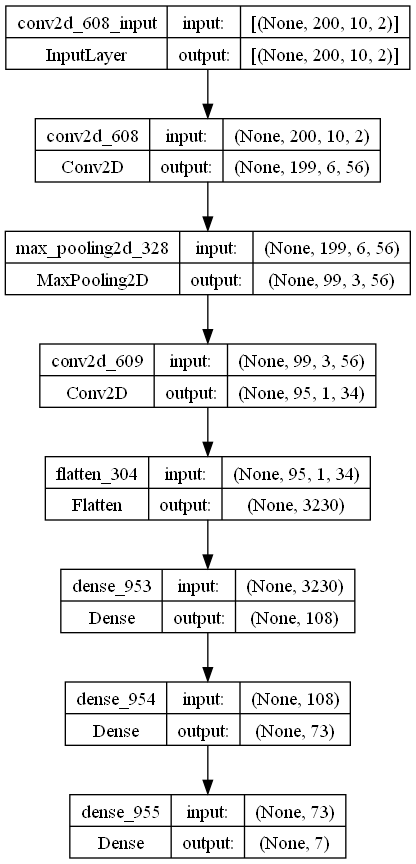

In [43]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [44]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [45]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [46]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [47]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [48]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

def adaptive_learning_rate(epoch):
    initial_lr = 0.001
    final_lr = 0.00001  # Updated final learning rate
    start_decay_epoch = 100
    end_decay_epoch = 1000
    
    if epoch < start_decay_epoch:
        return initial_lr
    elif epoch >= start_decay_epoch and epoch <= end_decay_epoch:
        lr_range = initial_lr - final_lr
        decay_epochs = end_decay_epoch - start_decay_epoch
        decay_per_epoch = lr_range / decay_epochs
        return initial_lr - (epoch - start_decay_epoch) * decay_per_epoch
    else:
        return final_lr
    

In [49]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_mean_metric', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(adaptive_learning_rate)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 2s 14ms/step - loss: 11.3345 - a_1: 2.7071 - a_2: 2.6906 - b_1: 2.4425 - b_2: 2.3278 - d_1: 2.0328 - d_2: 2.0669 - n: 1.5100 - mean_metric: 0.5216 - val_loss: 8.5578 - val_a_1: 2.6990 - val_a_2: 2.6184 - val_b_1: 2.2006 - val_b_2: 2.1272 - val_d_1: 1.6877 - val_d_2: 1.7252 - val_n: 1.4571 - val_mean_metric: 0.4770 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 1s 11ms/step - loss: 7.7314 - a_1: 2.6611 - a_2: 2.6021 - b_1: 2.2023 - b_2: 2.0211 - d_1: 1.4921 - d_2: 1.4796 - n: 1.4705 - mean_metric: 0.4603 - val_loss: 6.9149 - val_a_1: 2.6640 - val_a_2: 2.5857 - val_b_1: 2.0605 - val_b_2: 1.9653 - val_d_1: 1.2873 - val_d_2: 1.2291 - val_n: 1.4537 - val_mean_metric: 0.4353 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 1s 11ms/step - loss: 6.4131 - a_1: 2.6167 - a_2: 2.5632 - b_1: 1.9266 - b_2: 1.8460 - d_1: 1.1673 - d_2: 0.9935 - n: 1.4688 - mean_metric: 0.4158 - val_loss: 6.0198 - val_a_1: 2.656

70/70 [==============================] - 1s 12ms/step - loss: 3.9554 - a_1: 2.4240 - a_2: 2.4013 - b_1: 1.1938 - b_2: 1.1895 - d_1: 0.4820 - d_2: 0.4225 - n: 1.3824 - mean_metric: 0.3138 - val_loss: 4.0287 - val_a_1: 2.4771 - val_a_2: 2.4017 - val_b_1: 1.1742 - val_b_2: 1.1617 - val_d_1: 0.4994 - val_d_2: 0.3979 - val_n: 1.3644 - val_mean_metric: 0.3114 - lr: 0.0010
Epoch 23/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.9983 - a_1: 2.4337 - a_2: 2.4032 - b_1: 1.2210 - b_2: 1.1870 - d_1: 0.5057 - d_2: 0.4304 - n: 1.3850 - mean_metric: 0.3161 - val_loss: 3.9808 - val_a_1: 2.4593 - val_a_2: 2.3962 - val_b_1: 1.1710 - val_b_2: 1.1695 - val_d_1: 0.4518 - val_d_2: 0.4517 - val_n: 1.3567 - val_mean_metric: 0.3108 - lr: 0.0010
Epoch 24/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.9390 - a_1: 2.4126 - a_2: 2.3946 - b_1: 1.1879 - b_2: 1.1934 - d_1: 0.4774 - d_2: 0.4246 - n: 1.3743 - mean_metric: 0.3129 - val_loss: 4.1313 - val_a_1: 2.4900 - val_a_2:

70/70 [==============================] - 1s 11ms/step - loss: 3.5858 - a_1: 2.3079 - a_2: 2.2386 - b_1: 1.0507 - b_2: 1.0994 - d_1: 0.4009 - d_2: 0.3741 - n: 1.3591 - mean_metric: 0.2919 - val_loss: 3.7723 - val_a_1: 2.3997 - val_a_2: 2.3287 - val_b_1: 1.0474 - val_b_2: 1.0852 - val_d_1: 0.4072 - val_d_2: 0.3824 - val_n: 1.3409 - val_mean_metric: 0.2955 - lr: 0.0010
Epoch 44/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.6142 - a_1: 2.3030 - a_2: 2.2497 - b_1: 1.0723 - b_2: 1.0866 - d_1: 0.4350 - d_2: 0.4038 - n: 1.3569 - mean_metric: 0.2944 - val_loss: 3.7715 - val_a_1: 2.3896 - val_a_2: 2.3458 - val_b_1: 1.0463 - val_b_2: 1.0700 - val_d_1: 0.5406 - val_d_2: 0.3599 - val_n: 1.3587 - val_mean_metric: 0.2994 - lr: 0.0010
Epoch 45/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.5454 - a_1: 2.2953 - a_2: 2.2284 - b_1: 1.0371 - b_2: 1.0670 - d_1: 0.4045 - d_2: 0.3872 - n: 1.3530 - mean_metric: 0.2899 - val_loss: 3.7652 - val_a_1: 2.3929 - val_a_2:

70/70 [==============================] - 1s 11ms/step - loss: 3.3274 - a_1: 2.1550 - a_2: 2.1269 - b_1: 1.0162 - b_2: 1.0150 - d_1: 0.3831 - d_2: 0.3659 - n: 1.3366 - mean_metric: 0.2775 - val_loss: 3.5779 - val_a_1: 2.2583 - val_a_2: 2.2564 - val_b_1: 1.0519 - val_b_2: 1.0389 - val_d_1: 0.3608 - val_d_2: 0.3696 - val_n: 1.3271 - val_mean_metric: 0.2847 - lr: 0.0010
Epoch 65/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.3293 - a_1: 2.1552 - a_2: 2.1338 - b_1: 1.0029 - b_2: 1.0027 - d_1: 0.3910 - d_2: 0.3688 - n: 1.3341 - mean_metric: 0.2772 - val_loss: 3.6083 - val_a_1: 2.2555 - val_a_2: 2.2657 - val_b_1: 1.0347 - val_b_2: 1.0487 - val_d_1: 0.3976 - val_d_2: 0.4555 - val_n: 1.3273 - val_mean_metric: 0.2887 - lr: 0.0010
Epoch 66/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.3577 - a_1: 2.1552 - a_2: 2.1813 - b_1: 0.9948 - b_2: 1.0007 - d_1: 0.3856 - d_2: 0.3736 - n: 1.3371 - mean_metric: 0.2785 - val_loss: 3.8036 - val_a_1: 2.3072 - val_a_2:

70/70 [==============================] - 1s 11ms/step - loss: 3.1764 - a_1: 2.0814 - a_2: 2.0419 - b_1: 0.9578 - b_2: 0.9875 - d_1: 0.3663 - d_2: 0.3484 - n: 1.3228 - mean_metric: 0.2679 - val_loss: 3.5973 - val_a_1: 2.2231 - val_a_2: 2.2487 - val_b_1: 1.0202 - val_b_2: 1.0478 - val_d_1: 0.4349 - val_d_2: 0.4099 - val_n: 1.3218 - val_mean_metric: 0.2861 - lr: 0.0010
Epoch 86/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.1708 - a_1: 2.0758 - a_2: 2.0425 - b_1: 0.9824 - b_2: 0.9742 - d_1: 0.3704 - d_2: 0.3478 - n: 1.3248 - mean_metric: 0.2683 - val_loss: 3.5788 - val_a_1: 2.2182 - val_a_2: 2.2539 - val_b_1: 1.0431 - val_b_2: 1.0307 - val_d_1: 0.3816 - val_d_2: 0.3614 - val_n: 1.3192 - val_mean_metric: 0.2829 - lr: 0.0010
Epoch 87/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.1907 - a_1: 2.0731 - a_2: 2.0471 - b_1: 1.0067 - b_2: 0.9901 - d_1: 0.3709 - d_2: 0.3413 - n: 1.3250 - mean_metric: 0.2694 - val_loss: 3.6317 - val_a_1: 2.2283 - val_a_2:

70/70 [==============================] - 1s 11ms/step - loss: 3.1388 - a_1: 2.0443 - a_2: 1.9968 - b_1: 0.9621 - b_2: 0.9814 - d_1: 0.3959 - d_2: 0.3529 - n: 1.3158 - mean_metric: 0.2660 - val_loss: 3.9213 - val_a_1: 2.2674 - val_a_2: 2.3519 - val_b_1: 1.1321 - val_b_2: 1.1277 - val_d_1: 0.6222 - val_d_2: 0.4392 - val_n: 1.3317 - val_mean_metric: 0.3047 - lr: 9.9450e-04
Epoch 107/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.0962 - a_1: 2.0205 - a_2: 1.9768 - b_1: 0.9602 - b_2: 0.9732 - d_1: 0.3908 - d_2: 0.3523 - n: 1.3147 - mean_metric: 0.2640 - val_loss: 3.6769 - val_a_1: 2.2236 - val_a_2: 2.3004 - val_b_1: 1.0358 - val_b_2: 1.0480 - val_d_1: 0.5269 - val_d_2: 0.3392 - val_n: 1.3440 - val_mean_metric: 0.2898 - lr: 9.9340e-04
Epoch 108/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.0519 - a_1: 2.0216 - a_2: 1.9735 - b_1: 0.9308 - b_2: 0.9420 - d_1: 0.3625 - d_2: 0.3361 - n: 1.3161 - mean_metric: 0.2605 - val_loss: 3.6064 - val_a_1: 2.2303 

70/70 [==============================] - 1s 11ms/step - loss: 2.9734 - a_1: 1.9755 - a_2: 1.9095 - b_1: 0.9330 - b_2: 0.9463 - d_1: 0.3524 - d_2: 0.3272 - n: 1.3091 - mean_metric: 0.2563 - val_loss: 3.7859 - val_a_1: 2.2585 - val_a_2: 2.3593 - val_b_1: 1.0623 - val_b_2: 1.0540 - val_d_1: 0.4136 - val_d_2: 0.3183 - val_n: 1.3581 - val_mean_metric: 0.2900 - lr: 9.7140e-04
Epoch 128/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.9669 - a_1: 1.9483 - a_2: 1.9200 - b_1: 0.9422 - b_2: 0.9455 - d_1: 0.3421 - d_2: 0.3374 - n: 1.3078 - mean_metric: 0.2559 - val_loss: 3.6603 - val_a_1: 2.2391 - val_a_2: 2.2542 - val_b_1: 1.0669 - val_b_2: 1.0478 - val_d_1: 0.3941 - val_d_2: 0.3291 - val_n: 1.3339 - val_mean_metric: 0.2848 - lr: 9.7030e-04
Epoch 129/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.9739 - a_1: 1.9460 - a_2: 1.9087 - b_1: 0.9316 - b_2: 0.9762 - d_1: 0.3362 - d_2: 0.3446 - n: 1.3124 - mean_metric: 0.2564 - val_loss: 3.6528 - val_a_1: 2.2357 

70/70 [==============================] - 1s 11ms/step - loss: 2.9054 - a_1: 1.9082 - a_2: 1.8735 - b_1: 0.9293 - b_2: 0.9597 - d_1: 0.3454 - d_2: 0.3374 - n: 1.3023 - mean_metric: 0.2530 - val_loss: 3.6054 - val_a_1: 2.2479 - val_a_2: 2.1702 - val_b_1: 1.0358 - val_b_2: 1.0231 - val_d_1: 0.4245 - val_d_2: 0.3533 - val_n: 1.3227 - val_mean_metric: 0.2819 - lr: 9.4830e-04
Epoch 149/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.8925 - a_1: 1.9150 - a_2: 1.8513 - b_1: 0.9383 - b_2: 0.9327 - d_1: 0.3538 - d_2: 0.3430 - n: 1.3022 - mean_metric: 0.2524 - val_loss: 3.6599 - val_a_1: 2.2781 - val_a_2: 2.1874 - val_b_1: 1.0554 - val_b_2: 1.0090 - val_d_1: 0.3607 - val_d_2: 0.3182 - val_n: 1.3140 - val_mean_metric: 0.2800 - lr: 9.4720e-04
Epoch 150/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.8979 - a_1: 1.9188 - a_2: 1.8689 - b_1: 0.9304 - b_2: 0.9317 - d_1: 0.3393 - d_2: 0.3315 - n: 1.2996 - mean_metric: 0.2518 - val_loss: 3.7973 - val_a_1: 2.3112 

70/70 [==============================] - 1s 11ms/step - loss: 2.8078 - a_1: 1.8382 - a_2: 1.8269 - b_1: 0.9286 - b_2: 0.9261 - d_1: 0.3322 - d_2: 0.3269 - n: 1.2939 - mean_metric: 0.2470 - val_loss: 3.7175 - val_a_1: 2.2594 - val_a_2: 2.2609 - val_b_1: 1.0481 - val_b_2: 1.0166 - val_d_1: 0.3621 - val_d_2: 0.3505 - val_n: 1.3215 - val_mean_metric: 0.2832 - lr: 9.2520e-04
Epoch 170/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.7986 - a_1: 1.8514 - a_2: 1.8299 - b_1: 0.9112 - b_2: 0.8949 - d_1: 0.3381 - d_2: 0.3270 - n: 1.2965 - mean_metric: 0.2462 - val_loss: 3.6677 - val_a_1: 2.2729 - val_a_2: 2.2009 - val_b_1: 1.0279 - val_b_2: 1.0379 - val_d_1: 0.3908 - val_d_2: 0.3186 - val_n: 1.3188 - val_mean_metric: 0.2816 - lr: 9.2410e-04
Epoch 171/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.7934 - a_1: 1.8423 - a_2: 1.8131 - b_1: 0.9143 - b_2: 0.9157 - d_1: 0.3440 - d_2: 0.3295 - n: 1.2943 - mean_metric: 0.2464 - val_loss: 3.6282 - val_a_1: 2.2372 

70/70 [==============================] - 1s 11ms/step - loss: 2.7958 - a_1: 1.8402 - a_2: 1.7983 - b_1: 0.9223 - b_2: 0.9106 - d_1: 0.3439 - d_2: 0.3415 - n: 1.2909 - mean_metric: 0.2461 - val_loss: 3.7931 - val_a_1: 2.3223 - val_a_2: 2.1895 - val_b_1: 1.0229 - val_b_2: 1.1118 - val_d_1: 0.3795 - val_d_2: 0.3412 - val_n: 1.3165 - val_mean_metric: 0.2853 - lr: 9.0210e-04
Epoch 191/1000
70/70 [==============================] - 1s 12ms/step - loss: 2.7660 - a_1: 1.8198 - a_2: 1.7929 - b_1: 0.9180 - b_2: 0.8991 - d_1: 0.3423 - d_2: 0.3521 - n: 1.2945 - mean_metric: 0.2452 - val_loss: 3.7155 - val_a_1: 2.2856 - val_a_2: 2.1793 - val_b_1: 1.0336 - val_b_2: 1.0766 - val_d_1: 0.3601 - val_d_2: 0.3370 - val_n: 1.3139 - val_mean_metric: 0.2821 - lr: 9.0100e-04
Epoch 192/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.7796 - a_1: 1.8169 - a_2: 1.7914 - b_1: 0.9282 - b_2: 0.9013 - d_1: 0.3528 - d_2: 0.3379 - n: 1.2921 - mean_metric: 0.2453 - val_loss: 3.7103 - val_a_1: 2.2523 

70/70 [==============================] - 1s 12ms/step - loss: 2.6918 - a_1: 1.7821 - a_2: 1.7424 - b_1: 0.8909 - b_2: 0.9036 - d_1: 0.3375 - d_2: 0.3389 - n: 1.2861 - mean_metric: 0.2406 - val_loss: 3.7574 - val_a_1: 2.2544 - val_a_2: 2.2213 - val_b_1: 1.0465 - val_b_2: 1.0998 - val_d_1: 0.3654 - val_d_2: 0.3410 - val_n: 1.3150 - val_mean_metric: 0.2840 - lr: 8.7900e-04
Epoch 212/1000
70/70 [==============================] - 1s 12ms/step - loss: 2.6877 - a_1: 1.7727 - a_2: 1.7418 - b_1: 0.8949 - b_2: 0.9009 - d_1: 0.3394 - d_2: 0.3352 - n: 1.2866 - mean_metric: 0.2403 - val_loss: 3.7560 - val_a_1: 2.2625 - val_a_2: 2.2097 - val_b_1: 1.0383 - val_b_2: 1.0888 - val_d_1: 0.3829 - val_d_2: 0.3164 - val_n: 1.3164 - val_mean_metric: 0.2831 - lr: 8.7790e-04
Epoch 213/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.6744 - a_1: 1.7595 - a_2: 1.7467 - b_1: 0.8950 - b_2: 0.8833 - d_1: 0.3416 - d_2: 0.3307 - n: 1.2849 - mean_metric: 0.2392 - val_loss: 3.7714 - val_a_1: 2.2745 

70/70 [==============================] - 1s 11ms/step - loss: 2.6297 - a_1: 1.7264 - a_2: 1.7128 - b_1: 0.8868 - b_2: 0.8750 - d_1: 0.3424 - d_2: 0.3303 - n: 1.2831 - mean_metric: 0.2365 - val_loss: 3.8699 - val_a_1: 2.3065 - val_a_2: 2.2237 - val_b_1: 1.1325 - val_b_2: 1.0825 - val_d_1: 0.3670 - val_d_2: 0.3285 - val_n: 1.3086 - val_mean_metric: 0.2875 - lr: 8.5590e-04
Epoch 233/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.6129 - a_1: 1.7322 - a_2: 1.6945 - b_1: 0.8818 - b_2: 0.8908 - d_1: 0.3379 - d_2: 0.3283 - n: 1.2802 - mean_metric: 0.2362 - val_loss: 3.8050 - val_a_1: 2.2889 - val_a_2: 2.2153 - val_b_1: 1.0542 - val_b_2: 1.0603 - val_d_1: 0.3619 - val_d_2: 0.3349 - val_n: 1.3076 - val_mean_metric: 0.2834 - lr: 8.5480e-04
Epoch 234/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.6471 - a_1: 1.7531 - a_2: 1.6977 - b_1: 0.8918 - b_2: 0.8975 - d_1: 0.3365 - d_2: 0.3250 - n: 1.2805 - mean_metric: 0.2374 - val_loss: 3.7494 - val_a_1: 2.2520 

70/70 [==============================] - 1s 11ms/step - loss: 2.5704 - a_1: 1.7018 - a_2: 1.6623 - b_1: 0.8782 - b_2: 0.8729 - d_1: 0.3305 - d_2: 0.3258 - n: 1.2774 - mean_metric: 0.2330 - val_loss: 3.7939 - val_a_1: 2.2666 - val_a_2: 2.2036 - val_b_1: 1.0739 - val_b_2: 1.0085 - val_d_1: 0.3564 - val_d_2: 0.3431 - val_n: 1.3071 - val_mean_metric: 0.2812 - lr: 8.3280e-04
Epoch 254/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.5716 - a_1: 1.6958 - a_2: 1.6593 - b_1: 0.8893 - b_2: 0.8834 - d_1: 0.3356 - d_2: 0.3266 - n: 1.2780 - mean_metric: 0.2336 - val_loss: 3.8275 - val_a_1: 2.2712 - val_a_2: 2.2454 - val_b_1: 1.0806 - val_b_2: 1.0503 - val_d_1: 0.3654 - val_d_2: 0.3383 - val_n: 1.3196 - val_mean_metric: 0.2849 - lr: 8.3170e-04
Epoch 255/1000
70/70 [==============================] - 1s 12ms/step - loss: 2.5827 - a_1: 1.6977 - a_2: 1.6611 - b_1: 0.9045 - b_2: 0.8835 - d_1: 0.3291 - d_2: 0.3316 - n: 1.2794 - mean_metric: 0.2342 - val_loss: 3.8558 - val_a_1: 2.3143 

70/70 [==============================] - 1s 11ms/step - loss: 2.5469 - a_1: 1.6898 - a_2: 1.6206 - b_1: 0.8935 - b_2: 0.8729 - d_1: 0.3343 - d_2: 0.3349 - n: 1.2745 - mean_metric: 0.2320 - val_loss: 3.8855 - val_a_1: 2.3103 - val_a_2: 2.2144 - val_b_1: 1.1177 - val_b_2: 1.0227 - val_d_1: 0.3481 - val_d_2: 0.3574 - val_n: 1.3145 - val_mean_metric: 0.2854 - lr: 8.0970e-04
Epoch 275/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.5638 - a_1: 1.6885 - a_2: 1.6414 - b_1: 0.9073 - b_2: 0.8772 - d_1: 0.3375 - d_2: 0.3310 - n: 1.2719 - mean_metric: 0.2331 - val_loss: 3.9264 - val_a_1: 2.3239 - val_a_2: 2.2298 - val_b_1: 1.1198 - val_b_2: 1.0608 - val_d_1: 0.3589 - val_d_2: 0.3620 - val_n: 1.3145 - val_mean_metric: 0.2882 - lr: 8.0860e-04
Epoch 276/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.5785 - a_1: 1.7023 - a_2: 1.6404 - b_1: 0.9063 - b_2: 0.8783 - d_1: 0.3352 - d_2: 0.3263 - n: 1.2726 - mean_metric: 0.2334 - val_loss: 3.8973 - val_a_1: 2.2922 

70/70 [==============================] - 1s 11ms/step - loss: 2.5163 - a_1: 1.6492 - a_2: 1.6406 - b_1: 0.8866 - b_2: 0.8736 - d_1: 0.3288 - d_2: 0.3238 - n: 1.2684 - mean_metric: 0.2303 - val_loss: 3.9189 - val_a_1: 2.2751 - val_a_2: 2.3209 - val_b_1: 1.0769 - val_b_2: 1.0213 - val_d_1: 0.3562 - val_d_2: 0.3255 - val_n: 1.3341 - val_mean_metric: 0.2862 - lr: 7.8660e-04
Epoch 296/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.5246 - a_1: 1.6558 - a_2: 1.6293 - b_1: 0.8831 - b_2: 0.8883 - d_1: 0.3307 - d_2: 0.3359 - n: 1.2676 - mean_metric: 0.2310 - val_loss: 3.8812 - val_a_1: 2.2980 - val_a_2: 2.2558 - val_b_1: 1.0779 - val_b_2: 1.0224 - val_d_1: 0.3494 - val_d_2: 0.3355 - val_n: 1.3313 - val_mean_metric: 0.2849 - lr: 7.8550e-04
Epoch 297/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.5068 - a_1: 1.6552 - a_2: 1.5999 - b_1: 0.8941 - b_2: 0.8826 - d_1: 0.3304 - d_2: 0.3247 - n: 1.2692 - mean_metric: 0.2299 - val_loss: 4.0621 - val_a_1: 2.3300 

70/70 [==============================] - 1s 12ms/step - loss: 2.4654 - a_1: 1.6279 - a_2: 1.5778 - b_1: 0.8804 - b_2: 0.8698 - d_1: 0.3341 - d_2: 0.3303 - n: 1.2632 - mean_metric: 0.2275 - val_loss: 3.9566 - val_a_1: 2.3158 - val_a_2: 2.2698 - val_b_1: 1.1063 - val_b_2: 1.0157 - val_d_1: 0.3463 - val_d_2: 0.3307 - val_n: 1.3371 - val_mean_metric: 0.2866 - lr: 7.6350e-04
Epoch 317/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.4730 - a_1: 1.6304 - a_2: 1.5771 - b_1: 0.8755 - b_2: 0.8771 - d_1: 0.3342 - d_2: 0.3218 - n: 1.2645 - mean_metric: 0.2273 - val_loss: 4.0356 - val_a_1: 2.3342 - val_a_2: 2.3250 - val_b_1: 1.0962 - val_b_2: 1.0439 - val_d_1: 0.3464 - val_d_2: 0.3196 - val_n: 1.3236 - val_mean_metric: 0.2888 - lr: 7.6240e-04
Epoch 318/1000
70/70 [==============================] - 1s 12ms/step - loss: 2.4614 - a_1: 1.6215 - a_2: 1.5716 - b_1: 0.8814 - b_2: 0.8809 - d_1: 0.3277 - d_2: 0.3192 - n: 1.2644 - mean_metric: 0.2270 - val_loss: 4.0438 - val_a_1: 2.3765 

70/70 [==============================] - 1s 11ms/step - loss: 2.5302 - a_1: 1.6275 - a_2: 1.6317 - b_1: 0.8882 - b_2: 0.8823 - d_1: 0.3383 - d_2: 0.3436 - n: 1.2608 - mean_metric: 0.2304 - val_loss: 4.1190 - val_a_1: 2.3252 - val_a_2: 2.3822 - val_b_1: 1.0788 - val_b_2: 1.0619 - val_d_1: 0.4066 - val_d_2: 0.3426 - val_n: 1.3474 - val_mean_metric: 0.2939 - lr: 7.4040e-04
Epoch 338/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.5461 - a_1: 1.6216 - a_2: 1.6432 - b_1: 0.8913 - b_2: 0.8796 - d_1: 0.3341 - d_2: 0.3452 - n: 1.2661 - mean_metric: 0.2307 - val_loss: 4.0970 - val_a_1: 2.3248 - val_a_2: 2.3761 - val_b_1: 1.0746 - val_b_2: 1.0482 - val_d_1: 0.3820 - val_d_2: 0.3414 - val_n: 1.3426 - val_mean_metric: 0.2922 - lr: 7.3930e-04
Epoch 339/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.5741 - a_1: 1.6440 - a_2: 1.6477 - b_1: 0.8992 - b_2: 0.8843 - d_1: 0.3382 - d_2: 0.3554 - n: 1.2612 - mean_metric: 0.2323 - val_loss: 4.1145 - val_a_1: 2.3006 

70/70 [==============================] - 1s 11ms/step - loss: 2.4543 - a_1: 1.6009 - a_2: 1.5678 - b_1: 0.8689 - b_2: 0.8755 - d_1: 0.3378 - d_2: 0.3321 - n: 1.2521 - mean_metric: 0.2259 - val_loss: 3.9960 - val_a_1: 2.3368 - val_a_2: 2.2508 - val_b_1: 1.0530 - val_b_2: 1.0474 - val_d_1: 0.3902 - val_d_2: 0.3529 - val_n: 1.3409 - val_mean_metric: 0.2883 - lr: 7.1730e-04
Epoch 359/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.4700 - a_1: 1.6146 - a_2: 1.5783 - b_1: 0.8765 - b_2: 0.8814 - d_1: 0.3506 - d_2: 0.3288 - n: 1.2522 - mean_metric: 0.2274 - val_loss: 4.0010 - val_a_1: 2.3452 - val_a_2: 2.2564 - val_b_1: 1.0513 - val_b_2: 1.0421 - val_d_1: 0.3687 - val_d_2: 0.3624 - val_n: 1.3405 - val_mean_metric: 0.2881 - lr: 7.1620e-04
Epoch 360/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.4606 - a_1: 1.6126 - a_2: 1.5527 - b_1: 0.8791 - b_2: 0.8863 - d_1: 0.3393 - d_2: 0.3259 - n: 1.2543 - mean_metric: 0.2264 - val_loss: 4.0144 - val_a_1: 2.3357 

70/70 [==============================] - 1s 11ms/step - loss: 2.4999 - a_1: 1.6431 - a_2: 1.5618 - b_1: 0.8806 - b_2: 0.8940 - d_1: 0.3495 - d_2: 0.3392 - n: 1.2526 - mean_metric: 0.2288 - val_loss: 4.0395 - val_a_1: 2.3322 - val_a_2: 2.3061 - val_b_1: 1.0592 - val_b_2: 1.0572 - val_d_1: 0.4006 - val_d_2: 0.3521 - val_n: 1.3470 - val_mean_metric: 0.2910 - lr: 6.9420e-04
Epoch 380/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.4923 - a_1: 1.6164 - a_2: 1.5761 - b_1: 0.8718 - b_2: 0.8978 - d_1: 0.3449 - d_2: 0.3393 - n: 1.2554 - mean_metric: 0.2281 - val_loss: 4.0615 - val_a_1: 2.3294 - val_a_2: 2.3194 - val_b_1: 1.0431 - val_b_2: 1.0551 - val_d_1: 0.3725 - val_d_2: 0.3870 - val_n: 1.3398 - val_mean_metric: 0.2907 - lr: 6.9310e-04
Epoch 381/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.4702 - a_1: 1.6011 - a_2: 1.5600 - b_1: 0.8725 - b_2: 0.8930 - d_1: 0.3402 - d_2: 0.3374 - n: 1.2535 - mean_metric: 0.2266 - val_loss: 4.0207 - val_a_1: 2.3135 

70/70 [==============================] - 1s 11ms/step - loss: 2.3573 - a_1: 1.5455 - a_2: 1.5002 - b_1: 0.8582 - b_2: 0.8632 - d_1: 0.3323 - d_2: 0.3303 - n: 1.2439 - mean_metric: 0.2206 - val_loss: 4.0105 - val_a_1: 2.3198 - val_a_2: 2.2858 - val_b_1: 1.0434 - val_b_2: 1.0347 - val_d_1: 0.3650 - val_d_2: 0.3611 - val_n: 1.3372 - val_mean_metric: 0.2875 - lr: 6.7110e-04
Epoch 401/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.3423 - a_1: 1.5352 - a_2: 1.4913 - b_1: 0.8488 - b_2: 0.8619 - d_1: 0.3336 - d_2: 0.3303 - n: 1.2405 - mean_metric: 0.2195 - val_loss: 4.0299 - val_a_1: 2.3132 - val_a_2: 2.3075 - val_b_1: 1.0637 - val_b_2: 1.0487 - val_d_1: 0.3496 - val_d_2: 0.3477 - val_n: 1.3304 - val_mean_metric: 0.2879 - lr: 6.7000e-04
Epoch 402/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.3427 - a_1: 1.5322 - a_2: 1.4982 - b_1: 0.8540 - b_2: 0.8654 - d_1: 0.3287 - d_2: 0.3227 - n: 1.2414 - mean_metric: 0.2195 - val_loss: 4.0229 - val_a_1: 2.3080 

70/70 [==============================] - 1s 11ms/step - loss: 2.3273 - a_1: 1.5228 - a_2: 1.4665 - b_1: 0.8640 - b_2: 0.8698 - d_1: 0.3326 - d_2: 0.3295 - n: 1.2383 - mean_metric: 0.2189 - val_loss: 4.0962 - val_a_1: 2.3375 - val_a_2: 2.3374 - val_b_1: 1.0570 - val_b_2: 1.0376 - val_d_1: 0.3535 - val_d_2: 0.3658 - val_n: 1.3346 - val_mean_metric: 0.2900 - lr: 6.4800e-04
Epoch 422/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.3173 - a_1: 1.5142 - a_2: 1.4759 - b_1: 0.8528 - b_2: 0.8606 - d_1: 0.3312 - d_2: 0.3269 - n: 1.2366 - mean_metric: 0.2181 - val_loss: 4.0808 - val_a_1: 2.3193 - val_a_2: 2.3191 - val_b_1: 1.0628 - val_b_2: 1.0379 - val_d_1: 0.3583 - val_d_2: 0.3606 - val_n: 1.3413 - val_mean_metric: 0.2892 - lr: 6.4690e-04
Epoch 423/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.3453 - a_1: 1.5321 - a_2: 1.4712 - b_1: 0.8738 - b_2: 0.8676 - d_1: 0.3356 - d_2: 0.3303 - n: 1.2399 - mean_metric: 0.2198 - val_loss: 4.0929 - val_a_1: 2.3220 

70/70 [==============================] - 1s 11ms/step - loss: 2.2942 - a_1: 1.4908 - a_2: 1.4529 - b_1: 0.8590 - b_2: 0.8614 - d_1: 0.3339 - d_2: 0.3273 - n: 1.2354 - mean_metric: 0.2168 - val_loss: 4.1093 - val_a_1: 2.3267 - val_a_2: 2.3119 - val_b_1: 1.0577 - val_b_2: 1.0699 - val_d_1: 0.3616 - val_d_2: 0.3903 - val_n: 1.3412 - val_mean_metric: 0.2912 - lr: 6.2490e-04
Epoch 443/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.2963 - a_1: 1.4978 - a_2: 1.4555 - b_1: 0.8621 - b_2: 0.8522 - d_1: 0.3305 - d_2: 0.3236 - n: 1.2321 - mean_metric: 0.2166 - val_loss: 4.1487 - val_a_1: 2.3292 - val_a_2: 2.3694 - val_b_1: 1.0383 - val_b_2: 1.0840 - val_d_1: 0.3608 - val_d_2: 0.4002 - val_n: 1.3434 - val_mean_metric: 0.2933 - lr: 6.2380e-04
Epoch 444/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.2928 - a_1: 1.5020 - a_2: 1.4534 - b_1: 0.8586 - b_2: 0.8502 - d_1: 0.3269 - d_2: 0.3310 - n: 1.2315 - mean_metric: 0.2165 - val_loss: 4.0818 - val_a_1: 2.3224 

70/70 [==============================] - 1s 11ms/step - loss: 2.3834 - a_1: 1.5216 - a_2: 1.5141 - b_1: 0.8858 - b_2: 0.8745 - d_1: 0.3383 - d_2: 0.3431 - n: 1.2325 - mean_metric: 0.2218 - val_loss: 4.1763 - val_a_1: 2.3654 - val_a_2: 2.3301 - val_b_1: 1.0874 - val_b_2: 1.0440 - val_d_1: 0.3656 - val_d_2: 0.4007 - val_n: 1.3319 - val_mean_metric: 0.2933 - lr: 6.0180e-04
Epoch 464/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.3780 - a_1: 1.5210 - a_2: 1.5060 - b_1: 0.8813 - b_2: 0.8704 - d_1: 0.3386 - d_2: 0.3531 - n: 1.2354 - mean_metric: 0.2216 - val_loss: 4.2482 - val_a_1: 2.3929 - val_a_2: 2.3516 - val_b_1: 1.0918 - val_b_2: 1.0609 - val_d_1: 0.3680 - val_d_2: 0.3759 - val_n: 1.3373 - val_mean_metric: 0.2950 - lr: 6.0070e-04
Epoch 465/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.3984 - a_1: 1.5192 - a_2: 1.5225 - b_1: 0.8919 - b_2: 0.8784 - d_1: 0.3424 - d_2: 0.3431 - n: 1.2328 - mean_metric: 0.2224 - val_loss: 4.2223 - val_a_1: 2.3794 

70/70 [==============================] - 1s 11ms/step - loss: 2.2896 - a_1: 1.4773 - a_2: 1.4458 - b_1: 0.8629 - b_2: 0.8577 - d_1: 0.3356 - d_2: 0.3280 - n: 1.2298 - mean_metric: 0.2160 - val_loss: 4.1110 - val_a_1: 2.3566 - val_a_2: 2.2827 - val_b_1: 1.0522 - val_b_2: 1.0402 - val_d_1: 0.3454 - val_d_2: 0.3389 - val_n: 1.3511 - val_mean_metric: 0.2881 - lr: 5.7870e-04
Epoch 485/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.3295 - a_1: 1.5095 - a_2: 1.4594 - b_1: 0.8686 - b_2: 0.8754 - d_1: 0.3356 - d_2: 0.3297 - n: 1.2318 - mean_metric: 0.2184 - val_loss: 4.1254 - val_a_1: 2.3767 - val_a_2: 2.2980 - val_b_1: 1.0601 - val_b_2: 1.0305 - val_d_1: 0.3518 - val_d_2: 0.3345 - val_n: 1.3442 - val_mean_metric: 0.2891 - lr: 5.7760e-04
Epoch 486/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.3011 - a_1: 1.4862 - a_2: 1.4523 - b_1: 0.8583 - b_2: 0.8605 - d_1: 0.3334 - d_2: 0.3386 - n: 1.2316 - mean_metric: 0.2168 - val_loss: 4.1314 - val_a_1: 2.3494 

70/70 [==============================] - 1s 11ms/step - loss: 2.2498 - a_1: 1.4637 - a_2: 1.4076 - b_1: 0.8583 - b_2: 0.8580 - d_1: 0.3384 - d_2: 0.3316 - n: 1.2265 - mean_metric: 0.2143 - val_loss: 4.1623 - val_a_1: 2.3407 - val_a_2: 2.3422 - val_b_1: 1.0591 - val_b_2: 1.0520 - val_d_1: 0.3741 - val_d_2: 0.3363 - val_n: 1.3495 - val_mean_metric: 0.2910 - lr: 5.5560e-04
Epoch 506/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.2323 - a_1: 1.4508 - a_2: 1.4072 - b_1: 0.8508 - b_2: 0.8556 - d_1: 0.3370 - d_2: 0.3268 - n: 1.2236 - mean_metric: 0.2132 - val_loss: 4.2073 - val_a_1: 2.3683 - val_a_2: 2.3355 - val_b_1: 1.0641 - val_b_2: 1.0467 - val_d_1: 0.3910 - val_d_2: 0.3413 - val_n: 1.3425 - val_mean_metric: 0.2921 - lr: 5.5450e-04
Epoch 507/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.2364 - a_1: 1.4660 - a_2: 1.4133 - b_1: 0.8422 - b_2: 0.8471 - d_1: 0.3382 - d_2: 0.3268 - n: 1.2254 - mean_metric: 0.2134 - val_loss: 4.1414 - val_a_1: 2.3508 

70/70 [==============================] - 1s 11ms/step - loss: 2.2000 - a_1: 1.4243 - a_2: 1.3985 - b_1: 0.8377 - b_2: 0.8479 - d_1: 0.3359 - d_2: 0.3245 - n: 1.2236 - mean_metric: 0.2112 - val_loss: 4.2012 - val_a_1: 2.3907 - val_a_2: 2.3369 - val_b_1: 1.0666 - val_b_2: 1.0353 - val_d_1: 0.3815 - val_d_2: 0.3284 - val_n: 1.3504 - val_mean_metric: 0.2922 - lr: 5.3250e-04
Epoch 527/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.2113 - a_1: 1.4305 - a_2: 1.3997 - b_1: 0.8464 - b_2: 0.8427 - d_1: 0.3320 - d_2: 0.3234 - n: 1.2234 - mean_metric: 0.2114 - val_loss: 4.1990 - val_a_1: 2.3755 - val_a_2: 2.3292 - val_b_1: 1.0549 - val_b_2: 1.0422 - val_d_1: 0.3709 - val_d_2: 0.3281 - val_n: 1.3522 - val_mean_metric: 0.2910 - lr: 5.3140e-04
Epoch 528/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.2225 - a_1: 1.4339 - a_2: 1.4162 - b_1: 0.8444 - b_2: 0.8556 - d_1: 0.3343 - d_2: 0.3261 - n: 1.2237 - mean_metric: 0.2126 - val_loss: 4.2115 - val_a_1: 2.3837 

70/70 [==============================] - 1s 11ms/step - loss: 2.1918 - a_1: 1.4083 - a_2: 1.3872 - b_1: 0.8356 - b_2: 0.8556 - d_1: 0.3345 - d_2: 0.3262 - n: 1.2230 - mean_metric: 0.2105 - val_loss: 4.2319 - val_a_1: 2.3920 - val_a_2: 2.3356 - val_b_1: 1.0735 - val_b_2: 1.0409 - val_d_1: 0.3953 - val_d_2: 0.3313 - val_n: 1.3489 - val_mean_metric: 0.2931 - lr: 5.0940e-04
Epoch 548/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.2005 - a_1: 1.4162 - a_2: 1.4001 - b_1: 0.8386 - b_2: 0.8528 - d_1: 0.3373 - d_2: 0.3280 - n: 1.2236 - mean_metric: 0.2114 - val_loss: 4.2855 - val_a_1: 2.4148 - val_a_2: 2.3345 - val_b_1: 1.0717 - val_b_2: 1.0442 - val_d_1: 0.4235 - val_d_2: 0.3329 - val_n: 1.3546 - val_mean_metric: 0.2950 - lr: 5.0830e-04
Epoch 549/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.1985 - a_1: 1.4274 - a_2: 1.3789 - b_1: 0.8414 - b_2: 0.8487 - d_1: 0.3404 - d_2: 0.3210 - n: 1.2202 - mean_metric: 0.2108 - val_loss: 4.2471 - val_a_1: 2.3973 

70/70 [==============================] - 1s 11ms/step - loss: 2.1879 - a_1: 1.4058 - a_2: 1.3889 - b_1: 0.8412 - b_2: 0.8548 - d_1: 0.3390 - d_2: 0.3316 - n: 1.2242 - mean_metric: 0.2110 - val_loss: 4.2424 - val_a_1: 2.3986 - val_a_2: 2.3239 - val_b_1: 1.0810 - val_b_2: 1.0471 - val_d_1: 0.3783 - val_d_2: 0.3274 - val_n: 1.3543 - val_mean_metric: 0.2928 - lr: 4.8630e-04
Epoch 569/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.1873 - a_1: 1.3985 - a_2: 1.3872 - b_1: 0.8401 - b_2: 0.8557 - d_1: 0.3374 - d_2: 0.3306 - n: 1.2203 - mean_metric: 0.2105 - val_loss: 4.2569 - val_a_1: 2.3980 - val_a_2: 2.3260 - val_b_1: 1.0666 - val_b_2: 1.0456 - val_d_1: 0.3875 - val_d_2: 0.3421 - val_n: 1.3584 - val_mean_metric: 0.2933 - lr: 4.8520e-04
Epoch 570/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.1949 - a_1: 1.3967 - a_2: 1.3929 - b_1: 0.8407 - b_2: 0.8684 - d_1: 0.3416 - d_2: 0.3317 - n: 1.2203 - mean_metric: 0.2113 - val_loss: 4.2993 - val_a_1: 2.4260 

70/70 [==============================] - 1s 11ms/step - loss: 2.1500 - a_1: 1.3702 - a_2: 1.3620 - b_1: 0.8349 - b_2: 0.8579 - d_1: 0.3394 - d_2: 0.3265 - n: 1.2188 - mean_metric: 0.2085 - val_loss: 4.2606 - val_a_1: 2.3983 - val_a_2: 2.3216 - val_b_1: 1.0899 - val_b_2: 1.0760 - val_d_1: 0.4055 - val_d_2: 0.3382 - val_n: 1.3633 - val_mean_metric: 0.2955 - lr: 4.6320e-04
Epoch 590/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.1485 - a_1: 1.3758 - a_2: 1.3633 - b_1: 0.8342 - b_2: 0.8480 - d_1: 0.3394 - d_2: 0.3216 - n: 1.2189 - mean_metric: 0.2082 - val_loss: 4.2585 - val_a_1: 2.4069 - val_a_2: 2.3119 - val_b_1: 1.0874 - val_b_2: 1.0472 - val_d_1: 0.3908 - val_d_2: 0.3445 - val_n: 1.3633 - val_mean_metric: 0.2942 - lr: 4.6210e-04
Epoch 591/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.1341 - a_1: 1.3738 - a_2: 1.3523 - b_1: 0.8290 - b_2: 0.8399 - d_1: 0.3399 - d_2: 0.3232 - n: 1.2170 - mean_metric: 0.2073 - val_loss: 4.2386 - val_a_1: 2.3813 

70/70 [==============================] - 1s 11ms/step - loss: 2.1165 - a_1: 1.3707 - a_2: 1.3308 - b_1: 0.8338 - b_2: 0.8397 - d_1: 0.3420 - d_2: 0.3187 - n: 1.2176 - mean_metric: 0.2067 - val_loss: 4.2746 - val_a_1: 2.4256 - val_a_2: 2.3184 - val_b_1: 1.0810 - val_b_2: 1.0420 - val_d_1: 0.3999 - val_d_2: 0.3331 - val_n: 1.3615 - val_mean_metric: 0.2945 - lr: 4.4010e-04
Epoch 611/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.0996 - a_1: 1.3496 - a_2: 1.3301 - b_1: 0.8350 - b_2: 0.8310 - d_1: 0.3412 - d_2: 0.3167 - n: 1.2154 - mean_metric: 0.2055 - val_loss: 4.2662 - val_a_1: 2.4063 - val_a_2: 2.3221 - val_b_1: 1.0931 - val_b_2: 1.0606 - val_d_1: 0.3970 - val_d_2: 0.3312 - val_n: 1.3651 - val_mean_metric: 0.2950 - lr: 4.3900e-04
Epoch 612/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.1057 - a_1: 1.3532 - a_2: 1.3319 - b_1: 0.8319 - b_2: 0.8368 - d_1: 0.3366 - d_2: 0.3195 - n: 1.2157 - mean_metric: 0.2057 - val_loss: 4.2638 - val_a_1: 2.4103 

70/70 [==============================] - 1s 11ms/step - loss: 2.1142 - a_1: 1.3660 - a_2: 1.3384 - b_1: 0.8279 - b_2: 0.8315 - d_1: 0.3370 - d_2: 0.3233 - n: 1.2155 - mean_metric: 0.2062 - val_loss: 4.3027 - val_a_1: 2.4187 - val_a_2: 2.3338 - val_b_1: 1.0802 - val_b_2: 1.0691 - val_d_1: 0.3725 - val_d_2: 0.3306 - val_n: 1.3821 - val_mean_metric: 0.2953 - lr: 4.1700e-04
Epoch 632/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.1109 - a_1: 1.3581 - a_2: 1.3365 - b_1: 0.8331 - b_2: 0.8339 - d_1: 0.3400 - d_2: 0.3256 - n: 1.2165 - mean_metric: 0.2063 - val_loss: 4.2906 - val_a_1: 2.4185 - val_a_2: 2.3239 - val_b_1: 1.0864 - val_b_2: 1.0600 - val_d_1: 0.4029 - val_d_2: 0.3277 - val_n: 1.3765 - val_mean_metric: 0.2956 - lr: 4.1590e-04
Epoch 633/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.1145 - a_1: 1.3554 - a_2: 1.3451 - b_1: 0.8303 - b_2: 0.8328 - d_1: 0.3411 - d_2: 0.3249 - n: 1.2156 - mean_metric: 0.2063 - val_loss: 4.2971 - val_a_1: 2.4271 

70/70 [==============================] - 1s 11ms/step - loss: 2.1283 - a_1: 1.3581 - a_2: 1.3660 - b_1: 0.8302 - b_2: 0.8276 - d_1: 0.3395 - d_2: 0.3210 - n: 1.2167 - mean_metric: 0.2068 - val_loss: 4.3832 - val_a_1: 2.4721 - val_a_2: 2.3490 - val_b_1: 1.0942 - val_b_2: 1.0630 - val_d_1: 0.3707 - val_d_2: 0.3345 - val_n: 1.3837 - val_mean_metric: 0.2980 - lr: 3.9390e-04
Epoch 653/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.1383 - a_1: 1.3661 - a_2: 1.3745 - b_1: 0.8350 - b_2: 0.8245 - d_1: 0.3413 - d_2: 0.3192 - n: 1.2140 - mean_metric: 0.2073 - val_loss: 4.3717 - val_a_1: 2.4589 - val_a_2: 2.3557 - val_b_1: 1.0979 - val_b_2: 1.0636 - val_d_1: 0.3869 - val_d_2: 0.3483 - val_n: 1.3761 - val_mean_metric: 0.2986 - lr: 3.9280e-04
Epoch 654/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.1783 - a_1: 1.3784 - a_2: 1.4061 - b_1: 0.8364 - b_2: 0.8447 - d_1: 0.3403 - d_2: 0.3238 - n: 1.2129 - mean_metric: 0.2095 - val_loss: 4.3752 - val_a_1: 2.4681 

70/70 [==============================] - 1s 11ms/step - loss: 2.1366 - a_1: 1.3602 - a_2: 1.3573 - b_1: 0.8241 - b_2: 0.8605 - d_1: 0.3316 - d_2: 0.3248 - n: 1.2141 - mean_metric: 0.2073 - val_loss: 4.3422 - val_a_1: 2.3962 - val_a_2: 2.3907 - val_b_1: 1.0863 - val_b_2: 1.0718 - val_d_1: 0.3662 - val_d_2: 0.3345 - val_n: 1.3648 - val_mean_metric: 0.2961 - lr: 3.7080e-04
Epoch 674/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.1454 - a_1: 1.3600 - a_2: 1.3753 - b_1: 0.8278 - b_2: 0.8555 - d_1: 0.3287 - d_2: 0.3227 - n: 1.2162 - mean_metric: 0.2077 - val_loss: 4.3548 - val_a_1: 2.3964 - val_a_2: 2.3920 - val_b_1: 1.0897 - val_b_2: 1.0743 - val_d_1: 0.3690 - val_d_2: 0.3362 - val_n: 1.3651 - val_mean_metric: 0.2965 - lr: 3.6970e-04
Epoch 675/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.1163 - a_1: 1.3346 - a_2: 1.3607 - b_1: 0.8209 - b_2: 0.8538 - d_1: 0.3294 - d_2: 0.3258 - n: 1.2156 - mean_metric: 0.2062 - val_loss: 4.3241 - val_a_1: 2.3921 

70/70 [==============================] - 1s 11ms/step - loss: 2.0746 - a_1: 1.3246 - a_2: 1.3271 - b_1: 0.8204 - b_2: 0.8382 - d_1: 0.3270 - d_2: 0.3182 - n: 1.2098 - mean_metric: 0.2038 - val_loss: 4.3667 - val_a_1: 2.4119 - val_a_2: 2.3875 - val_b_1: 1.0935 - val_b_2: 1.0659 - val_d_1: 0.3676 - val_d_2: 0.3257 - val_n: 1.3668 - val_mean_metric: 0.2964 - lr: 3.4770e-04
Epoch 695/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.0633 - a_1: 1.3198 - a_2: 1.3185 - b_1: 0.8188 - b_2: 0.8375 - d_1: 0.3263 - d_2: 0.3174 - n: 1.2060 - mean_metric: 0.2030 - val_loss: 4.3576 - val_a_1: 2.4042 - val_a_2: 2.3780 - val_b_1: 1.0995 - val_b_2: 1.0696 - val_d_1: 0.3578 - val_d_2: 0.3230 - val_n: 1.3654 - val_mean_metric: 0.2957 - lr: 3.4660e-04
Epoch 696/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.0642 - a_1: 1.3129 - a_2: 1.3191 - b_1: 0.8184 - b_2: 0.8441 - d_1: 0.3269 - d_2: 0.3159 - n: 1.2074 - mean_metric: 0.2030 - val_loss: 4.3635 - val_a_1: 2.4104 

70/70 [==============================] - 1s 11ms/step - loss: 2.0551 - a_1: 1.3202 - a_2: 1.3123 - b_1: 0.8175 - b_2: 0.8376 - d_1: 0.3223 - d_2: 0.3159 - n: 1.2048 - mean_metric: 0.2026 - val_loss: 4.3779 - val_a_1: 2.4171 - val_a_2: 2.3953 - val_b_1: 1.0955 - val_b_2: 1.0680 - val_d_1: 0.3613 - val_d_2: 0.3211 - val_n: 1.3649 - val_mean_metric: 0.2966 - lr: 3.2460e-04
Epoch 716/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.0562 - a_1: 1.3105 - a_2: 1.3234 - b_1: 0.8146 - b_2: 0.8364 - d_1: 0.3237 - d_2: 0.3184 - n: 1.2035 - mean_metric: 0.2026 - val_loss: 4.3760 - val_a_1: 2.4122 - val_a_2: 2.3986 - val_b_1: 1.0989 - val_b_2: 1.0615 - val_d_1: 0.3585 - val_d_2: 0.3224 - val_n: 1.3632 - val_mean_metric: 0.2963 - lr: 3.2350e-04
Epoch 717/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.0528 - a_1: 1.3088 - a_2: 1.3223 - b_1: 0.8145 - b_2: 0.8370 - d_1: 0.3231 - d_2: 0.3140 - n: 1.2016 - mean_metric: 0.2023 - val_loss: 4.3568 - val_a_1: 2.4098 

70/70 [==============================] - 1s 11ms/step - loss: 2.0568 - a_1: 1.3154 - a_2: 1.3147 - b_1: 0.8230 - b_2: 0.8379 - d_1: 0.3203 - d_2: 0.3128 - n: 1.2023 - mean_metric: 0.2025 - val_loss: 4.3736 - val_a_1: 2.4195 - val_a_2: 2.4034 - val_b_1: 1.0829 - val_b_2: 1.0631 - val_d_1: 0.3582 - val_d_2: 0.3158 - val_n: 1.3629 - val_mean_metric: 0.2960 - lr: 3.0150e-04
Epoch 737/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.0707 - a_1: 1.3226 - a_2: 1.3306 - b_1: 0.8177 - b_2: 0.8481 - d_1: 0.3182 - d_2: 0.3180 - n: 1.2023 - mean_metric: 0.2035 - val_loss: 4.3589 - val_a_1: 2.4141 - val_a_2: 2.3949 - val_b_1: 1.0816 - val_b_2: 1.0593 - val_d_1: 0.3529 - val_d_2: 0.3174 - val_n: 1.3613 - val_mean_metric: 0.2952 - lr: 3.0040e-04
Epoch 738/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.0694 - a_1: 1.3265 - a_2: 1.3244 - b_1: 0.8183 - b_2: 0.8449 - d_1: 0.3202 - d_2: 0.3139 - n: 1.2024 - mean_metric: 0.2032 - val_loss: 4.3819 - val_a_1: 2.4075 

70/70 [==============================] - 1s 11ms/step - loss: 2.0339 - a_1: 1.3098 - a_2: 1.3119 - b_1: 0.8145 - b_2: 0.8202 - d_1: 0.3160 - d_2: 0.3071 - n: 1.2012 - mean_metric: 0.2009 - val_loss: 4.3699 - val_a_1: 2.4381 - val_a_2: 2.3850 - val_b_1: 1.0834 - val_b_2: 1.0700 - val_d_1: 0.3523 - val_d_2: 0.3146 - val_n: 1.3582 - val_mean_metric: 0.2958 - lr: 2.7840e-04
Epoch 758/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.0291 - a_1: 1.3036 - a_2: 1.3158 - b_1: 0.8164 - b_2: 0.8185 - d_1: 0.3149 - d_2: 0.3076 - n: 1.1986 - mean_metric: 0.2008 - val_loss: 4.3557 - val_a_1: 2.4267 - val_a_2: 2.3896 - val_b_1: 1.0793 - val_b_2: 1.0678 - val_d_1: 0.3484 - val_d_2: 0.3141 - val_n: 1.3569 - val_mean_metric: 0.2952 - lr: 2.7730e-04
Epoch 759/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.0257 - a_1: 1.3037 - a_2: 1.3046 - b_1: 0.8126 - b_2: 0.8164 - d_1: 0.3144 - d_2: 0.3083 - n: 1.2002 - mean_metric: 0.2003 - val_loss: 4.3392 - val_a_1: 2.4264 

70/70 [==============================] - 1s 11ms/step - loss: 2.0292 - a_1: 1.3066 - a_2: 1.3298 - b_1: 0.8107 - b_2: 0.8113 - d_1: 0.3106 - d_2: 0.3045 - n: 1.1997 - mean_metric: 0.2007 - val_loss: 4.3635 - val_a_1: 2.4609 - val_a_2: 2.3656 - val_b_1: 1.0875 - val_b_2: 1.0620 - val_d_1: 0.3396 - val_d_2: 0.3136 - val_n: 1.3517 - val_mean_metric: 0.2952 - lr: 2.5530e-04
Epoch 779/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.0228 - a_1: 1.2969 - a_2: 1.3186 - b_1: 0.8129 - b_2: 0.8134 - d_1: 0.3116 - d_2: 0.3043 - n: 1.2005 - mean_metric: 0.2001 - val_loss: 4.3533 - val_a_1: 2.4596 - val_a_2: 2.3635 - val_b_1: 1.0907 - val_b_2: 1.0579 - val_d_1: 0.3393 - val_d_2: 0.3157 - val_n: 1.3485 - val_mean_metric: 0.2950 - lr: 2.5420e-04
Epoch 780/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.0211 - a_1: 1.2972 - a_2: 1.3251 - b_1: 0.8083 - b_2: 0.8160 - d_1: 0.3101 - d_2: 0.3017 - n: 1.1994 - mean_metric: 0.2002 - val_loss: 4.3624 - val_a_1: 2.4666 

70/70 [==============================] - 1s 11ms/step - loss: 1.9625 - a_1: 1.2718 - a_2: 1.2696 - b_1: 0.8031 - b_2: 0.8026 - d_1: 0.3096 - d_2: 0.3005 - n: 1.1949 - mean_metric: 0.1967 - val_loss: 4.3614 - val_a_1: 2.4579 - val_a_2: 2.3721 - val_b_1: 1.0844 - val_b_2: 1.0679 - val_d_1: 0.3363 - val_d_2: 0.3151 - val_n: 1.3506 - val_mean_metric: 0.2953 - lr: 2.3220e-04
Epoch 800/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.9591 - a_1: 1.2672 - a_2: 1.2636 - b_1: 0.8019 - b_2: 0.8032 - d_1: 0.3093 - d_2: 0.3017 - n: 1.1951 - mean_metric: 0.1963 - val_loss: 4.3629 - val_a_1: 2.4626 - val_a_2: 2.3633 - val_b_1: 1.0969 - val_b_2: 1.0700 - val_d_1: 0.3380 - val_d_2: 0.3161 - val_n: 1.3466 - val_mean_metric: 0.2956 - lr: 2.3110e-04
Epoch 801/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.9508 - a_1: 1.2610 - a_2: 1.2627 - b_1: 0.8000 - b_2: 0.8022 - d_1: 0.3103 - d_2: 0.3006 - n: 1.1952 - mean_metric: 0.1960 - val_loss: 4.3452 - val_a_1: 2.4566 

70/70 [==============================] - 1s 11ms/step - loss: 1.9154 - a_1: 1.2431 - a_2: 1.2402 - b_1: 0.7955 - b_2: 0.7965 - d_1: 0.3094 - d_2: 0.2993 - n: 1.1907 - mean_metric: 0.1941 - val_loss: 4.3538 - val_a_1: 2.4588 - val_a_2: 2.3666 - val_b_1: 1.0889 - val_b_2: 1.0648 - val_d_1: 0.3368 - val_d_2: 0.3100 - val_n: 1.3524 - val_mean_metric: 0.2951 - lr: 2.0910e-04
Epoch 821/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.9111 - a_1: 1.2439 - a_2: 1.2372 - b_1: 0.7936 - b_2: 0.7922 - d_1: 0.3086 - d_2: 0.2983 - n: 1.1906 - mean_metric: 0.1938 - val_loss: 4.3555 - val_a_1: 2.4435 - val_a_2: 2.3773 - val_b_1: 1.0811 - val_b_2: 1.0667 - val_d_1: 0.3366 - val_d_2: 0.3130 - val_n: 1.3536 - val_mean_metric: 0.2949 - lr: 2.0800e-04
Epoch 822/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.9085 - a_1: 1.2386 - a_2: 1.2364 - b_1: 0.7931 - b_2: 0.7918 - d_1: 0.3078 - d_2: 0.2973 - n: 1.1895 - mean_metric: 0.1935 - val_loss: 4.3671 - val_a_1: 2.4540 

70/70 [==============================] - 1s 11ms/step - loss: 1.8965 - a_1: 1.2357 - a_2: 1.2259 - b_1: 0.7937 - b_2: 0.7900 - d_1: 0.3066 - d_2: 0.2958 - n: 1.1883 - mean_metric: 0.1929 - val_loss: 4.3633 - val_a_1: 2.4533 - val_a_2: 2.3790 - val_b_1: 1.0816 - val_b_2: 1.0564 - val_d_1: 0.3357 - val_d_2: 0.3115 - val_n: 1.3497 - val_mean_metric: 0.2948 - lr: 1.8600e-04
Epoch 842/1000
70/70 [==============================] - 1s 12ms/step - loss: 1.8941 - a_1: 1.2320 - a_2: 1.2292 - b_1: 0.7938 - b_2: 0.7879 - d_1: 0.3056 - d_2: 0.2952 - n: 1.1889 - mean_metric: 0.1928 - val_loss: 4.3726 - val_a_1: 2.4493 - val_a_2: 2.3935 - val_b_1: 1.0793 - val_b_2: 1.0642 - val_d_1: 0.3368 - val_d_2: 0.3116 - val_n: 1.3505 - val_mean_metric: 0.2953 - lr: 1.8490e-04
Epoch 843/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.8943 - a_1: 1.2316 - a_2: 1.2276 - b_1: 0.7937 - b_2: 0.7903 - d_1: 0.3075 - d_2: 0.2944 - n: 1.1870 - mean_metric: 0.1927 - val_loss: 4.3596 - val_a_1: 2.4566 

70/70 [==============================] - 1s 11ms/step - loss: 1.8791 - a_1: 1.2259 - a_2: 1.2199 - b_1: 0.7909 - b_2: 0.7854 - d_1: 0.3058 - d_2: 0.2919 - n: 1.1859 - mean_metric: 0.1919 - val_loss: 4.3632 - val_a_1: 2.4512 - val_a_2: 2.3912 - val_b_1: 1.0877 - val_b_2: 1.0562 - val_d_1: 0.3344 - val_d_2: 0.3085 - val_n: 1.3516 - val_mean_metric: 0.2952 - lr: 1.6290e-04
Epoch 863/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.8775 - a_1: 1.2263 - a_2: 1.2160 - b_1: 0.7920 - b_2: 0.7844 - d_1: 0.3061 - d_2: 0.2928 - n: 1.1875 - mean_metric: 0.1918 - val_loss: 4.3714 - val_a_1: 2.4523 - val_a_2: 2.3869 - val_b_1: 1.0920 - val_b_2: 1.0594 - val_d_1: 0.3361 - val_d_2: 0.3071 - val_n: 1.3487 - val_mean_metric: 0.2953 - lr: 1.6180e-04
Epoch 864/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.8758 - a_1: 1.2244 - a_2: 1.2154 - b_1: 0.7926 - b_2: 0.7835 - d_1: 0.3052 - d_2: 0.2911 - n: 1.1852 - mean_metric: 0.1916 - val_loss: 4.3694 - val_a_1: 2.4496 

70/70 [==============================] - 1s 11ms/step - loss: 1.8682 - a_1: 1.2213 - a_2: 1.2176 - b_1: 0.7902 - b_2: 0.7807 - d_1: 0.3040 - d_2: 0.2908 - n: 1.1844 - mean_metric: 0.1913 - val_loss: 4.3591 - val_a_1: 2.4511 - val_a_2: 2.3897 - val_b_1: 1.0811 - val_b_2: 1.0442 - val_d_1: 0.3330 - val_d_2: 0.3043 - val_n: 1.3525 - val_mean_metric: 0.2944 - lr: 1.3980e-04
Epoch 884/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.8664 - a_1: 1.2192 - a_2: 1.2144 - b_1: 0.7918 - b_2: 0.7811 - d_1: 0.3037 - d_2: 0.2890 - n: 1.1848 - mean_metric: 0.1911 - val_loss: 4.3573 - val_a_1: 2.4588 - val_a_2: 2.3817 - val_b_1: 1.0781 - val_b_2: 1.0452 - val_d_1: 0.3333 - val_d_2: 0.3040 - val_n: 1.3516 - val_mean_metric: 0.2943 - lr: 1.3870e-04
Epoch 885/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.8687 - a_1: 1.2197 - a_2: 1.2215 - b_1: 0.7880 - b_2: 0.7814 - d_1: 0.3043 - d_2: 0.2901 - n: 1.1843 - mean_metric: 0.1913 - val_loss: 4.3606 - val_a_1: 2.4511 

70/70 [==============================] - 1s 11ms/step - loss: 1.8639 - a_1: 1.2142 - a_2: 1.2174 - b_1: 0.7892 - b_2: 0.7820 - d_1: 0.3026 - d_2: 0.2888 - n: 1.1858 - mean_metric: 0.1910 - val_loss: 4.3835 - val_a_1: 2.4442 - val_a_2: 2.4148 - val_b_1: 1.0734 - val_b_2: 1.0725 - val_d_1: 0.3329 - val_d_2: 0.3119 - val_n: 1.3486 - val_mean_metric: 0.2958 - lr: 1.1670e-04
Epoch 905/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.8605 - a_1: 1.2145 - a_2: 1.2139 - b_1: 0.7880 - b_2: 0.7811 - d_1: 0.3017 - d_2: 0.2886 - n: 1.1861 - mean_metric: 0.1908 - val_loss: 4.3803 - val_a_1: 2.4390 - val_a_2: 2.4213 - val_b_1: 1.0725 - val_b_2: 1.0713 - val_d_1: 0.3339 - val_d_2: 0.3108 - val_n: 1.3507 - val_mean_metric: 0.2958 - lr: 1.1560e-04
Epoch 906/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.8640 - a_1: 1.2192 - a_2: 1.2163 - b_1: 0.7904 - b_2: 0.7803 - d_1: 0.3020 - d_2: 0.2884 - n: 1.1859 - mean_metric: 0.1911 - val_loss: 4.3765 - val_a_1: 2.4378 

70/70 [==============================] - 1s 11ms/step - loss: 1.8649 - a_1: 1.2229 - a_2: 1.2245 - b_1: 0.7880 - b_2: 0.7851 - d_1: 0.2994 - d_2: 0.2867 - n: 1.1855 - mean_metric: 0.1914 - val_loss: 4.3882 - val_a_1: 2.4419 - val_a_2: 2.4354 - val_b_1: 1.0753 - val_b_2: 1.0696 - val_d_1: 0.3332 - val_d_2: 0.3227 - val_n: 1.3439 - val_mean_metric: 0.2966 - lr: 9.3600e-05
Epoch 926/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.8635 - a_1: 1.2209 - a_2: 1.2217 - b_1: 0.7868 - b_2: 0.7855 - d_1: 0.2998 - d_2: 0.2867 - n: 1.1858 - mean_metric: 0.1913 - val_loss: 4.3911 - val_a_1: 2.4392 - val_a_2: 2.4383 - val_b_1: 1.0719 - val_b_2: 1.0688 - val_d_1: 0.3327 - val_d_2: 0.3238 - val_n: 1.3439 - val_mean_metric: 0.2965 - lr: 9.2500e-05
Epoch 927/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.8659 - a_1: 1.2242 - a_2: 1.2249 - b_1: 0.7866 - b_2: 0.7854 - d_1: 0.2992 - d_2: 0.2860 - n: 1.1862 - mean_metric: 0.1914 - val_loss: 4.3876 - val_a_1: 2.4409 

70/70 [==============================] - 1s 11ms/step - loss: 1.8577 - a_1: 1.2255 - a_2: 1.2199 - b_1: 0.7846 - b_2: 0.7842 - d_1: 0.2975 - d_2: 0.2832 - n: 1.1845 - mean_metric: 0.1909 - val_loss: 4.3572 - val_a_1: 2.4493 - val_a_2: 2.4197 - val_b_1: 1.0691 - val_b_2: 1.0369 - val_d_1: 0.3329 - val_d_2: 0.3152 - val_n: 1.3434 - val_mean_metric: 0.2947 - lr: 7.0500e-05
Epoch 947/1000
70/70 [==============================] - 1s 16ms/step - loss: 1.8567 - a_1: 1.2261 - a_2: 1.2194 - b_1: 0.7837 - b_2: 0.7833 - d_1: 0.2974 - d_2: 0.2833 - n: 1.1848 - mean_metric: 0.1909 - val_loss: 4.3563 - val_a_1: 2.4509 - val_a_2: 2.4151 - val_b_1: 1.0700 - val_b_2: 1.0348 - val_d_1: 0.3327 - val_d_2: 0.3180 - val_n: 1.3446 - val_mean_metric: 0.2947 - lr: 6.9400e-05
Epoch 948/1000
70/70 [==============================] - 1s 12ms/step - loss: 1.8553 - a_1: 1.2272 - a_2: 1.2185 - b_1: 0.7843 - b_2: 0.7829 - d_1: 0.2971 - d_2: 0.2828 - n: 1.1845 - mean_metric: 0.1909 - val_loss: 4.3511 - val_a_1: 2.4497 

70/70 [==============================] - 1s 11ms/step - loss: 1.8284 - a_1: 1.2082 - a_2: 1.2023 - b_1: 0.7771 - b_2: 0.7738 - d_1: 0.2966 - d_2: 0.2809 - n: 1.1821 - mean_metric: 0.1891 - val_loss: 4.3234 - val_a_1: 2.4471 - val_a_2: 2.3833 - val_b_1: 1.0714 - val_b_2: 1.0233 - val_d_1: 0.3310 - val_d_2: 0.3050 - val_n: 1.3427 - val_mean_metric: 0.2927 - lr: 4.7400e-05
Epoch 968/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.8268 - a_1: 1.2072 - a_2: 1.2014 - b_1: 0.7765 - b_2: 0.7737 - d_1: 0.2965 - d_2: 0.2808 - n: 1.1825 - mean_metric: 0.1890 - val_loss: 4.3249 - val_a_1: 2.4472 - val_a_2: 2.3850 - val_b_1: 1.0695 - val_b_2: 1.0218 - val_d_1: 0.3309 - val_d_2: 0.3055 - val_n: 1.3428 - val_mean_metric: 0.2926 - lr: 4.6300e-05
Epoch 969/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.8256 - a_1: 1.2082 - a_2: 1.1994 - b_1: 0.7754 - b_2: 0.7736 - d_1: 0.2967 - d_2: 0.2810 - n: 1.1819 - mean_metric: 0.1889 - val_loss: 4.3243 - val_a_1: 2.4484 

70/70 [==============================] - 1s 11ms/step - loss: 1.7997 - a_1: 1.1950 - a_2: 1.1874 - b_1: 0.7669 - b_2: 0.7673 - d_1: 0.2959 - d_2: 0.2793 - n: 1.1791 - mean_metric: 0.1874 - val_loss: 4.3068 - val_a_1: 2.4411 - val_a_2: 2.3850 - val_b_1: 1.0664 - val_b_2: 1.0192 - val_d_1: 0.3295 - val_d_2: 0.3001 - val_n: 1.3444 - val_mean_metric: 0.2921 - lr: 2.4300e-05
Epoch 989/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.7993 - a_1: 1.1943 - a_2: 1.1870 - b_1: 0.7667 - b_2: 0.7672 - d_1: 0.2959 - d_2: 0.2792 - n: 1.1791 - mean_metric: 0.1873 - val_loss: 4.3048 - val_a_1: 2.4402 - val_a_2: 2.3842 - val_b_1: 1.0666 - val_b_2: 1.0205 - val_d_1: 0.3294 - val_d_2: 0.2998 - val_n: 1.3446 - val_mean_metric: 0.2921 - lr: 2.3200e-05
Epoch 990/1000
70/70 [==============================] - 1s 12ms/step - loss: 1.7978 - a_1: 1.1950 - a_2: 1.1850 - b_1: 0.7661 - b_2: 0.7668 - d_1: 0.2957 - d_2: 0.2792 - n: 1.1788 - mean_metric: 0.1873 - val_loss: 4.3048 - val_a_1: 2.4394 

# Analizamos accuracy y loss

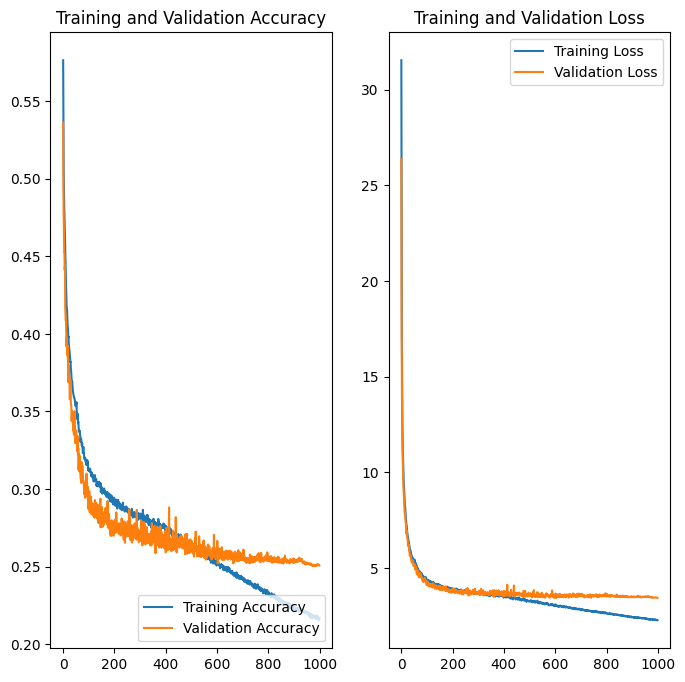

In [30]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

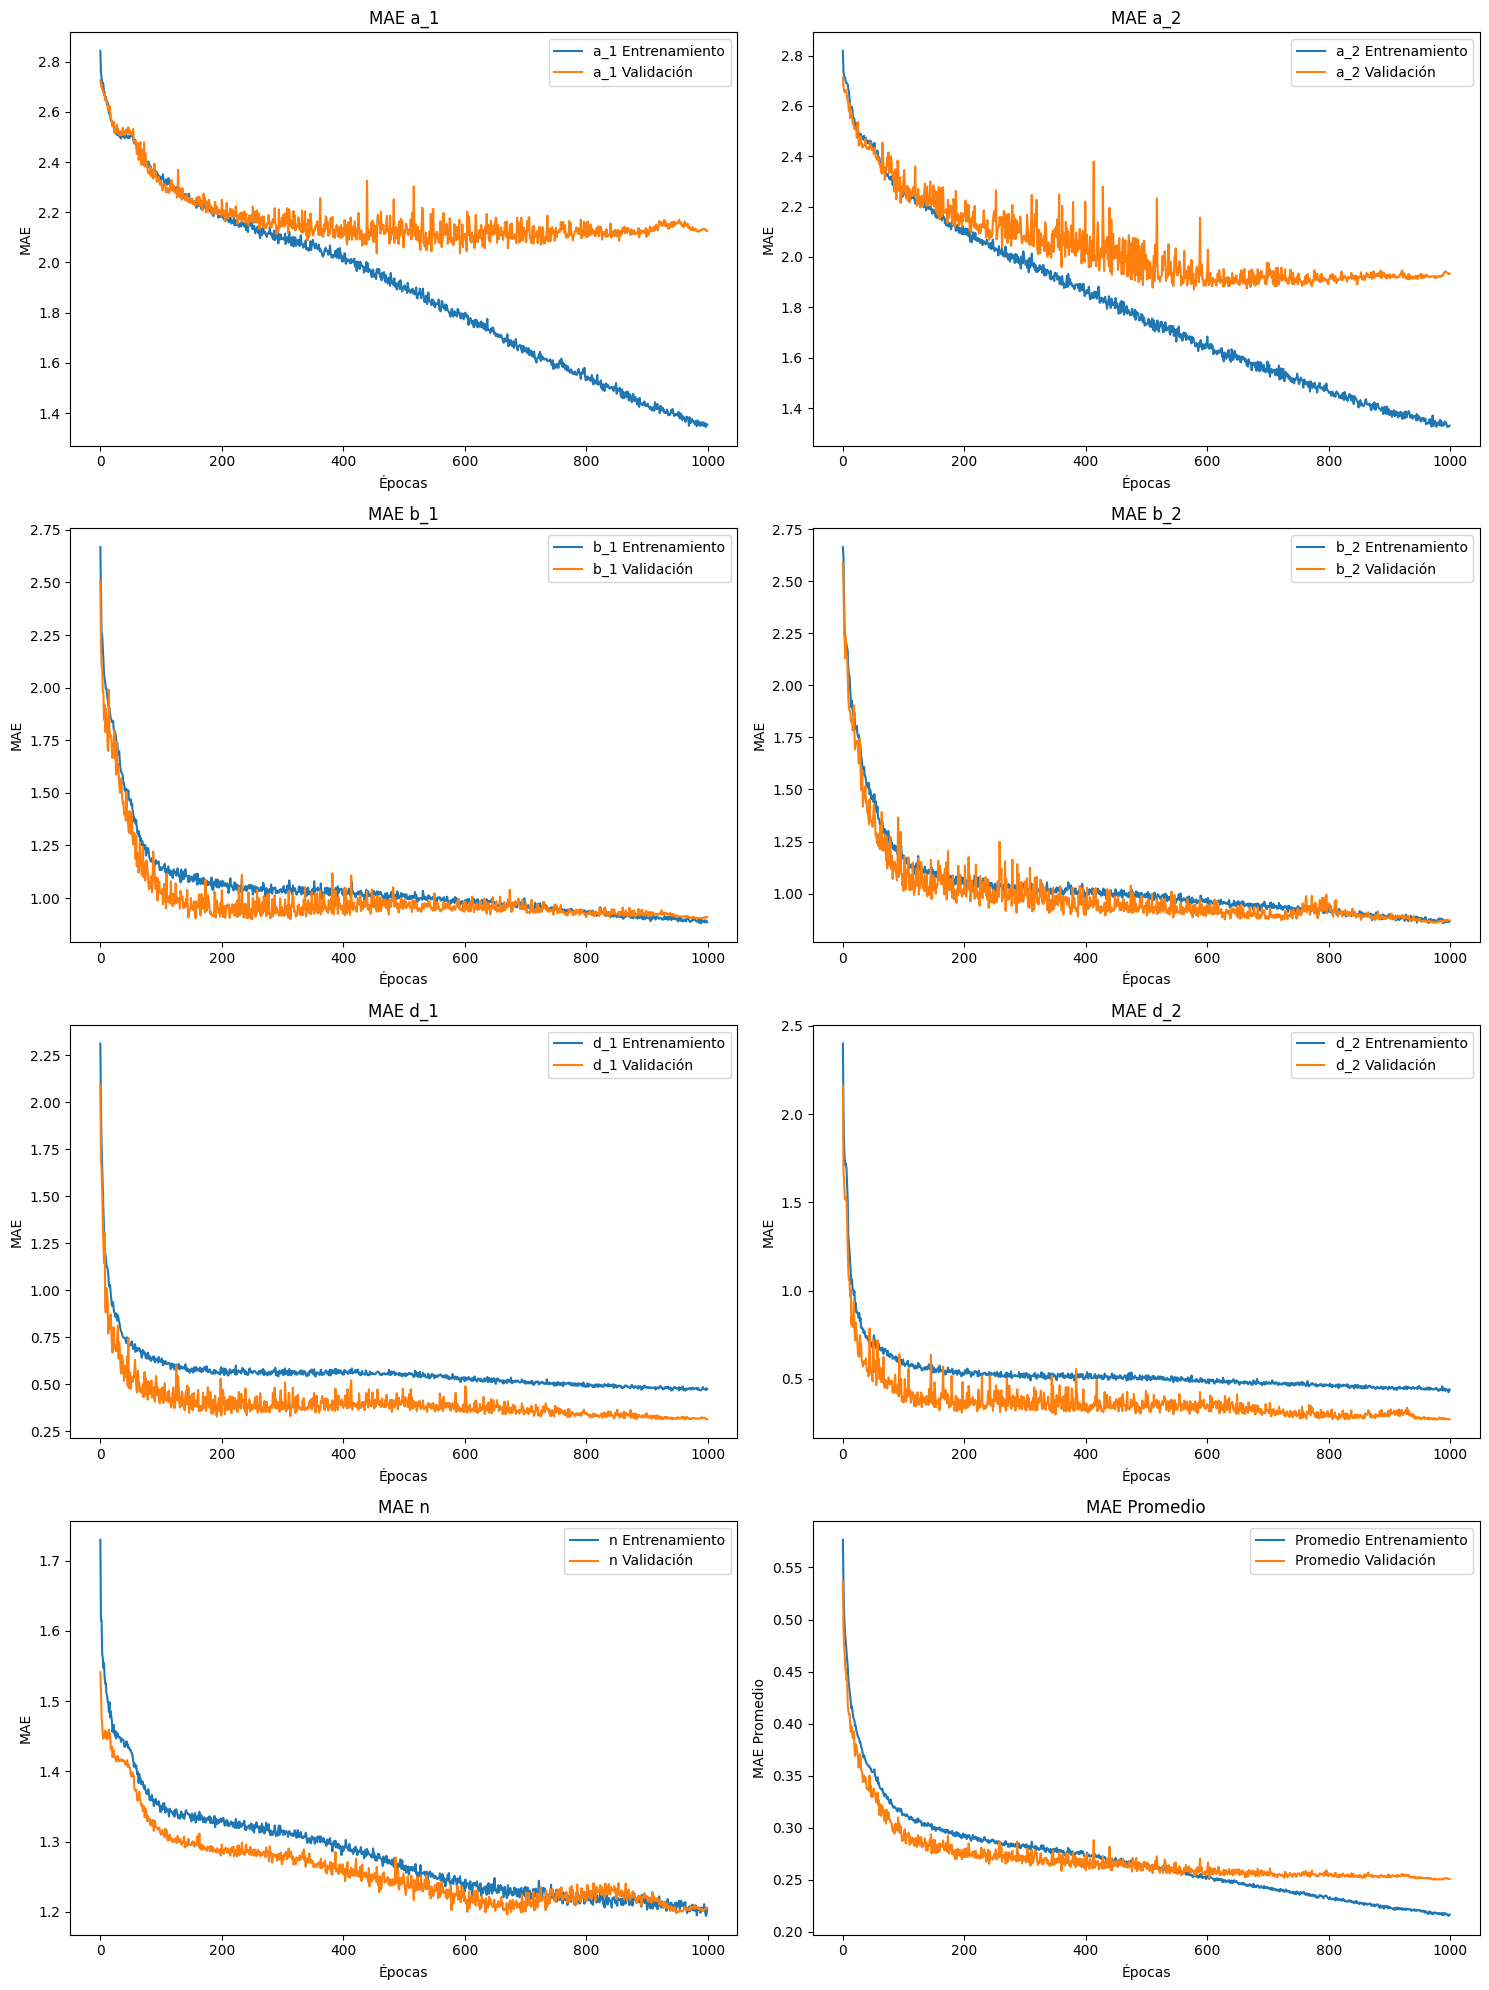

In [31]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [32]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    varftest, coefvarftest)

32/32 [==============================] - 0s 6ms/step - loss: 3.4949 - a_1: 2.0555 - a_2: 2.0520 - b_1: 0.8891 - b_2: 0.9489 - d_1: 0.3118 - d_2: 0.2780 - n: 1.2536 - mean_metric: 0.2615


In [33]:
predictions = model.predict(varftest)

32/32 [==============================] - 0s 4ms/step


In [34]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarftest, predictions)

# Calcula la desviación estándar del error
error = coefvarftest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.1106648897455473, Desviación estándar del error: 1.6947748102738684, Error absoluto máximo: 8.706780433654785


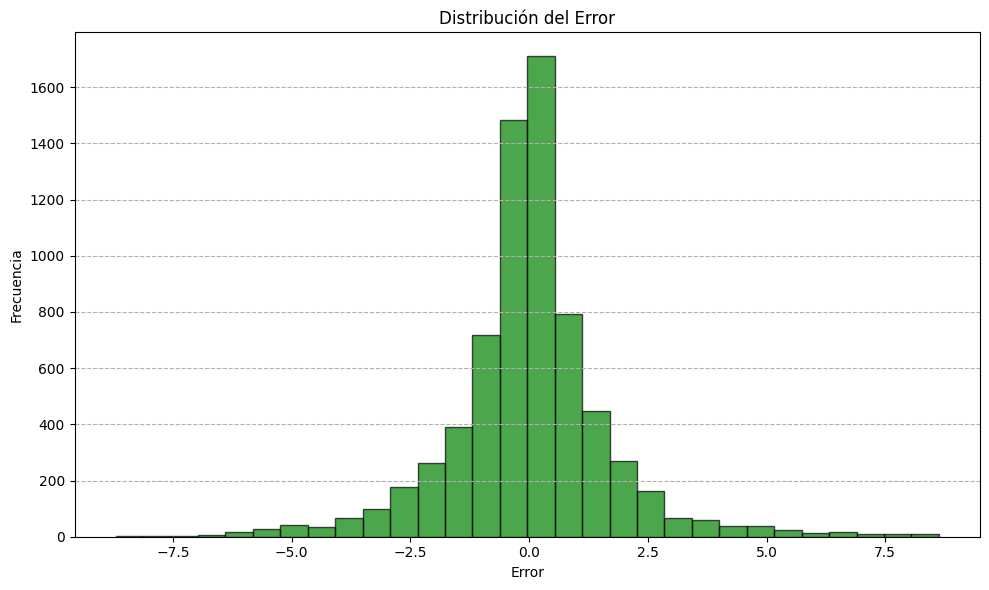

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [36]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefvarftest - predictions)

# Calcula el error para cada dato
error = coefvarftest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefvarftest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")


MAE relativo: 0.26563689748351227
Desviación estándar del error relativo: 0.14118714491057627
Error absoluto máximo relativo: 0.9975204368432363


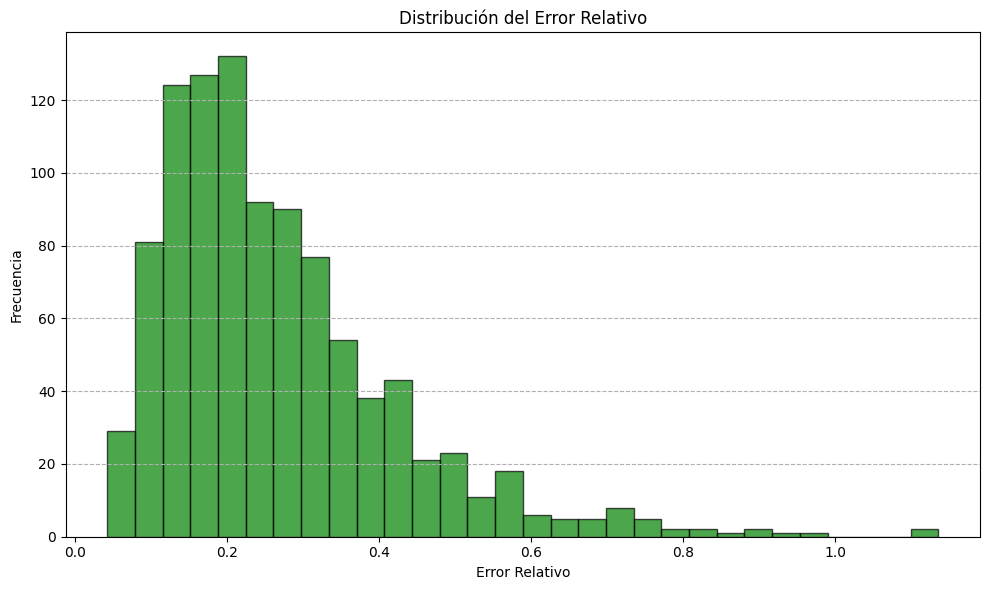

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

# Guardamos los datos de Accuracy y Loss

In [38]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 100,200/historyconvtrayec200.csv', index=False)

# Guardamos el modelo

In [39]:
path_to_save = '../../../Modelos/Modelos 100,200/'

In [40]:
model.save(path_to_save + '/convolucionaltr200.h5')

# Importamos el modelo

In [5]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [6]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [7]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/convolucionaltr200.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [8]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 200)
    
    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])
        condini.append(y0)
        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(f, t_span, y0, t_eval=times)
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfci = np.append([var1], [var2], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[1, 9, 2, 10, 1, 5, 4]
(10, 2, 200)


In [9]:
varfnone = varf[None, :]
varfnone = np.transpose(varfnone, (0,3,1,2))

## Predecimos con los datos nuevos

In [10]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 101ms/step
[[0. 8. 3. 2. 1. 5. 3.]]


## Graficamos con los coeficientes reales

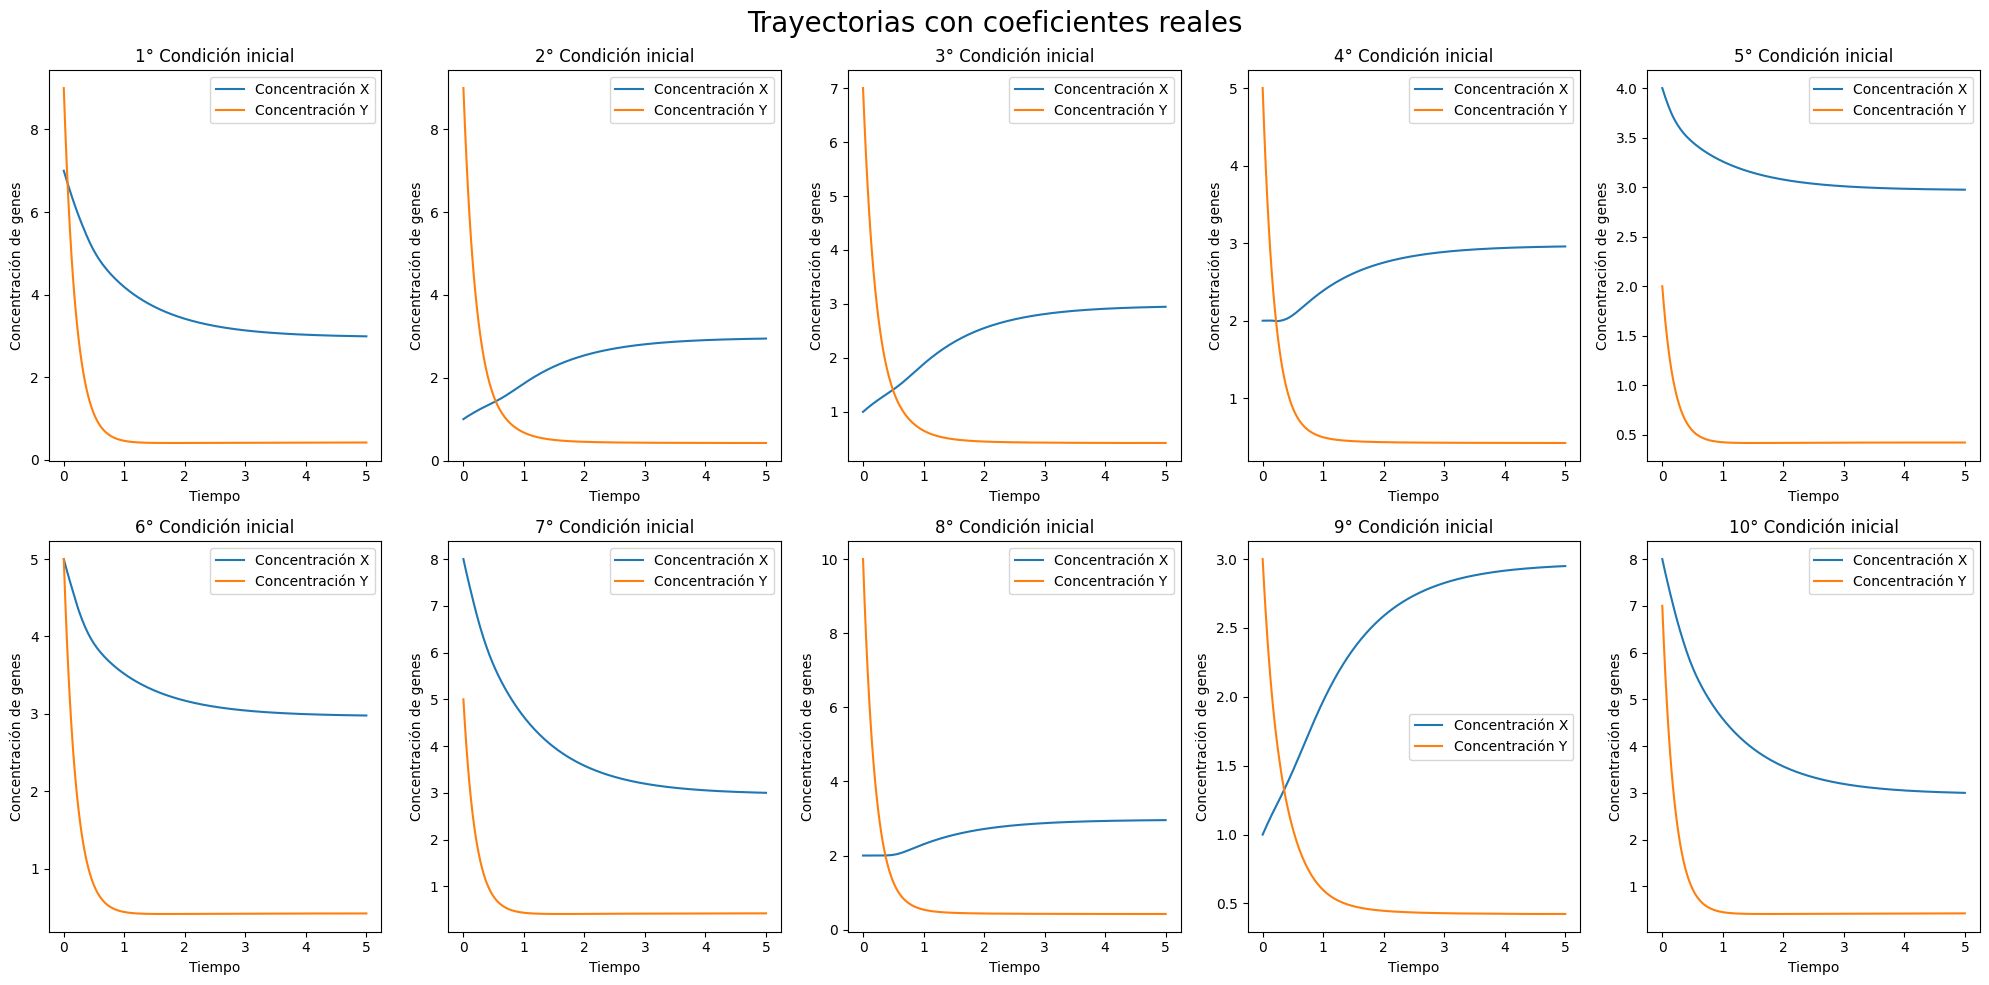

In [11]:
import matplotlib.pyplot as plt

t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos con los coeficientes predecidos

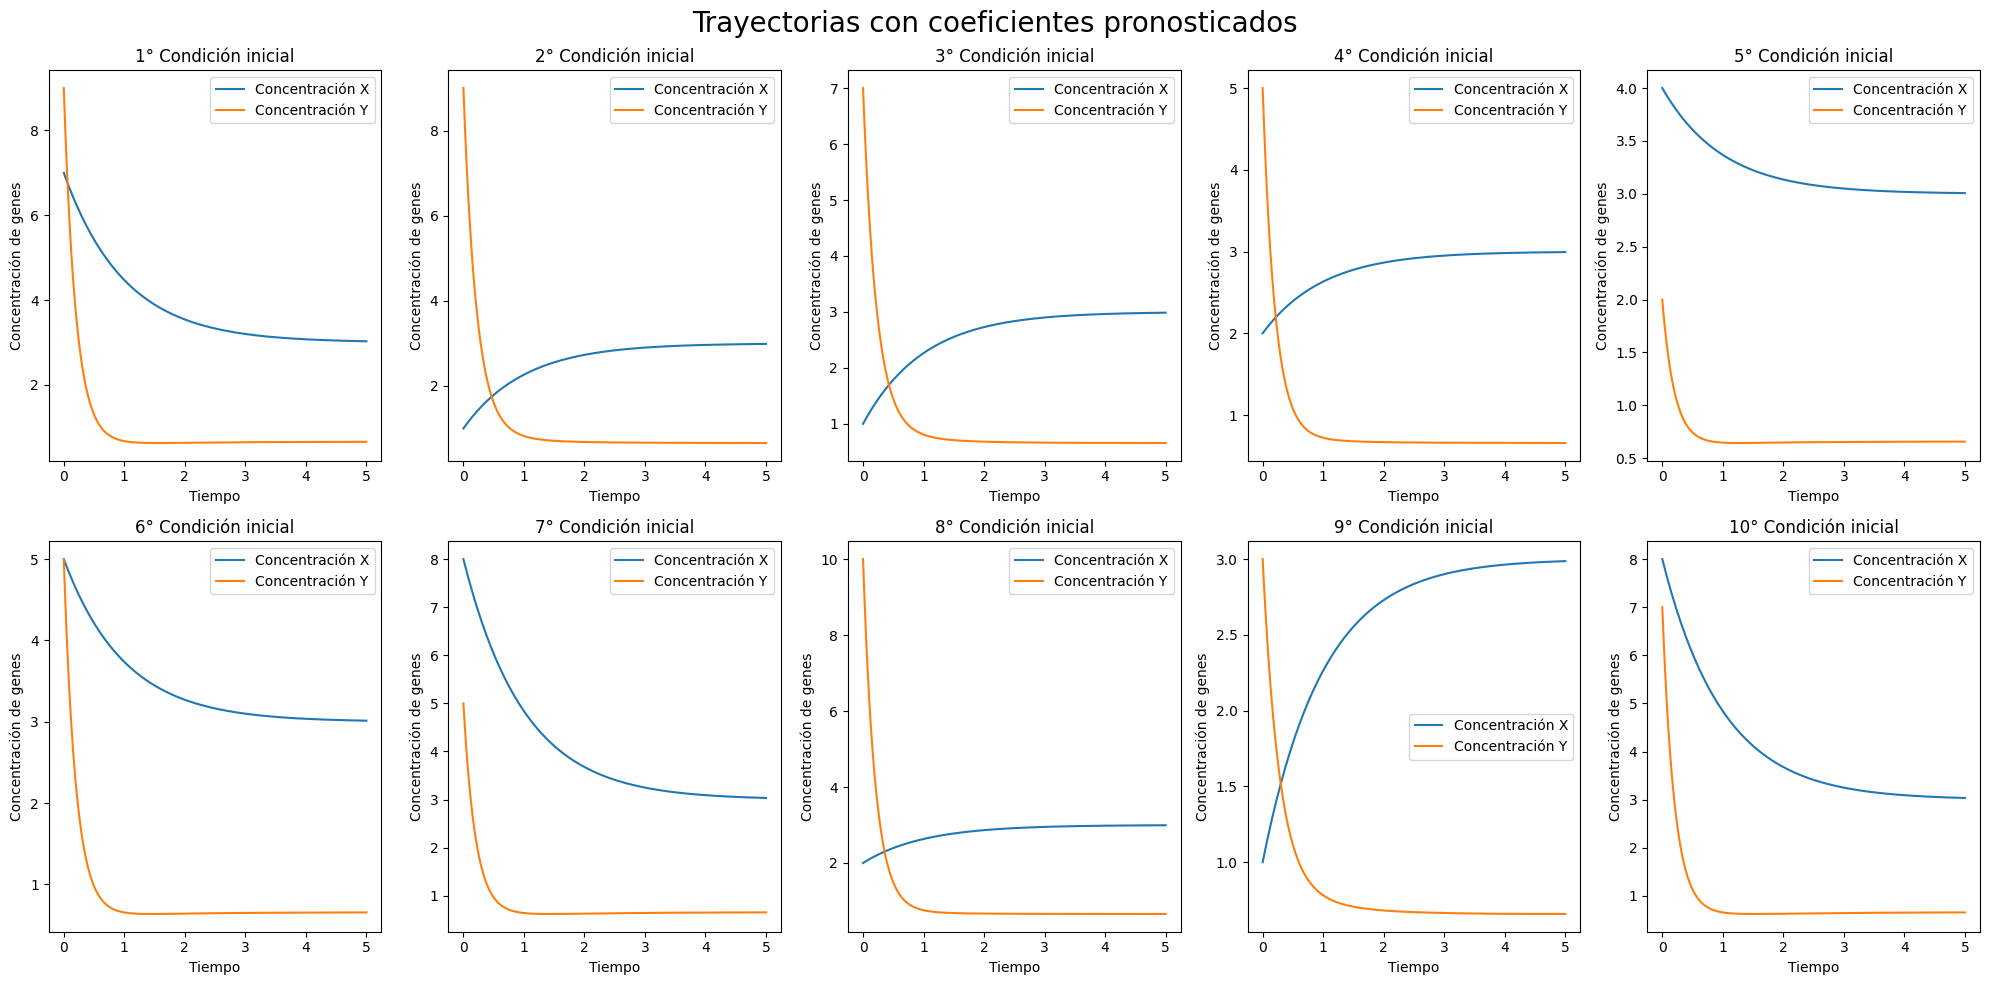

In [12]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

# Graficamos ambos

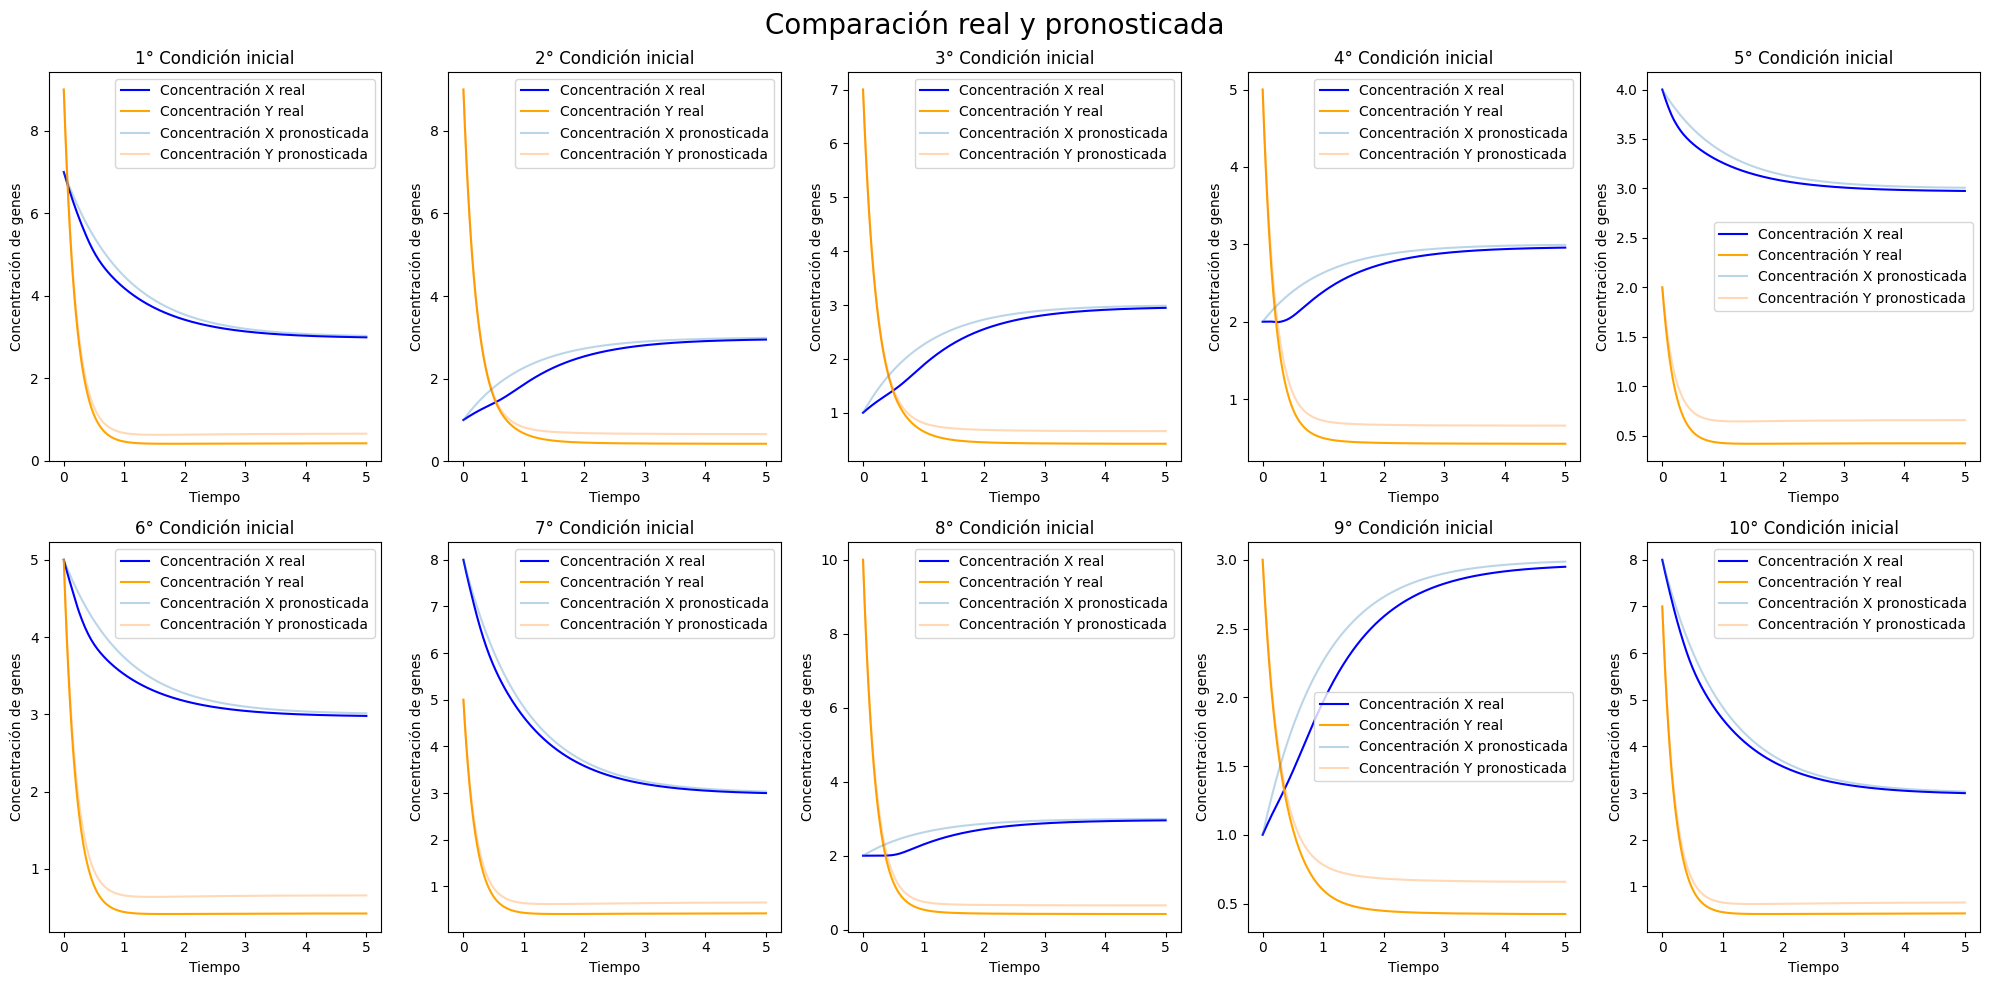

In [13]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

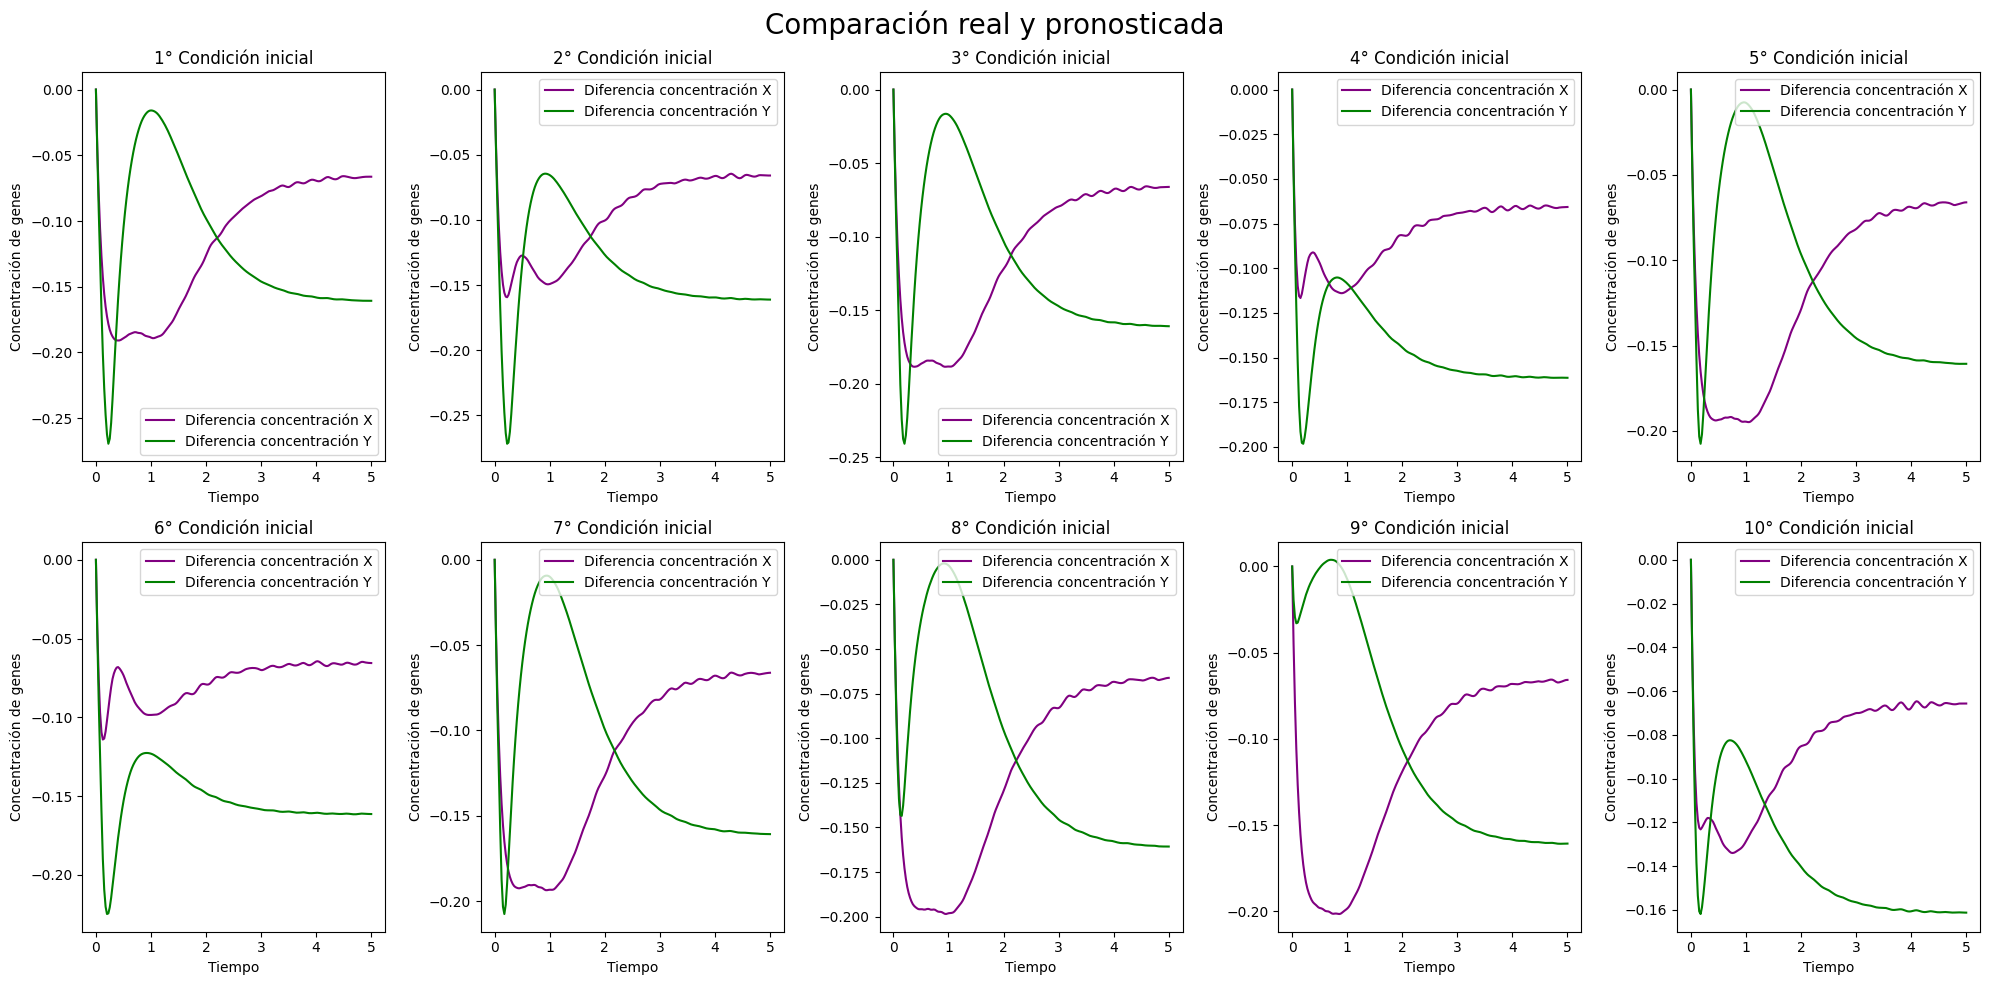

In [59]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [60]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.1031410603481088
0.12491377132565709


# Probamos modelo datos con ruido

## Datos de validación

In [96]:
varfvalrudio = np.load('../../../Base de datos con ruido/Trayectorias 200 eval/varfval.npy')
varfvalrudio = np.transpose(varfvalrudio, (0,3,1,2))

In [97]:
coefvarfvalruido =  np.load('../../../Base de datos con ruido/Trayectorias 200 eval/coefvarfval.npy')

In [98]:
test_lossruido, test_accrudio = model.evaluate(varfvalrudio,coefvarfvalruido)

32/32 [==============================] - 0s 3ms/step - loss: 10.4270 - mae: 2.4542


## Visualización

In [99]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [100]:
import keras
import tensorflow as tf
custom_objects = {'custom_activation': custom_activation}
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/convolucionaltr200.h5', custom_objects=custom_objects)

## Creamos datos con ruido

In [107]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
T = 5
t_span = [0,5]
dt = 0.025
N = int(T/dt)

for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 200)
    
    varfci2 = []
    for i_ci in range(10):
        # Definimos las condiciones iniciales
        X = np.zeros(N)
        Y = np.zeros(N)
        X[0] = random.randint(0, 10)
        Y[0] = random.randint(0, 10)
        y0 = np.array([X[0], Y[0]])
        condini.append(y0)

        # Simulación con ruido
        for i in range(N-1):
            noise1 = np.random.normal(0, .5)
            noise2 = np.random.normal(0, .5)

            X[i+1] = X[i] + (a1/(1+Y[i]**n) - d1*X[i] + b1)*dt + noise1*np.sqrt(dt)
            Y[i+1] = Y[i] + (a2/(1+X[i]**n) - d2*Y[i] + b2)*dt + noise2*np.sqrt(dt)


        varfci = np.append([X], [Y], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[10, 5, 4, 2, 4, 8, 0]
(10, 2, 200)


In [108]:
varfnone = varf[None, :]
varfnone = np.transpose(varfnone, (0,3,1,2))

## Predecimos con los datos nuevos

In [109]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 13ms/step
[[5. 4. 1. 5. 2. 5. 3.]]


## Graficamos con los coeficientes reales

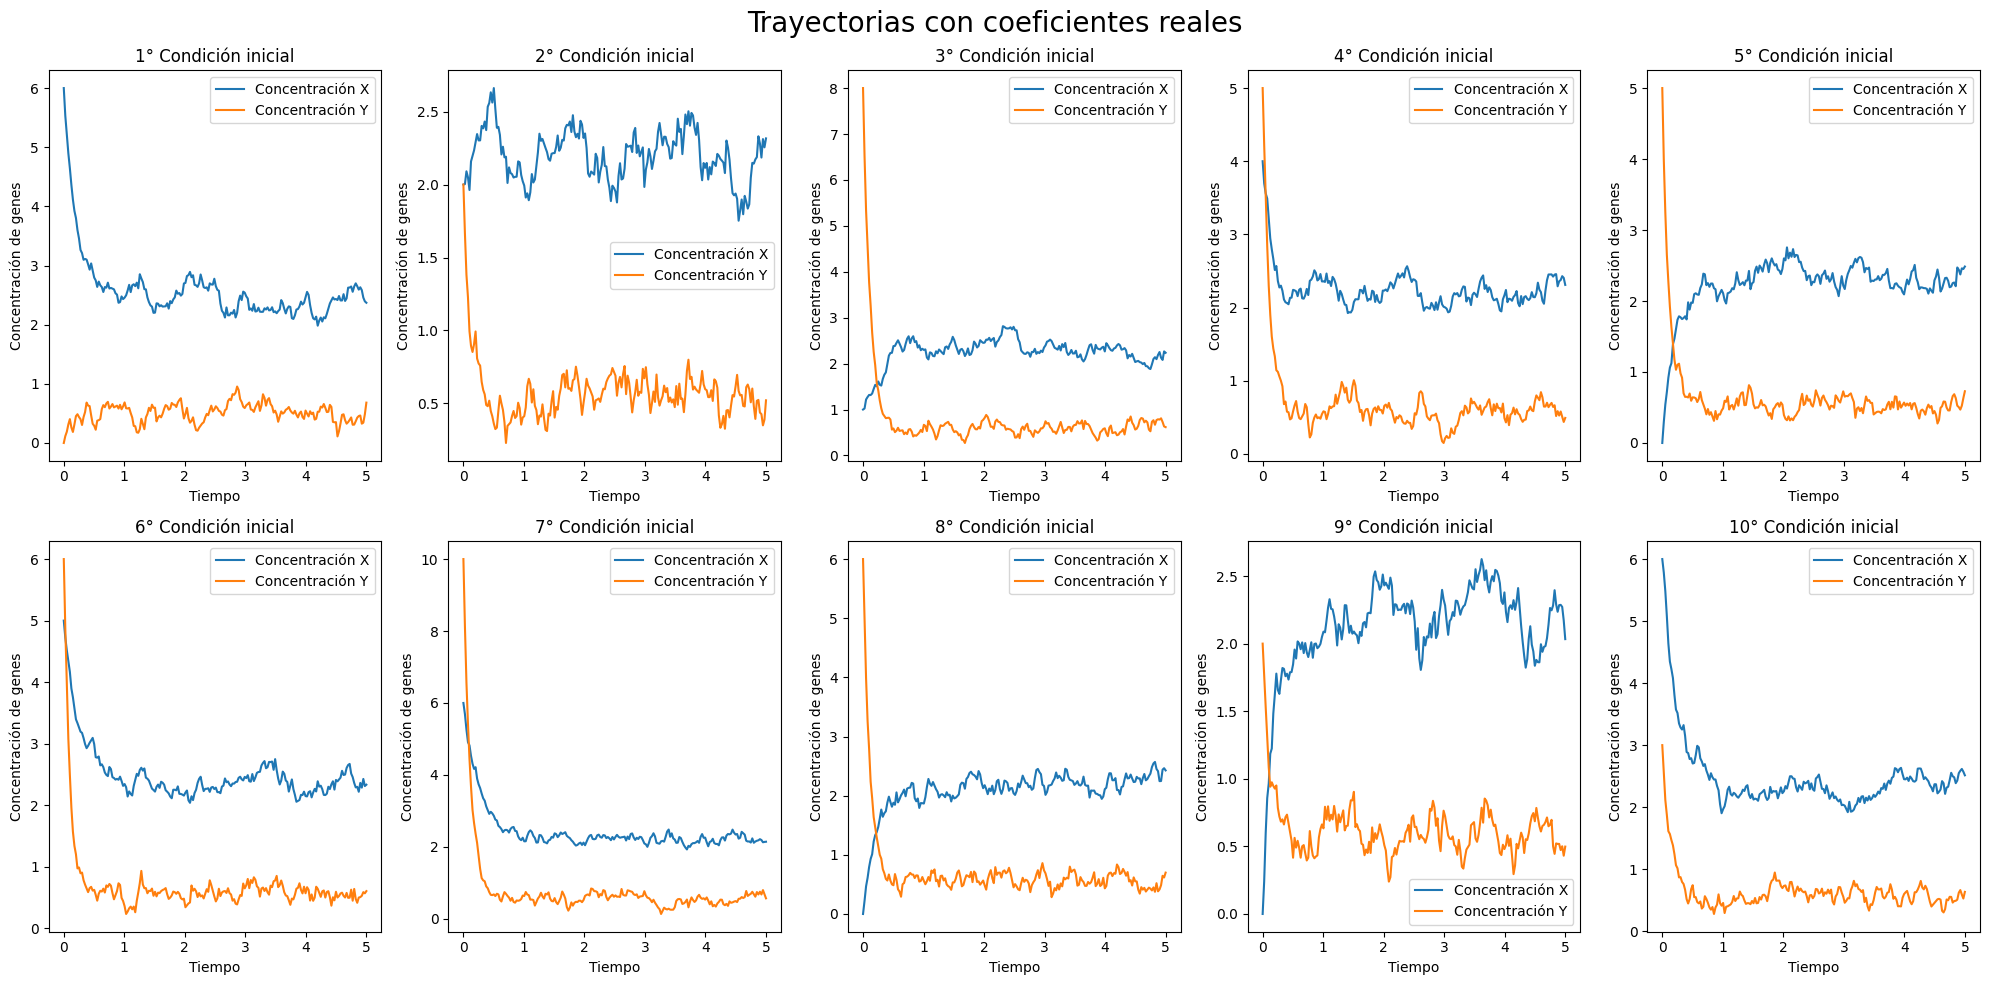

In [110]:
import matplotlib.pyplot as plt

t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos con los coeficientes predecidos

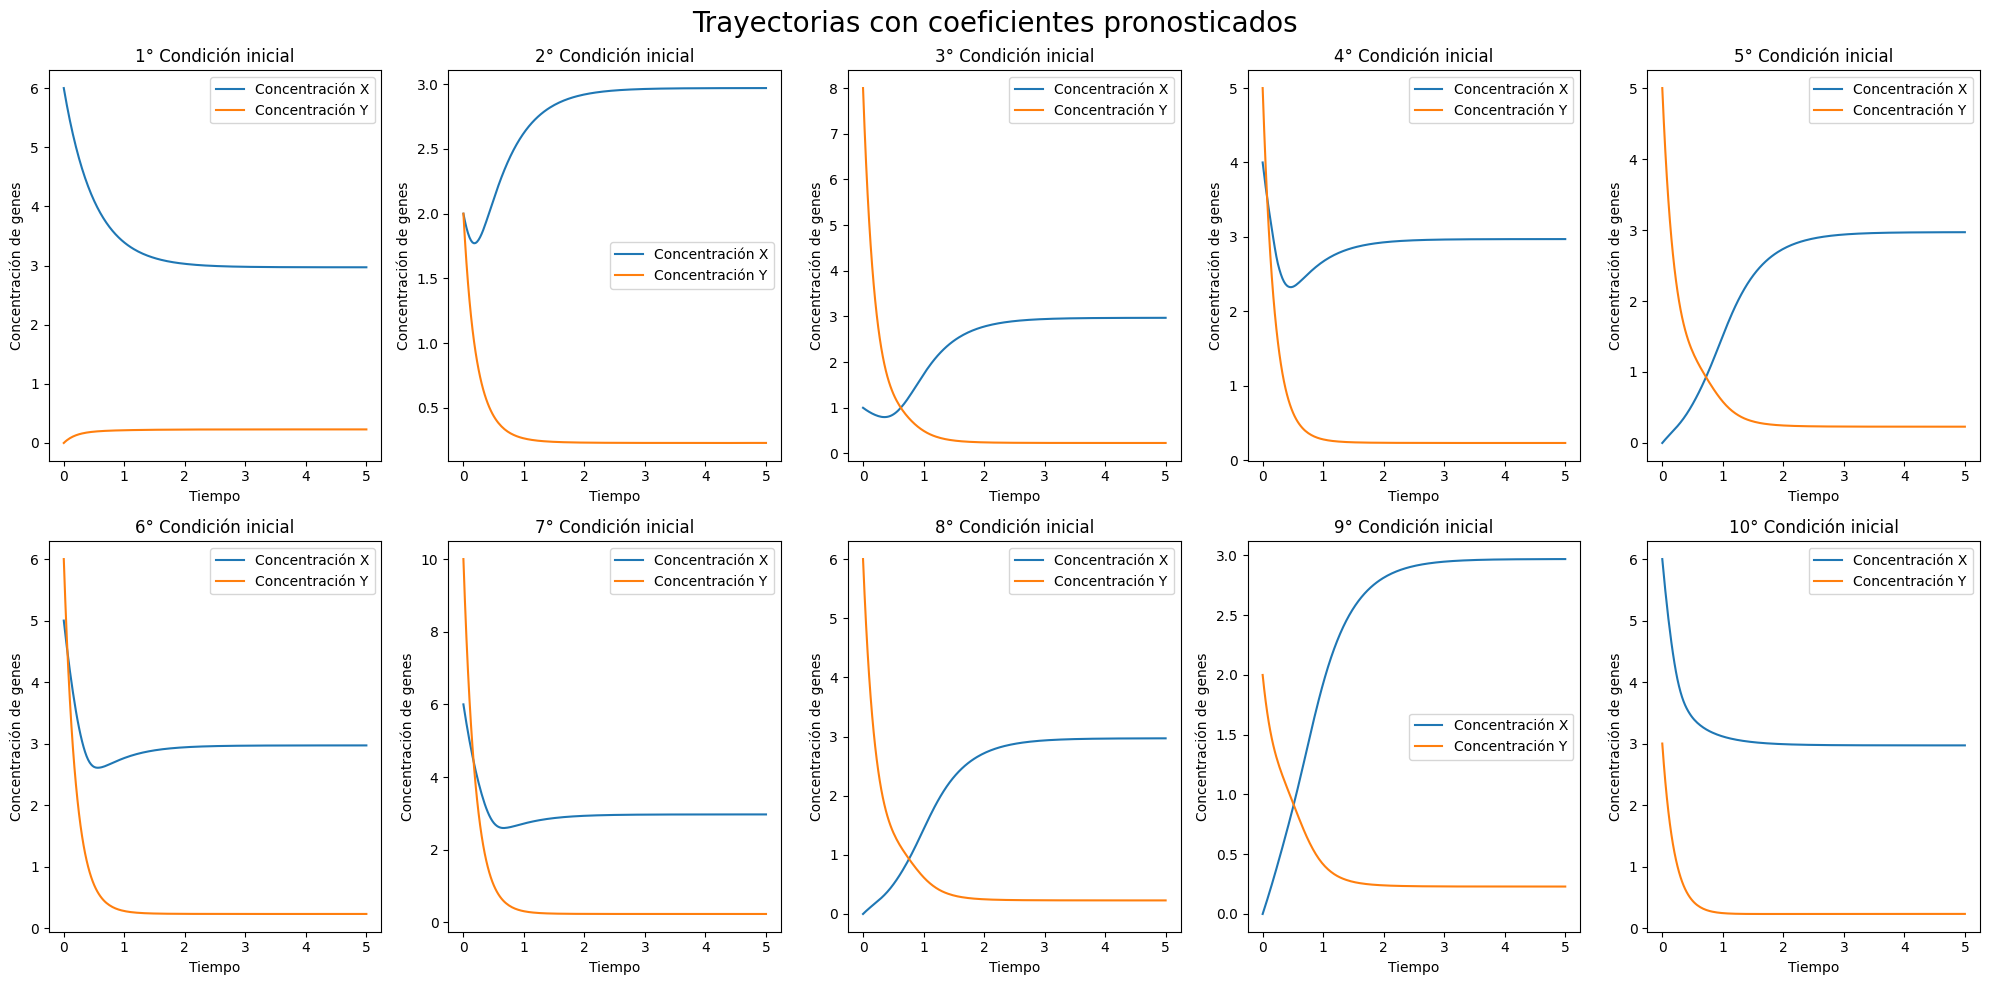

In [111]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

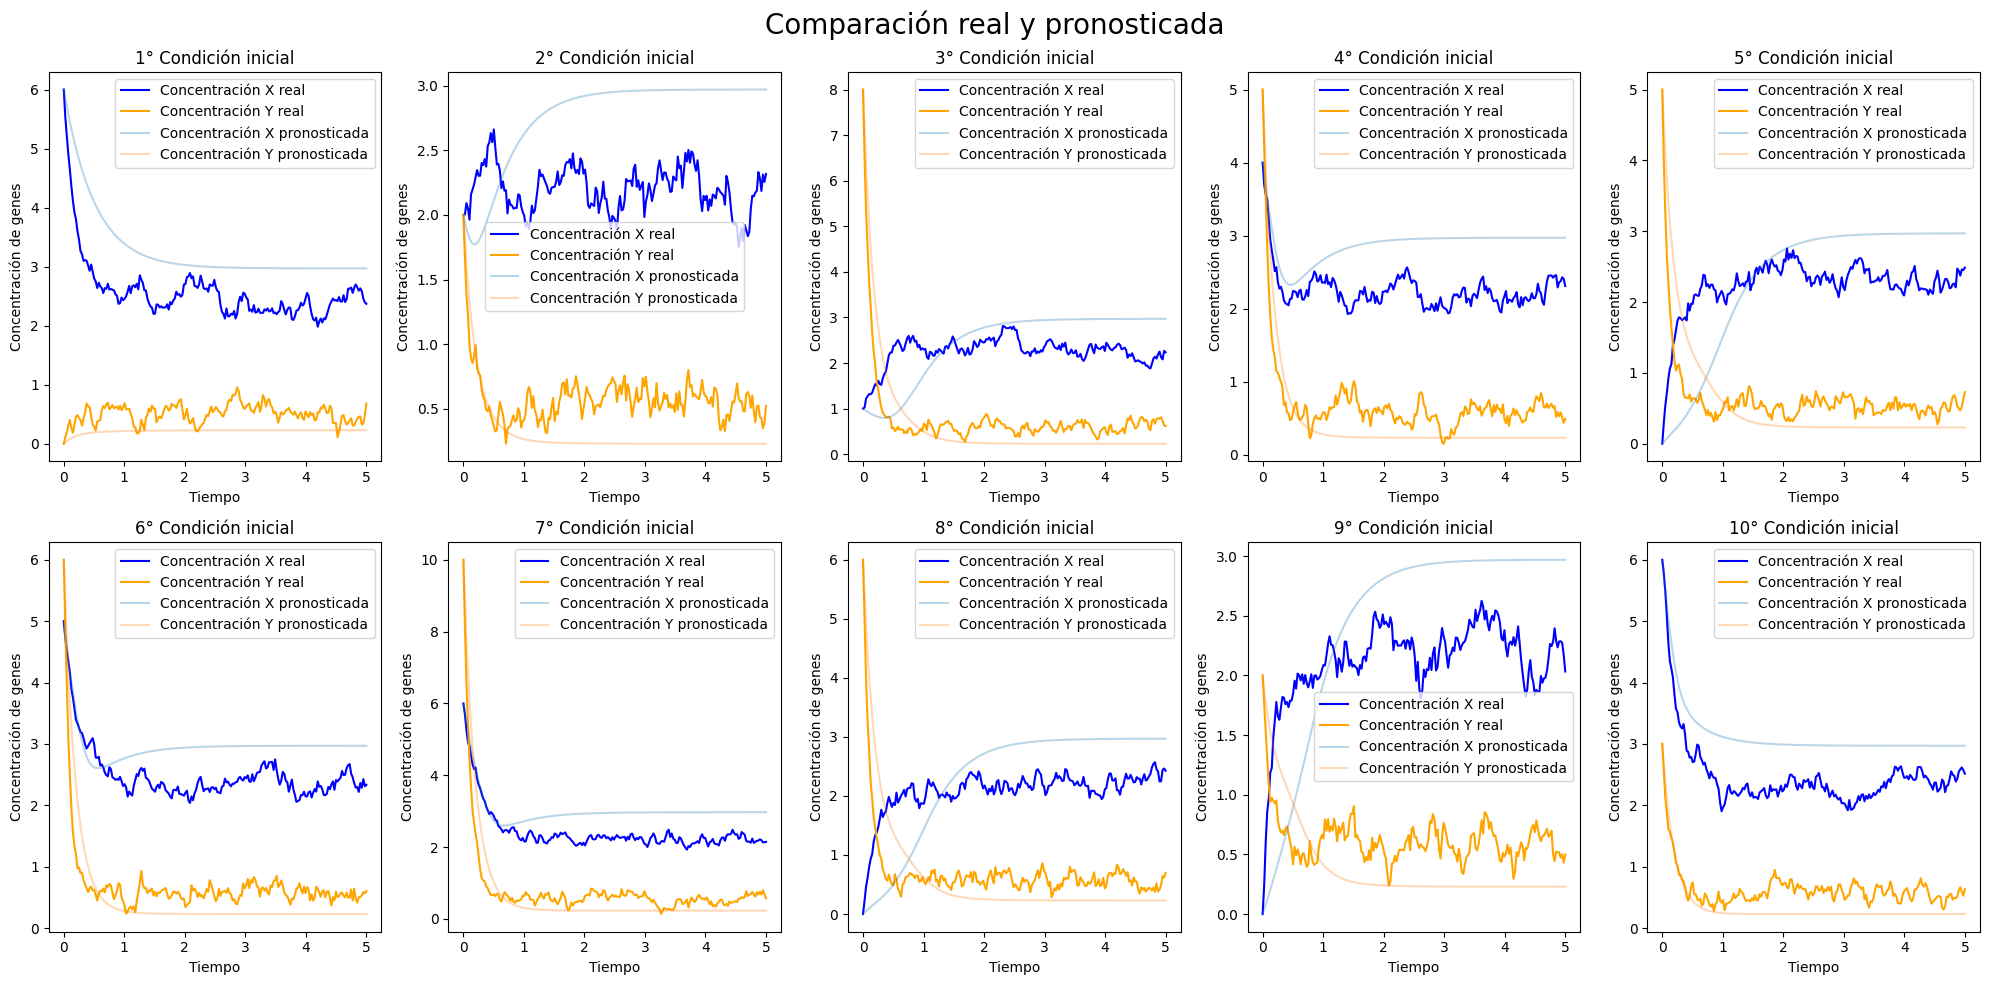

In [112]:
%matplotlib inline
#%matplotlib qt
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

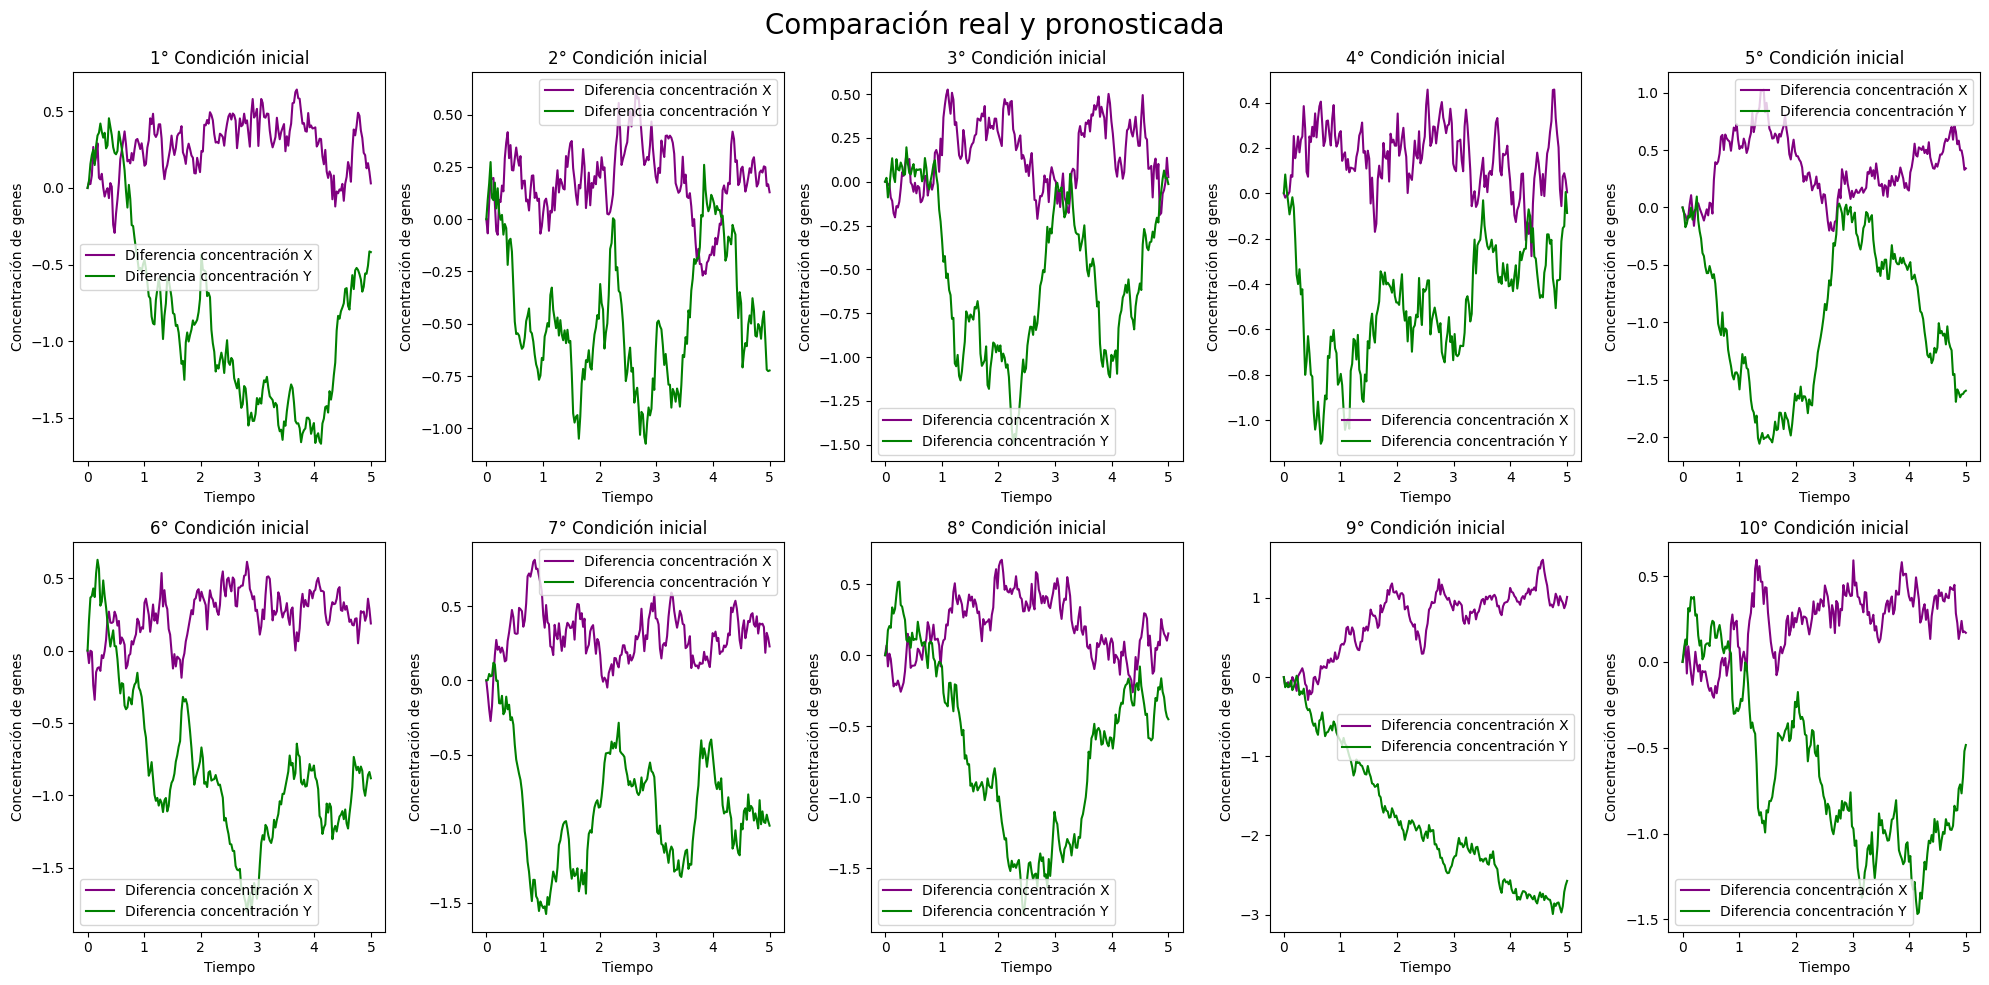

In [69]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 200)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [70]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.305233815563299
0.83628762056605
